In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True # True to preprocess

class DogsVSCats():
    IMG_SIZE=50
    CATS="dogVScat/dataset/test_set/cats"
    DOGS="dogVScat/dataset/test_set/dogs"
    LABELS= {CATS:0, DOGS:1}
    training_data= []
    catcount= 0
    dogcount= 0
    
    def make_training_data(self):
        
        # make cleaned training data
        for label in self.LABELS: # Iterate across cats and dogs file locations
            print(label)
            for f in tqdm(os.listdir(label)): # Iterate across each file in the folder
                try:
                    path = os.path.join(label, f) # Find path to image
                    img = cv2.imread(path, cv2.IMREAD_COLOR) # Read the image as greyscale
                    img = cv2.resize( img, (self.IMG_SIZE,self.IMG_SIZE)) # Resize to self.IMG_SIZE square
                    img=np.array(img)
                    img=np.transpose(img,(2,1,0))
                    self.training_data.append([img,np.eye(2)[self.LABELS[label]]])
                    # Count the balance
                    if label == self.CATS:
                        self.catcount+=1
                    if label == self.DOGS:
                        self.dogcount+=1
                                
                except Exeption as e: # Bad image files
                    pass
        
        # Shuffle data
        np.random.shuffle(self.training_data)
        # Save data
        np.save("training_data.npy",self.training_data)
        #Done:
        print("done")
        print("Cats:"+ str(self.catcount))
        print("Dogs:"+ str(self.dogcount))
                                
if REBUILD_DATA:
    dogsvscats=DogsVSCats()
    dogsvscats.make_training_data()
                
                
                
                
                

  2%|▏         | 15/1000 [00:00<00:06, 145.91it/s]

dogVScat/dataset/test_set/cats


  2%|▏         | 16/1000 [00:00<00:06, 151.60it/s]

dogVScat/dataset/test_set/dogs


100%|██████████| 1000/1000 [00:05<00:00, 185.42it/s]


done
Cats:1000
Dogs:1000


In [2]:
training_data= np.load("training_data.npy",allow_pickle=True)
print(len(training_data))

2000


In [3]:
n = 7
print(training_data[n][0].shape)
print(training_data[n])
import matplotlib.pyplot as plt
plt.imshow(np.transpose(training_data[n][0],(2,1,0)))

print(training_data[n][0].shape)

(3, 50, 50)
[array([[[145, 160, 172, ..., 189, 187, 187],
        [129, 146, 155, ..., 189, 185, 185],
        [112, 124, 129, ..., 191, 183, 178],
        ...,
        [ 53,  47,  60, ..., 168, 170, 168],
        [ 52,  50,  68, ..., 165, 166, 166],
        [ 54,  52,  63, ..., 163, 158, 157]],

       [[147, 162, 174, ..., 195, 196, 196],
        [131, 148, 157, ..., 195, 194, 194],
        [113, 126, 131, ..., 197, 192, 187],
        ...,
        [ 54,  52,  70, ..., 177, 179, 177],
        [ 53,  51,  70, ..., 174, 175, 175],
        [ 55,  53,  65, ..., 172, 167, 166]],

       [[148, 163, 175, ..., 206, 206, 206],
        [132, 149, 158, ..., 206, 204, 205],
        [115, 127, 132, ..., 208, 202, 197],
        ...,
        [ 52,  55,  80, ..., 187, 189, 187],
        [ 51,  55,  81, ..., 184, 185, 185],
        [ 53,  57,  76, ..., 182, 177, 176]]], dtype=uint8)
 array([0., 1.])]
(3, 50, 50)


In [4]:
# The network
import torch
import torch.nn as nn
import torch.nn.functional as nnf

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(3,32,5) # EXPAND SPACE
        self.conv2= nn.Conv2d(32,64,5)
        self.conv3= nn.Conv2d(64,128,5)
        #flatten
        x= torch.randn(1,3,50, 50)
#         print( "x_ shape: "+ str(x.shape) )
        self._to_linear = None
        self.convs(x) #find flatten dimention
        self.fc1 = nn.Linear(self._to_linear, 512) 
        self.fc2= nn.Linear(512,2)
    
    def convs(self,x):
        x= nnf.max_pool2d(nnf.relu(self.conv1(x)),(2,2))
        x= nnf.max_pool2d(nnf.relu(self.conv2(x)),(2,2))
        x= nnf.max_pool2d(nnf.relu(self.conv3(x)),(2,2))
#         print( "x_ shape: "+ str(x[0].shape))
       
        if self._to_linear is None: # find the input dimention of the flattening layer
            self._to_linear= x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        return x
    
    def forward(self,x):
        x= self.convs(x)
        x= x.view(-1,self._to_linear)
        x= nnf.relu(self.fc1(x))
        x= self.fc2(x)
        return nnf.softmax(x,dim=1)

net = Net()

In [5]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data])
X = X/255 # rescale
y= torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # percent of data to use for testing
val_size = int(len(X)*VAL_PCT)
print(val_size)

200


In [6]:
train_X =X[:-val_size]
train_y =y[:-val_size]

test_X =X[-val_size:]
test_y =y[-val_size:]

In [7]:
def accuracy():
    correct = 0
    total =0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out= net(test_X[i].view(-1,3,50,50))[0]

            predicted_class = torch.argmax( net_out)
            if predicted_class == real_class:
                correct+=1
            total+= 1
    return correct/total
print(" Accuracy:"+str( accuracy()*100)+" %")

100%|██████████| 200/200 [00:02<00:00, 76.89it/s]

 Accuracy:53.0 %


In [8]:
BATCH_SIZE = 64
EPOCHS = 50

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        batch_X= train_X[i:i+BATCH_SIZE].view(-1,3,50,50)
        batch_y= train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs= net(batch_X)
        loss= loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
    print("epoch: "+ str(epoch)+ " loss: "+ str(loss))
    if epoch%10 ==0:
            print(" Accuracy:"+str( accuracy()*100)+" %")

 10%|█         | 20/200 [00:00<00:00, 190.40it/s]

epoch: 0 loss: tensor(0.2621, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy:65.5 %


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1 loss: tensor(0.2468, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2 loss: tensor(0.2059, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3 loss: tensor(0.2190, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4 loss: tensor(0.1509, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5 loss: tensor(0.2015, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6 loss: tensor(0.1120, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7 loss: tensor(0.0788, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8 loss: tensor(0.0123, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9 loss: tensor(0.0055, grad_fn=<MseLossBackward>)


 10%|▉         | 19/200 [00:00<00:00, 181.24it/s]

epoch: 10 loss: tensor(0.0026, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy:61.0 %


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11 loss: tensor(0.0038, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12 loss: tensor(0.0018, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13 loss: tensor(0.0009, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14 loss: tensor(2.3719e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 15 loss: tensor(0.0065, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 16 loss: tensor(0.0039, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 17 loss: tensor(0.0001, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 18 loss: tensor(1.3013e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 19 loss: tensor(0.0001, grad_fn=<MseLossBackward>)


 16%|█▌        | 32/200 [00:00<00:00, 317.38it/s]

epoch: 20 loss: tensor(2.3495e-06, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy:64.5 %


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 21 loss: tensor(1.3075e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 22 loss: tensor(2.2864e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 23 loss: tensor(9.9751e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 24 loss: tensor(1.9809e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 25 loss: tensor(4.9433e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 26 loss: tensor(3.4528e-05, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 27 loss: tensor(3.4458e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 28 loss: tensor(4.2335e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 29 loss: tensor(2.7497e-07, grad_fn=<MseLossBackward>)


 14%|█▍        | 28/200 [00:00<00:00, 271.02it/s]

epoch: 30 loss: tensor(1.8527e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy:69.5 %


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 31 loss: tensor(1.5526e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 32 loss: tensor(1.3136e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 33 loss: tensor(1.1405e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 34 loss: tensor(1.0207e-07, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 35 loss: tensor(9.3113e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 36 loss: tensor(8.5323e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 37 loss: tensor(7.8869e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 38 loss: tensor(7.3461e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 39 loss: tensor(6.8379e-08, grad_fn=<MseLossBackward>)


 18%|█▊        | 37/200 [00:00<00:00, 363.90it/s]

epoch: 40 loss: tensor(6.4166e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy:70.5 %


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 41 loss: tensor(5.9918e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 42 loss: tensor(5.6140e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 43 loss: tensor(5.2806e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 44 loss: tensor(4.9699e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 45 loss: tensor(4.7067e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 46 loss: tensor(4.4455e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 47 loss: tensor(4.2191e-08, grad_fn=<MseLossBackward>)


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 48 loss: tensor(4.0200e-08, grad_fn=<MseLossBackward>)


100%|██████████| 29/29 [00:10<00:00,  2.71it/s]

epoch: 49 loss: tensor(3.8247e-08, grad_fn=<MseLossBackward>)



0


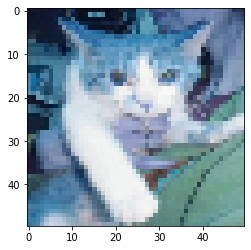

ACTUAL: tensor(0)
PREDICTED: tensor(0)

1


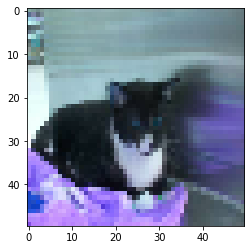

ACTUAL: tensor(0)
PREDICTED: tensor(0)

2


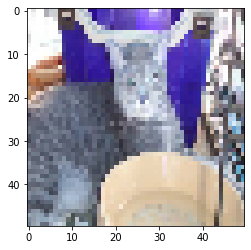

ACTUAL: tensor(0)
PREDICTED: tensor(0)

3


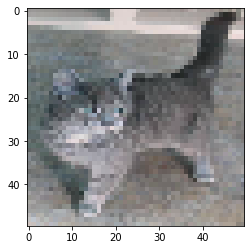

ACTUAL: tensor(0)
PREDICTED: tensor(0)

4


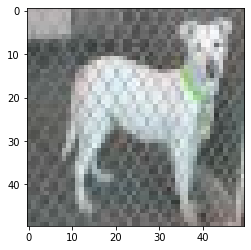

ACTUAL: tensor(1)
PREDICTED: tensor(1)

5


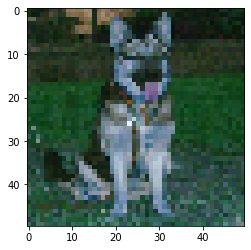

ACTUAL: tensor(1)
PREDICTED: tensor(1)

6


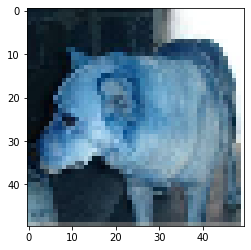

ACTUAL: tensor(1)
PREDICTED: tensor(0)

7


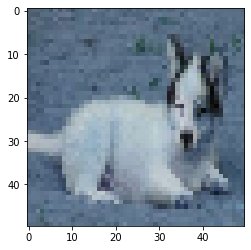

ACTUAL: tensor(1)
PREDICTED: tensor(1)

8


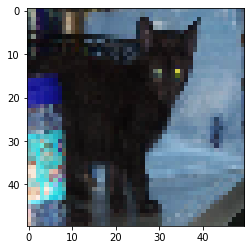

ACTUAL: tensor(0)
PREDICTED: tensor(0)

9


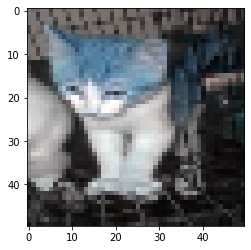

ACTUAL: tensor(0)
PREDICTED: tensor(1)

10


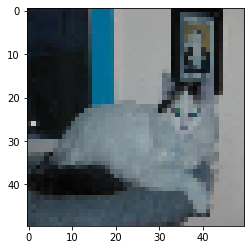

ACTUAL: tensor(0)
PREDICTED: tensor(0)

11


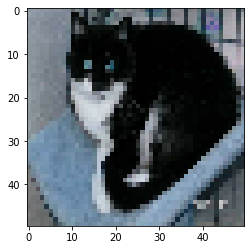

ACTUAL: tensor(0)
PREDICTED: tensor(0)

12


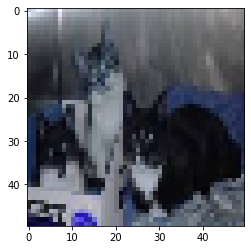

ACTUAL: tensor(0)
PREDICTED: tensor(0)

13


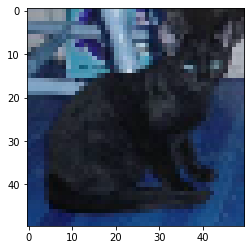

ACTUAL: tensor(0)
PREDICTED: tensor(1)

14


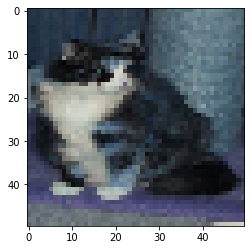

ACTUAL: tensor(0)
PREDICTED: tensor(0)

15


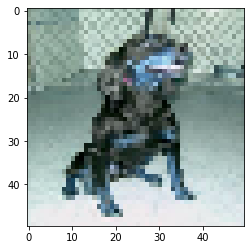

ACTUAL: tensor(1)
PREDICTED: tensor(1)

16


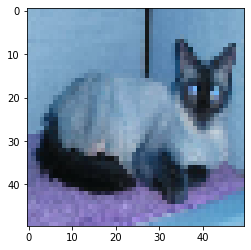

ACTUAL: tensor(0)
PREDICTED: tensor(0)

17


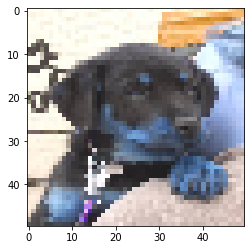

ACTUAL: tensor(1)
PREDICTED: tensor(0)

18


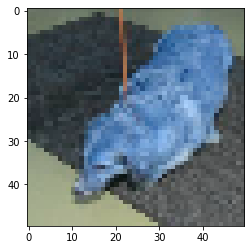

ACTUAL: tensor(1)
PREDICTED: tensor(0)

19


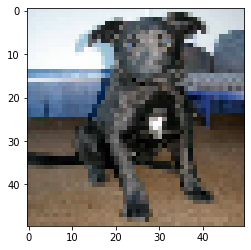

ACTUAL: tensor(1)
PREDICTED: tensor(0)

20


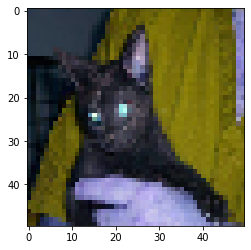

ACTUAL: tensor(0)
PREDICTED: tensor(0)

21


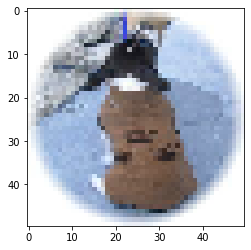

ACTUAL: tensor(1)
PREDICTED: tensor(0)

22


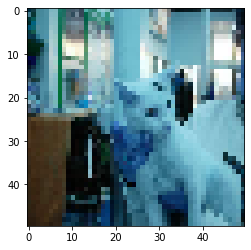

ACTUAL: tensor(0)
PREDICTED: tensor(1)

23


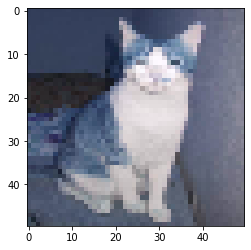

ACTUAL: tensor(0)
PREDICTED: tensor(0)

24


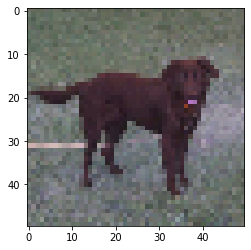

ACTUAL: tensor(1)
PREDICTED: tensor(1)

25


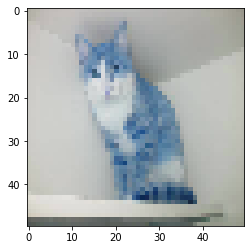

ACTUAL: tensor(0)
PREDICTED: tensor(0)

26


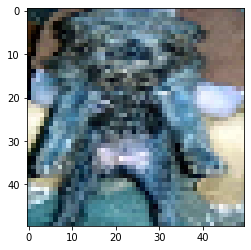

ACTUAL: tensor(1)
PREDICTED: tensor(1)

27


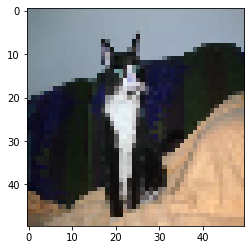

ACTUAL: tensor(0)
PREDICTED: tensor(1)

28


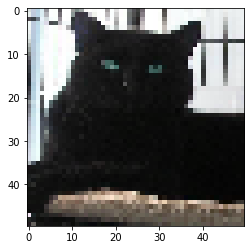

ACTUAL: tensor(0)
PREDICTED: tensor(0)

29


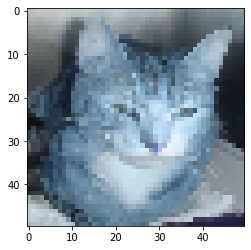

ACTUAL: tensor(0)
PREDICTED: tensor(0)

30


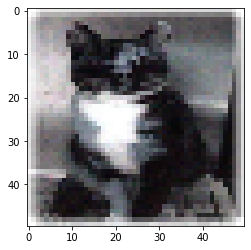

ACTUAL: tensor(0)
PREDICTED: tensor(1)

31


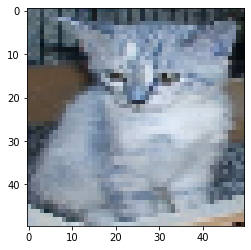

ACTUAL: tensor(0)
PREDICTED: tensor(0)

32


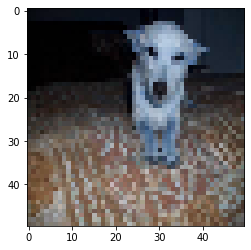

ACTUAL: tensor(1)
PREDICTED: tensor(0)

33


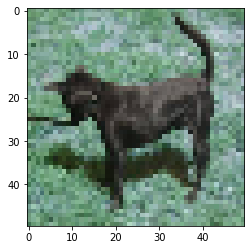

ACTUAL: tensor(1)
PREDICTED: tensor(1)

34


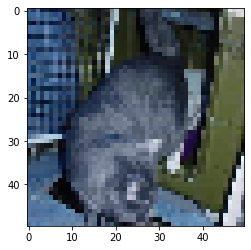

ACTUAL: tensor(0)
PREDICTED: tensor(0)

35


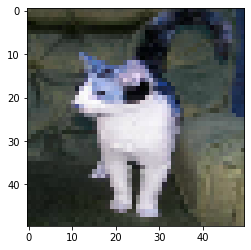

ACTUAL: tensor(0)
PREDICTED: tensor(1)

36


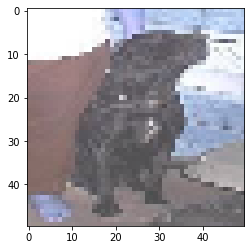

ACTUAL: tensor(1)
PREDICTED: tensor(0)

37


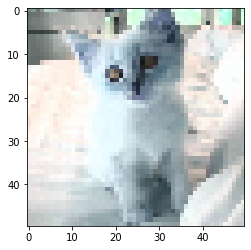

ACTUAL: tensor(0)
PREDICTED: tensor(1)

38


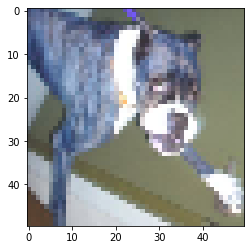

ACTUAL: tensor(1)
PREDICTED: tensor(0)

39


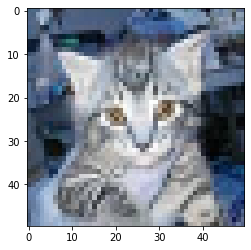

ACTUAL: tensor(0)
PREDICTED: tensor(0)

40


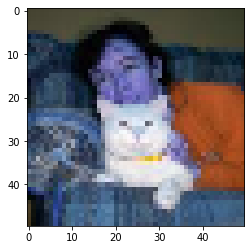

ACTUAL: tensor(1)
PREDICTED: tensor(0)

41


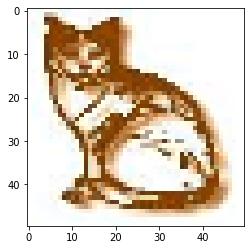

ACTUAL: tensor(0)
PREDICTED: tensor(1)

42


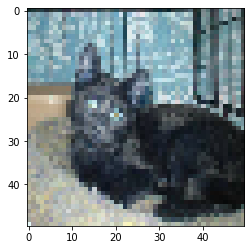

ACTUAL: tensor(0)
PREDICTED: tensor(1)

43


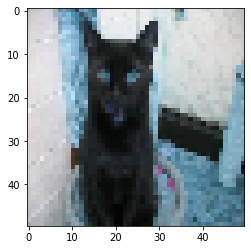

ACTUAL: tensor(0)
PREDICTED: tensor(1)

44


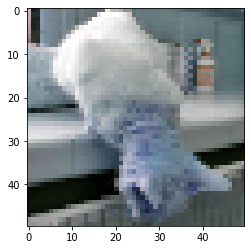

ACTUAL: tensor(0)
PREDICTED: tensor(0)

45


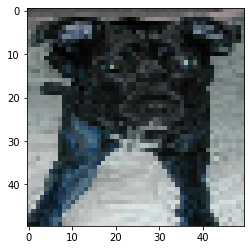

ACTUAL: tensor(1)
PREDICTED: tensor(1)

46


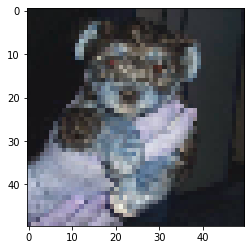

ACTUAL: tensor(1)
PREDICTED: tensor(0)

47


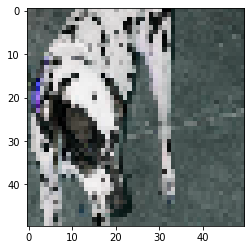

ACTUAL: tensor(1)
PREDICTED: tensor(0)

48


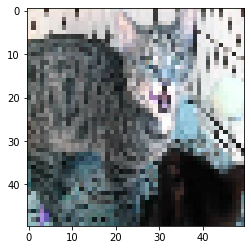

ACTUAL: tensor(0)
PREDICTED: tensor(0)

49


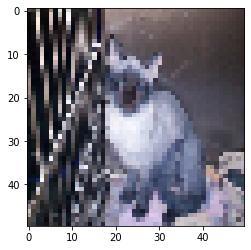

ACTUAL: tensor(0)
PREDICTED: tensor(1)

50


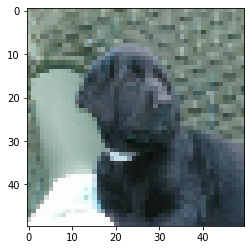

ACTUAL: tensor(1)
PREDICTED: tensor(1)

51


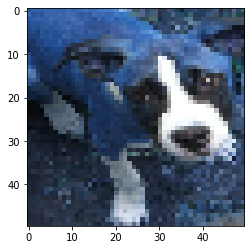

ACTUAL: tensor(1)
PREDICTED: tensor(1)

52


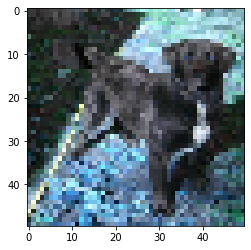

ACTUAL: tensor(1)
PREDICTED: tensor(1)

53


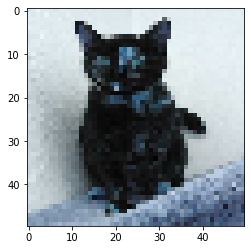

ACTUAL: tensor(0)
PREDICTED: tensor(1)

54


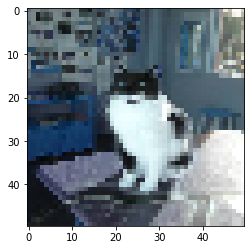

ACTUAL: tensor(0)
PREDICTED: tensor(0)

55


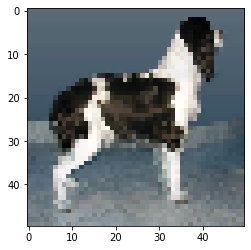

ACTUAL: tensor(1)
PREDICTED: tensor(1)

56


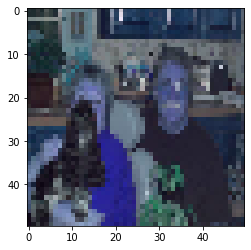

ACTUAL: tensor(1)
PREDICTED: tensor(0)

57


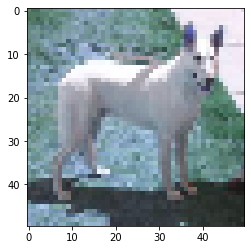

ACTUAL: tensor(1)
PREDICTED: tensor(1)

58


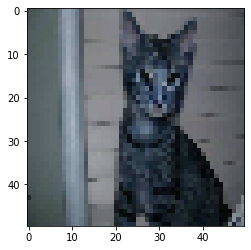

ACTUAL: tensor(0)
PREDICTED: tensor(0)

59


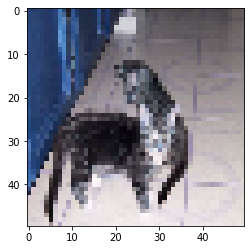

ACTUAL: tensor(0)
PREDICTED: tensor(0)

60


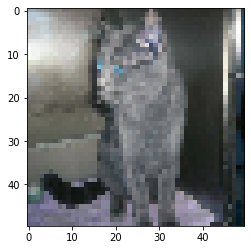

ACTUAL: tensor(0)
PREDICTED: tensor(0)

61


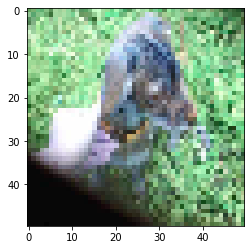

ACTUAL: tensor(1)
PREDICTED: tensor(1)

62


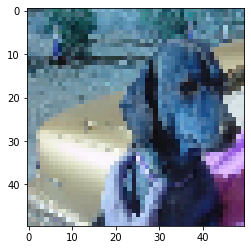

ACTUAL: tensor(1)
PREDICTED: tensor(1)

63


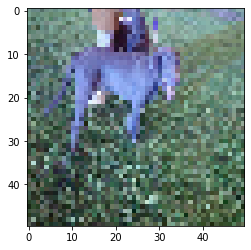

ACTUAL: tensor(1)
PREDICTED: tensor(1)

64


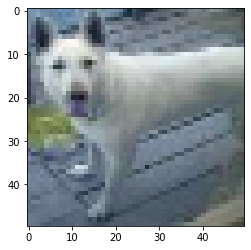

ACTUAL: tensor(1)
PREDICTED: tensor(0)

65


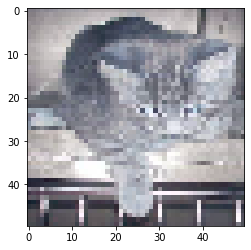

ACTUAL: tensor(0)
PREDICTED: tensor(0)

66


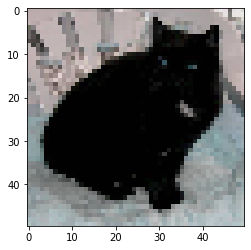

ACTUAL: tensor(0)
PREDICTED: tensor(0)

67


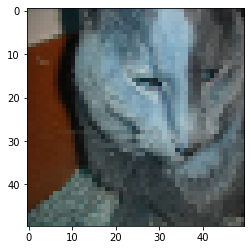

ACTUAL: tensor(0)
PREDICTED: tensor(1)

68


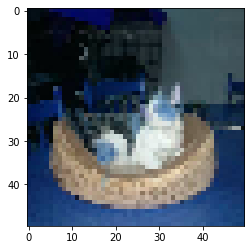

ACTUAL: tensor(0)
PREDICTED: tensor(0)

69


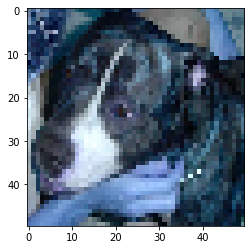

ACTUAL: tensor(1)
PREDICTED: tensor(1)

70


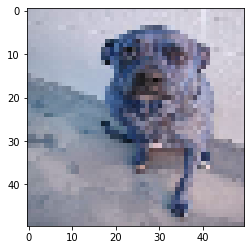

ACTUAL: tensor(1)
PREDICTED: tensor(1)

71


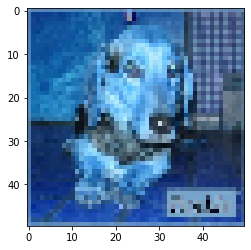

ACTUAL: tensor(1)
PREDICTED: tensor(1)

72


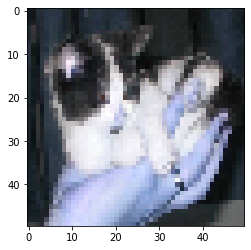

ACTUAL: tensor(0)
PREDICTED: tensor(0)

73


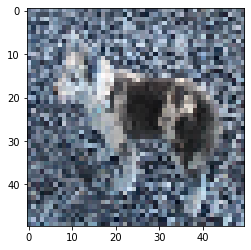

ACTUAL: tensor(1)
PREDICTED: tensor(1)

74


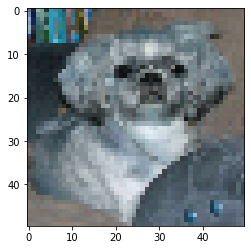

ACTUAL: tensor(1)
PREDICTED: tensor(1)

75


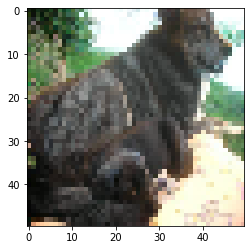

ACTUAL: tensor(1)
PREDICTED: tensor(0)

76


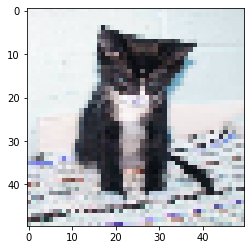

ACTUAL: tensor(0)
PREDICTED: tensor(0)

77


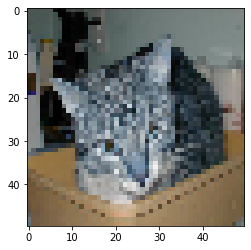

ACTUAL: tensor(0)
PREDICTED: tensor(0)

78


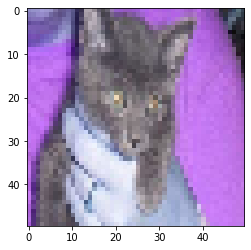

ACTUAL: tensor(0)
PREDICTED: tensor(0)

79


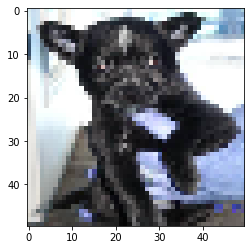

ACTUAL: tensor(1)
PREDICTED: tensor(1)

80


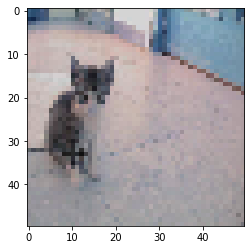

ACTUAL: tensor(0)
PREDICTED: tensor(0)

81


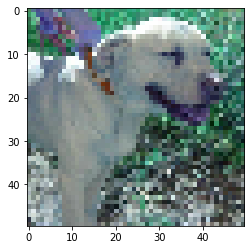

ACTUAL: tensor(1)
PREDICTED: tensor(1)

82


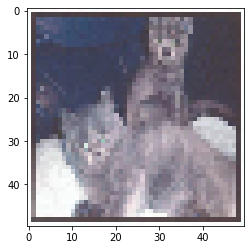

ACTUAL: tensor(0)
PREDICTED: tensor(0)

83


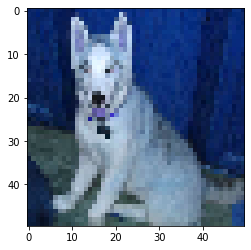

ACTUAL: tensor(1)
PREDICTED: tensor(0)

84


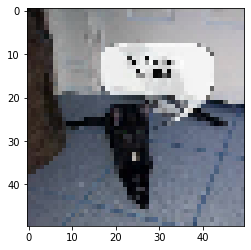

ACTUAL: tensor(0)
PREDICTED: tensor(0)

85


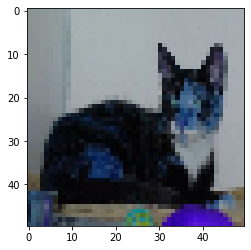

ACTUAL: tensor(0)
PREDICTED: tensor(0)

86


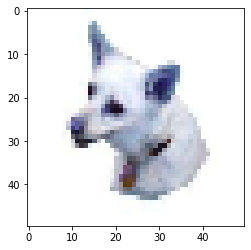

ACTUAL: tensor(1)
PREDICTED: tensor(1)

87


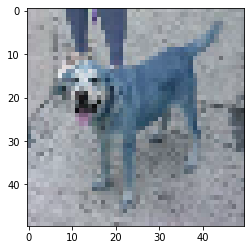

ACTUAL: tensor(1)
PREDICTED: tensor(0)

88


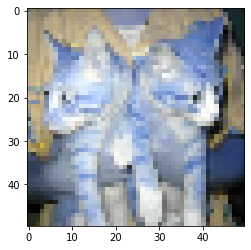

ACTUAL: tensor(0)
PREDICTED: tensor(0)

89


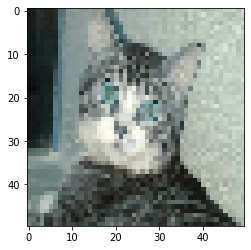

ACTUAL: tensor(0)
PREDICTED: tensor(0)

90


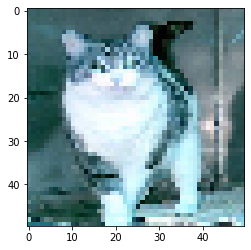

ACTUAL: tensor(0)
PREDICTED: tensor(0)

91


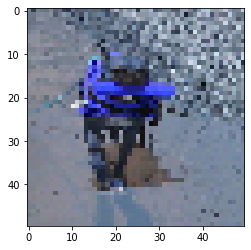

ACTUAL: tensor(1)
PREDICTED: tensor(1)

92


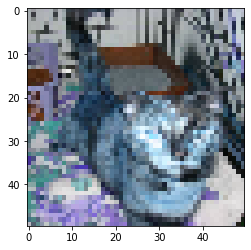

ACTUAL: tensor(0)
PREDICTED: tensor(0)

93


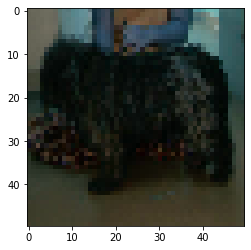

ACTUAL: tensor(1)
PREDICTED: tensor(0)

94


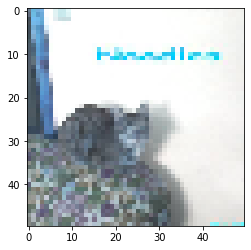

ACTUAL: tensor(0)
PREDICTED: tensor(0)

95


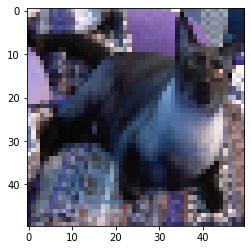

ACTUAL: tensor(0)
PREDICTED: tensor(0)

96


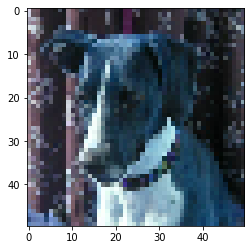

ACTUAL: tensor(1)
PREDICTED: tensor(1)

97


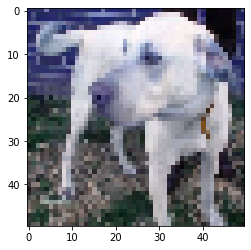

ACTUAL: tensor(1)
PREDICTED: tensor(1)

98


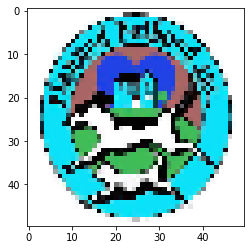

ACTUAL: tensor(0)
PREDICTED: tensor(1)

99


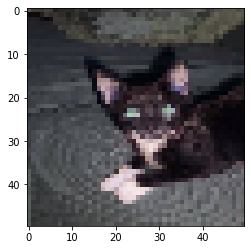

ACTUAL: tensor(0)
PREDICTED: tensor(1)


In [54]:
n=0
for n in range(0,100):
    print()
    print(n)
    plt.imshow(test_X[n].permute(2,1,0))
    plt.show()
    print("ACTUAL: "+str(torch.argmax(test_y[n])))
    net_out= net(test_X[n].view(-1,3,50,50))[0]
    print("PREDICTED: "+str(torch.argmax(net_out)))

In [14]:
print(" Accuracy:"+str( accuracy()*100)+" %")

100%|██████████| 200/200 [00:01<00:00, 112.88it/s]

 Accuracy:70.5 %


tensor([[[0.3421, 0.4285],
         [0.5449, 0.0586],
         [0.7160, 0.4318],
         [0.8867, 0.8614]],

        [[0.2562, 0.4060],
         [0.7706, 0.2454],
         [0.6886, 0.8031],
         [0.5500, 0.6987]],

        [[0.5018, 0.4217],
         [0.2804, 0.8453],
         [0.9309, 0.2021],
         [0.4184, 0.9506]],

        [[0.2780, 0.1127],
         [0.5653, 0.8645],
         [0.7310, 0.6602],
         [0.4616, 0.2485]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 5, 5])
0


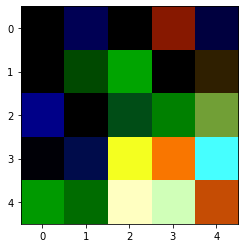

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


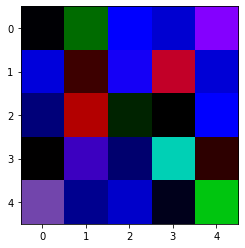

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


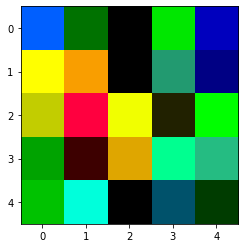

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


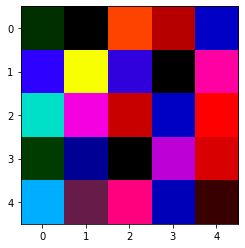

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


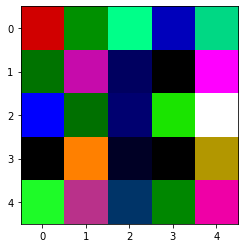

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


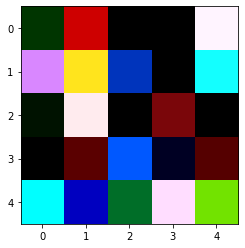

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


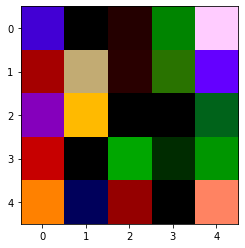

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


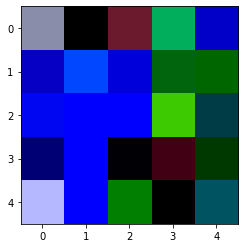

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


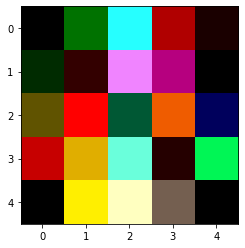

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


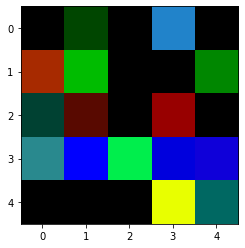

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


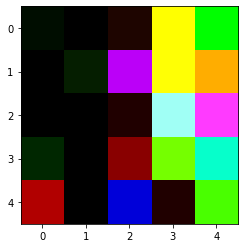

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


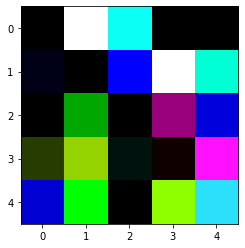

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


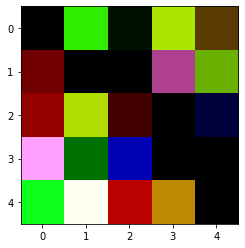

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


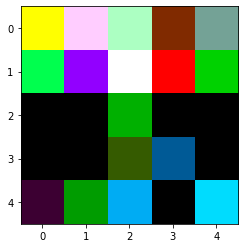

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


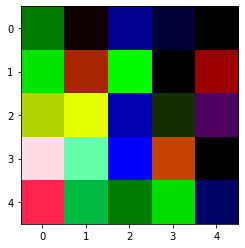

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


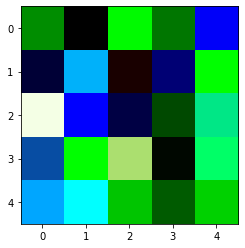

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


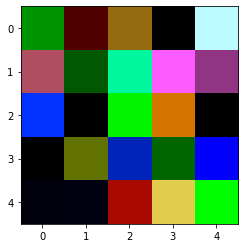

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


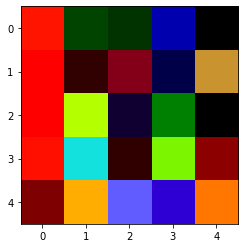

18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


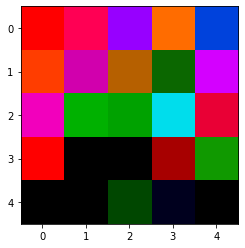

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


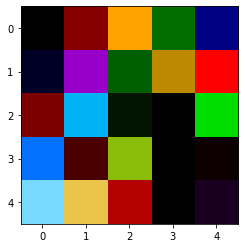

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


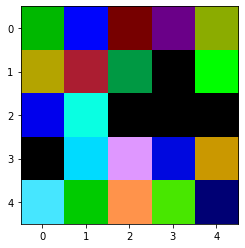

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


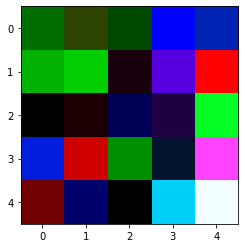

22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


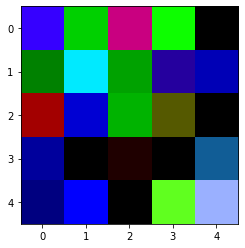

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23


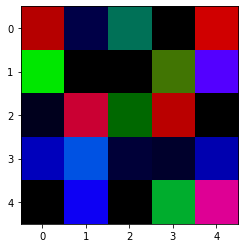

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


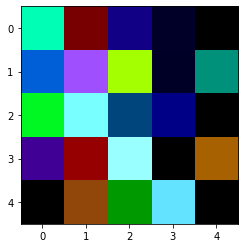

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


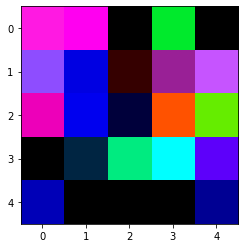

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


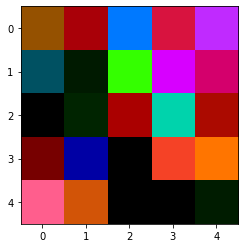

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27


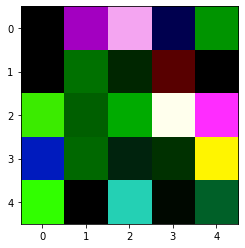

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


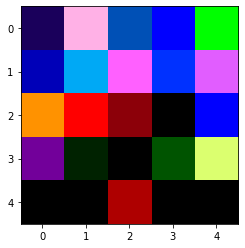

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


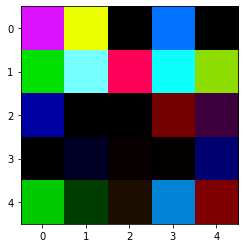

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


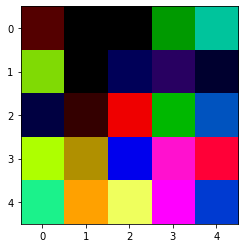

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31


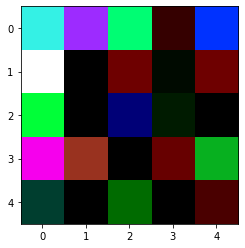

In [51]:
print(net.conv1.weight.shape)
import matplotlib.pyplot as plt
for i in range(0,net.conv1.weight.shape[0]):
    print(i)
    plt.imshow(net.conv1.weight[i].detach().permute(2,1,0)*10)
    plt.show()

torch.Size([64, 32, 5, 5])
0 0


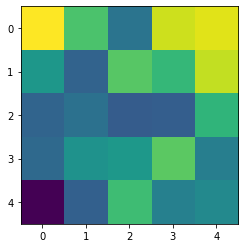

0 1


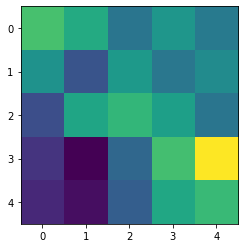

0 2


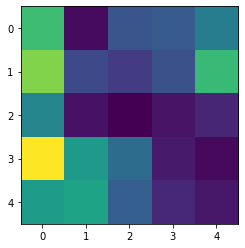

0 3


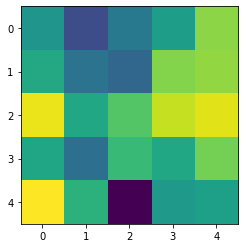

0 4


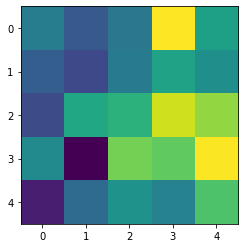

0 5


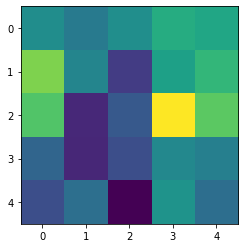

0 6


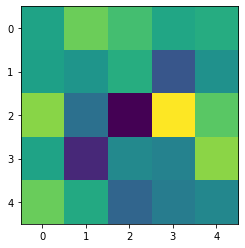

0 7


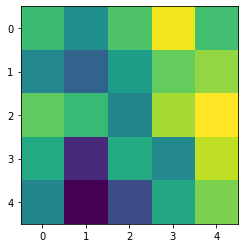

0 8


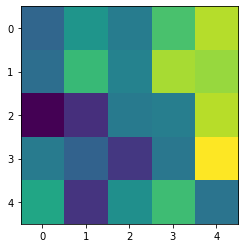

0 9


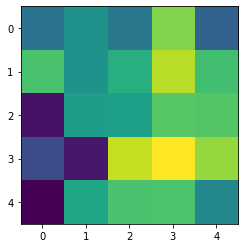

0 10


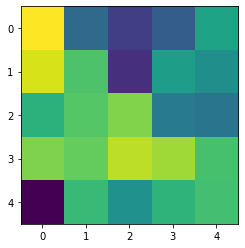

0 11


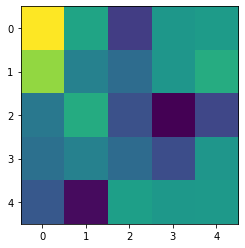

0 12


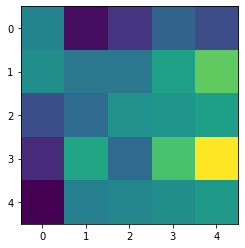

0 13


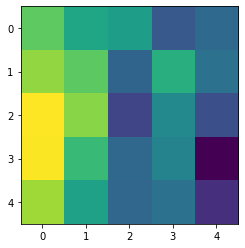

0 14


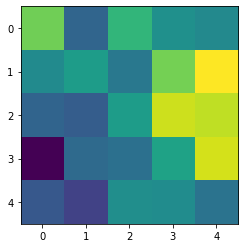

0 15


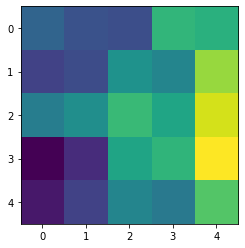

0 16


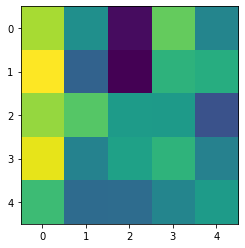

0 17


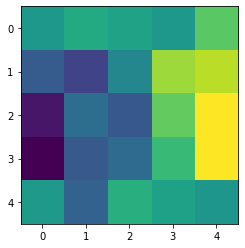

0 18


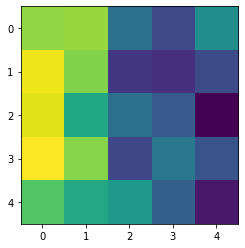

0 19


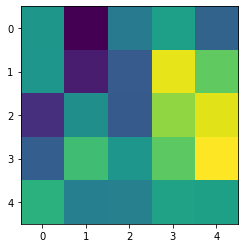

0 20


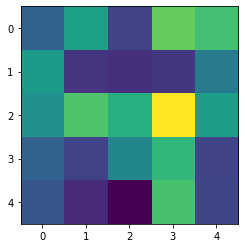

0 21


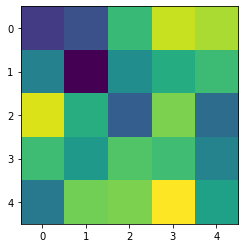

0 22


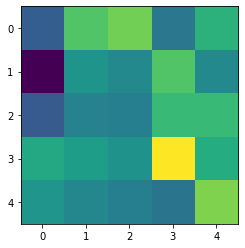

0 23


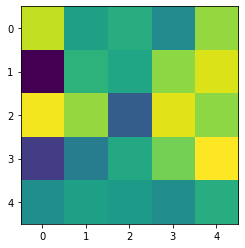

0 24


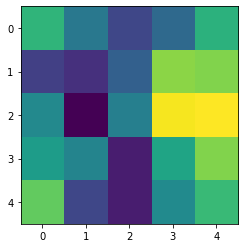

0 25


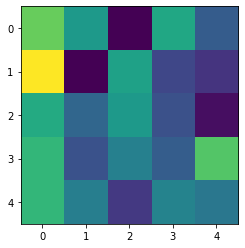

0 26


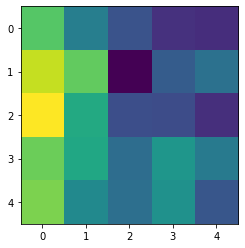

0 27


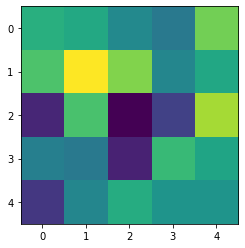

0 28


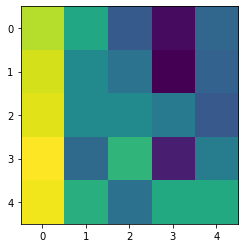

0 29


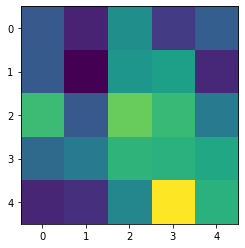

0 30


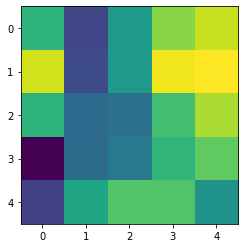

0 31


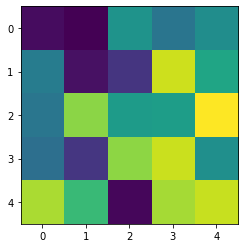

1 0


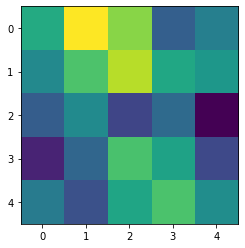

1 1


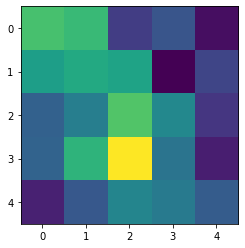

1 2


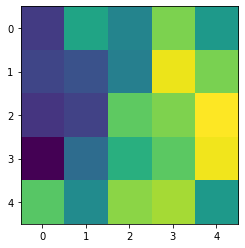

1 3


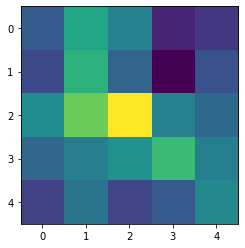

1 4


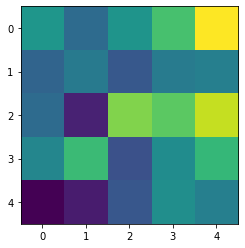

1 5


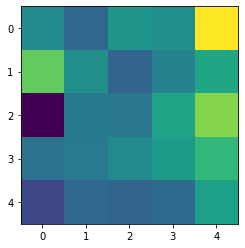

1 6


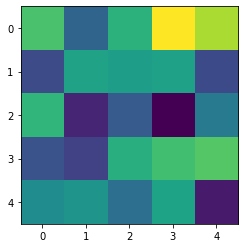

1 7


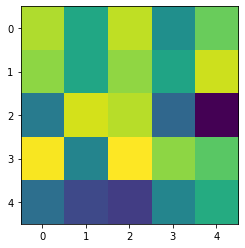

1 8


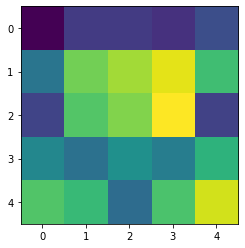

1 9


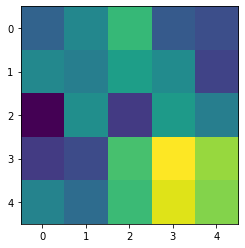

1 10


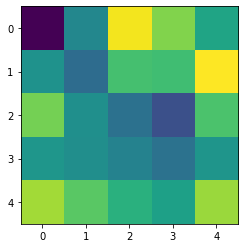

1 11


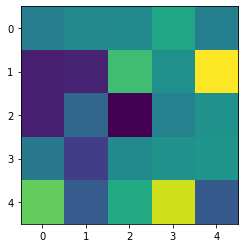

1 12


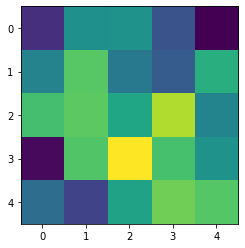

1 13


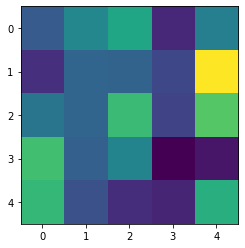

1 14


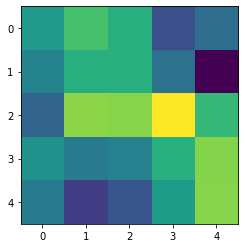

1 15


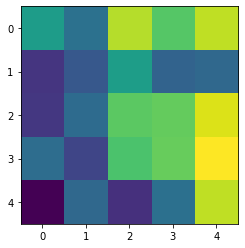

1 16


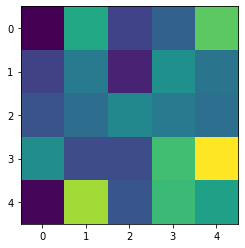

1 17


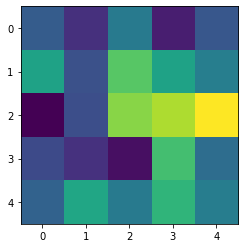

1 18


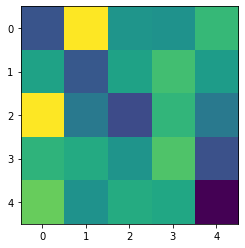

1 19


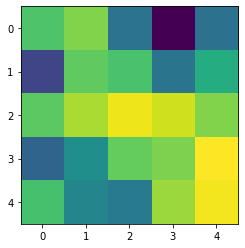

1 20


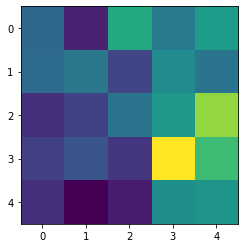

1 21


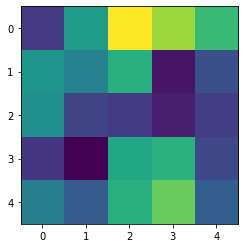

1 22


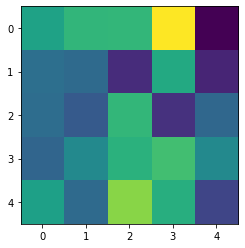

1 23


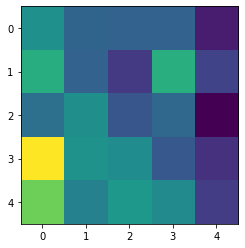

1 24


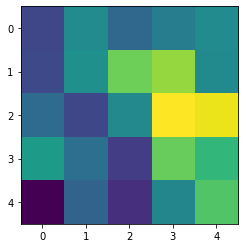

1 25


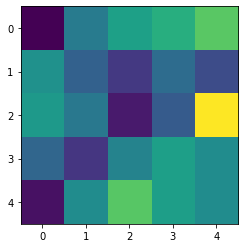

1 26


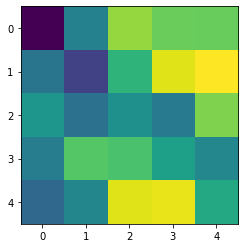

1 27


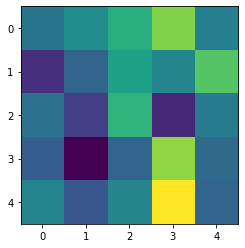

1 28


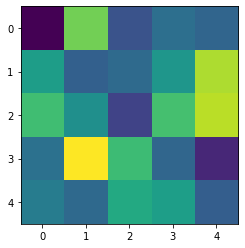

1 29


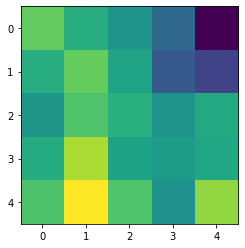

1 30


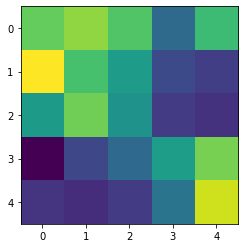

1 31


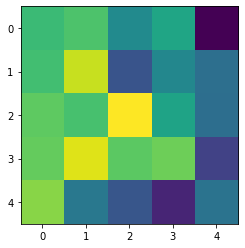

2 0


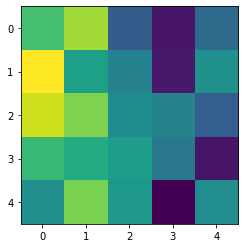

2 1


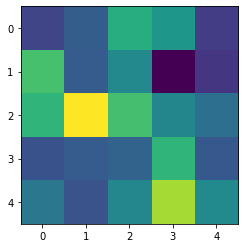

2 2


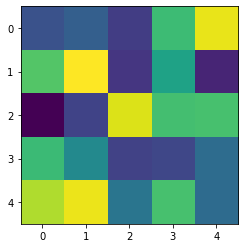

2 3


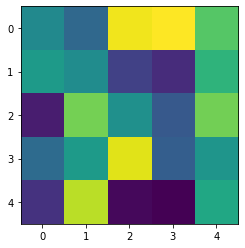

2 4


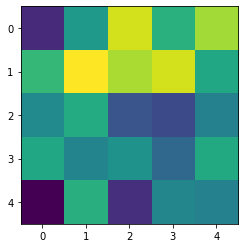

2 5


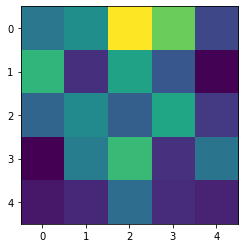

2 6


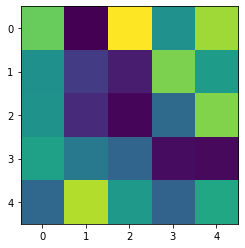

2 7


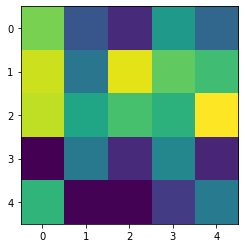

2 8


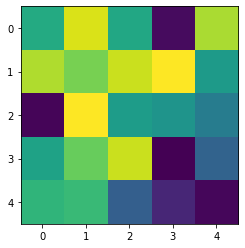

2 9


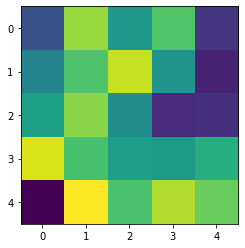

2 10


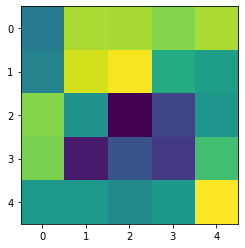

2 11


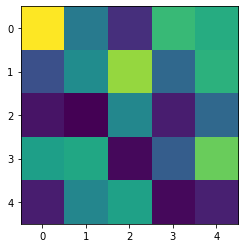

2 12


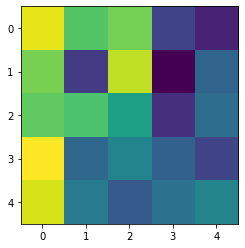

2 13


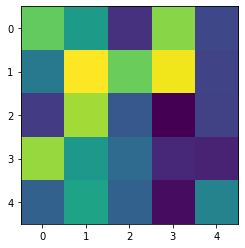

2 14


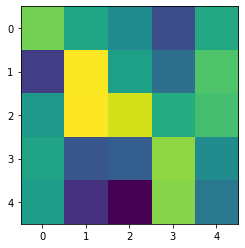

2 15


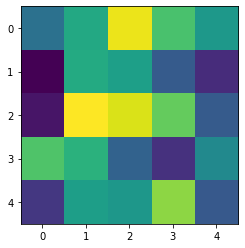

2 16


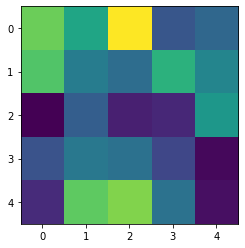

2 17


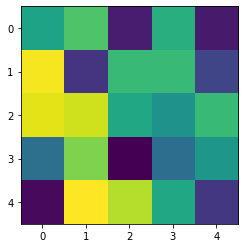

2 18


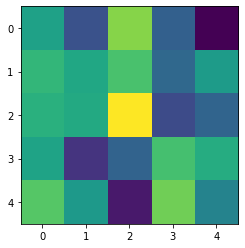

2 19


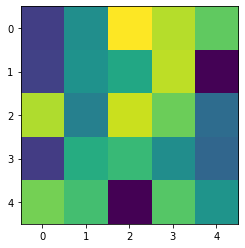

2 20


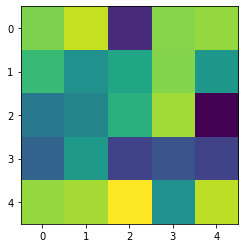

2 21


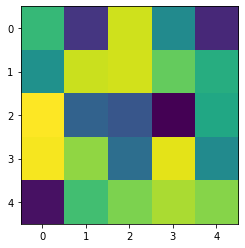

2 22


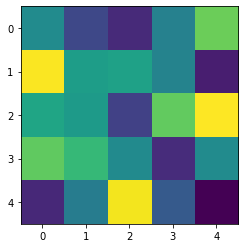

2 23


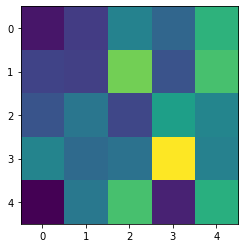

2 24


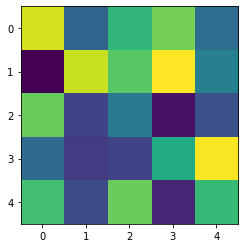

2 25


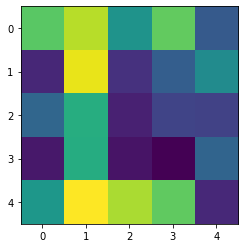

2 26


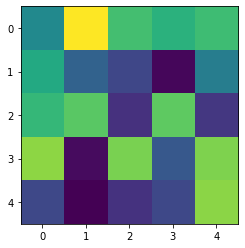

2 27


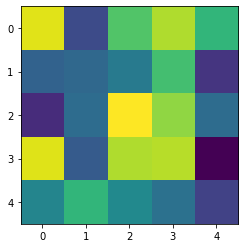

2 28


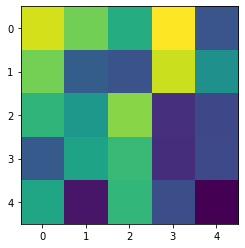

2 29


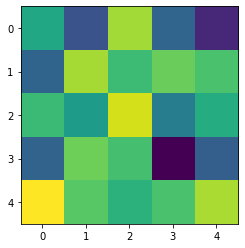

2 30


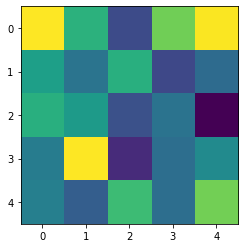

2 31


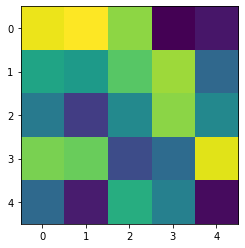

3 0


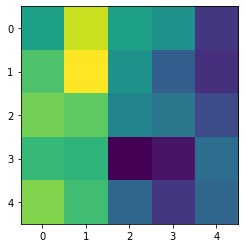

3 1


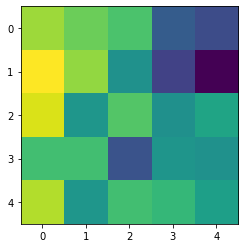

3 2


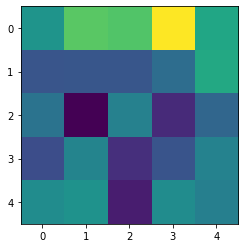

3 3


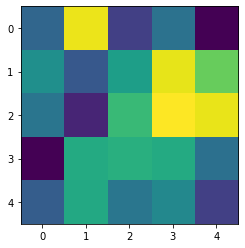

3 4


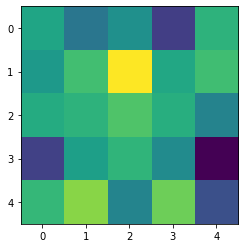

3 5


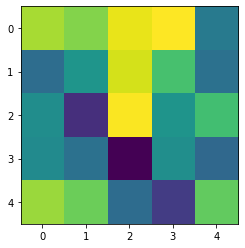

3 6


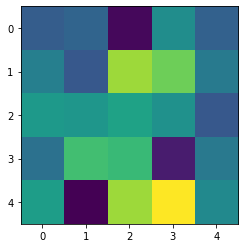

3 7


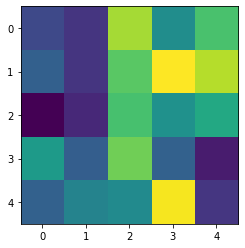

3 8


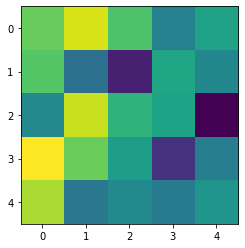

3 9


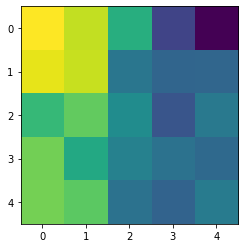

3 10


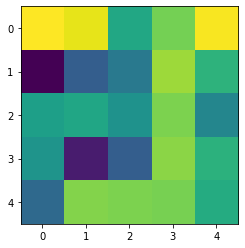

3 11


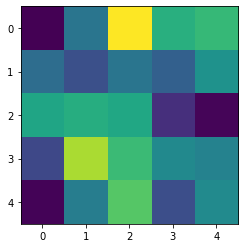

3 12


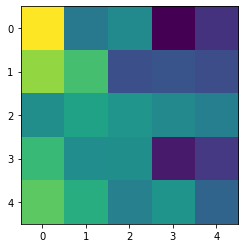

3 13


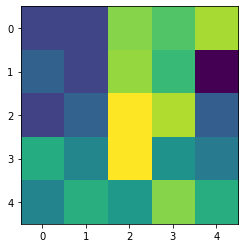

3 14


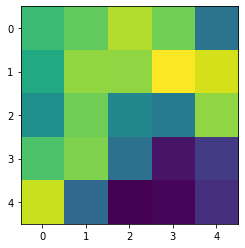

3 15


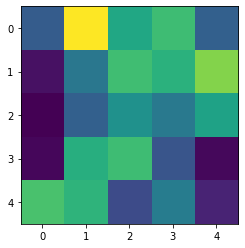

3 16


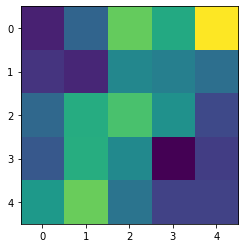

3 17


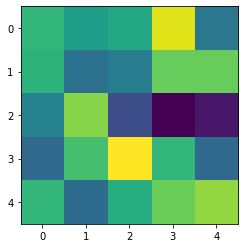

3 18


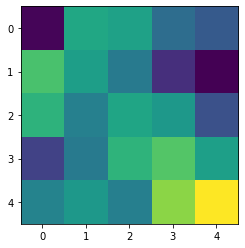

3 19


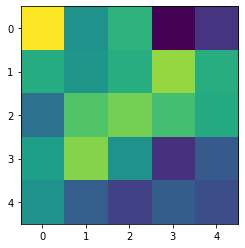

3 20


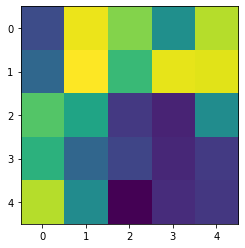

3 21


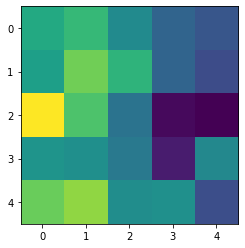

3 22


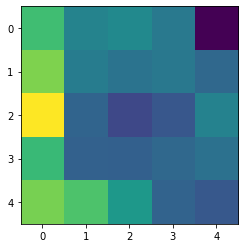

3 23


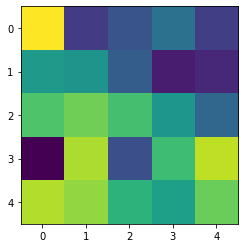

3 24


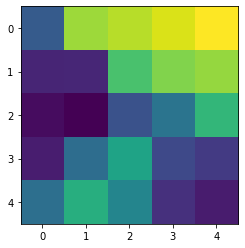

3 25


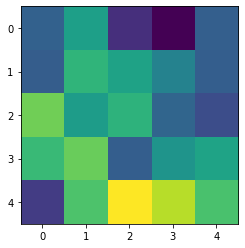

3 26


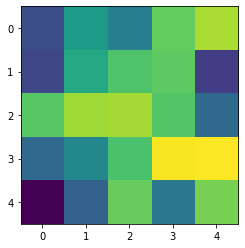

3 27


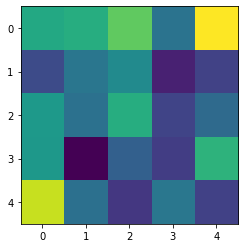

3 28


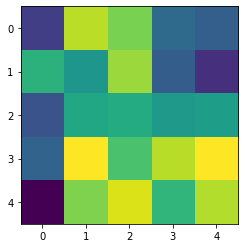

3 29


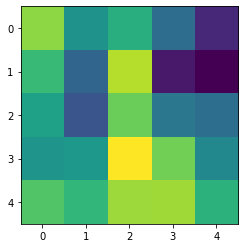

3 30


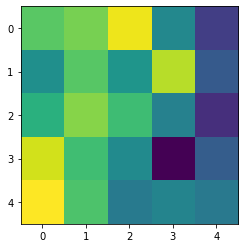

3 31


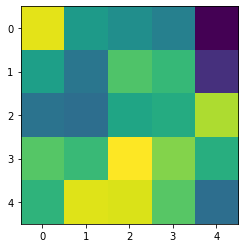

4 0


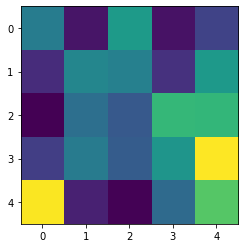

4 1


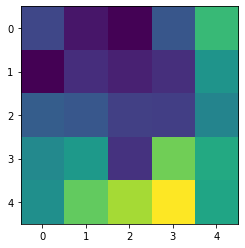

4 2


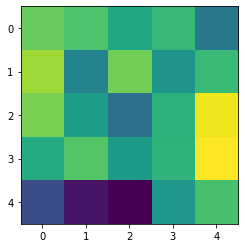

4 3


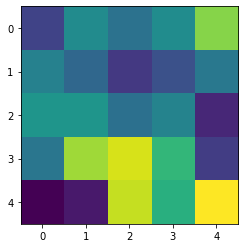

4 4


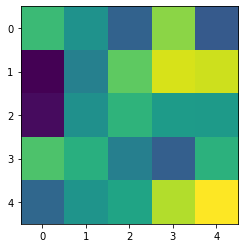

4 5


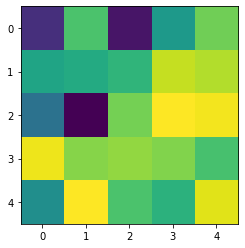

4 6


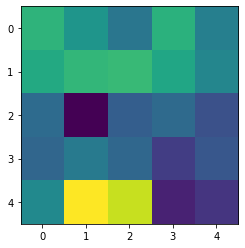

4 7


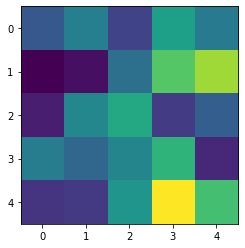

4 8


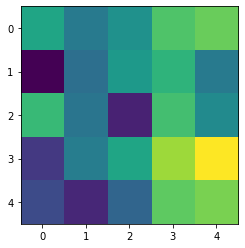

4 9


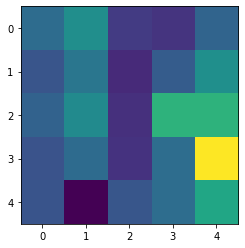

4 10


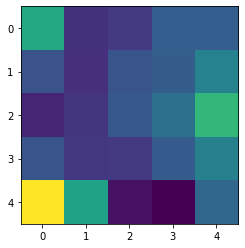

4 11


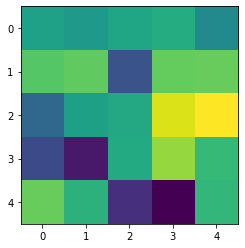

4 12


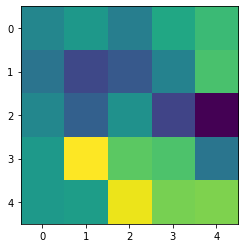

4 13


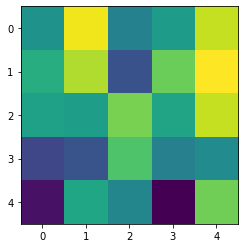

4 14


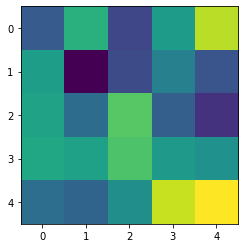

4 15


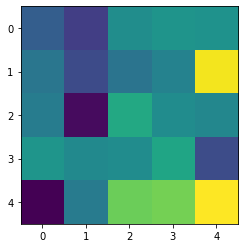

4 16


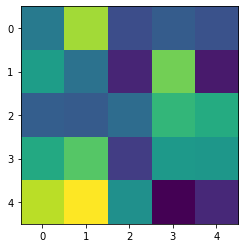

4 17


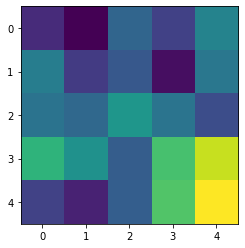

4 18


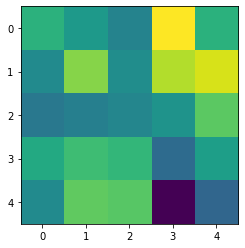

4 19


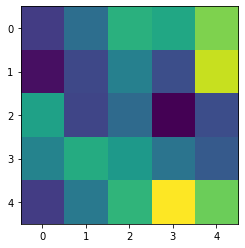

4 20


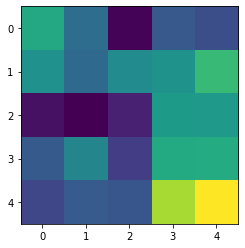

4 21


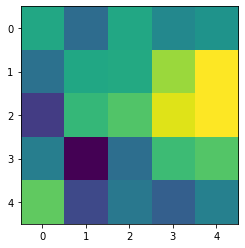

4 22


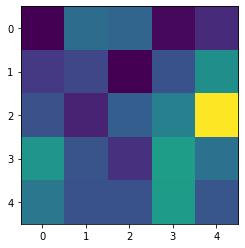

4 23


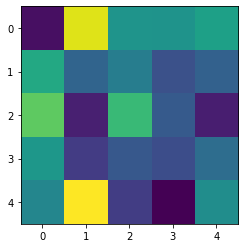

4 24


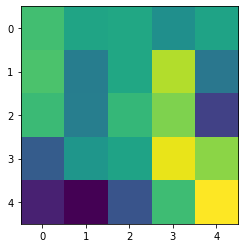

4 25


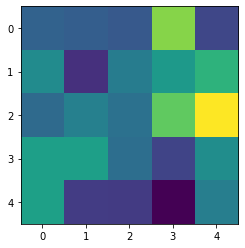

4 26


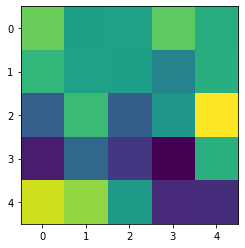

4 27


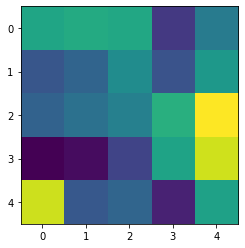

4 28


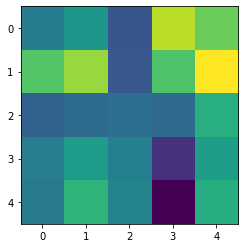

4 29


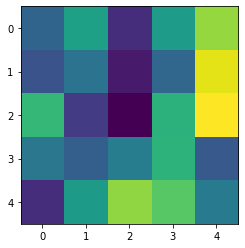

4 30


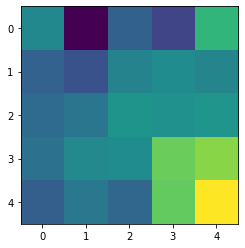

4 31


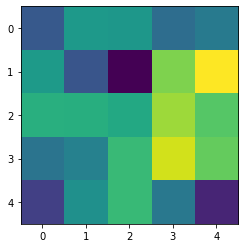

5 0


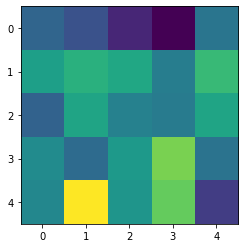

5 1


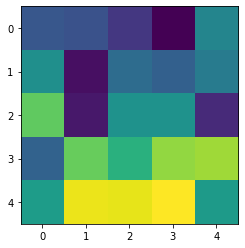

5 2


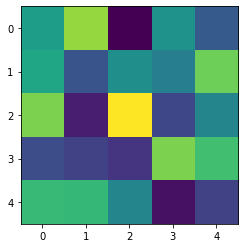

5 3


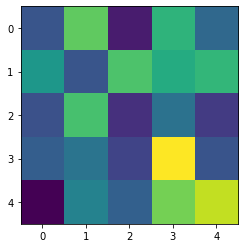

5 4


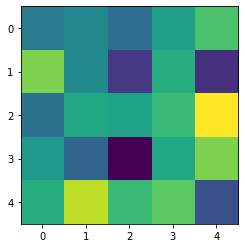

5 5


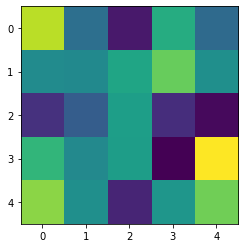

5 6


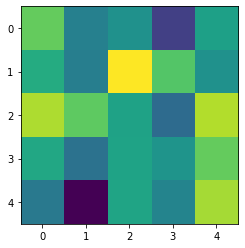

5 7


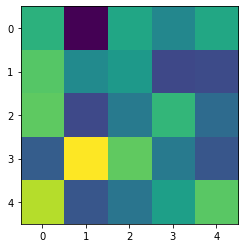

5 8


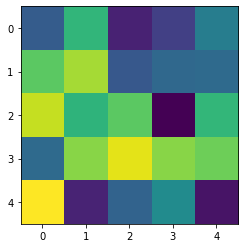

5 9


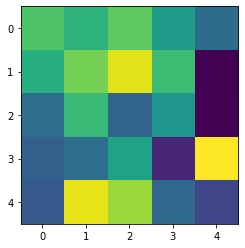

5 10


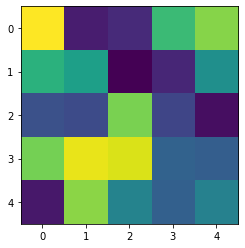

5 11


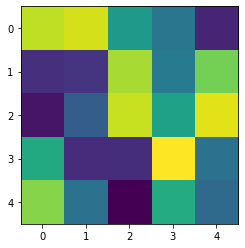

5 12


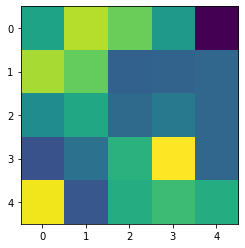

5 13


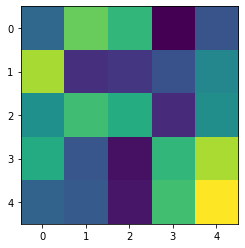

5 14


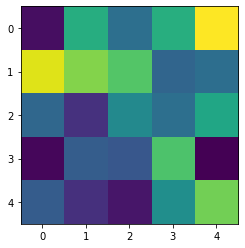

5 15


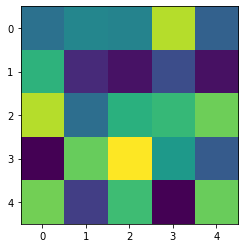

5 16


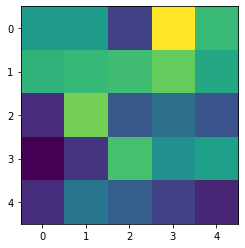

5 17


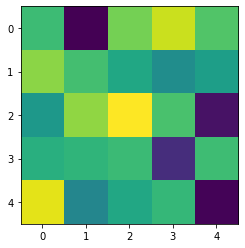

5 18


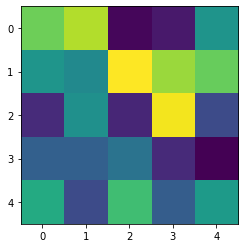

5 19


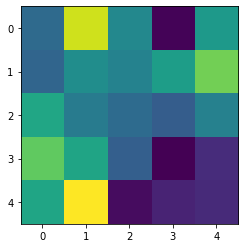

5 20


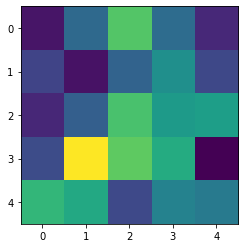

5 21


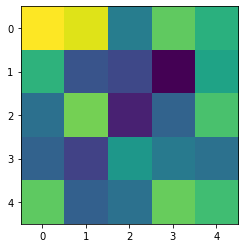

5 22


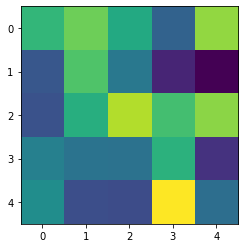

5 23


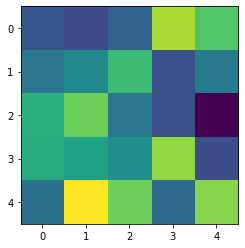

5 24


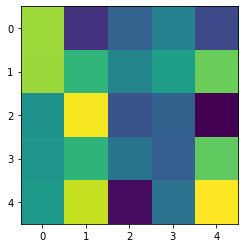

5 25


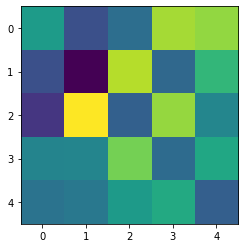

5 26


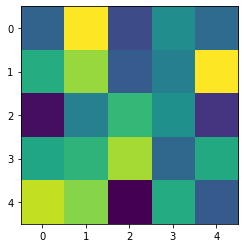

5 27


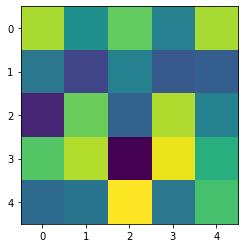

5 28


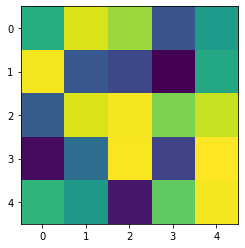

5 29


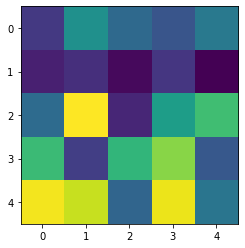

5 30


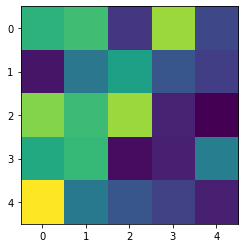

5 31


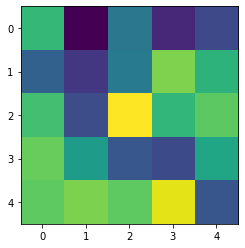

6 0


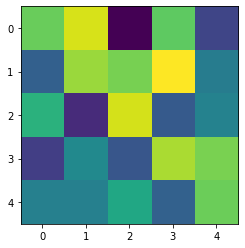

6 1


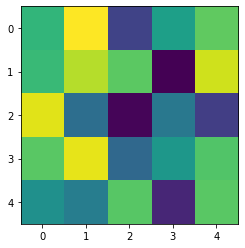

6 2


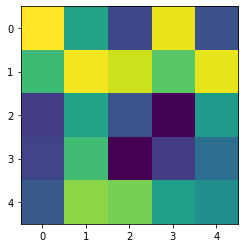

6 3


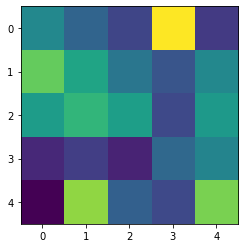

6 4


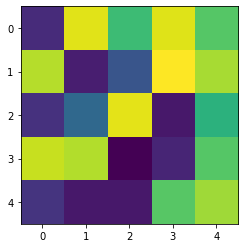

6 5


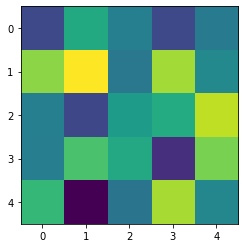

6 6


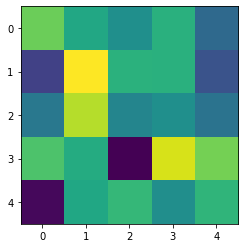

6 7


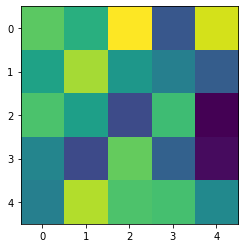

6 8


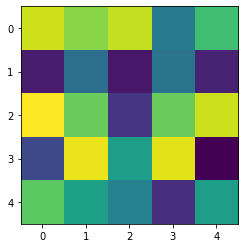

6 9


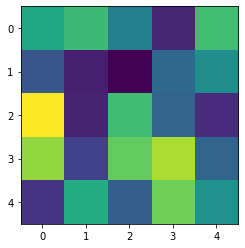

6 10


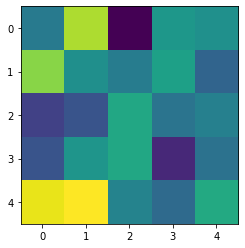

6 11


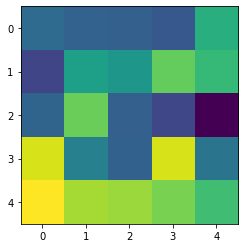

6 12


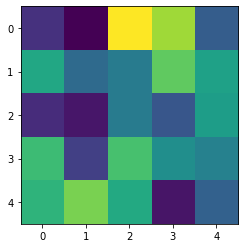

6 13


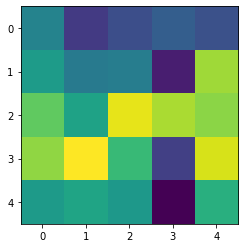

6 14


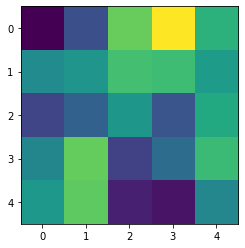

6 15


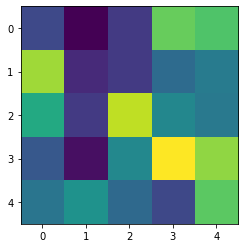

6 16


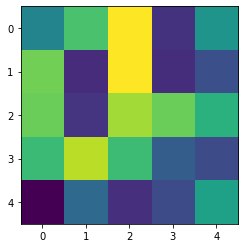

6 17


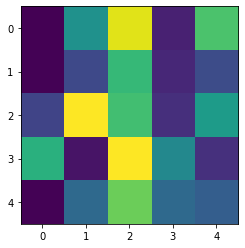

6 18


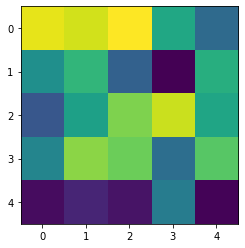

6 19


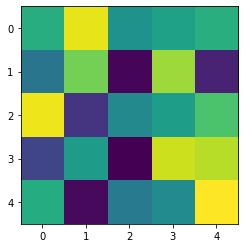

6 20


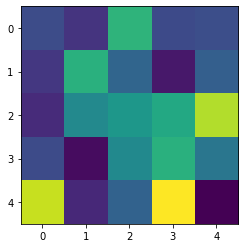

6 21


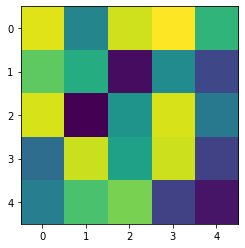

6 22


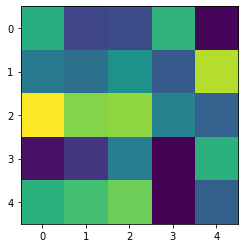

6 23


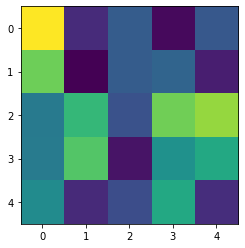

6 24


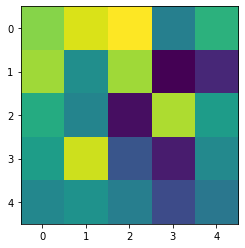

6 25


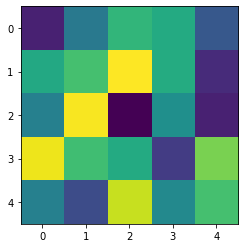

6 26


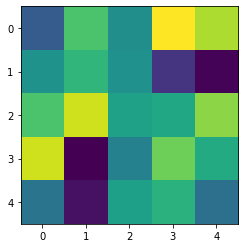

6 27


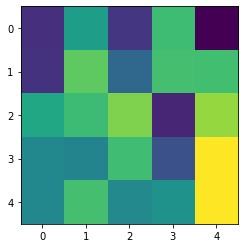

6 28


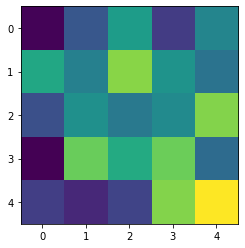

6 29


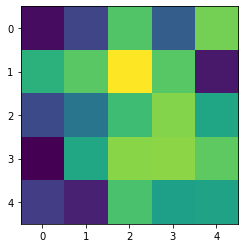

6 30


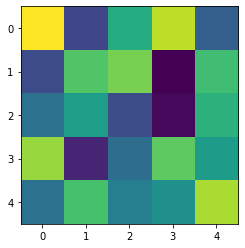

6 31


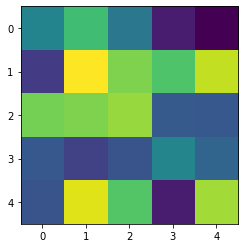

7 0


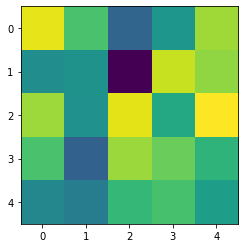

7 1


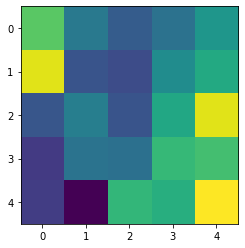

7 2


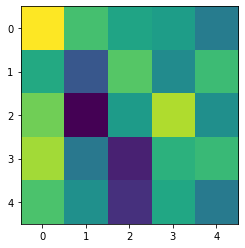

7 3


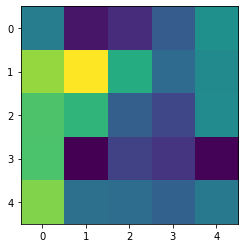

7 4


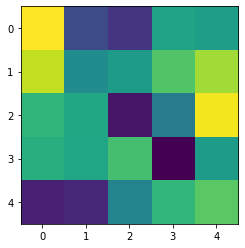

7 5


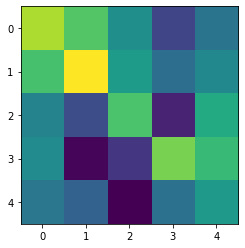

7 6


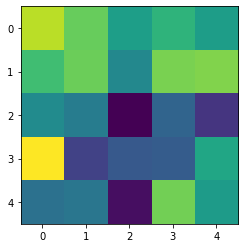

7 7


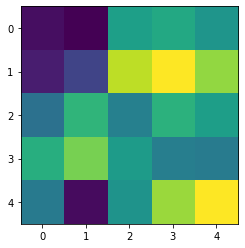

7 8


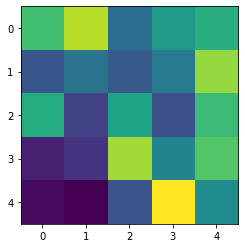

7 9


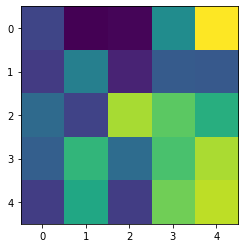

7 10


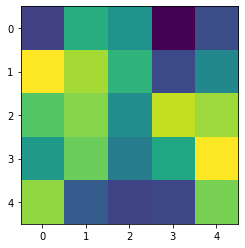

7 11


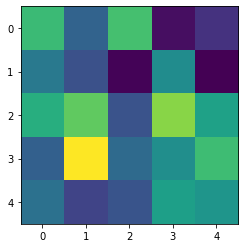

7 12


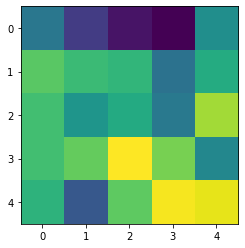

7 13


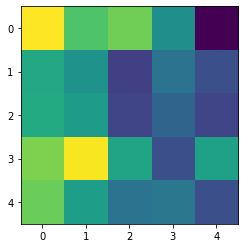

7 14


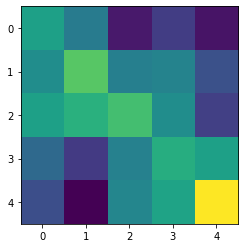

7 15


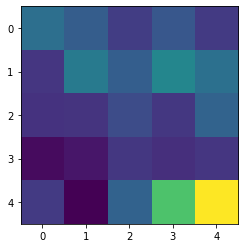

7 16


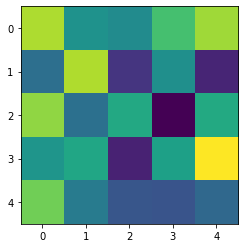

7 17


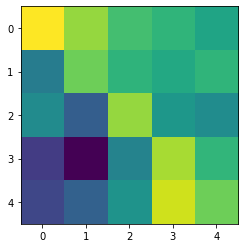

7 18


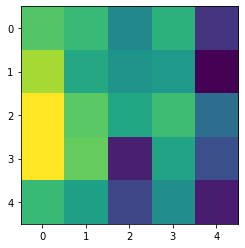

7 19


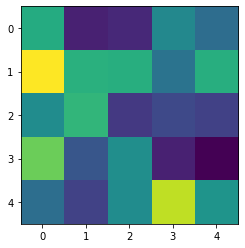

7 20


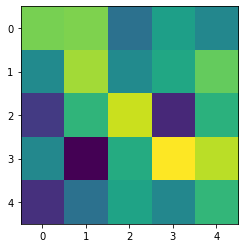

7 21


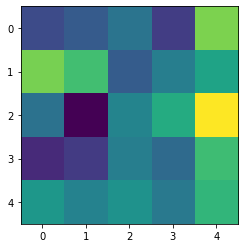

7 22


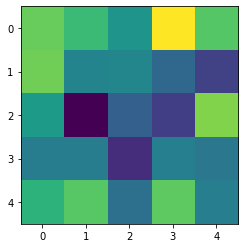

7 23


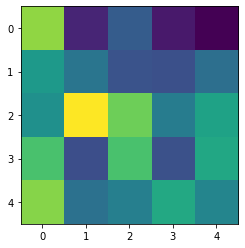

7 24


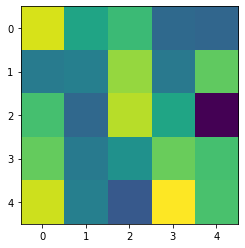

7 25


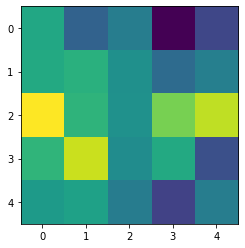

7 26


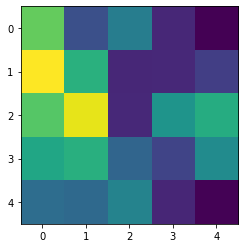

7 27


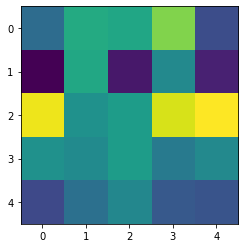

7 28


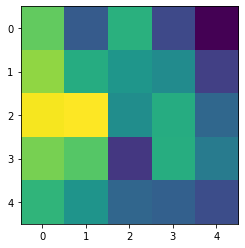

7 29


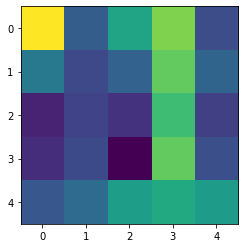

7 30


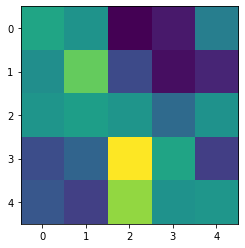

7 31


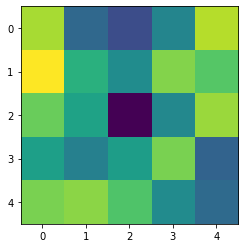

8 0


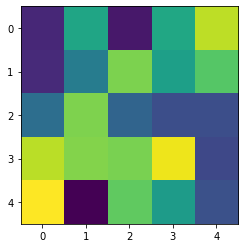

8 1


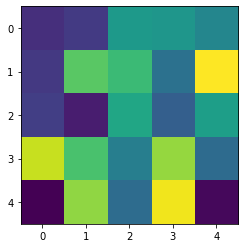

8 2


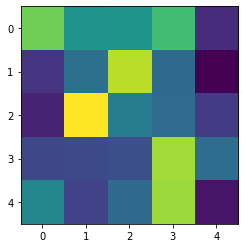

8 3


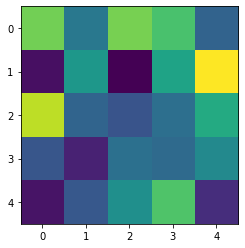

8 4


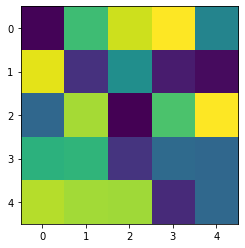

8 5


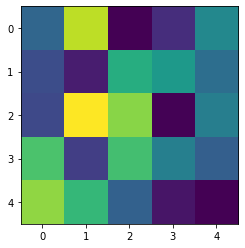

8 6


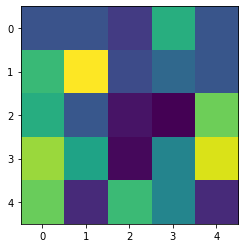

8 7


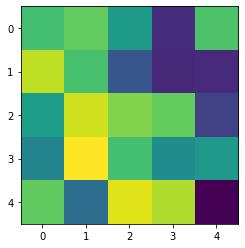

8 8


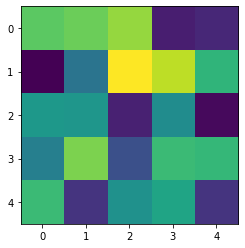

8 9


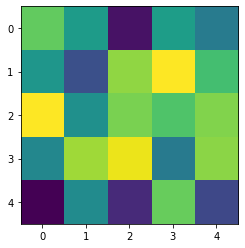

8 10


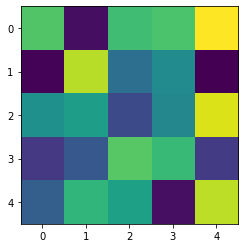

8 11


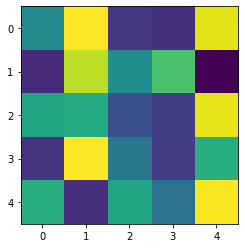

8 12


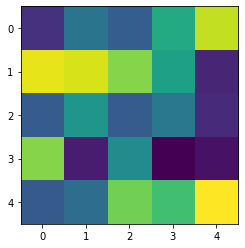

8 13


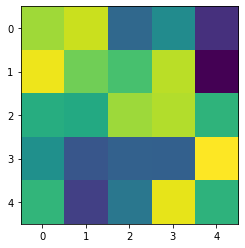

8 14


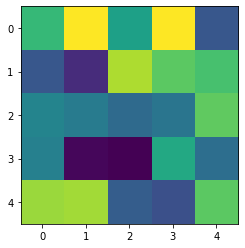

8 15


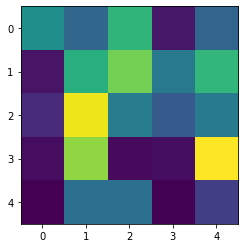

8 16


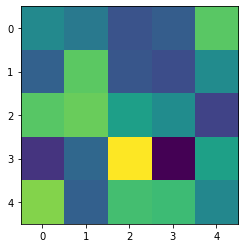

8 17


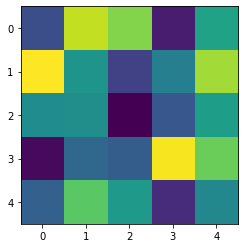

8 18


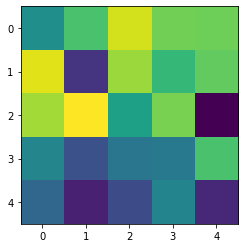

8 19


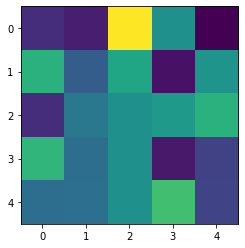

8 20


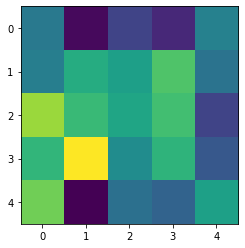

8 21


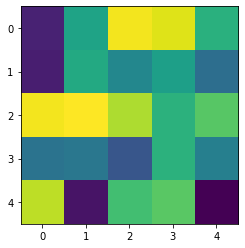

8 22


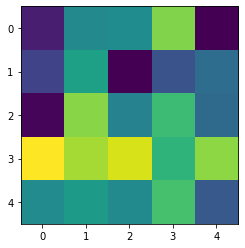

8 23


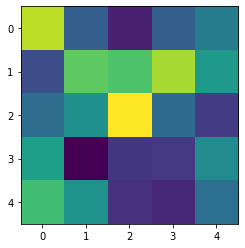

8 24


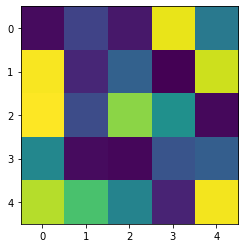

8 25


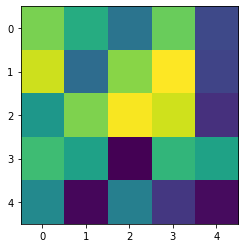

8 26


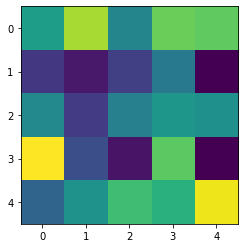

8 27


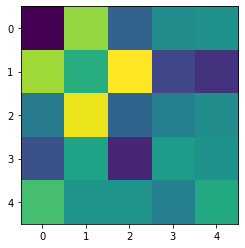

8 28


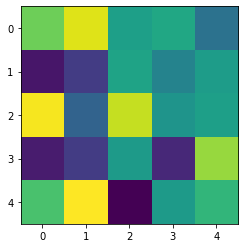

8 29


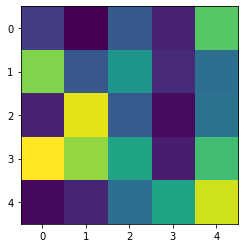

8 30


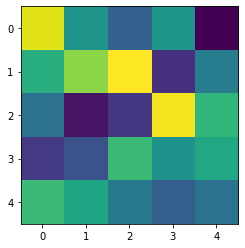

8 31


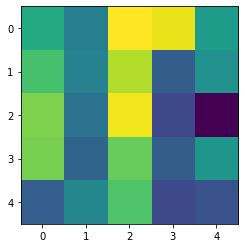

9 0


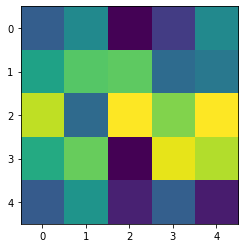

9 1


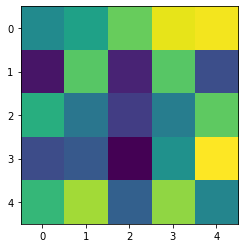

9 2


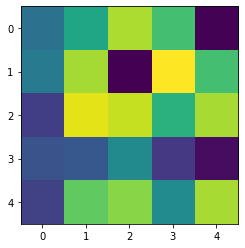

9 3


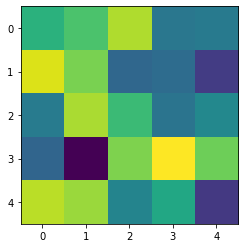

9 4


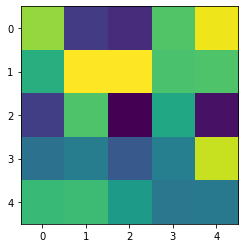

9 5


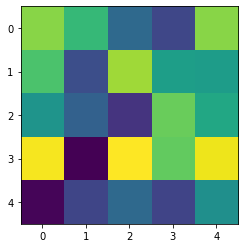

9 6


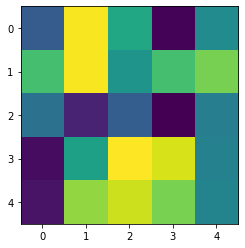

9 7


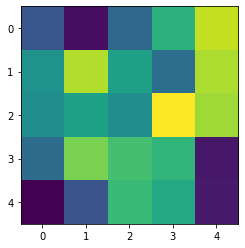

9 8


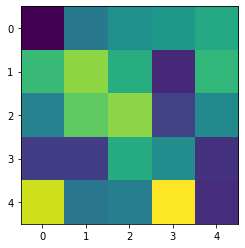

9 9


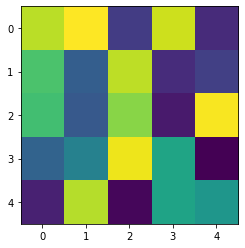

9 10


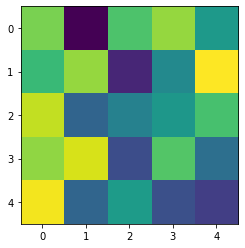

9 11


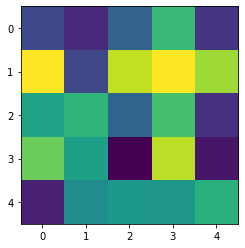

9 12


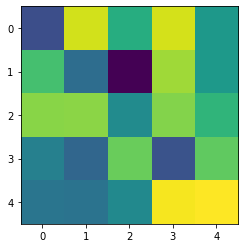

9 13


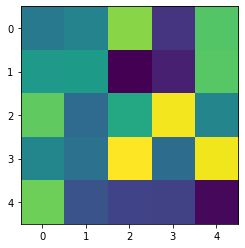

9 14


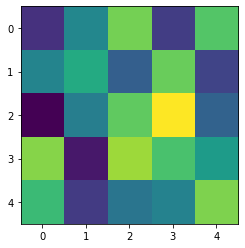

9 15


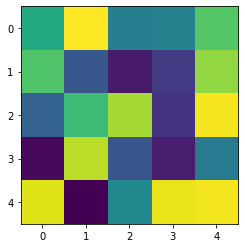

9 16


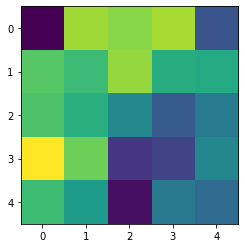

9 17


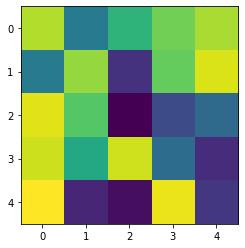

9 18


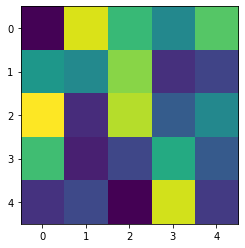

9 19


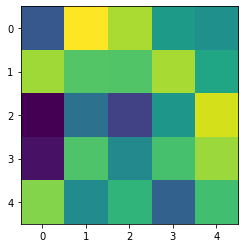

9 20


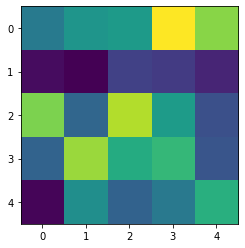

9 21


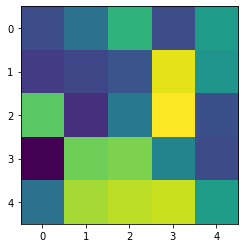

9 22


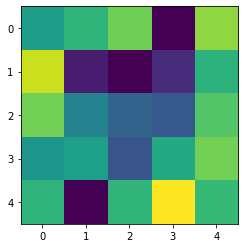

9 23


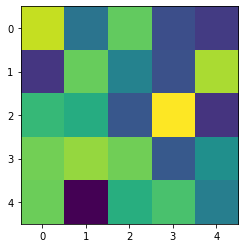

9 24


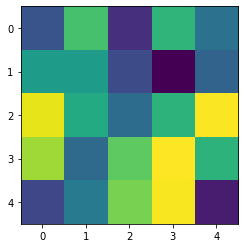

9 25


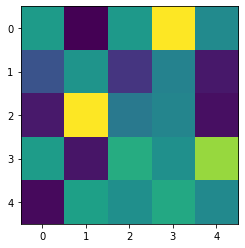

9 26


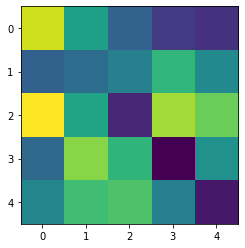

9 27


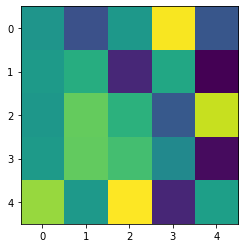

9 28


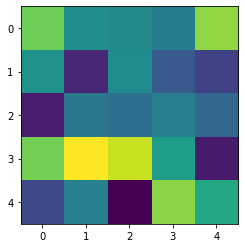

9 29


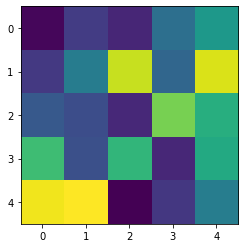

9 30


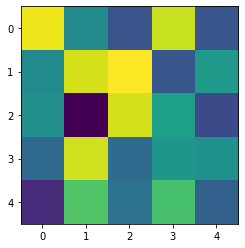

9 31


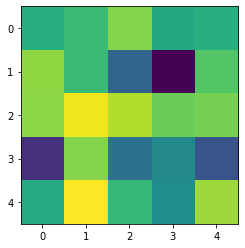

10 0


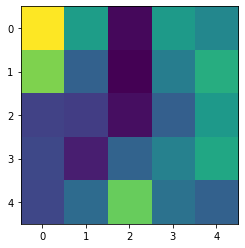

10 1


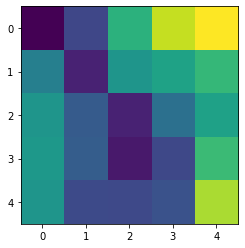

10 2


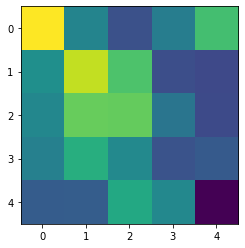

10 3


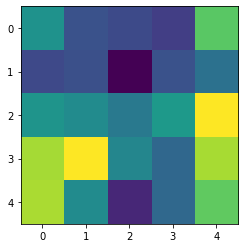

10 4


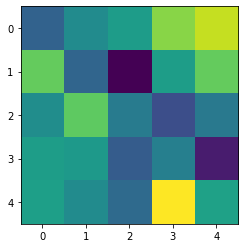

10 5


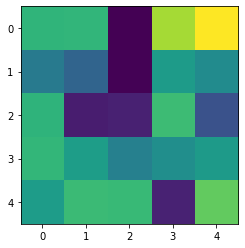

10 6


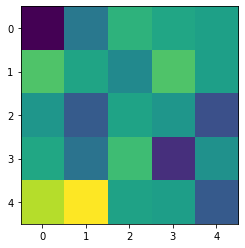

10 7


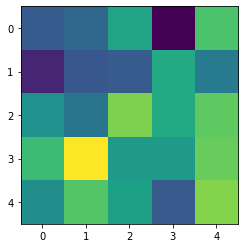

10 8


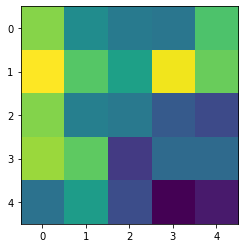

10 9


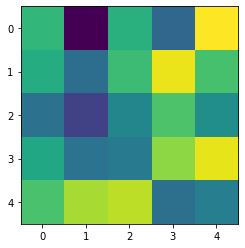

10 10


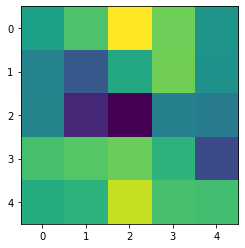

10 11


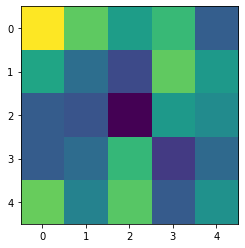

10 12


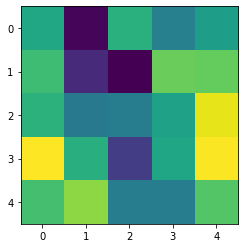

10 13


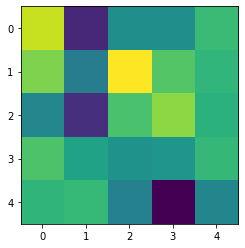

10 14


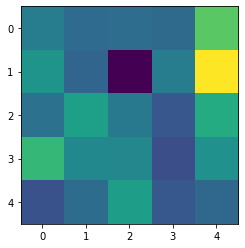

10 15


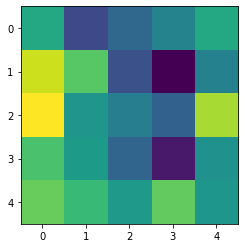

10 16


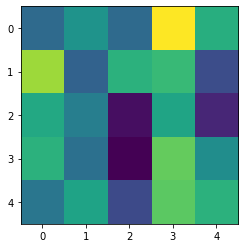

10 17


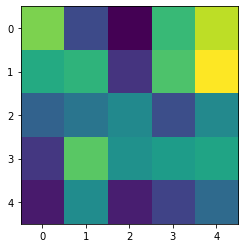

10 18


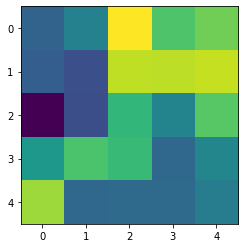

10 19


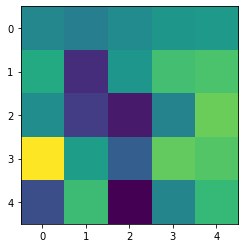

10 20


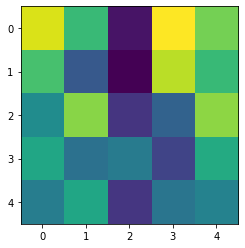

10 21


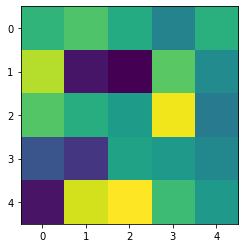

10 22


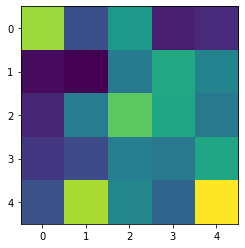

10 23


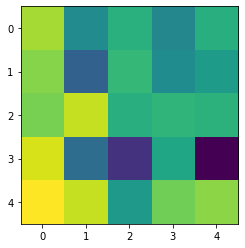

10 24


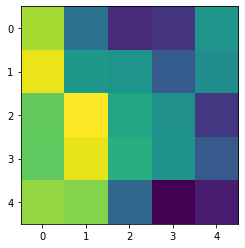

10 25


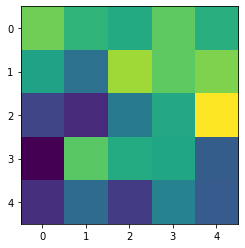

10 26


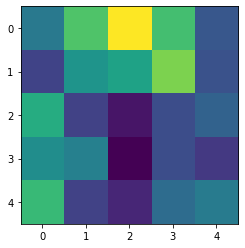

10 27


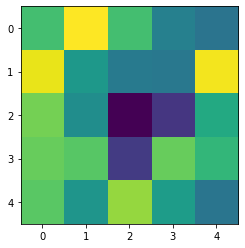

10 28


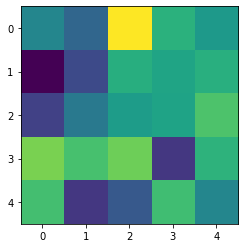

10 29


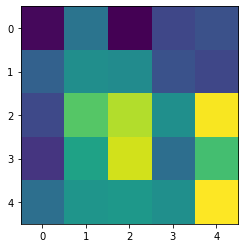

10 30


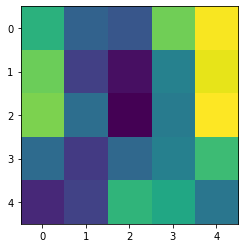

10 31


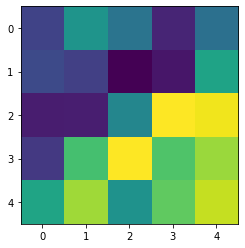

11 0


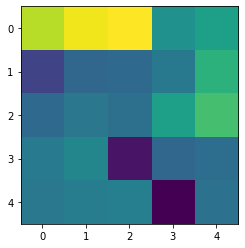

11 1


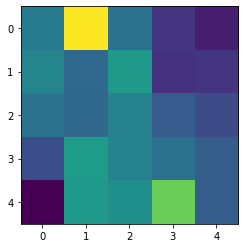

11 2


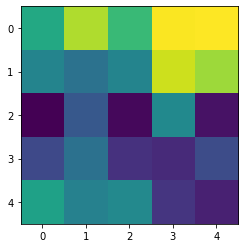

11 3


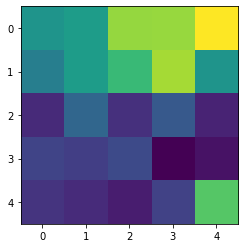

11 4


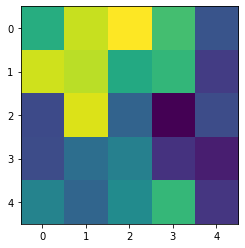

11 5


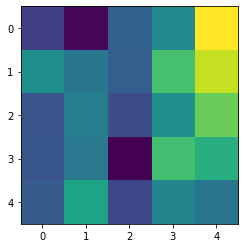

11 6


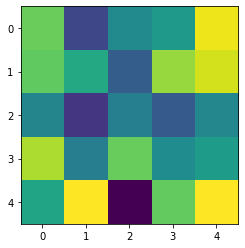

11 7


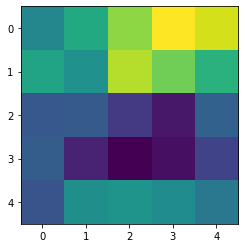

11 8


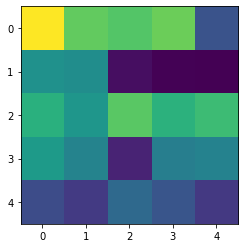

11 9


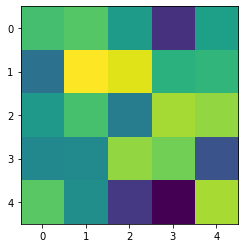

11 10


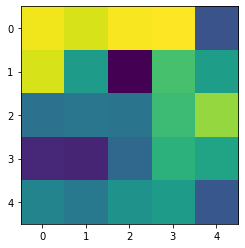

11 11


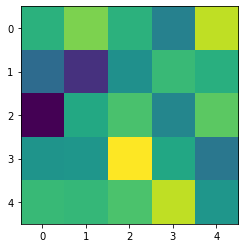

11 12


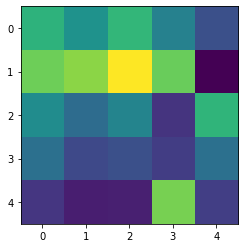

11 13


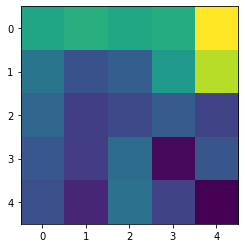

11 14


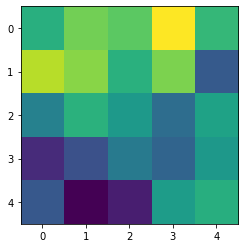

11 15


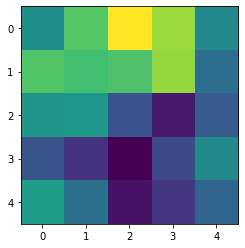

11 16


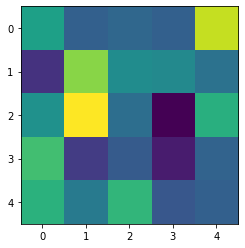

11 17


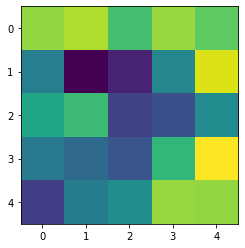

11 18


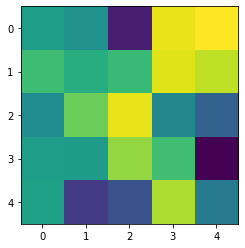

11 19


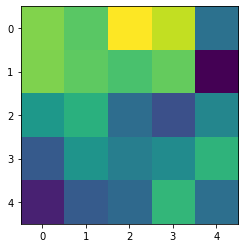

11 20


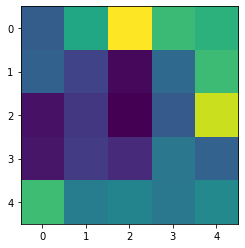

11 21


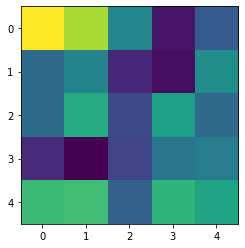

11 22


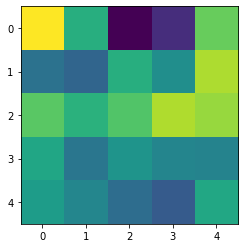

11 23


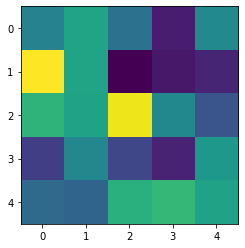

11 24


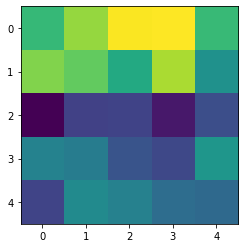

11 25


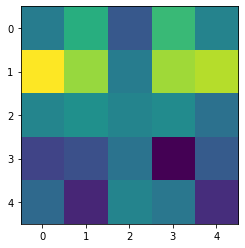

11 26


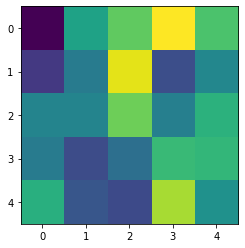

11 27


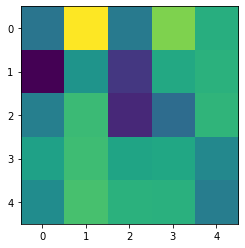

11 28


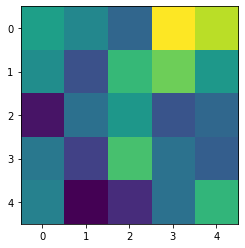

11 29


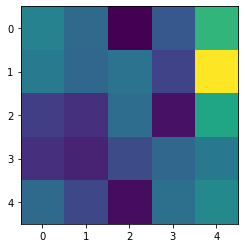

11 30


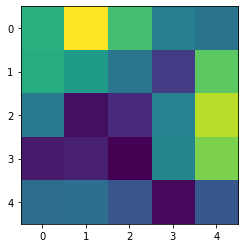

11 31


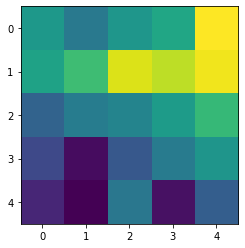

12 0


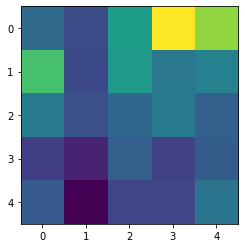

12 1


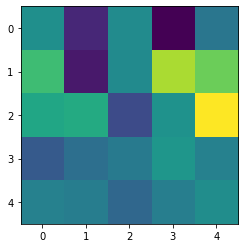

12 2


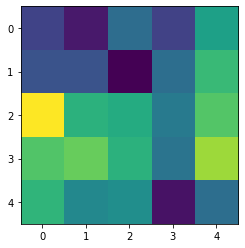

12 3


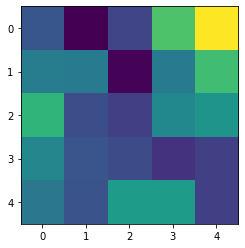

12 4


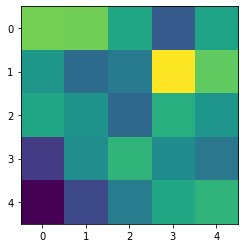

12 5


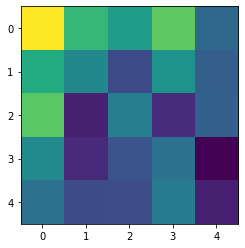

12 6


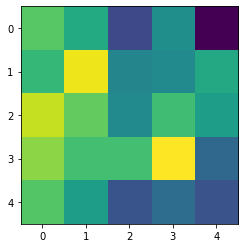

12 7


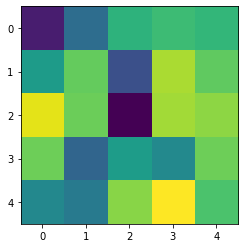

12 8


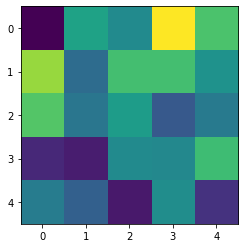

12 9


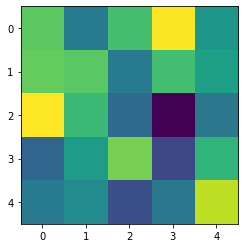

12 10


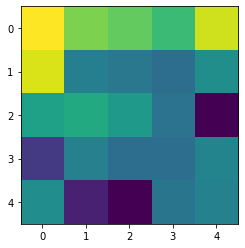

12 11


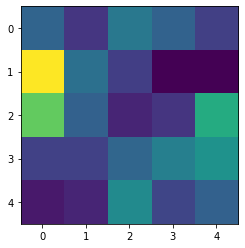

12 12


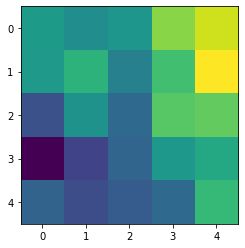

12 13


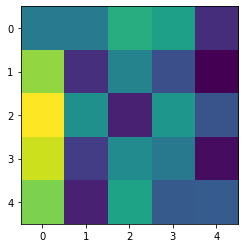

12 14


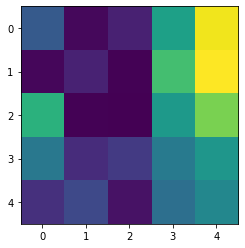

12 15


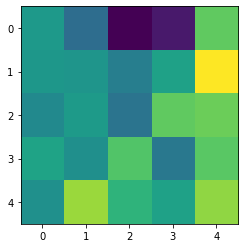

12 16


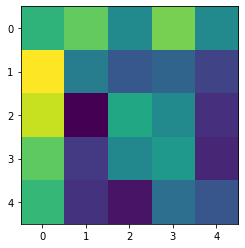

12 17


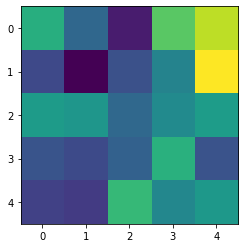

12 18


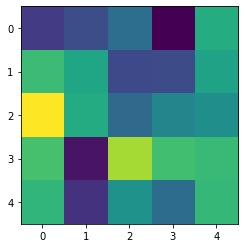

12 19


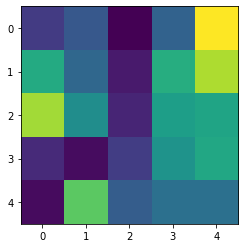

12 20


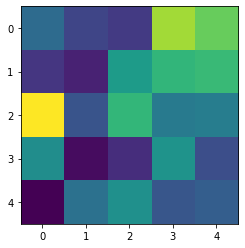

12 21


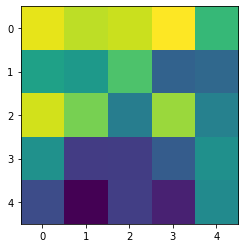

12 22


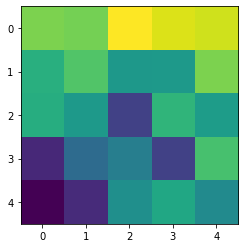

12 23


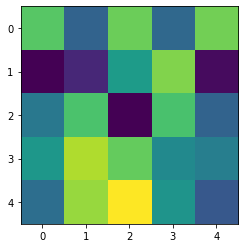

12 24


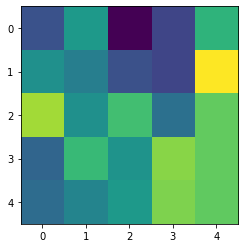

12 25


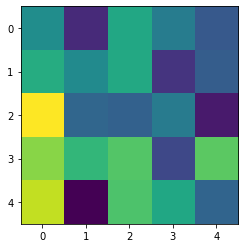

12 26


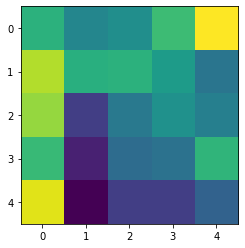

12 27


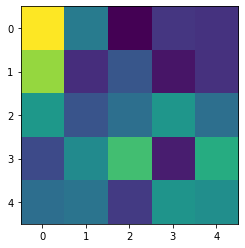

12 28


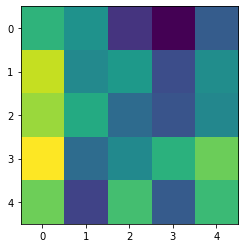

12 29


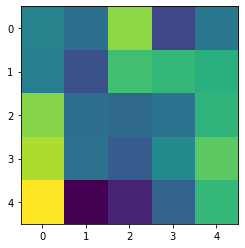

12 30


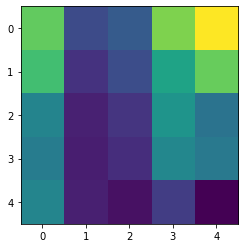

12 31


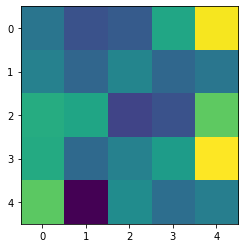

13 0


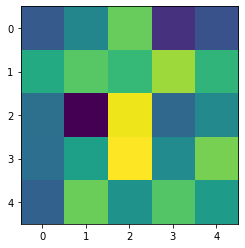

13 1


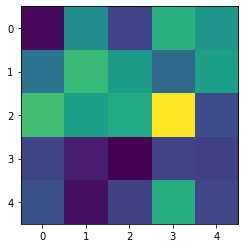

13 2


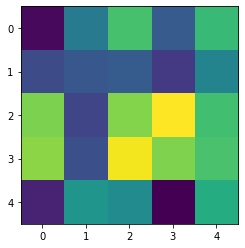

13 3


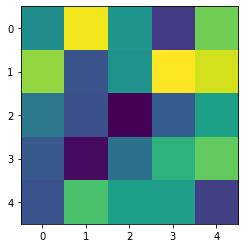

13 4


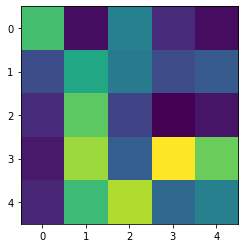

13 5


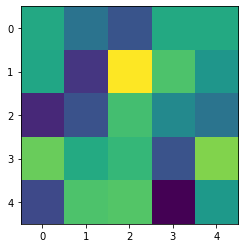

13 6


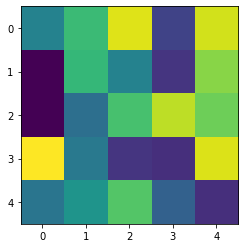

13 7


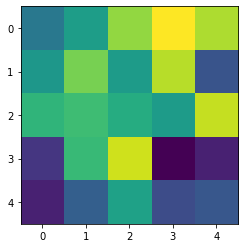

13 8


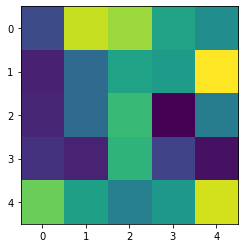

13 9


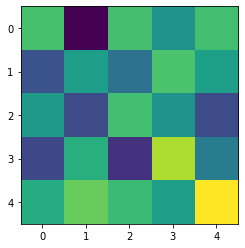

13 10


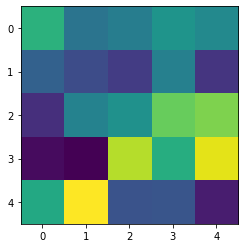

13 11


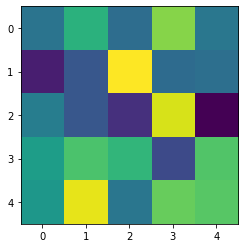

13 12


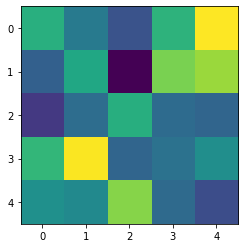

13 13


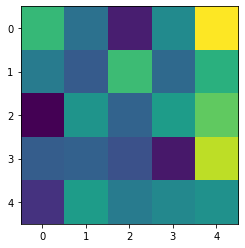

13 14


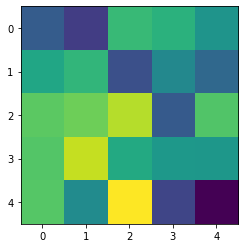

13 15


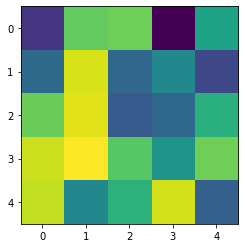

13 16


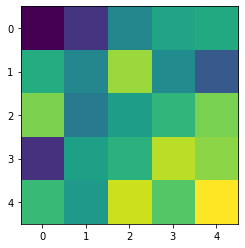

13 17


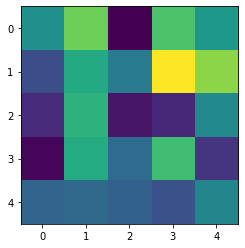

13 18


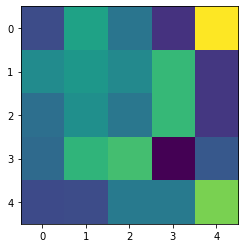

13 19


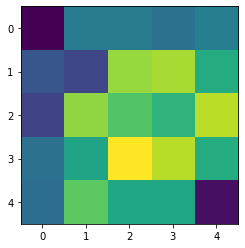

13 20


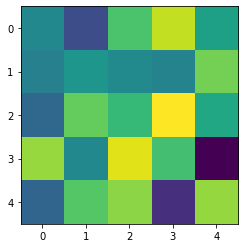

13 21


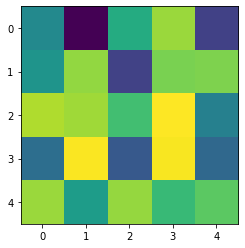

13 22


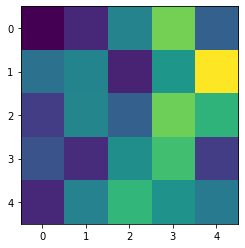

13 23


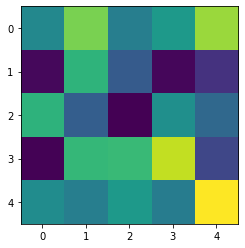

13 24


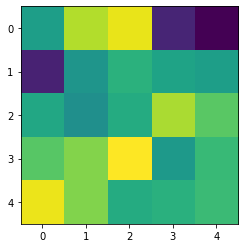

13 25


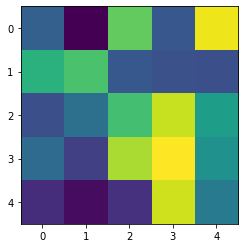

13 26


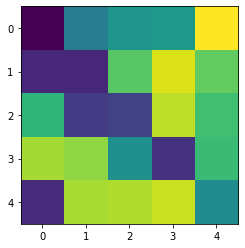

13 27


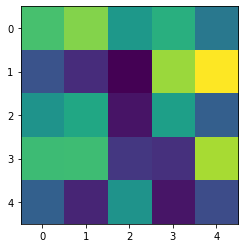

13 28


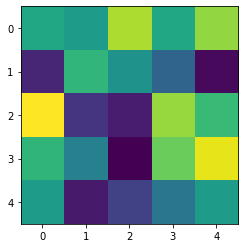

13 29


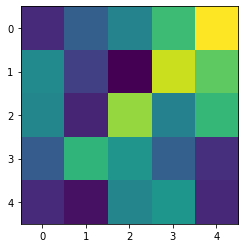

13 30


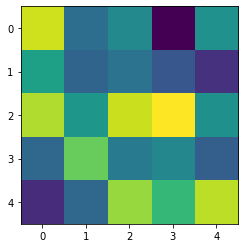

13 31


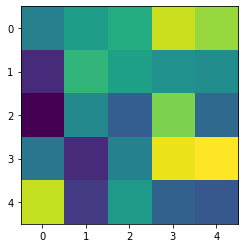

14 0


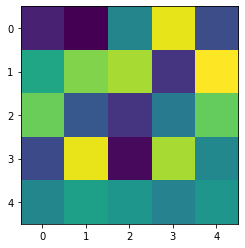

14 1


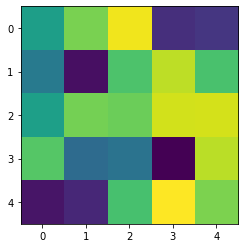

14 2


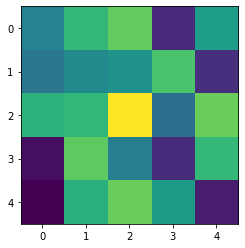

14 3


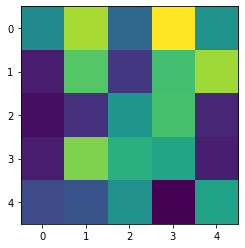

14 4


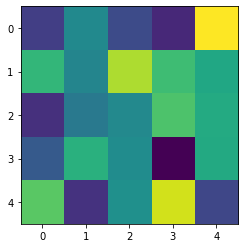

14 5


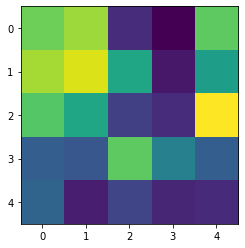

14 6


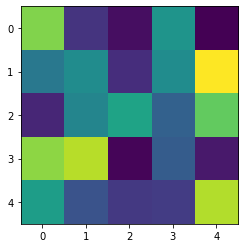

14 7


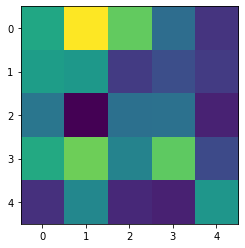

14 8


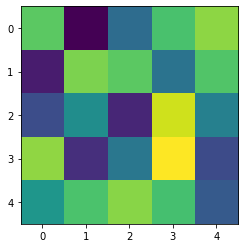

14 9


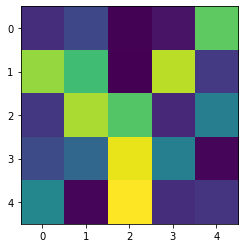

14 10


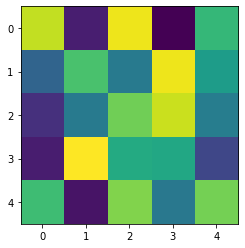

14 11


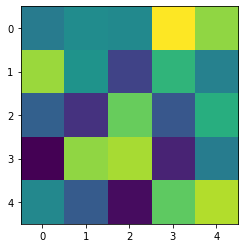

14 12


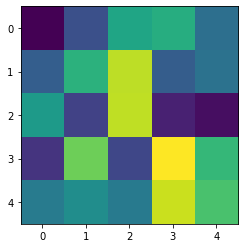

14 13


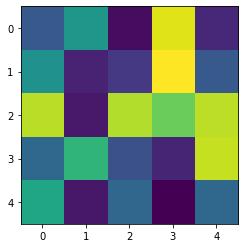

14 14


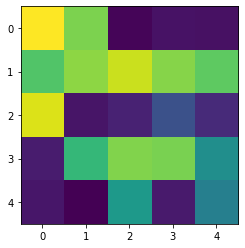

14 15


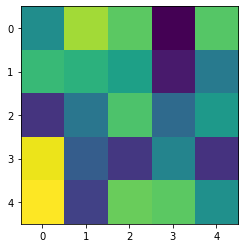

14 16


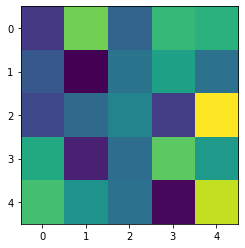

14 17


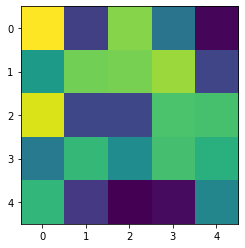

14 18


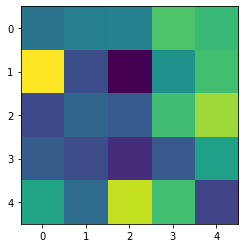

14 19


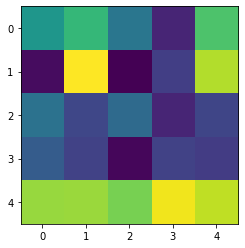

14 20


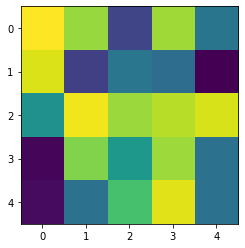

14 21


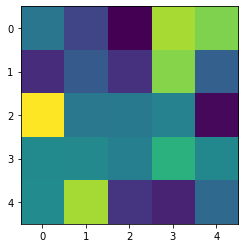

14 22


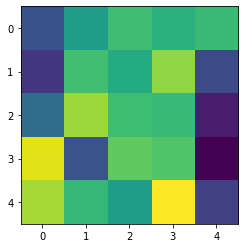

14 23


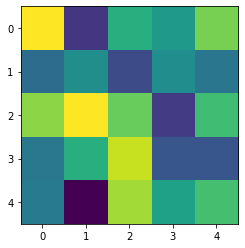

14 24


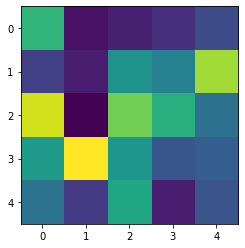

14 25


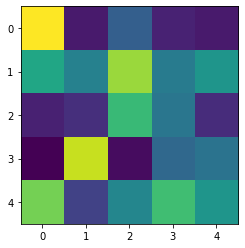

14 26


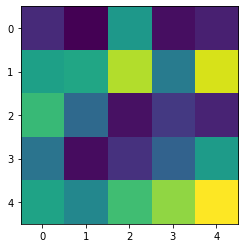

14 27


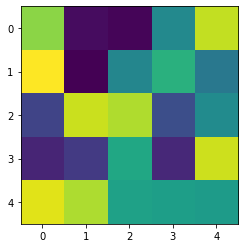

14 28


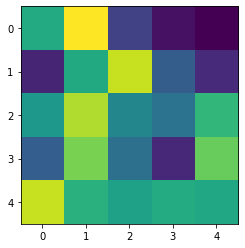

14 29


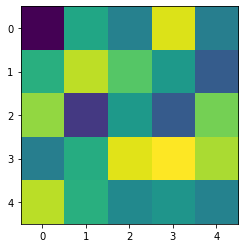

14 30


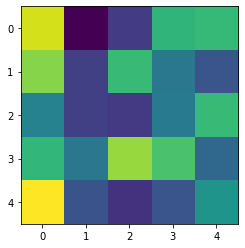

14 31


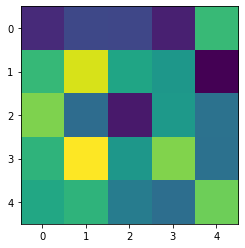

15 0


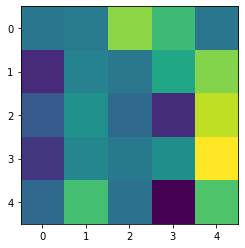

15 1


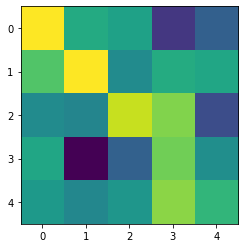

15 2


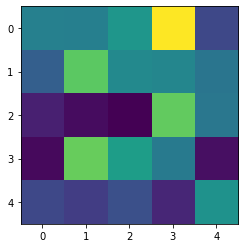

15 3


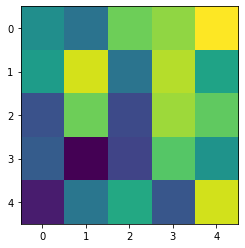

15 4


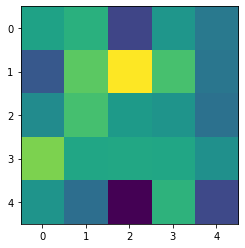

15 5


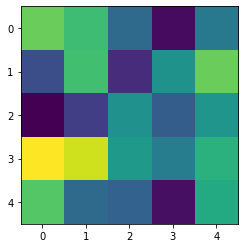

15 6


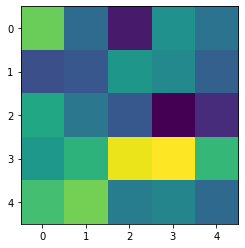

15 7


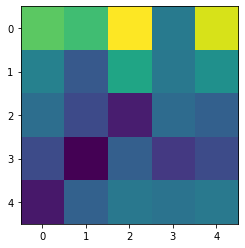

15 8


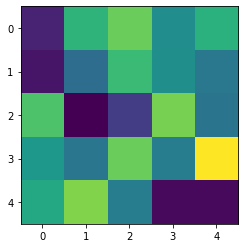

15 9


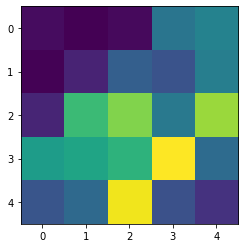

15 10


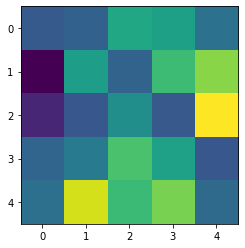

15 11


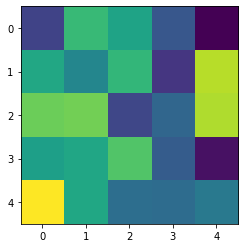

15 12


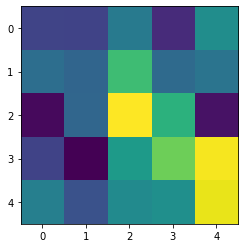

15 13


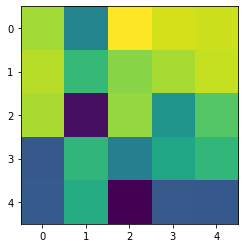

15 14


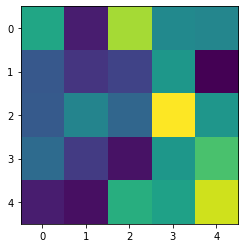

15 15


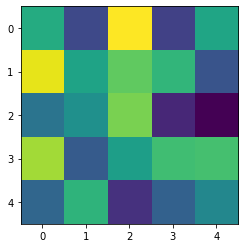

15 16


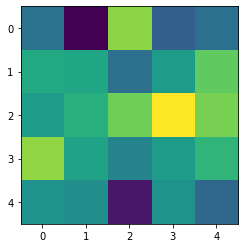

15 17


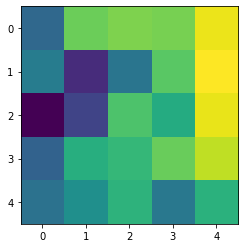

15 18


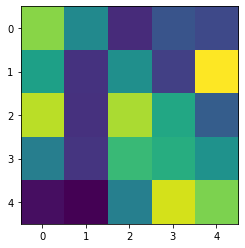

15 19


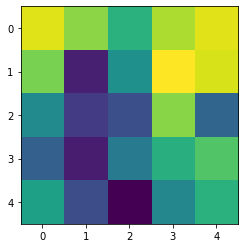

15 20


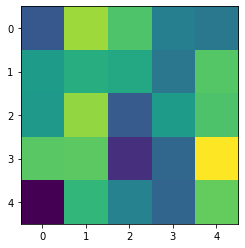

15 21


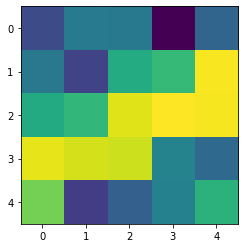

15 22


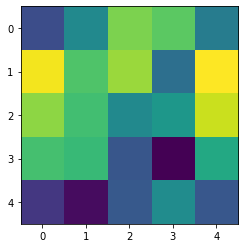

15 23


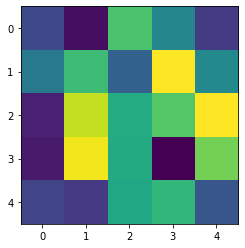

15 24


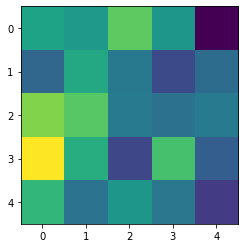

15 25


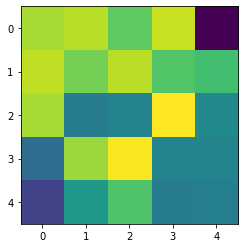

15 26


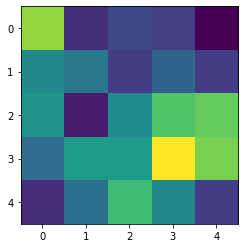

15 27


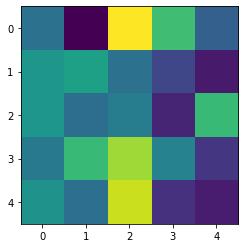

15 28


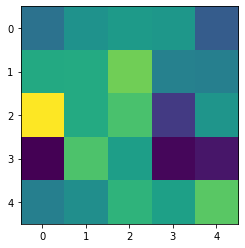

15 29


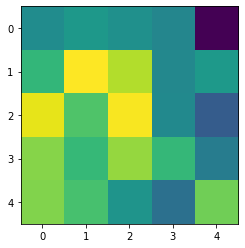

15 30


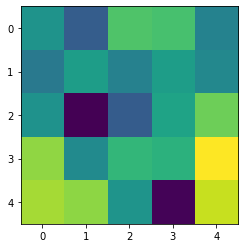

15 31


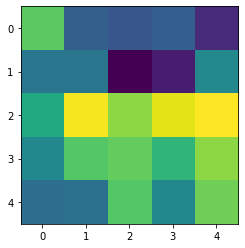

16 0


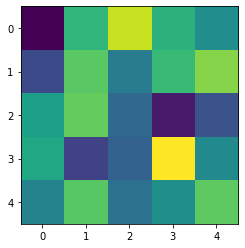

16 1


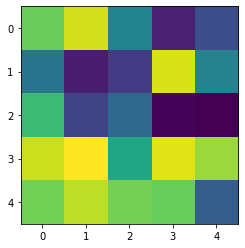

16 2


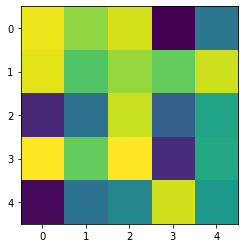

16 3


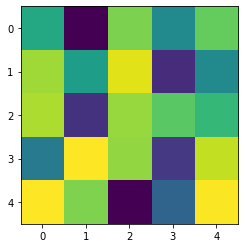

16 4


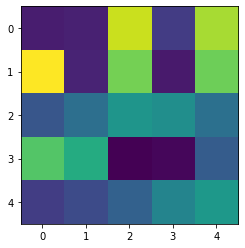

16 5


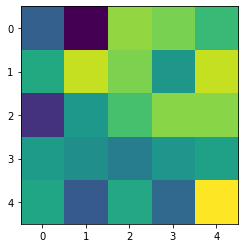

16 6


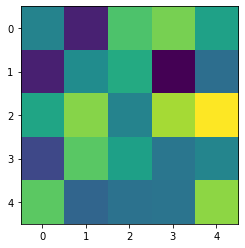

16 7


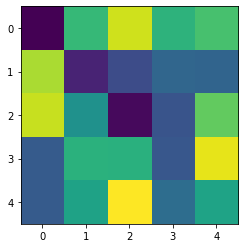

16 8


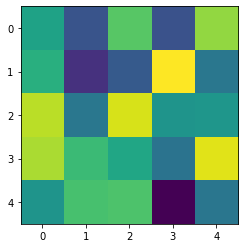

16 9


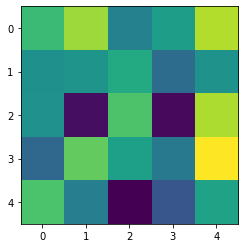

16 10


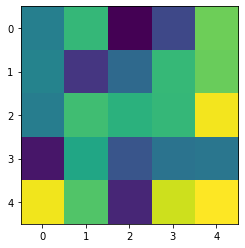

16 11


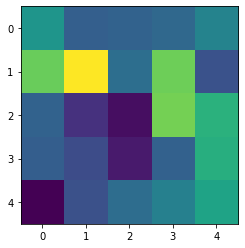

16 12


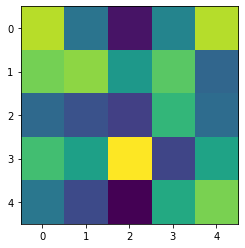

16 13


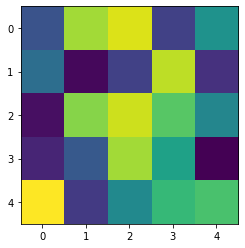

16 14


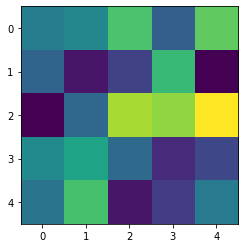

16 15


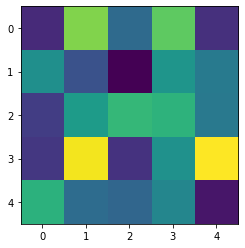

16 16


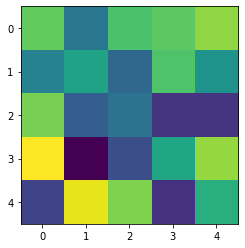

16 17


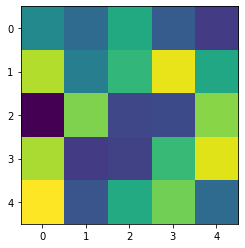

16 18


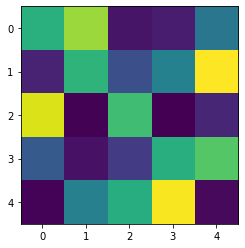

16 19


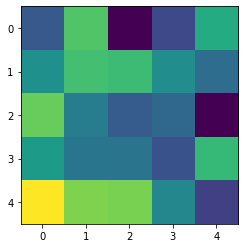

16 20


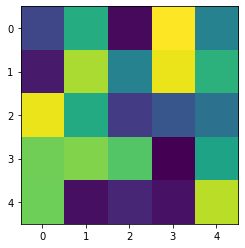

16 21


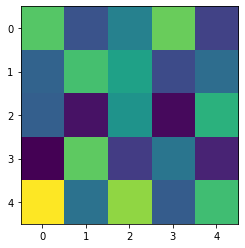

16 22


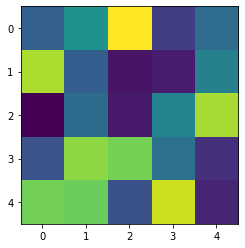

16 23


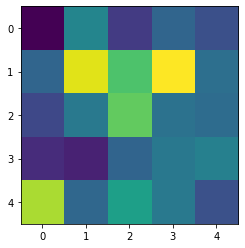

16 24


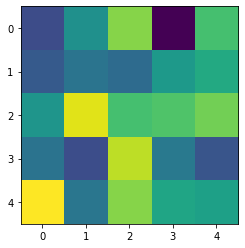

16 25


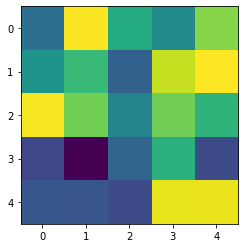

16 26


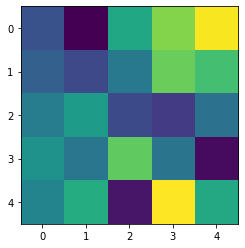

16 27


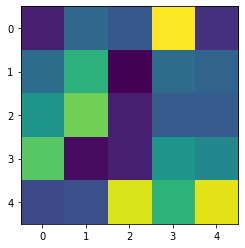

16 28


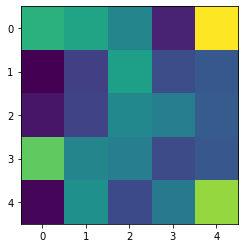

16 29


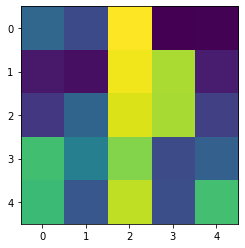

16 30


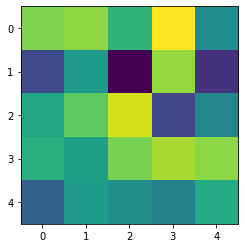

16 31


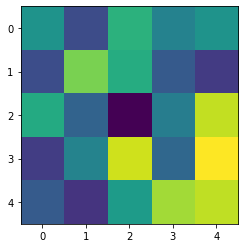

17 0


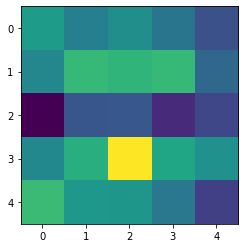

17 1


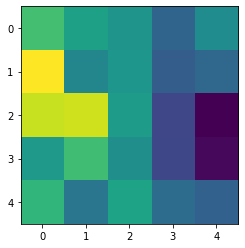

17 2


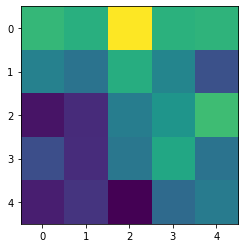

17 3


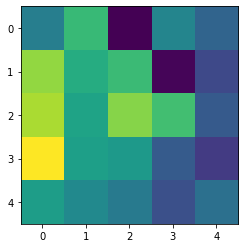

17 4


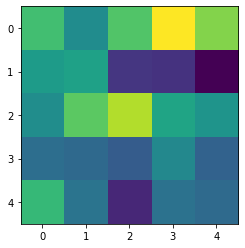

17 5


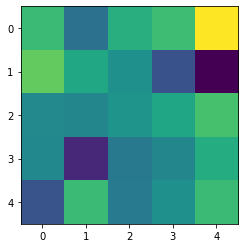

17 6


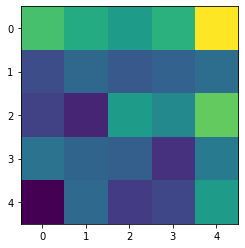

17 7


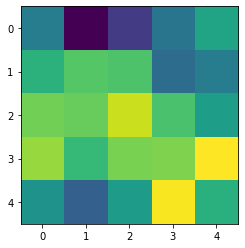

17 8


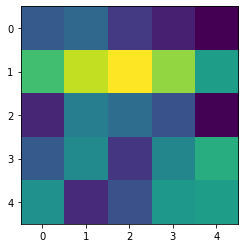

17 9


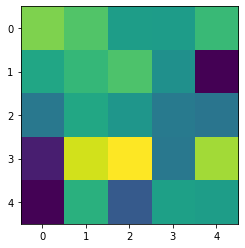

17 10


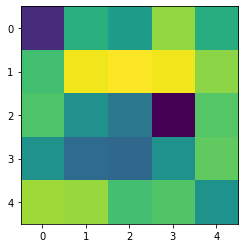

17 11


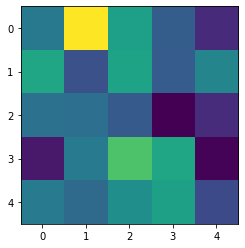

17 12


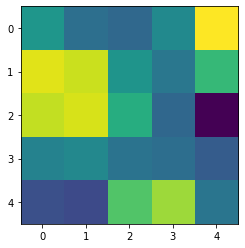

17 13


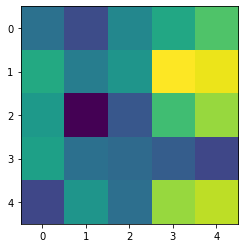

17 14


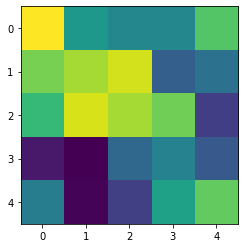

17 15


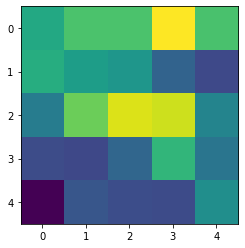

17 16


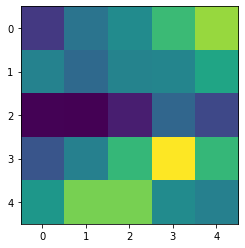

17 17


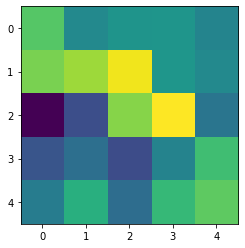

17 18


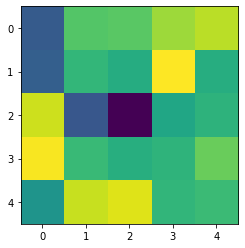

17 19


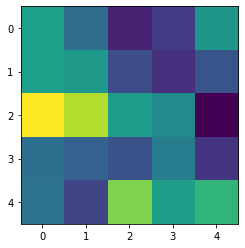

17 20


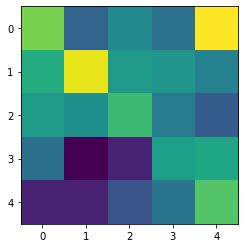

17 21


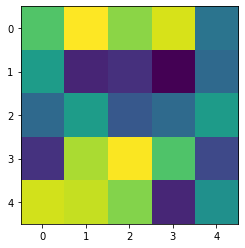

17 22


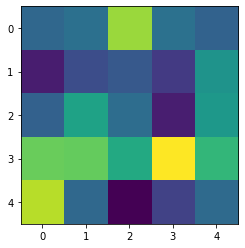

17 23


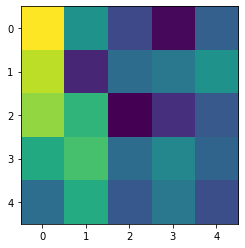

17 24


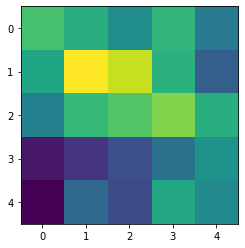

17 25


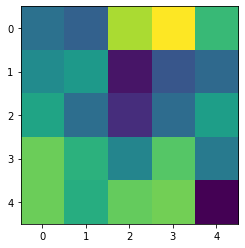

17 26


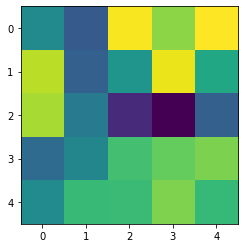

17 27


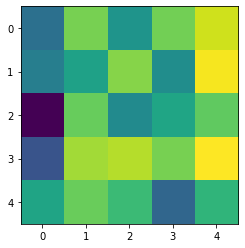

17 28


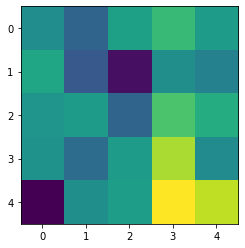

17 29


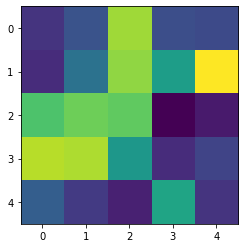

17 30


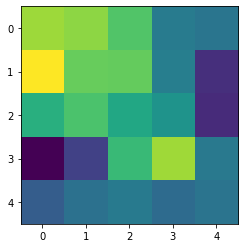

17 31


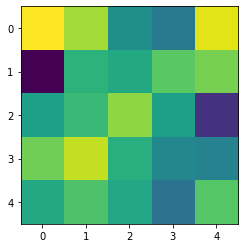

18 0


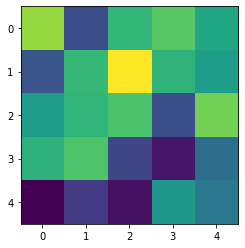

18 1


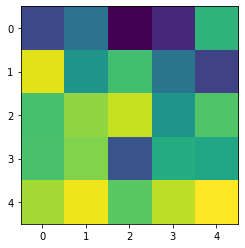

18 2


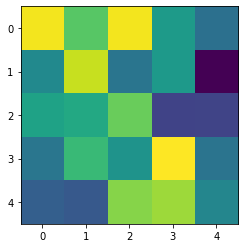

18 3


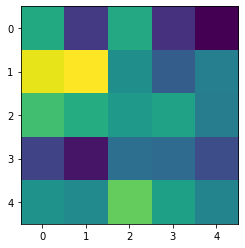

18 4


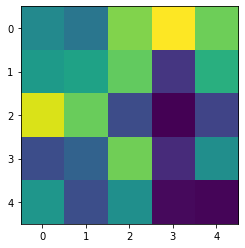

18 5


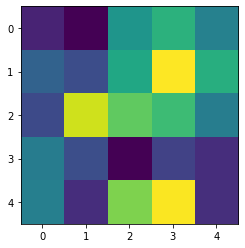

18 6


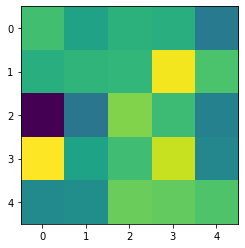

18 7


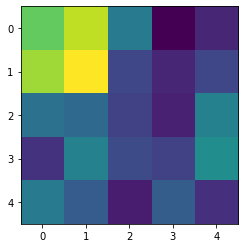

18 8


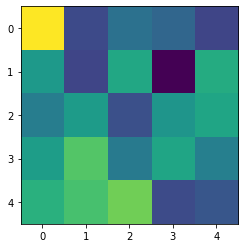

18 9


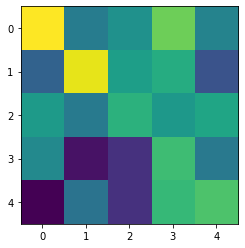

18 10


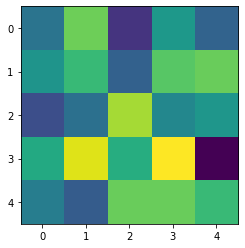

18 11


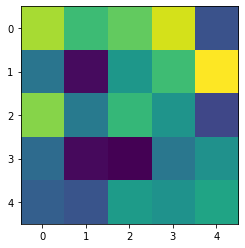

18 12


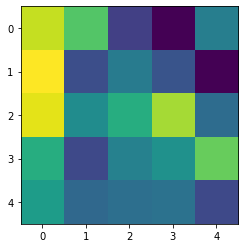

18 13


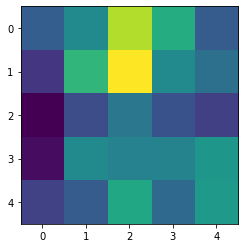

18 14


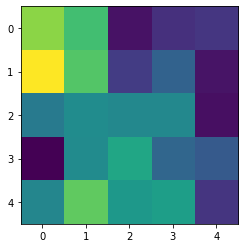

18 15


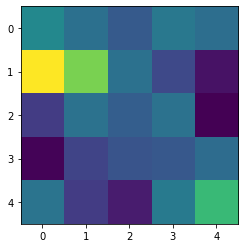

18 16


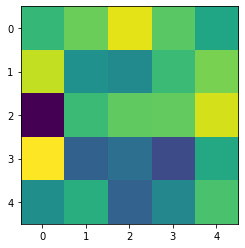

18 17


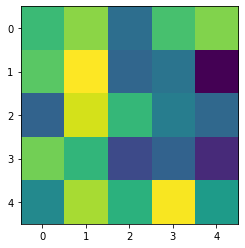

18 18


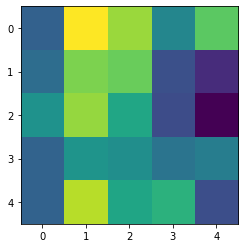

18 19


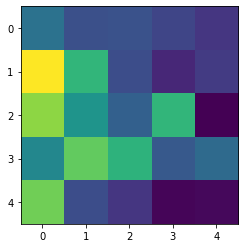

18 20


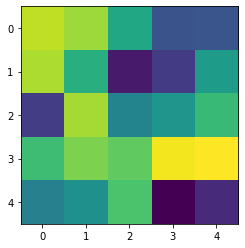

18 21


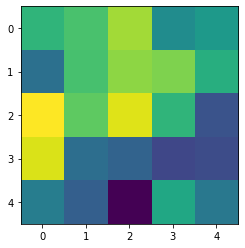

18 22


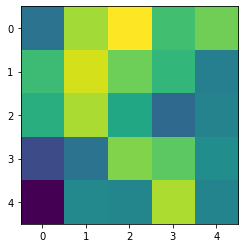

18 23


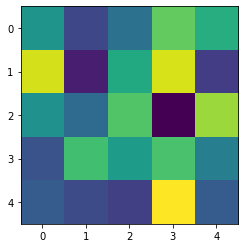

18 24


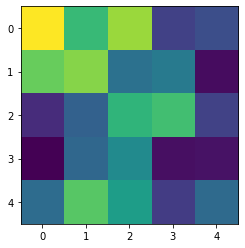

18 25


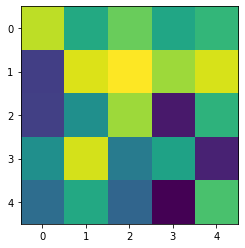

18 26


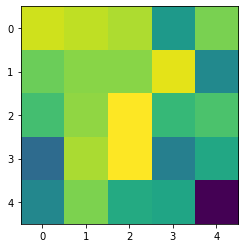

18 27


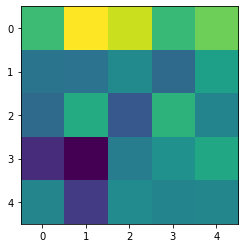

18 28


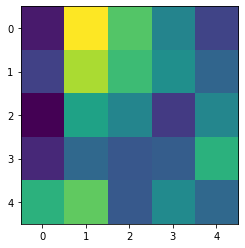

18 29


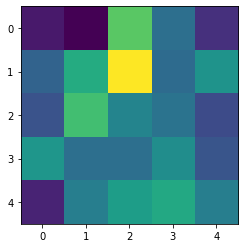

18 30


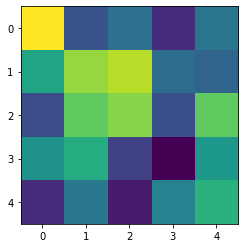

18 31


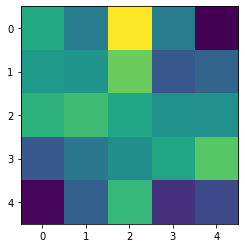

19 0


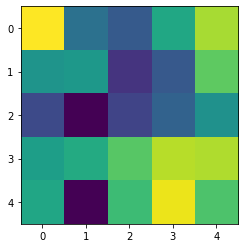

19 1


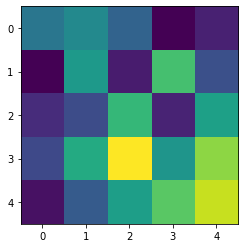

19 2


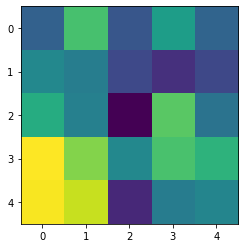

19 3


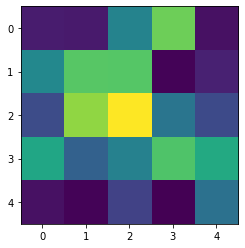

19 4


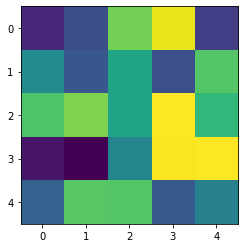

19 5


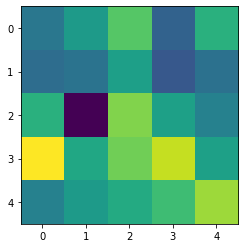

19 6


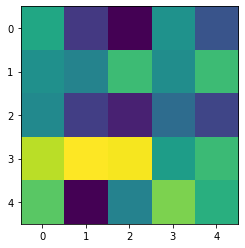

19 7


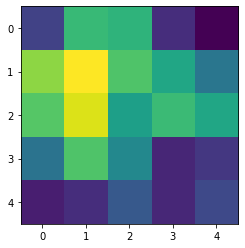

19 8


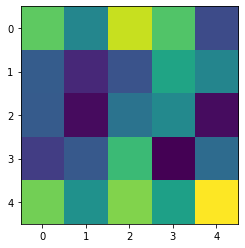

19 9


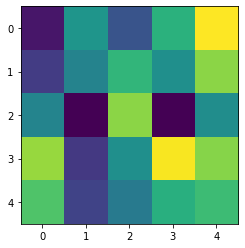

19 10


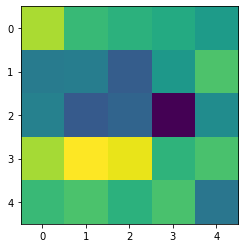

19 11


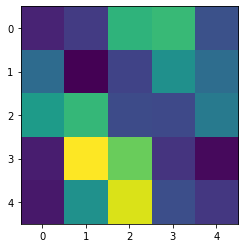

19 12


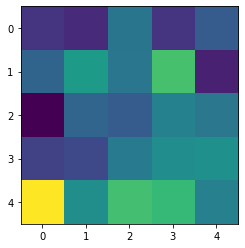

19 13


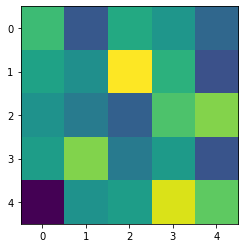

19 14


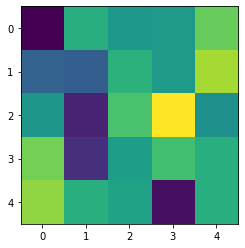

19 15


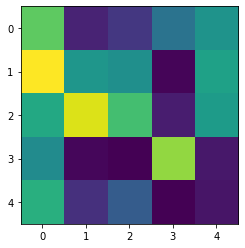

19 16


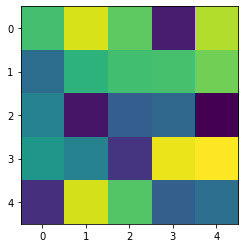

19 17


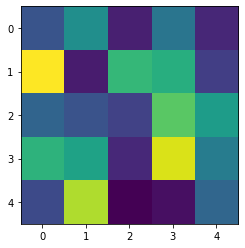

19 18


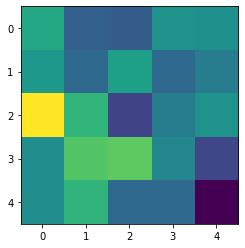

19 19


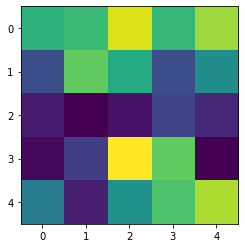

19 20


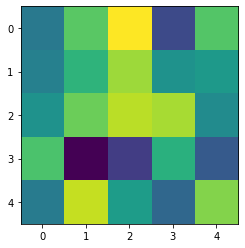

19 21


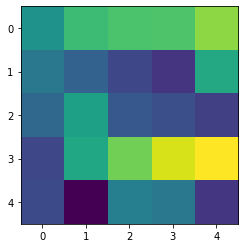

19 22


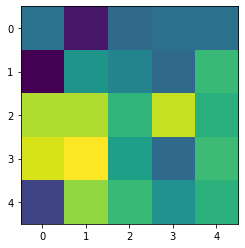

19 23


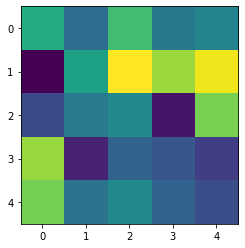

19 24


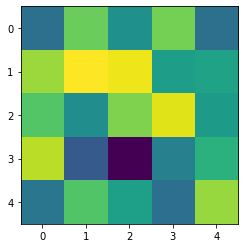

19 25


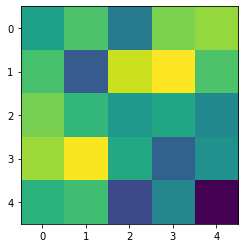

19 26


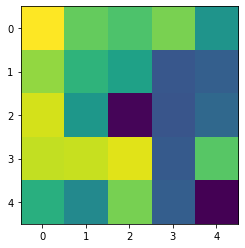

19 27


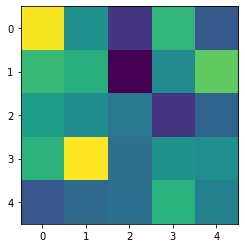

19 28


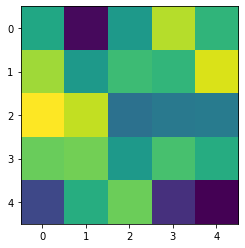

19 29


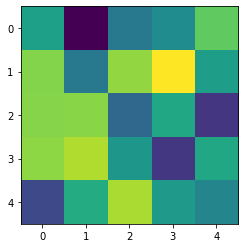

19 30


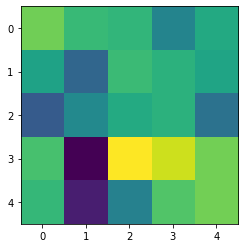

19 31


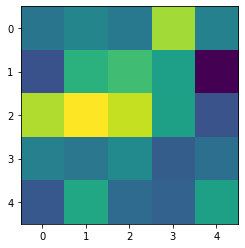

20 0


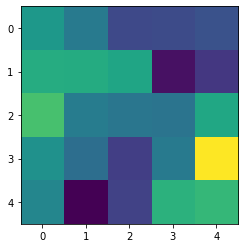

20 1


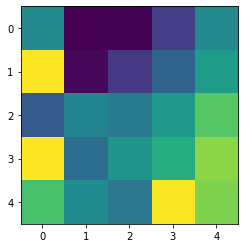

20 2


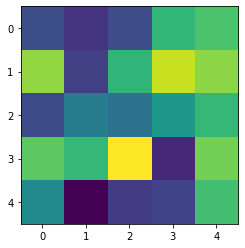

20 3


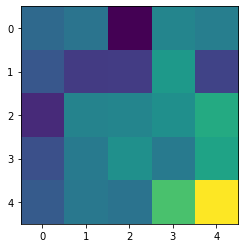

20 4


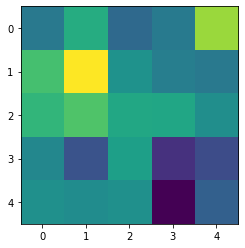

20 5


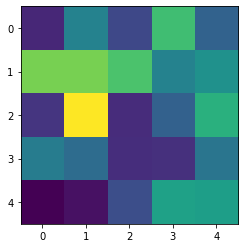

20 6


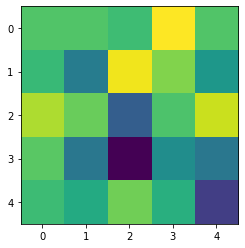

20 7


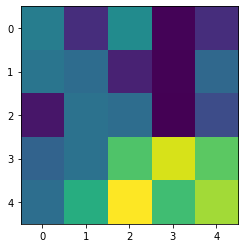

20 8


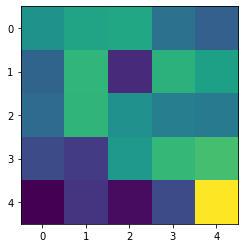

20 9


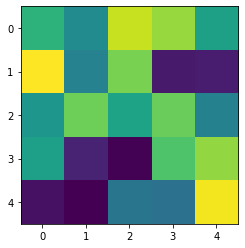

20 10


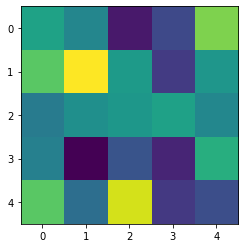

20 11


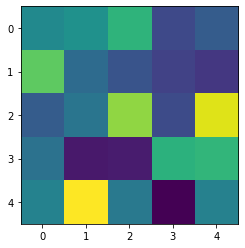

20 12


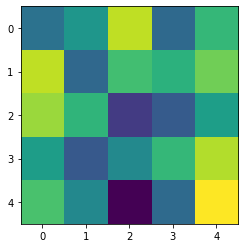

20 13


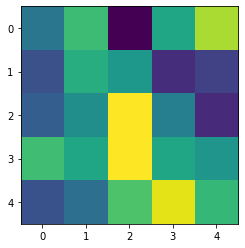

20 14


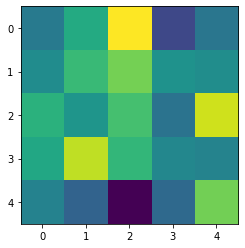

20 15


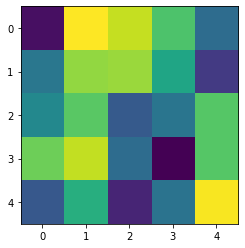

20 16


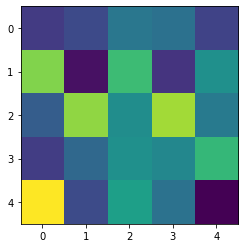

20 17


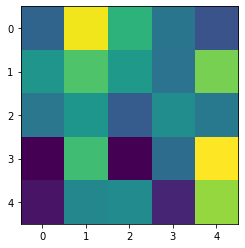

20 18


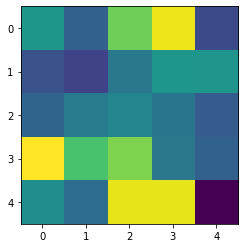

20 19


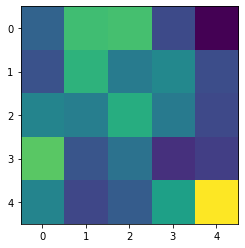

20 20


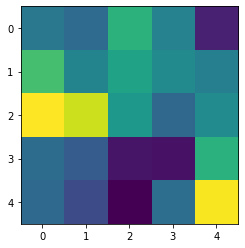

20 21


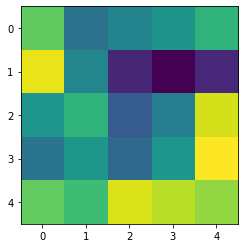

20 22


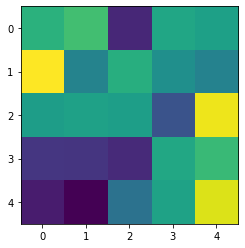

20 23


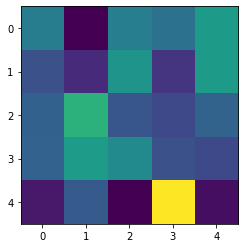

20 24


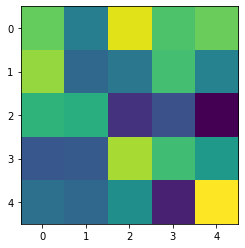

20 25


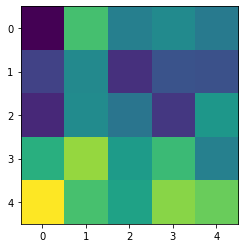

20 26


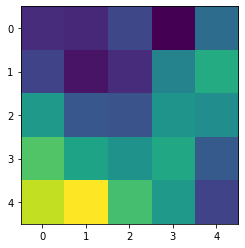

20 27


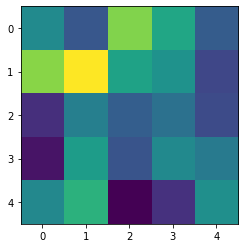

20 28


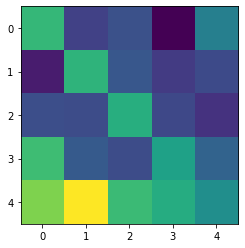

20 29


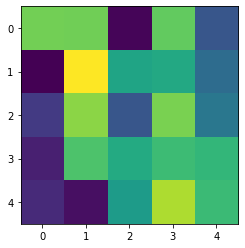

20 30


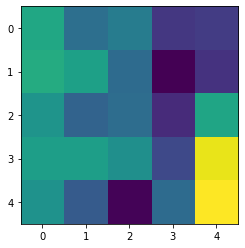

20 31


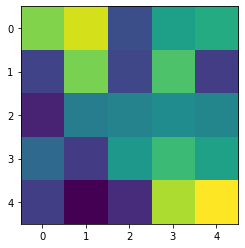

21 0


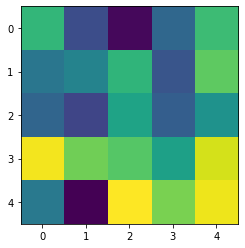

21 1


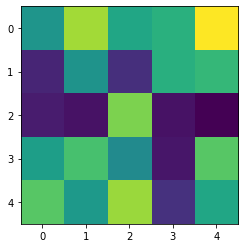

21 2


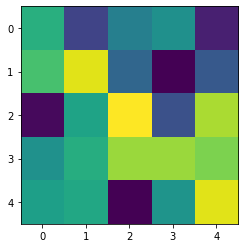

21 3


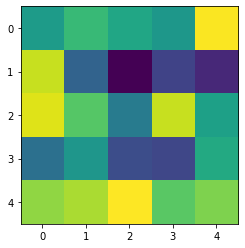

21 4


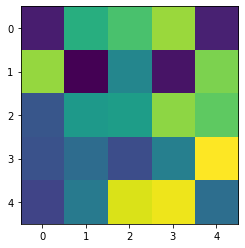

21 5


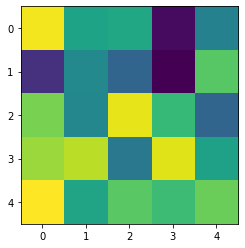

21 6


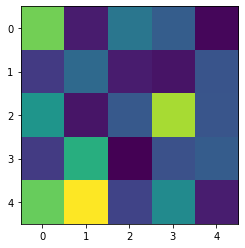

21 7


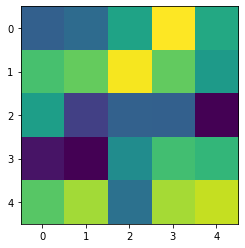

21 8


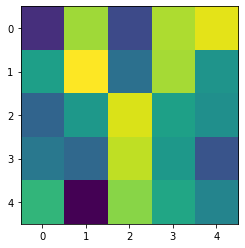

21 9


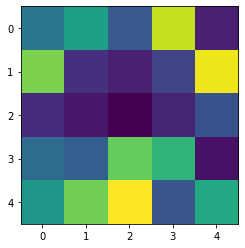

21 10


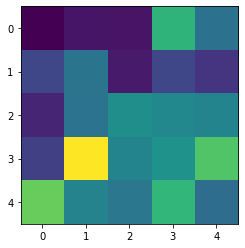

21 11


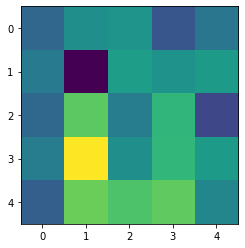

21 12


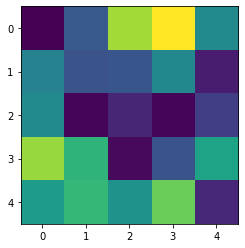

21 13


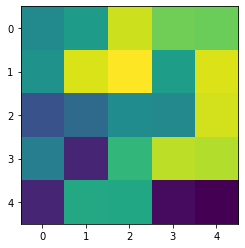

21 14


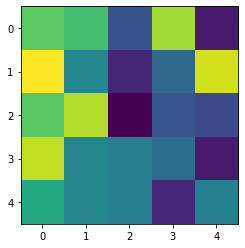

21 15


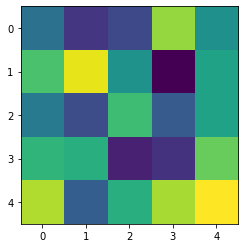

21 16


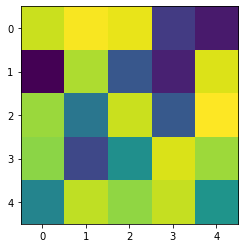

21 17


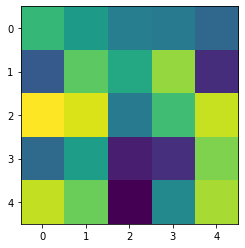

21 18


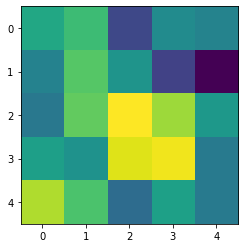

21 19


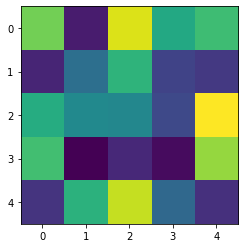

21 20


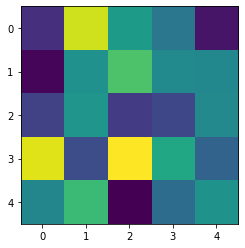

21 21


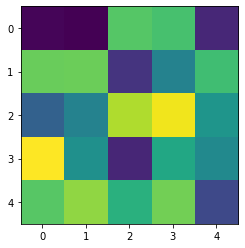

21 22


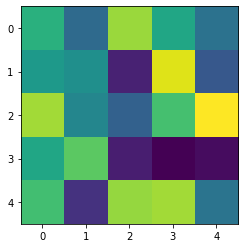

21 23


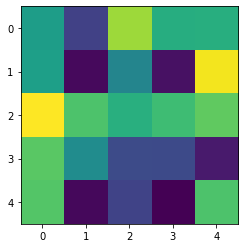

21 24


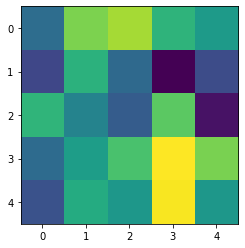

21 25


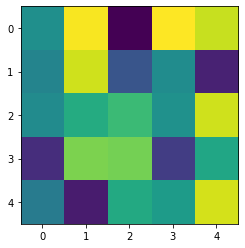

21 26


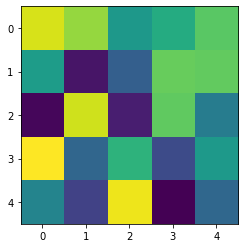

21 27


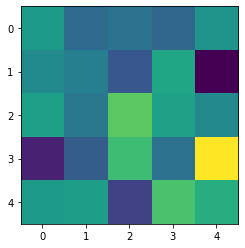

21 28


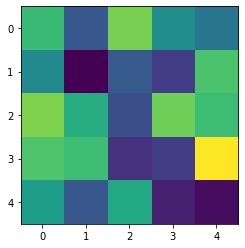

21 29


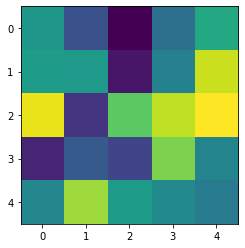

21 30


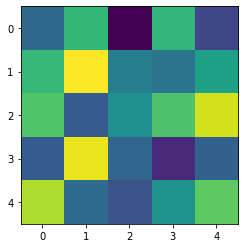

21 31


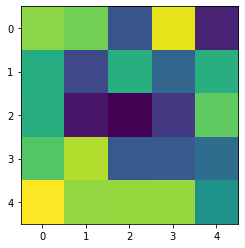

22 0


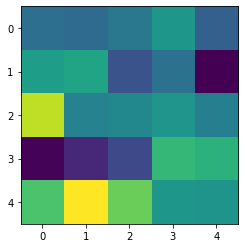

22 1


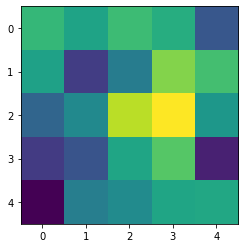

22 2


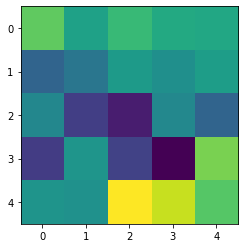

22 3


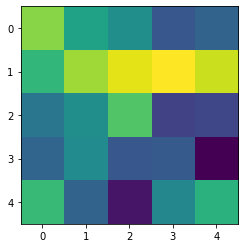

22 4


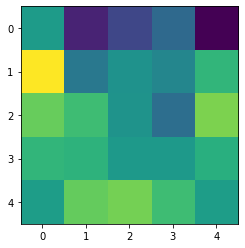

22 5


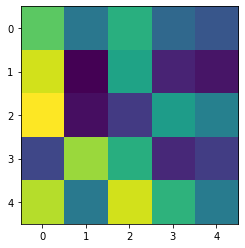

22 6


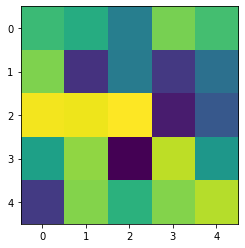

22 7


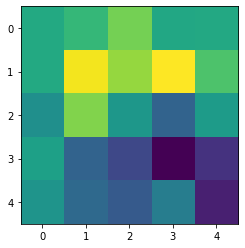

22 8


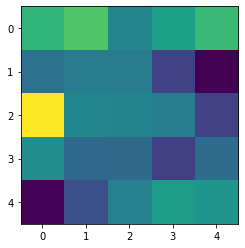

22 9


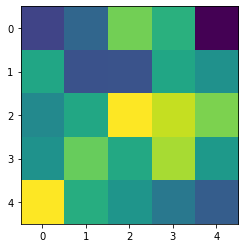

22 10


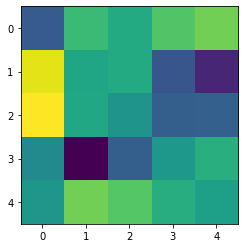

22 11


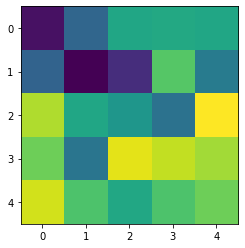

22 12


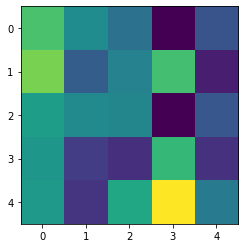

22 13


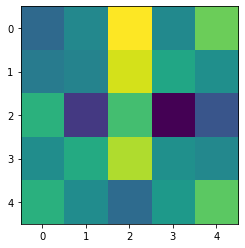

22 14


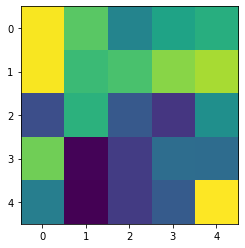

22 15


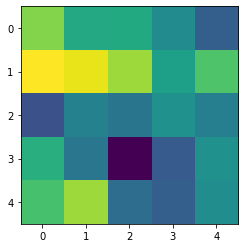

22 16


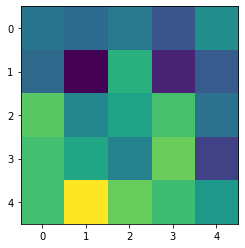

22 17


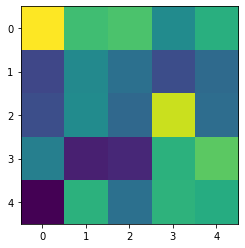

22 18


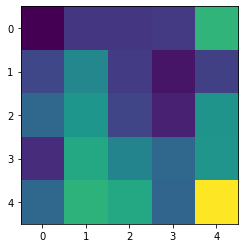

22 19


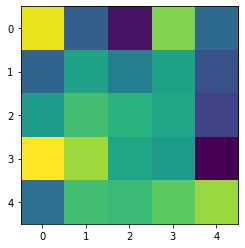

22 20


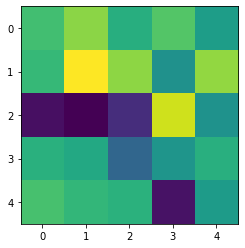

22 21


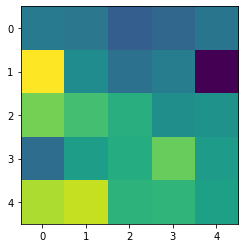

22 22


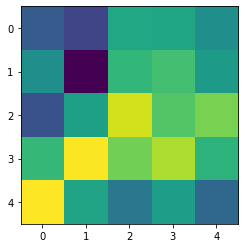

22 23


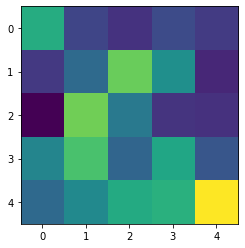

22 24


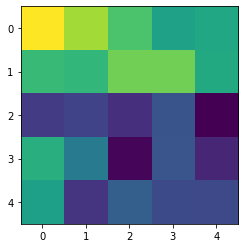

22 25


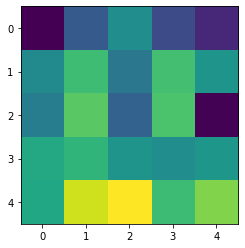

22 26


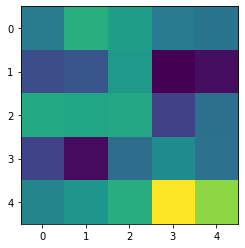

22 27


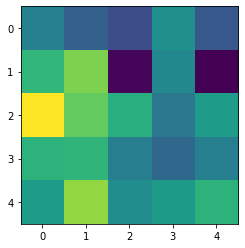

22 28


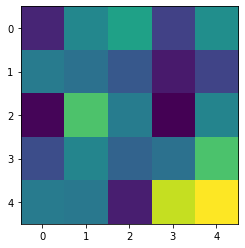

22 29


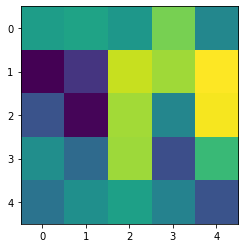

22 30


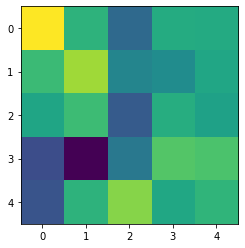

22 31


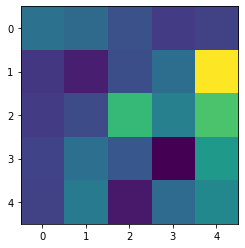

23 0


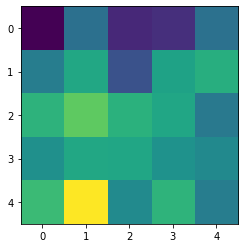

23 1


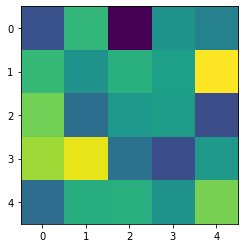

23 2


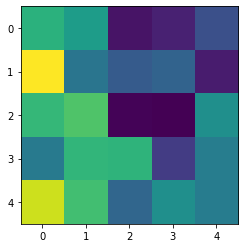

23 3


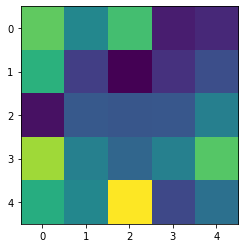

23 4


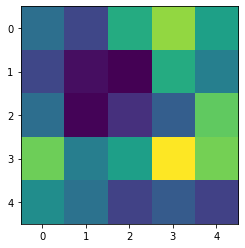

23 5


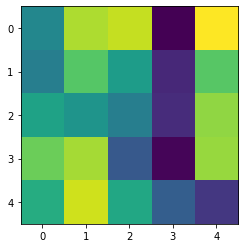

23 6


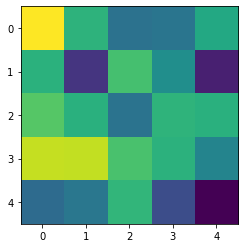

23 7


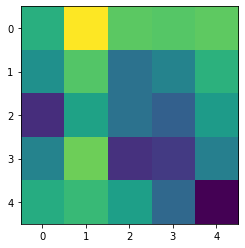

23 8


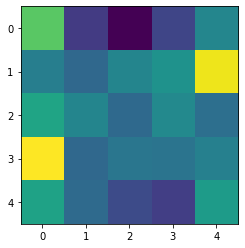

23 9


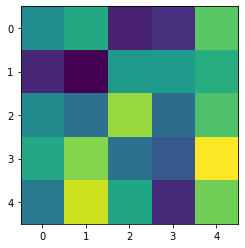

23 10


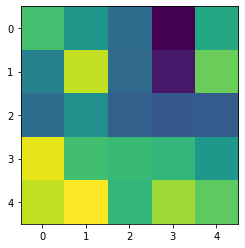

23 11


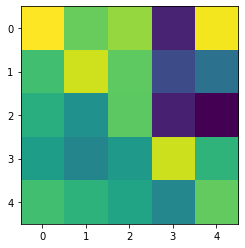

23 12


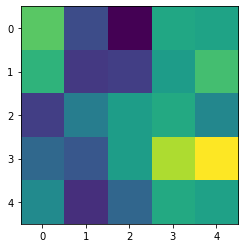

23 13


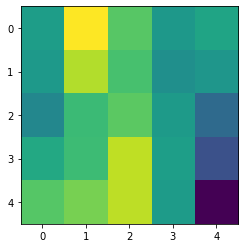

23 14


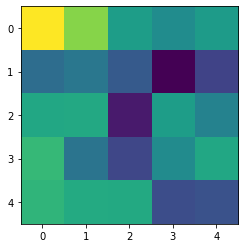

23 15


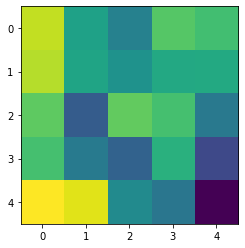

23 16


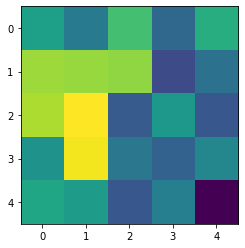

23 17


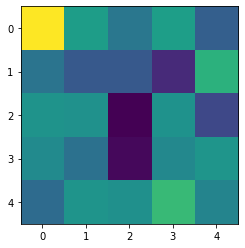

23 18


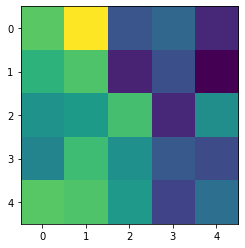

23 19


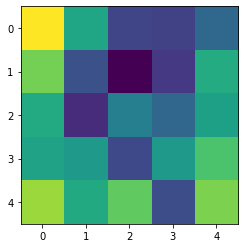

23 20


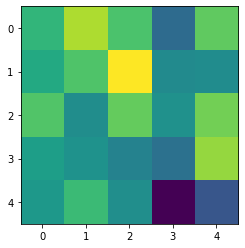

23 21


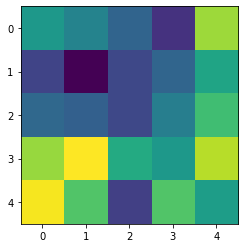

23 22


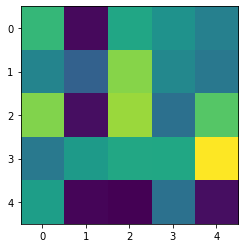

23 23


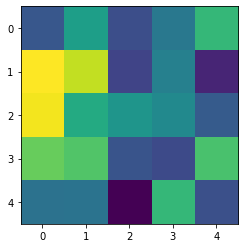

23 24


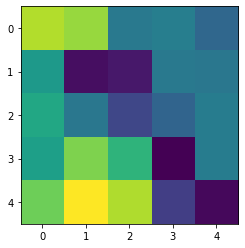

23 25


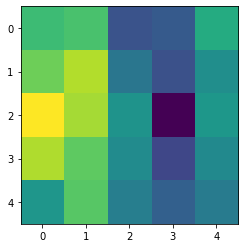

23 26


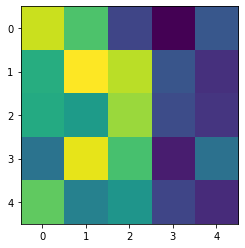

23 27


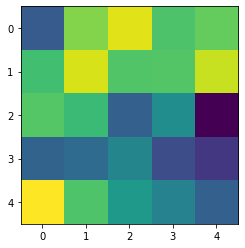

23 28


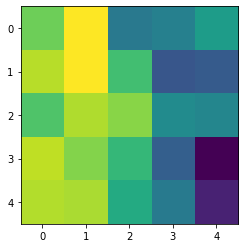

23 29


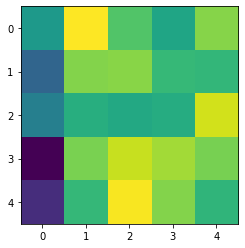

23 30


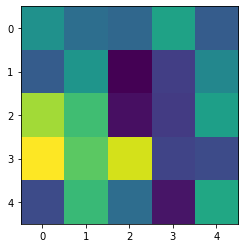

23 31


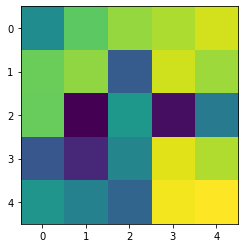

24 0


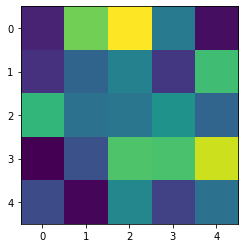

24 1


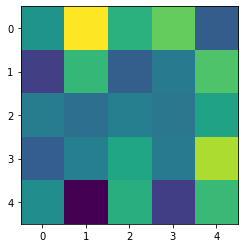

24 2


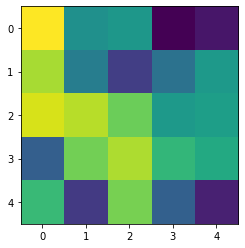

24 3


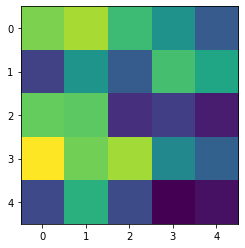

24 4


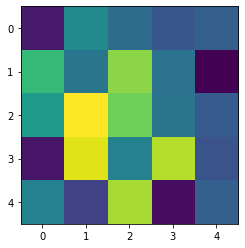

24 5


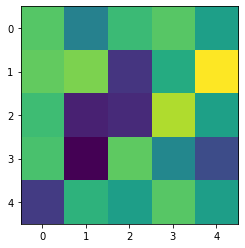

24 6


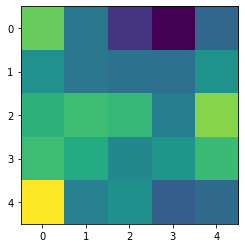

24 7


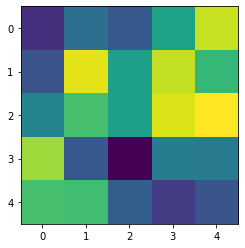

24 8


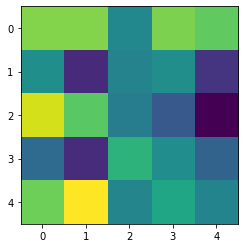

24 9


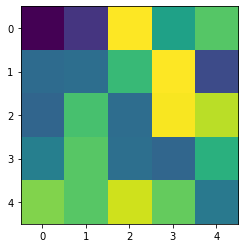

24 10


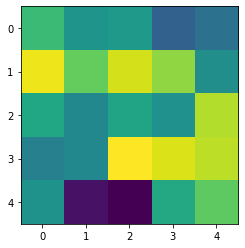

24 11


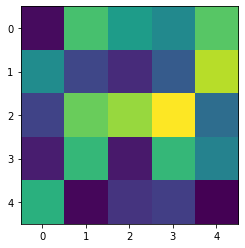

24 12


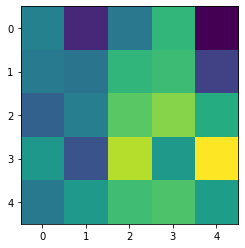

24 13


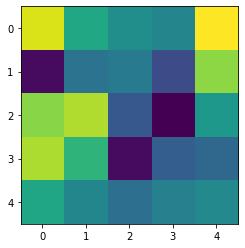

24 14


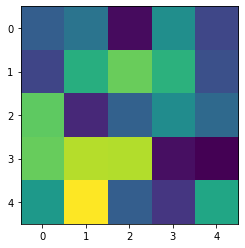

24 15


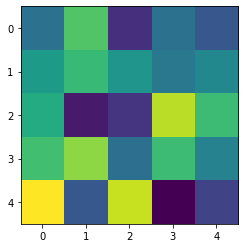

24 16


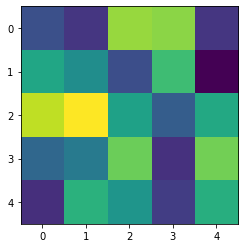

24 17


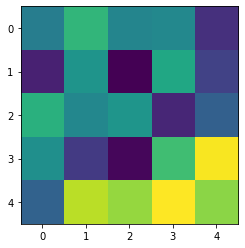

24 18


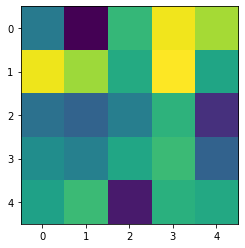

24 19


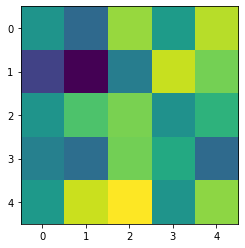

24 20


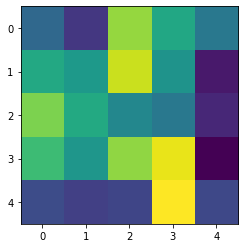

24 21


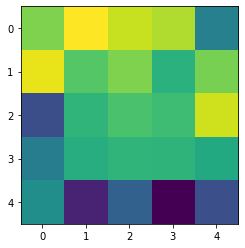

24 22


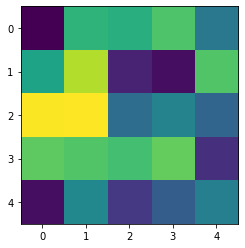

24 23


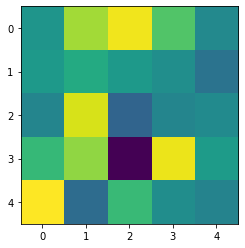

24 24


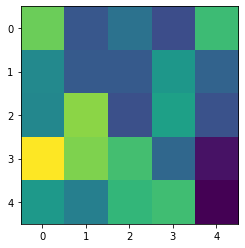

24 25


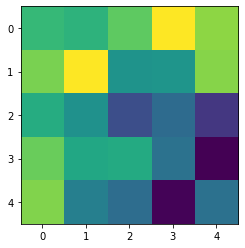

24 26


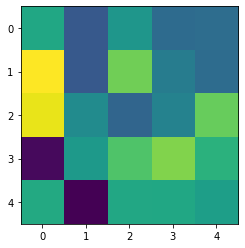

24 27


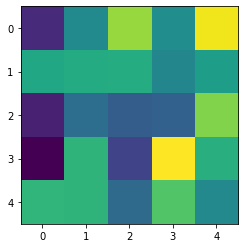

24 28


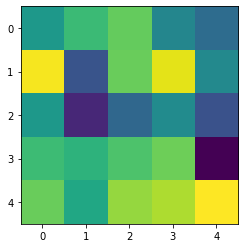

24 29


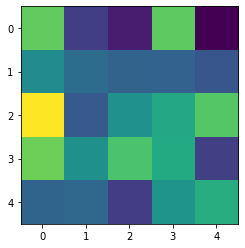

24 30


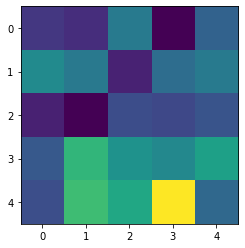

24 31


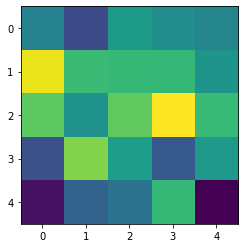

25 0


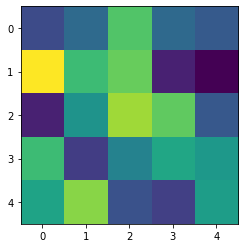

25 1


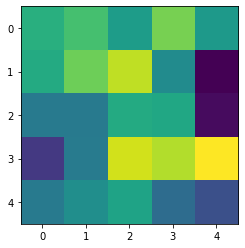

25 2


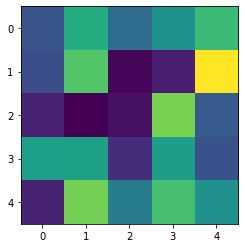

25 3


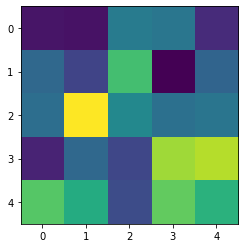

25 4


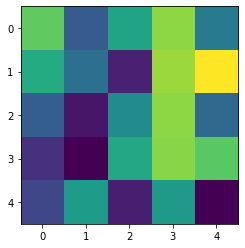

25 5


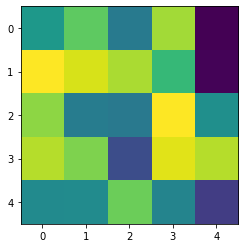

25 6


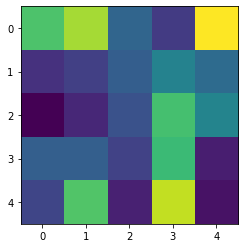

25 7


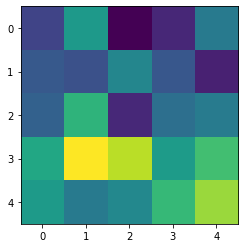

25 8


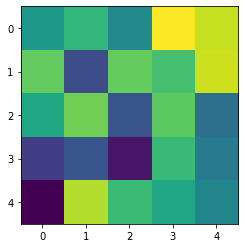

25 9


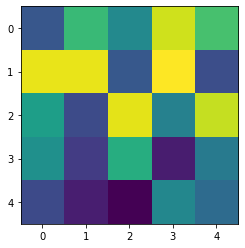

25 10


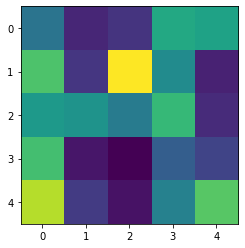

25 11


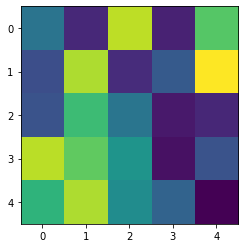

25 12


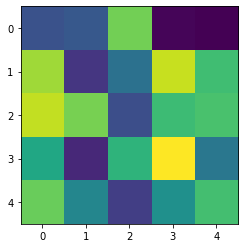

25 13


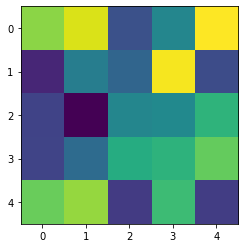

25 14


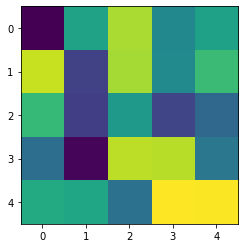

25 15


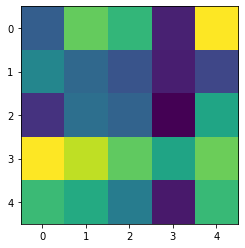

25 16


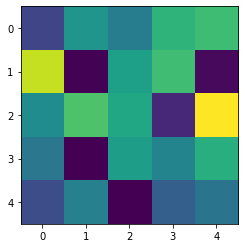

25 17


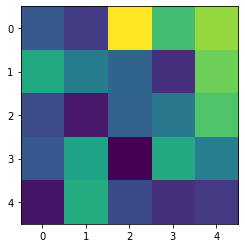

25 18


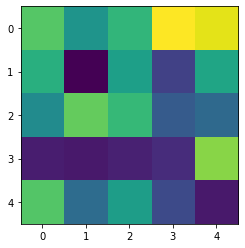

25 19


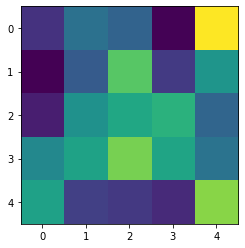

25 20


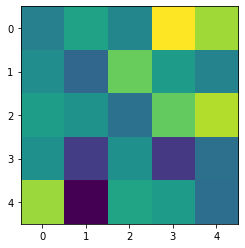

25 21


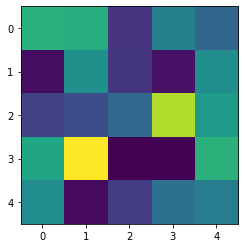

25 22


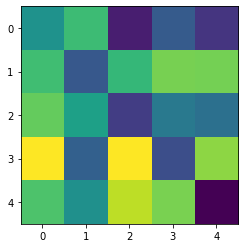

25 23


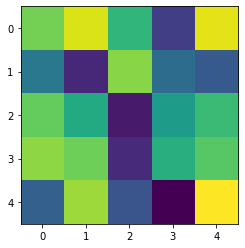

25 24


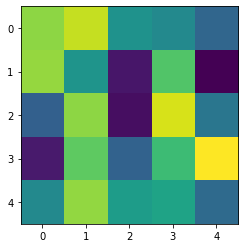

25 25


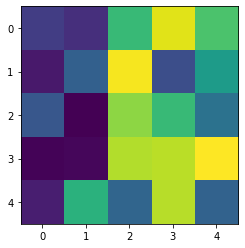

25 26


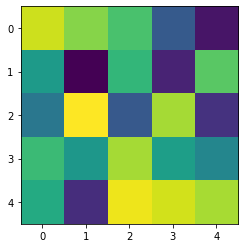

25 27


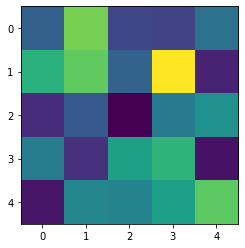

25 28


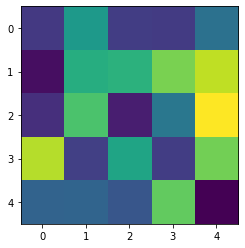

25 29


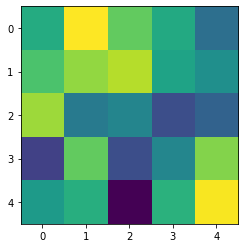

25 30


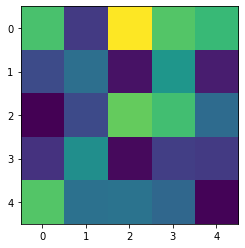

25 31


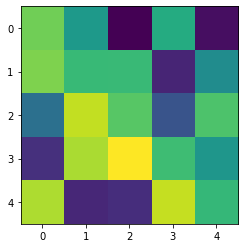

26 0


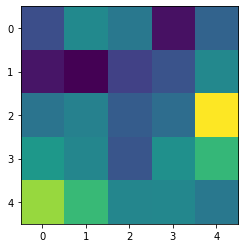

26 1


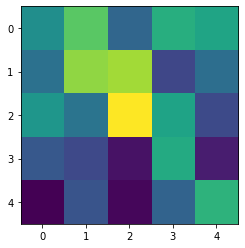

26 2


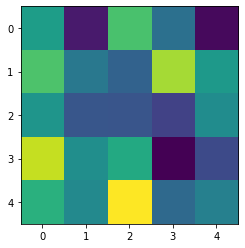

26 3


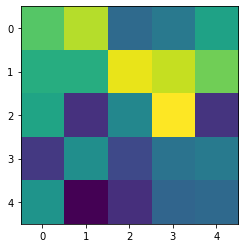

26 4


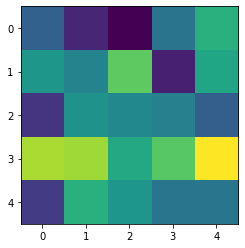

26 5


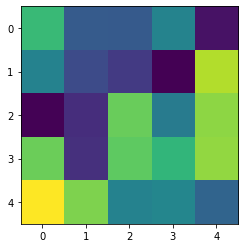

26 6


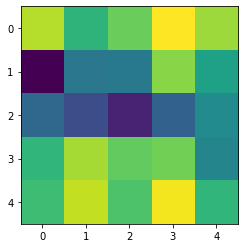

26 7


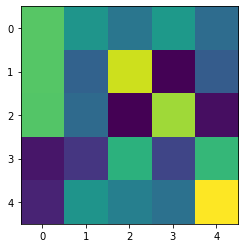

26 8


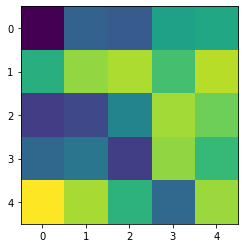

26 9


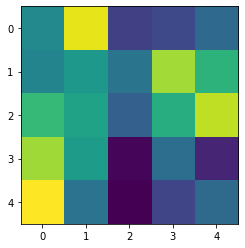

26 10


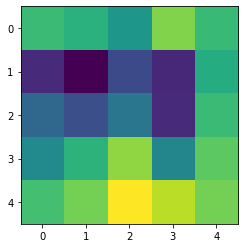

26 11


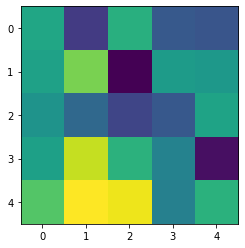

26 12


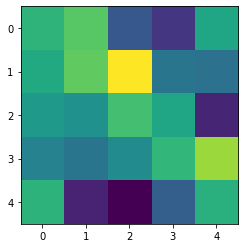

26 13


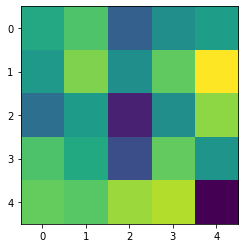

26 14


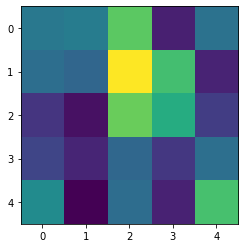

26 15


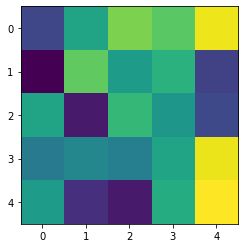

26 16


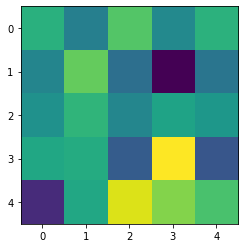

26 17


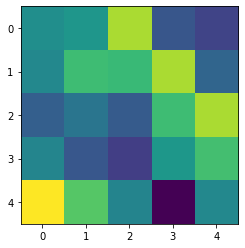

26 18


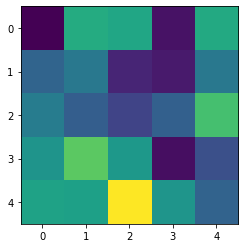

26 19


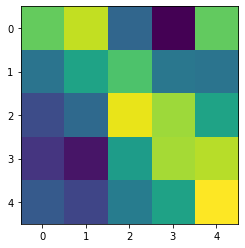

26 20


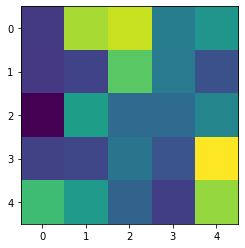

26 21


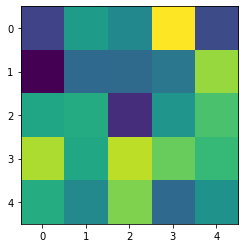

26 22


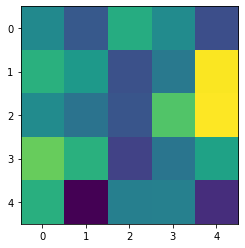

26 23


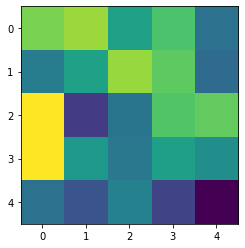

26 24


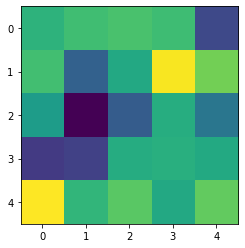

26 25


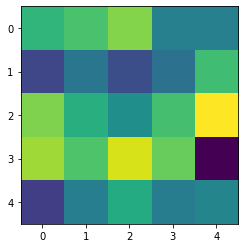

26 26


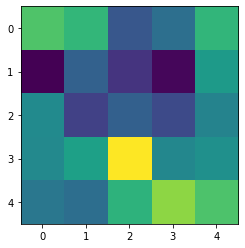

26 27


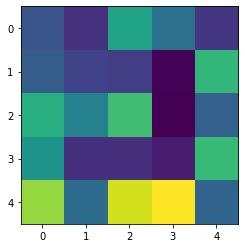

26 28


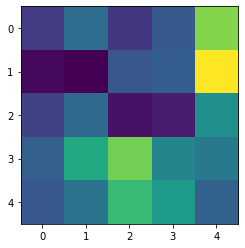

26 29


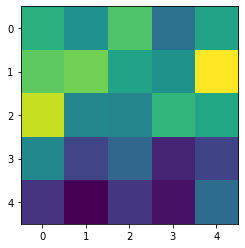

26 30


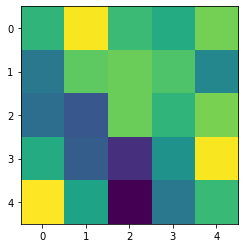

26 31


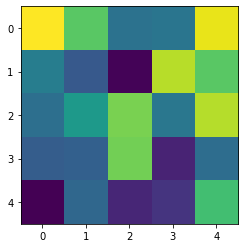

27 0


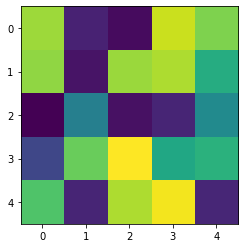

27 1


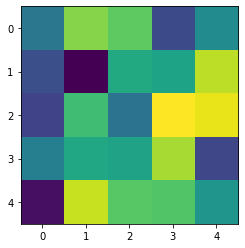

27 2


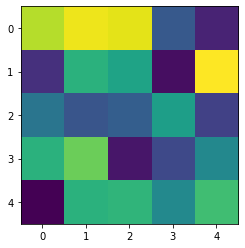

27 3


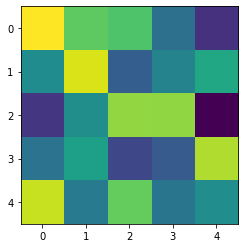

27 4


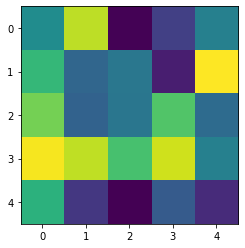

27 5


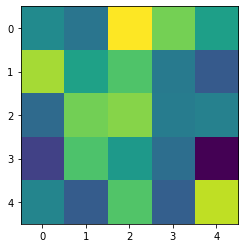

27 6


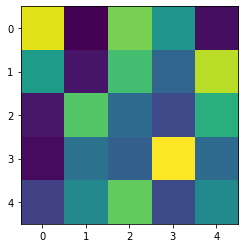

27 7


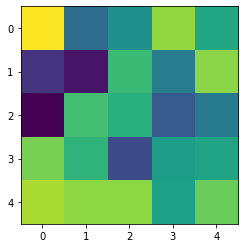

27 8


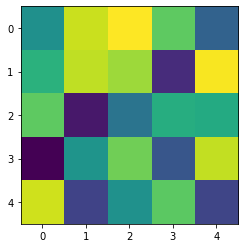

27 9


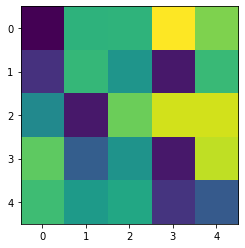

27 10


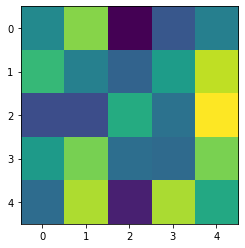

27 11


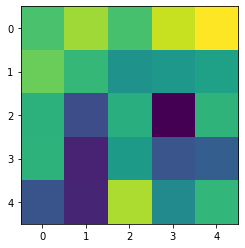

27 12


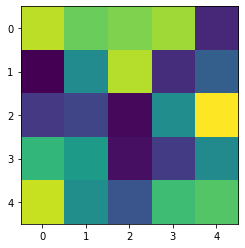

27 13


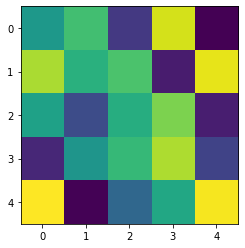

27 14


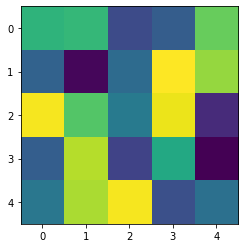

27 15


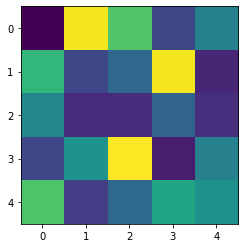

27 16


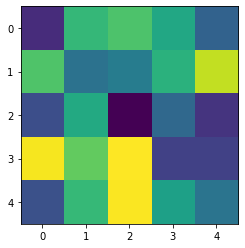

27 17


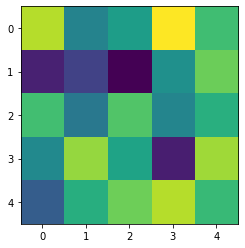

27 18


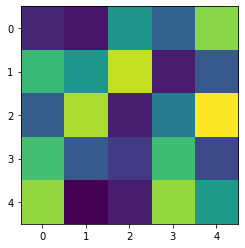

27 19


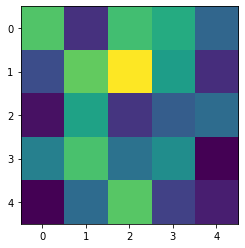

27 20


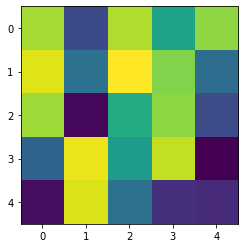

27 21


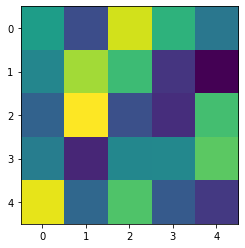

27 22


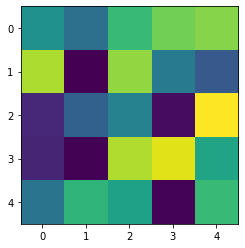

27 23


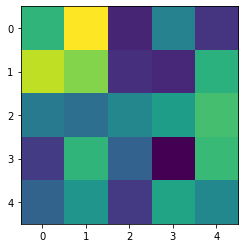

27 24


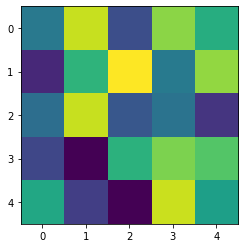

27 25


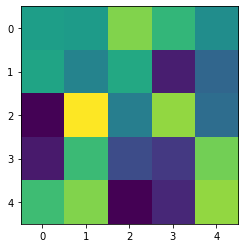

27 26


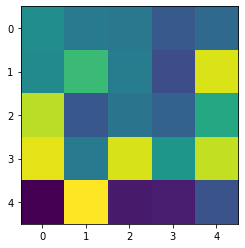

27 27


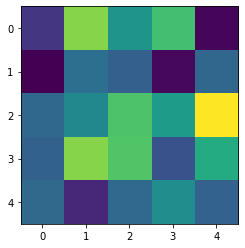

27 28


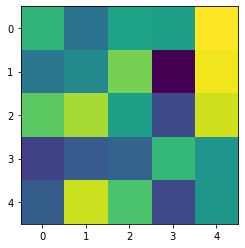

27 29


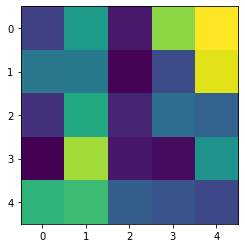

27 30


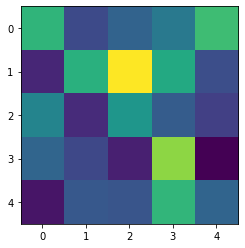

27 31


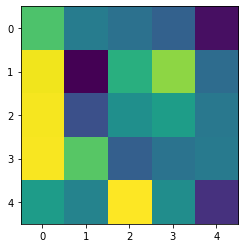

28 0


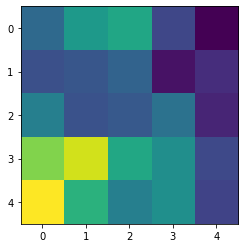

28 1


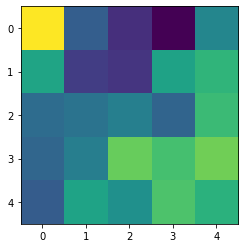

28 2


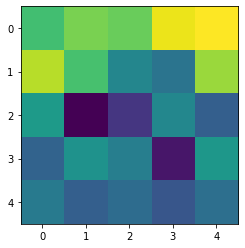

28 3


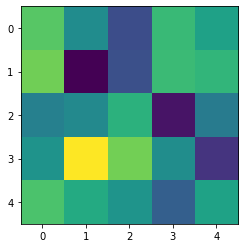

28 4


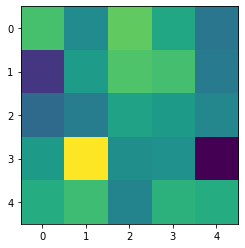

28 5


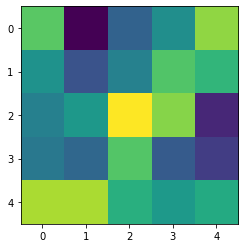

28 6


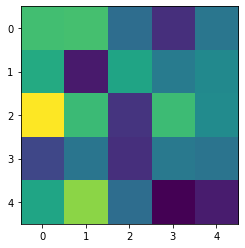

28 7


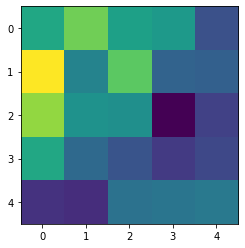

28 8


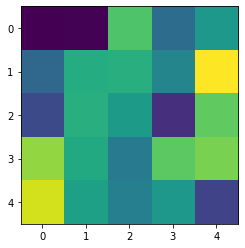

28 9


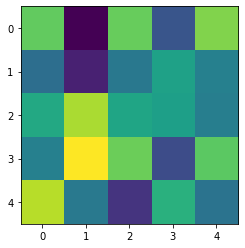

28 10


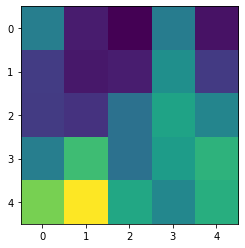

28 11


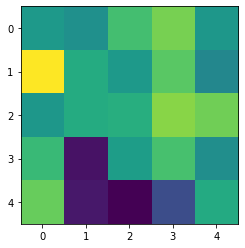

28 12


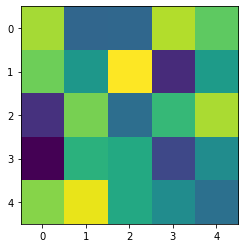

28 13


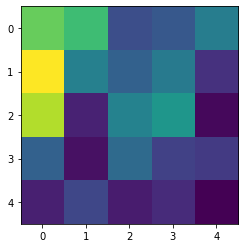

28 14


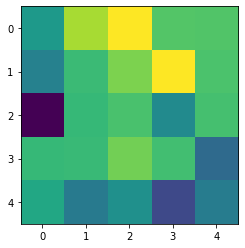

28 15


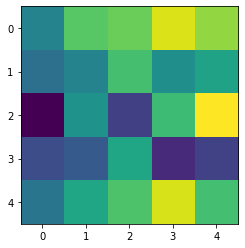

28 16


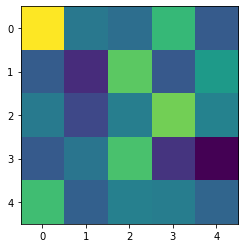

28 17


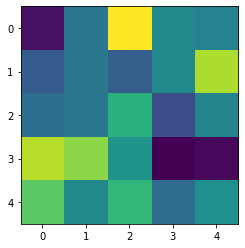

28 18


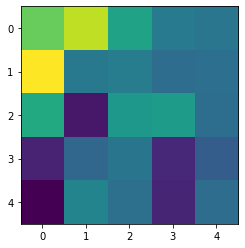

28 19


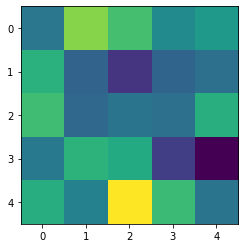

28 20


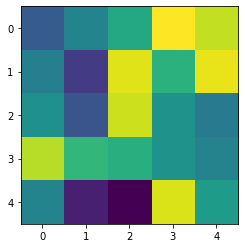

28 21


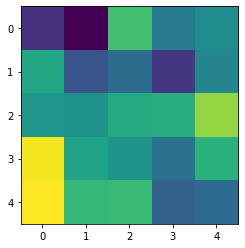

28 22


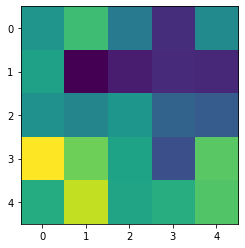

28 23


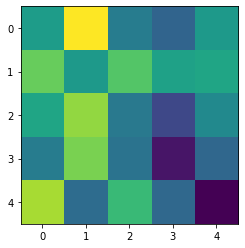

28 24


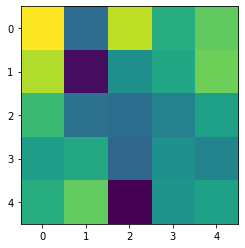

28 25


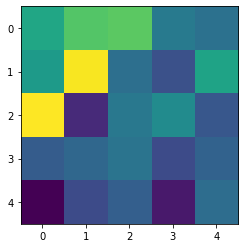

28 26


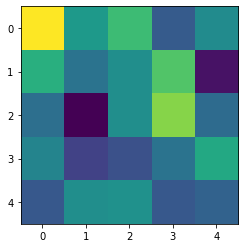

28 27


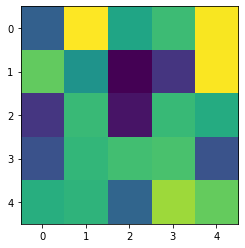

28 28


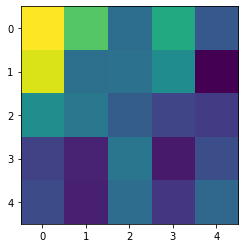

28 29


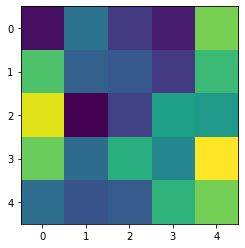

28 30


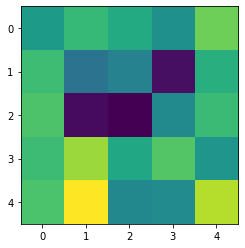

28 31


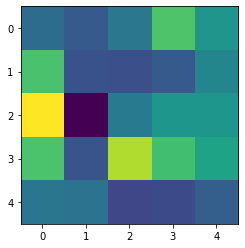

29 0


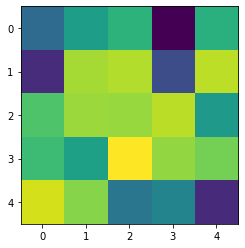

29 1


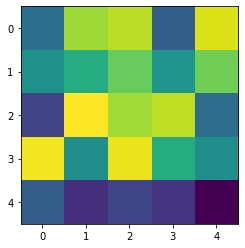

29 2


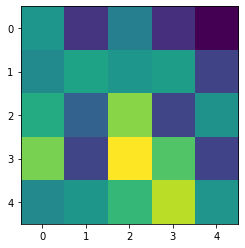

29 3


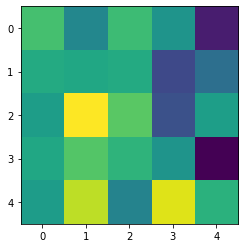

29 4


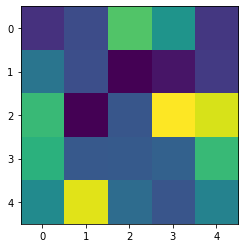

29 5


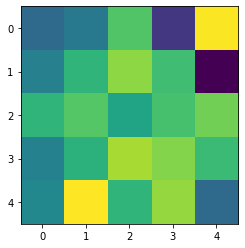

29 6


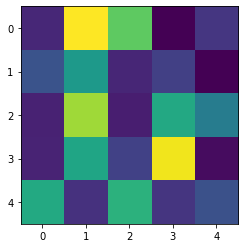

29 7


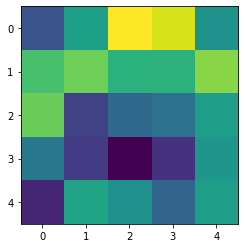

29 8


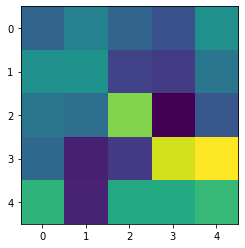

29 9


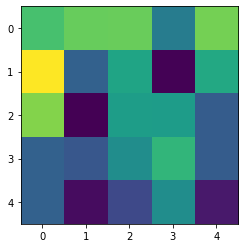

29 10


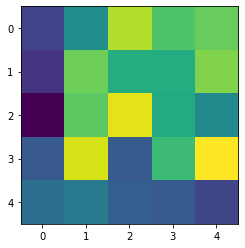

29 11


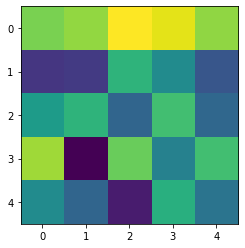

29 12


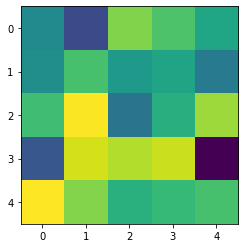

29 13


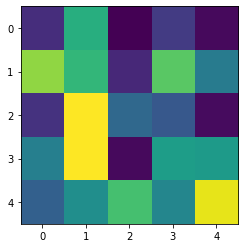

29 14


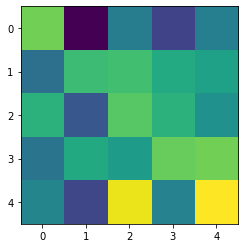

29 15


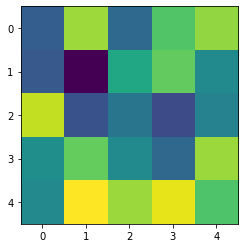

29 16


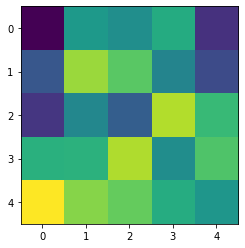

29 17


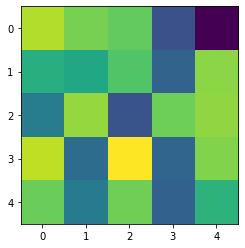

29 18


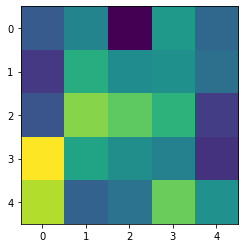

29 19


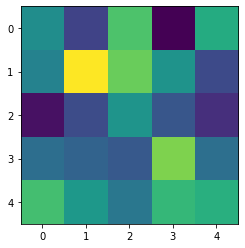

29 20


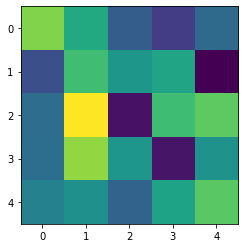

29 21


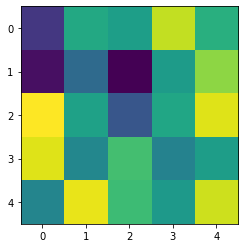

29 22


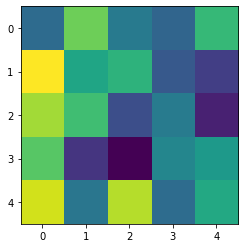

29 23


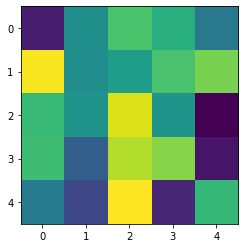

29 24


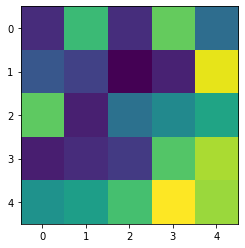

29 25


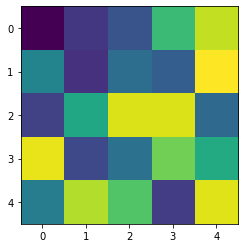

29 26


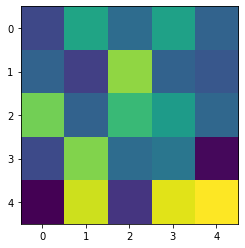

29 27


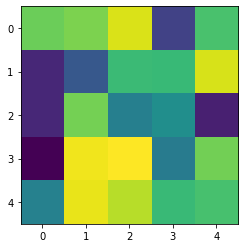

29 28


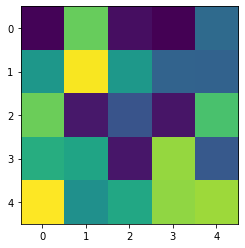

29 29


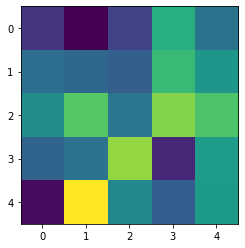

29 30


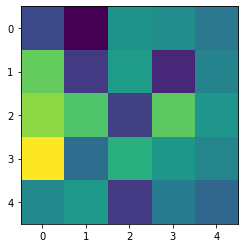

29 31


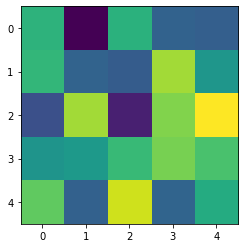

30 0


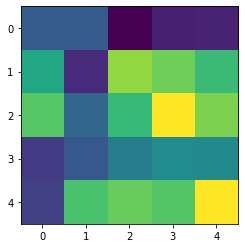

30 1


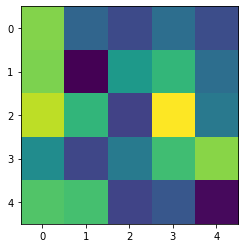

30 2


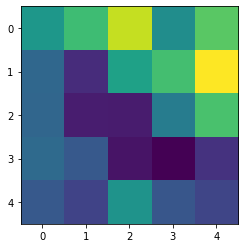

30 3


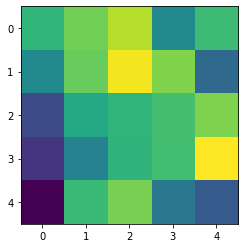

30 4


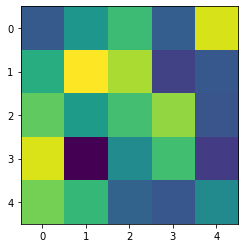

30 5


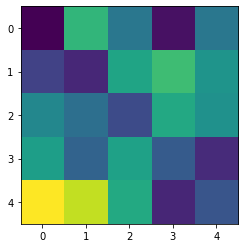

30 6


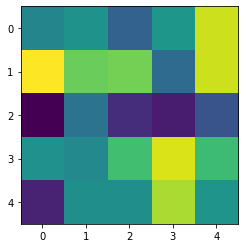

30 7


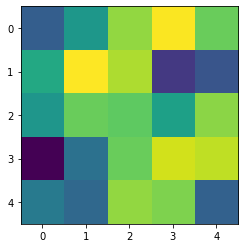

30 8


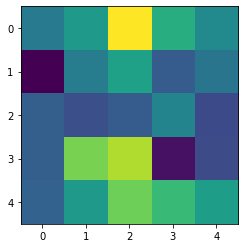

30 9


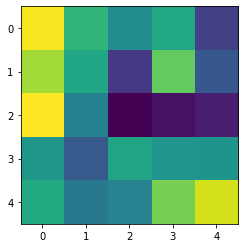

30 10


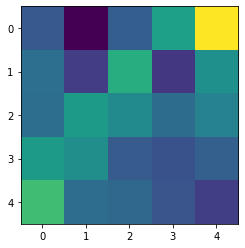

30 11


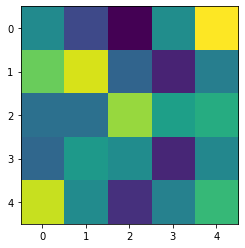

30 12


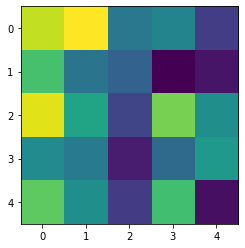

30 13


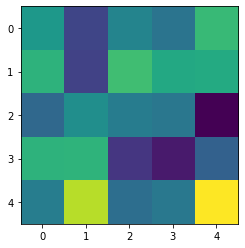

30 14


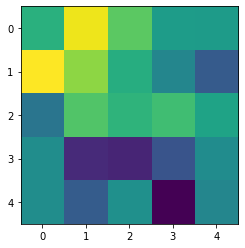

30 15


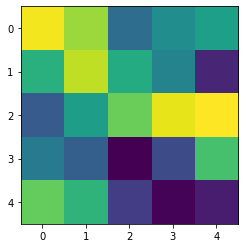

30 16


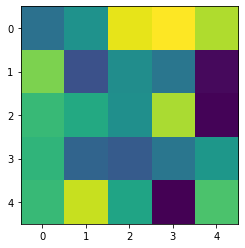

30 17


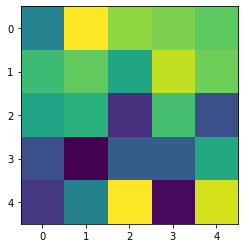

30 18


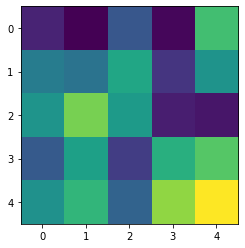

30 19


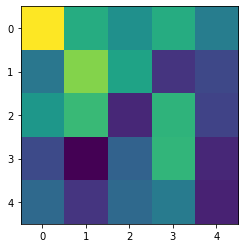

30 20


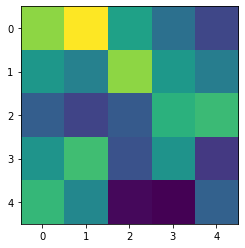

30 21


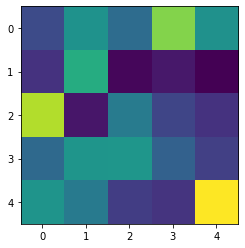

30 22


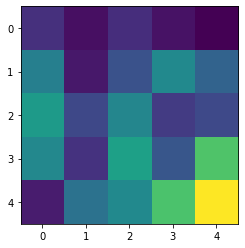

30 23


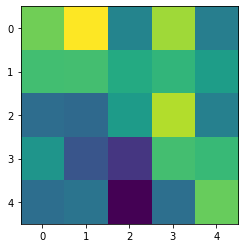

30 24


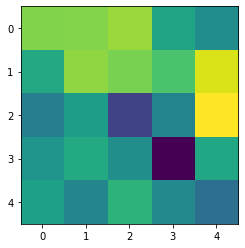

30 25


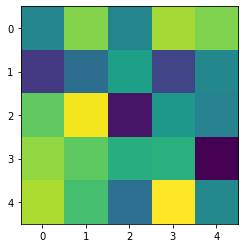

30 26


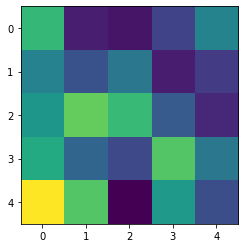

30 27


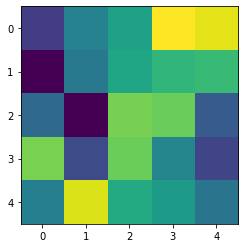

30 28


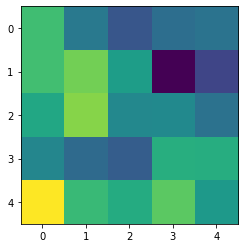

30 29


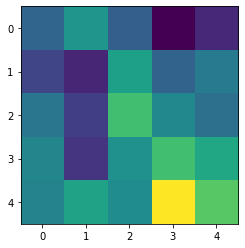

30 30


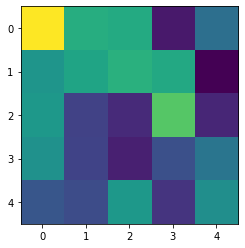

30 31


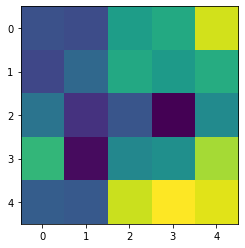

31 0


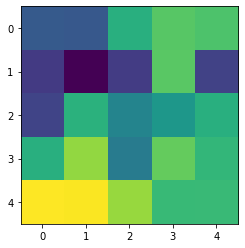

31 1


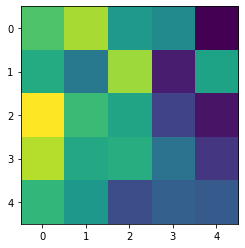

31 2


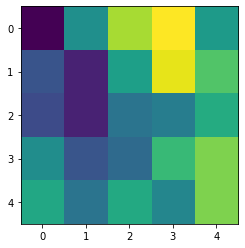

31 3


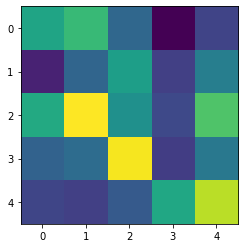

31 4


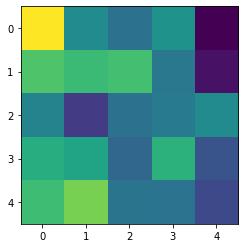

31 5


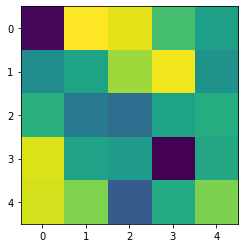

31 6


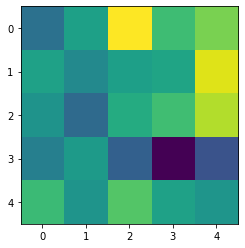

31 7


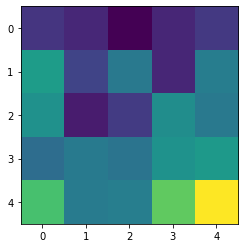

31 8


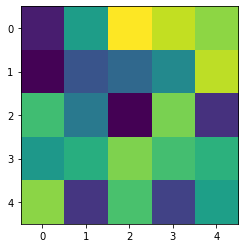

31 9


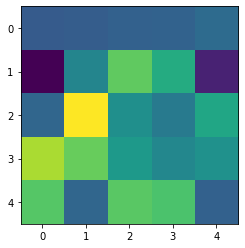

31 10


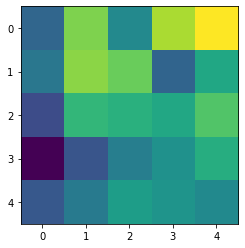

31 11


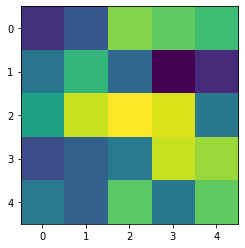

31 12


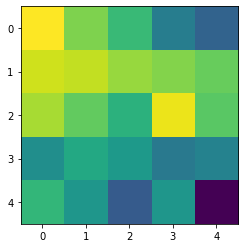

31 13


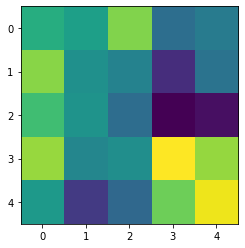

31 14


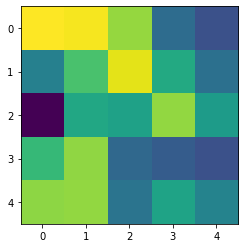

31 15


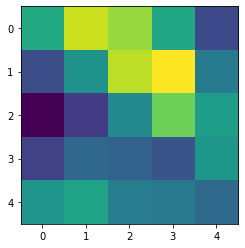

31 16


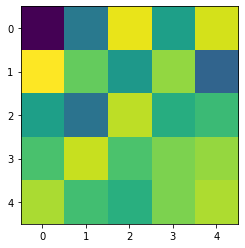

31 17


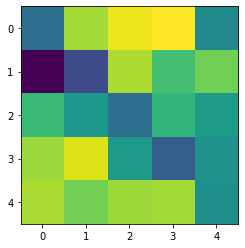

31 18


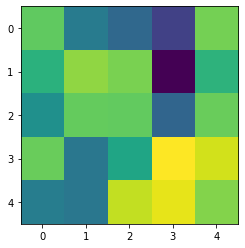

31 19


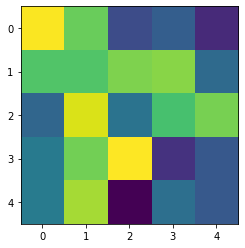

31 20


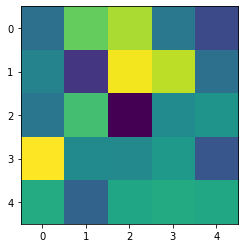

31 21


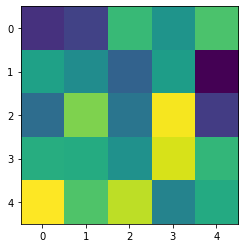

31 22


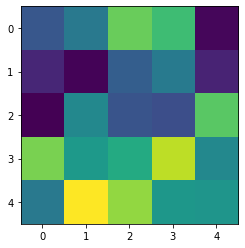

31 23


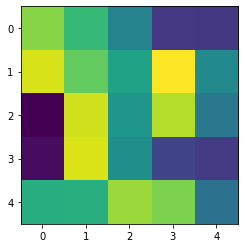

31 24


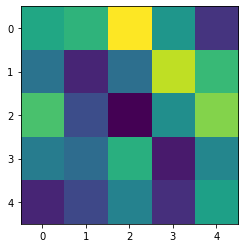

31 25


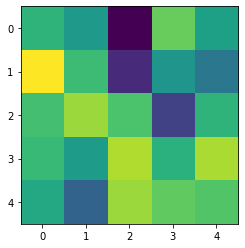

31 26


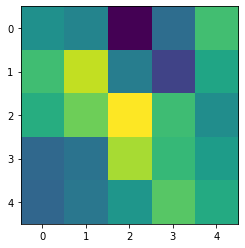

31 27


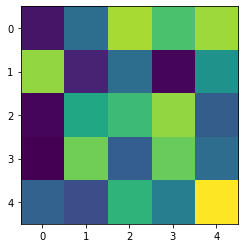

31 28


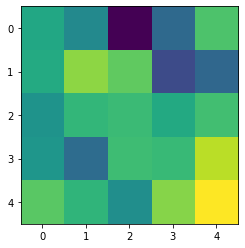

31 29


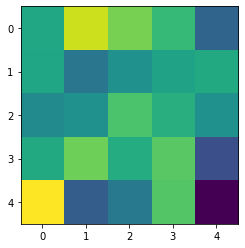

31 30


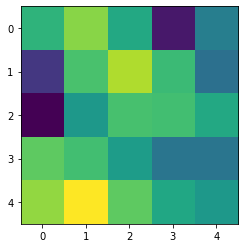

31 31


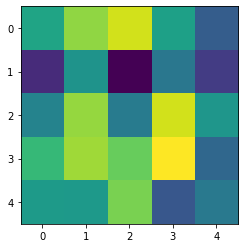

32 0


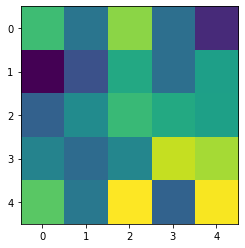

32 1


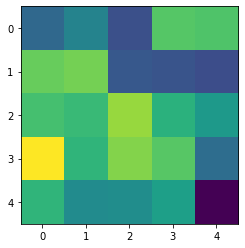

32 2


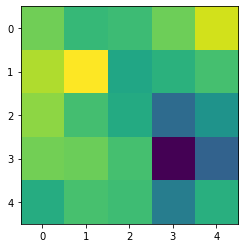

32 3


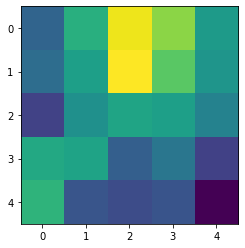

32 4


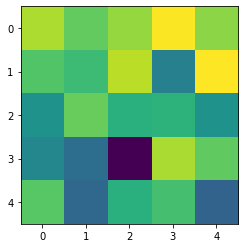

32 5


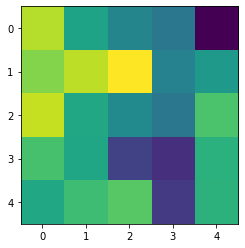

32 6


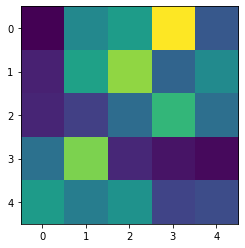

32 7


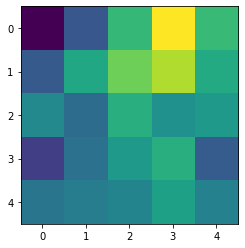

32 8


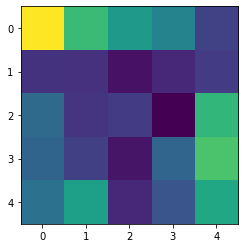

32 9


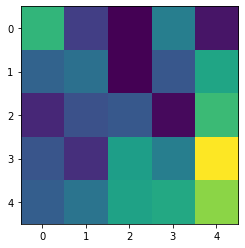

32 10


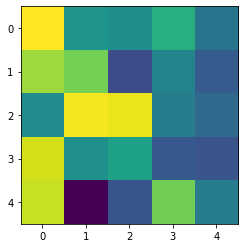

32 11


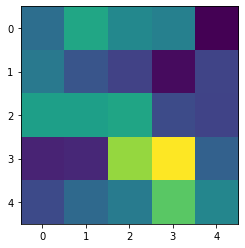

32 12


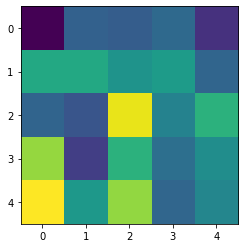

32 13


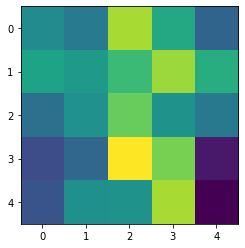

32 14


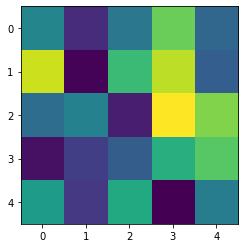

32 15


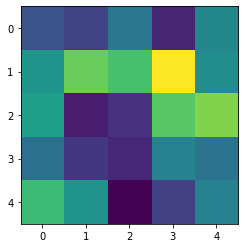

32 16


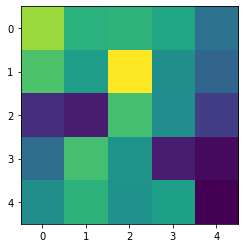

32 17


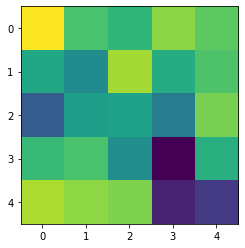

32 18


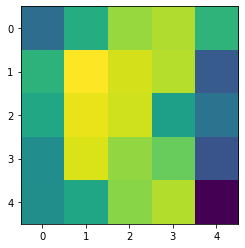

32 19


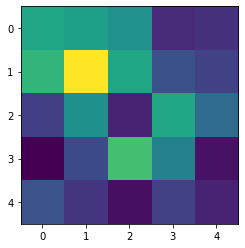

32 20


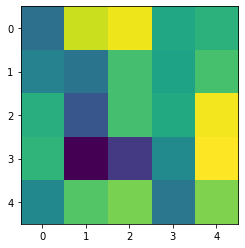

32 21


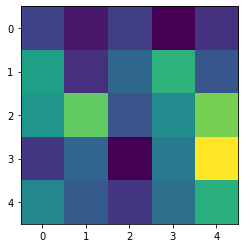

32 22


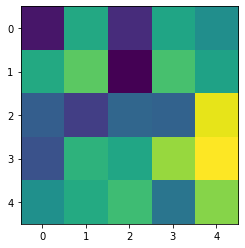

32 23


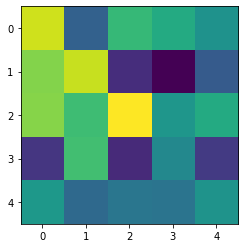

32 24


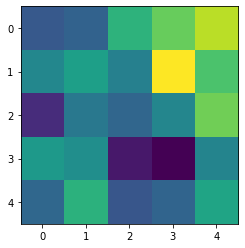

32 25


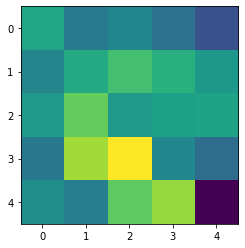

32 26


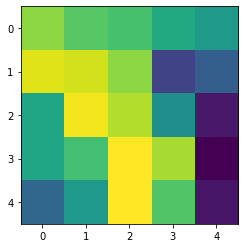

32 27


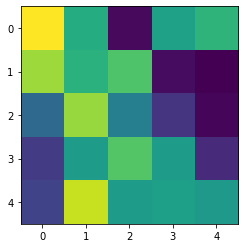

32 28


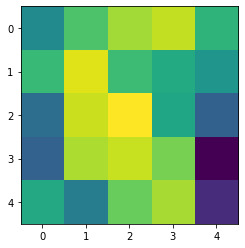

32 29


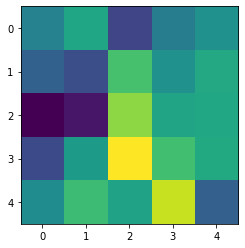

32 30


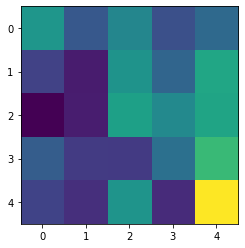

32 31


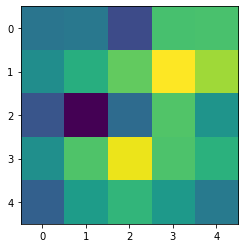

33 0


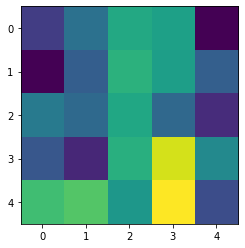

33 1


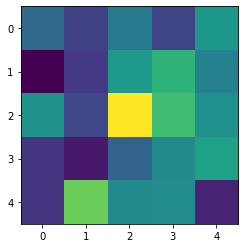

33 2


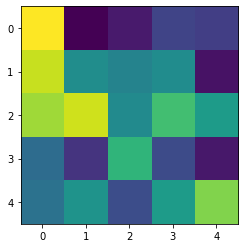

33 3


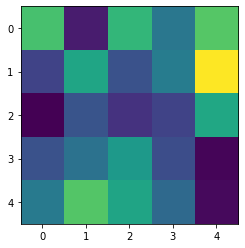

33 4


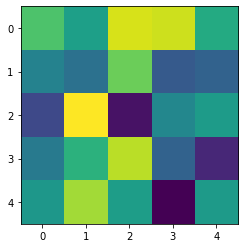

33 5


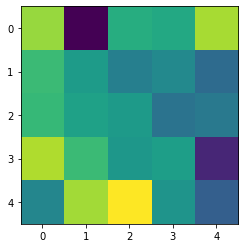

33 6


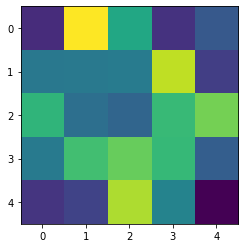

33 7


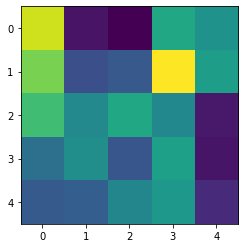

33 8


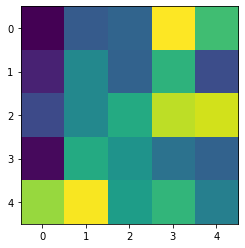

33 9


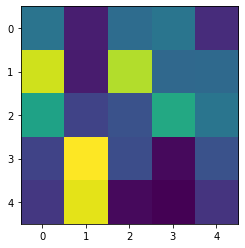

33 10


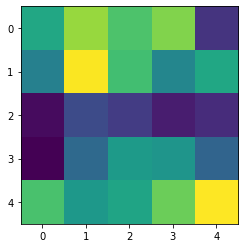

33 11


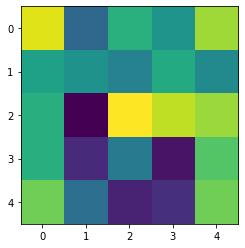

33 12


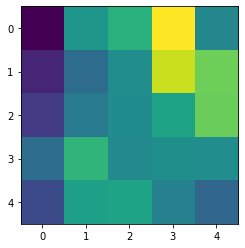

33 13


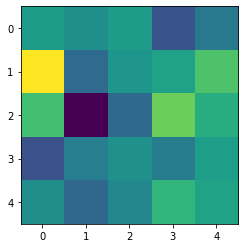

33 14


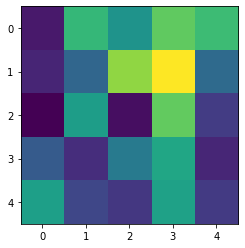

33 15


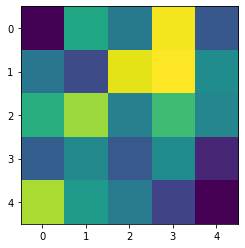

33 16


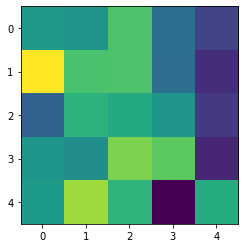

33 17


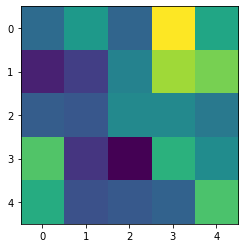

33 18


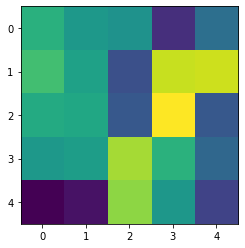

33 19


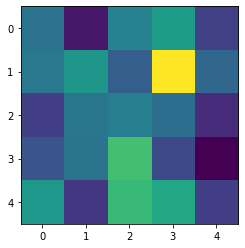

33 20


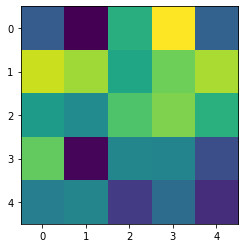

33 21


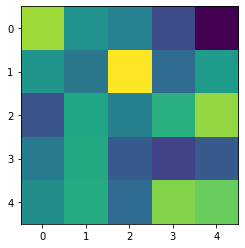

33 22


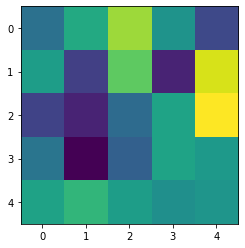

33 23


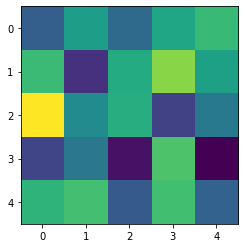

33 24


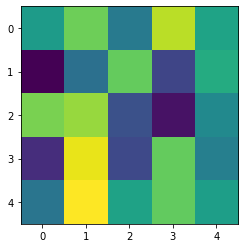

33 25


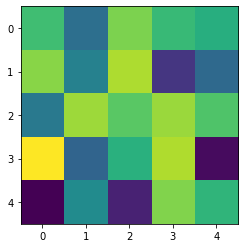

33 26


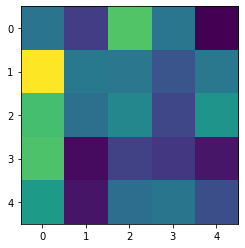

33 27


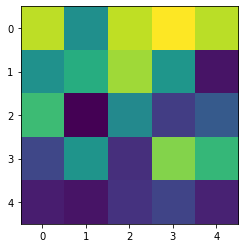

33 28


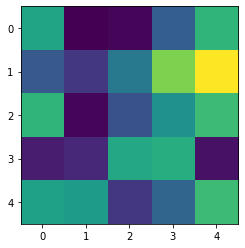

33 29


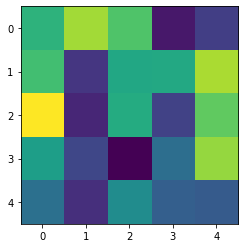

33 30


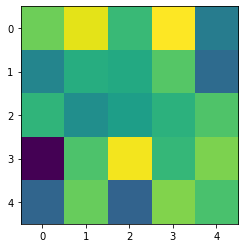

33 31


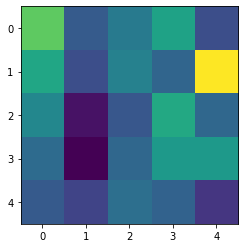

34 0


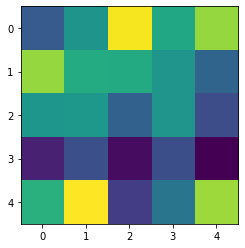

34 1


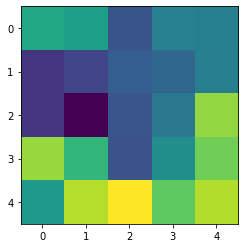

34 2


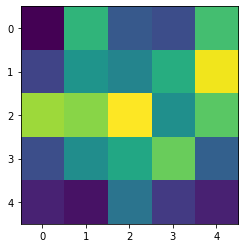

34 3


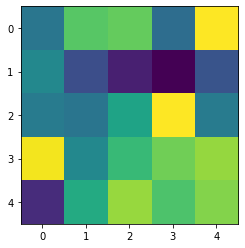

34 4


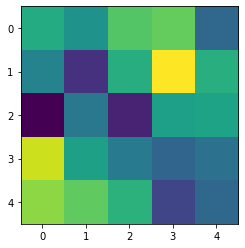

34 5


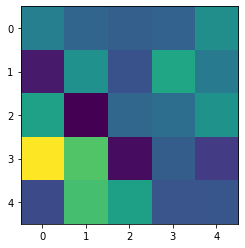

34 6


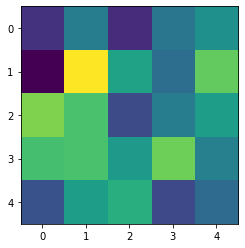

34 7


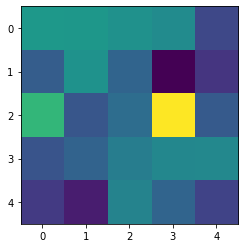

34 8


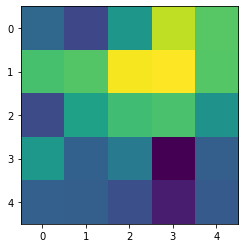

34 9


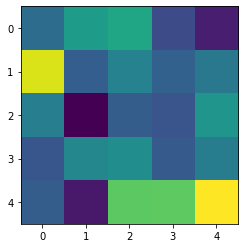

34 10


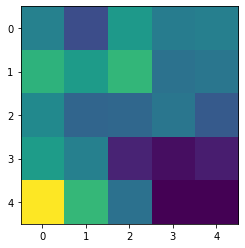

34 11


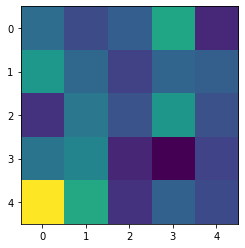

34 12


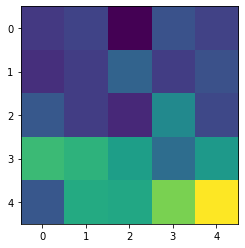

34 13


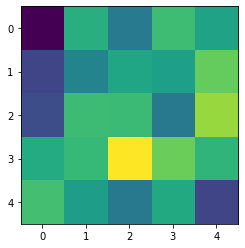

34 14


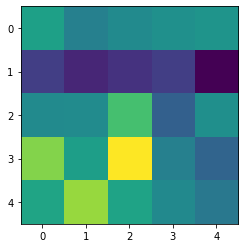

34 15


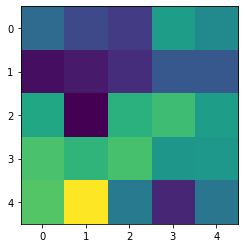

34 16


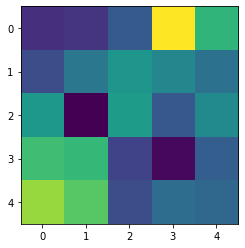

34 17


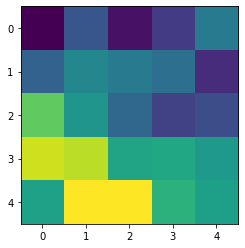

34 18


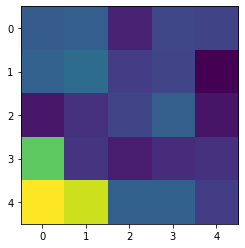

34 19


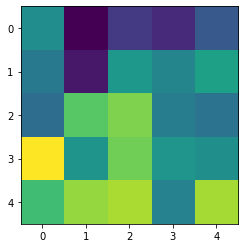

34 20


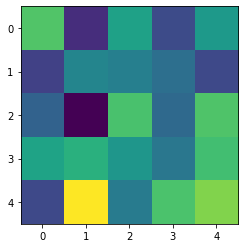

34 21


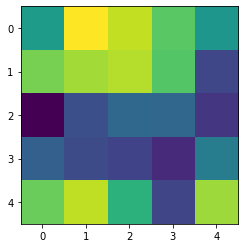

34 22


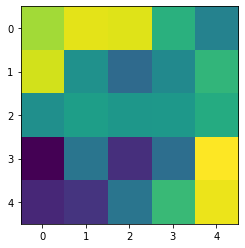

34 23


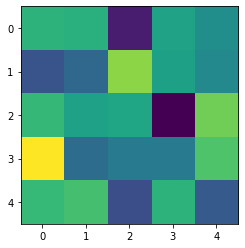

34 24


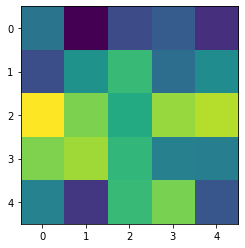

34 25


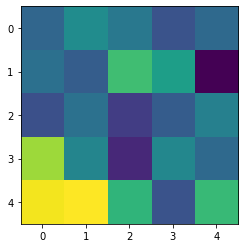

34 26


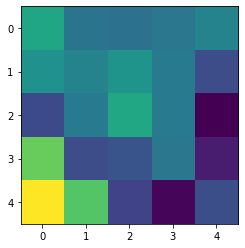

34 27


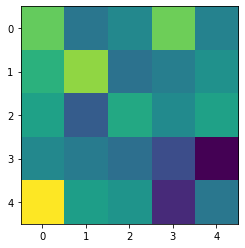

34 28


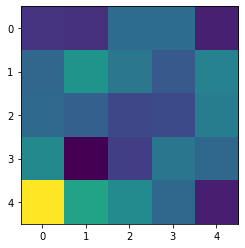

34 29


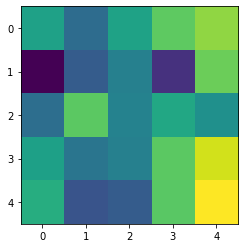

34 30


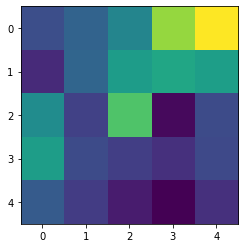

34 31


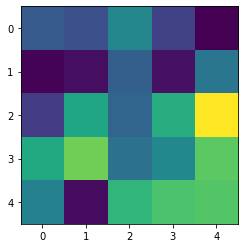

35 0


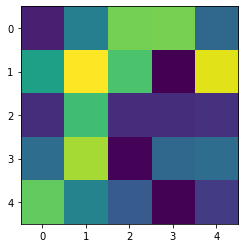

35 1


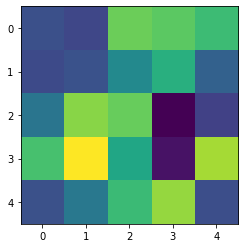

35 2


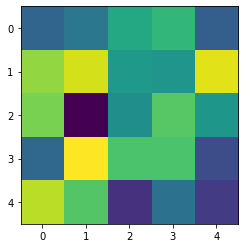

35 3


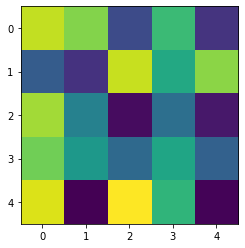

35 4


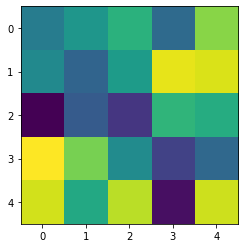

35 5


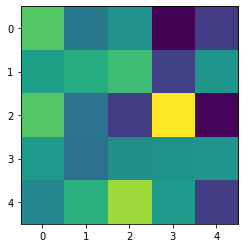

35 6


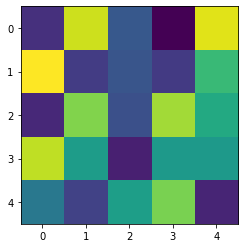

35 7


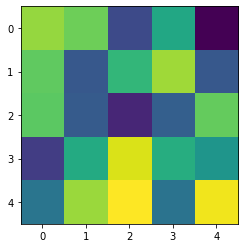

35 8


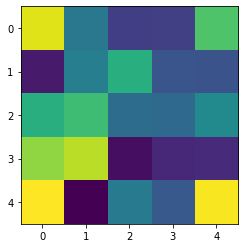

35 9


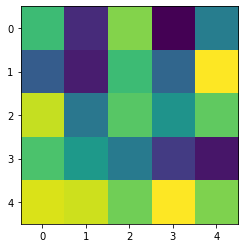

35 10


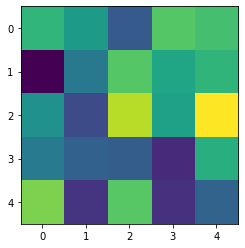

35 11


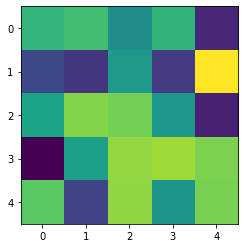

35 12


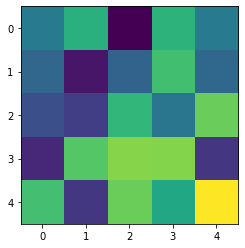

35 13


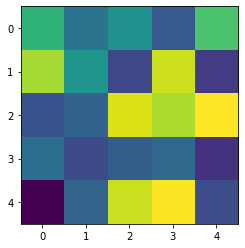

35 14


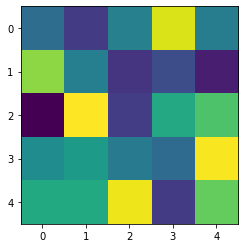

35 15


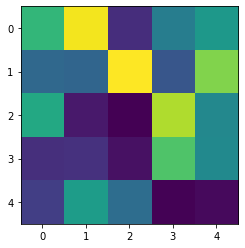

35 16


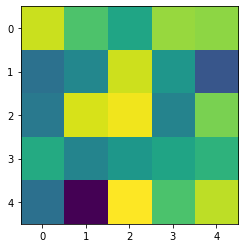

35 17


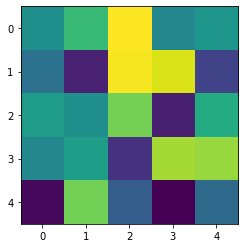

35 18


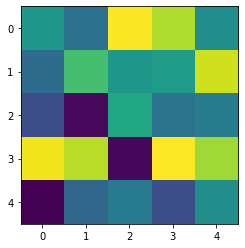

35 19


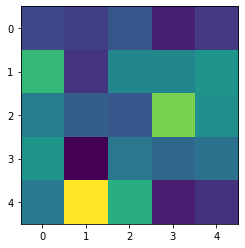

35 20


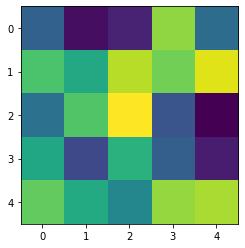

35 21


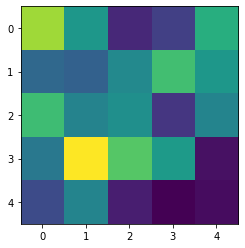

35 22


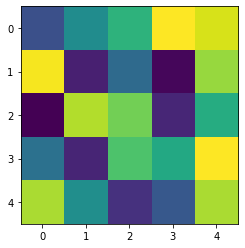

35 23


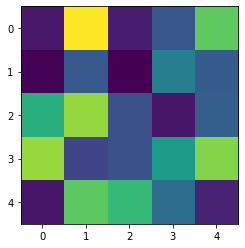

35 24


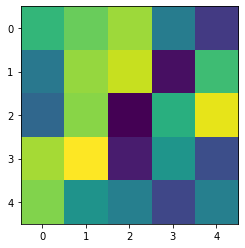

35 25


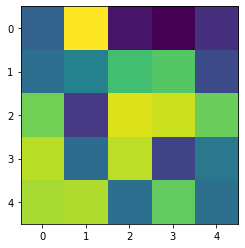

35 26


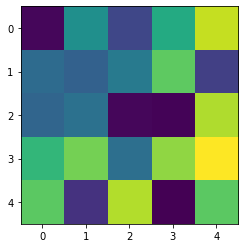

35 27


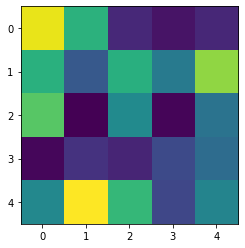

35 28


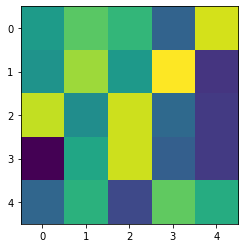

35 29


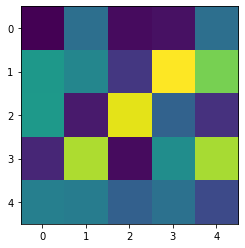

35 30


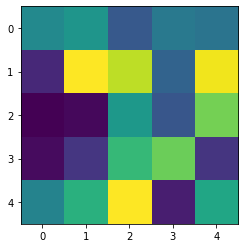

35 31


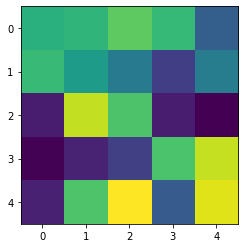

36 0


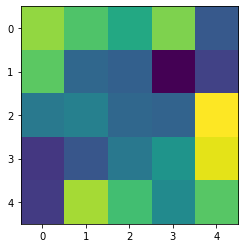

36 1


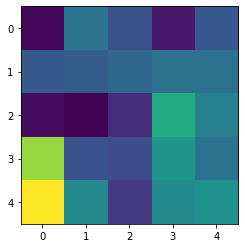

36 2


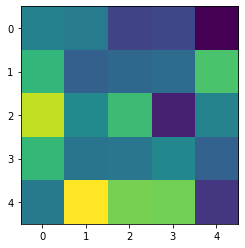

36 3


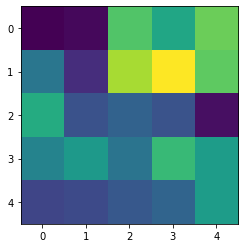

36 4


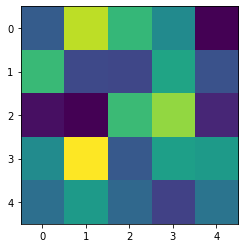

36 5


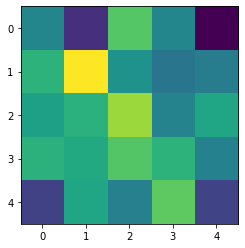

36 6


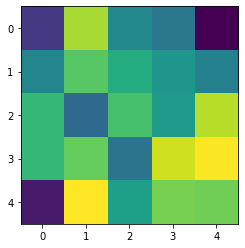

36 7


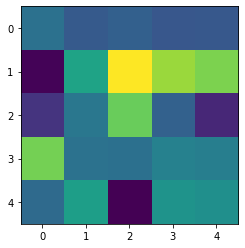

36 8


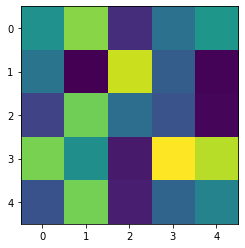

36 9


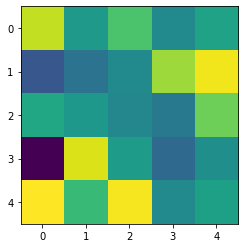

36 10


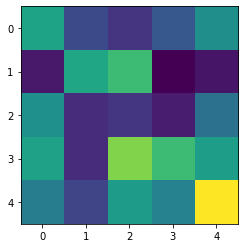

36 11


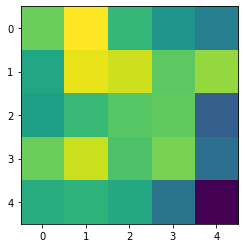

36 12


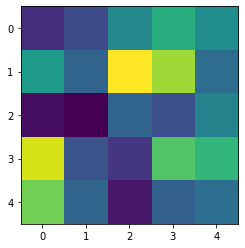

36 13


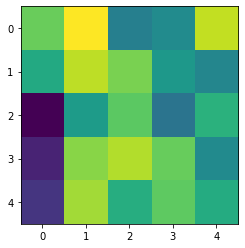

36 14


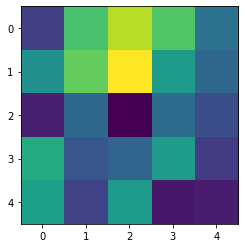

36 15


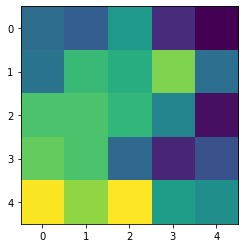

36 16


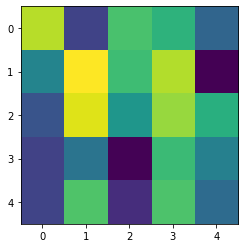

36 17


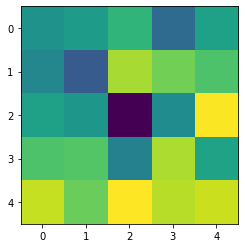

36 18


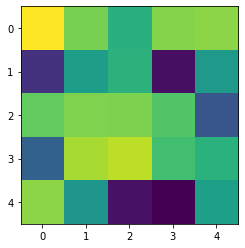

36 19


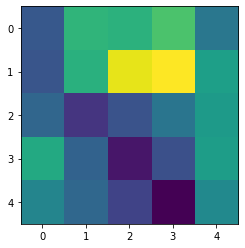

36 20


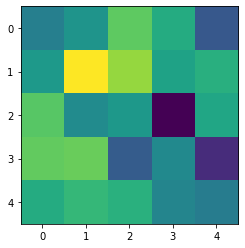

36 21


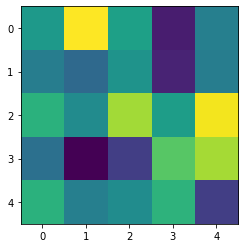

36 22


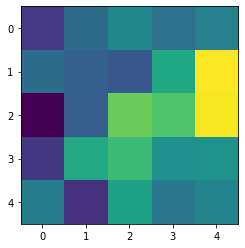

36 23


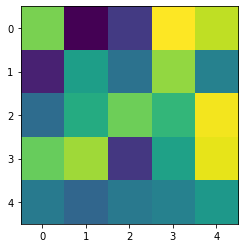

36 24


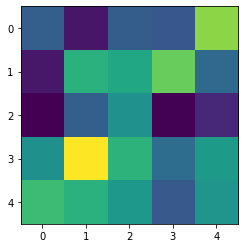

36 25


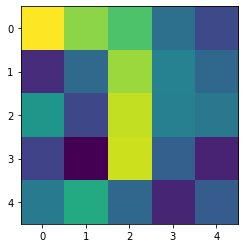

36 26


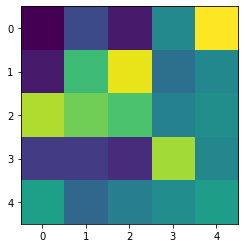

36 27


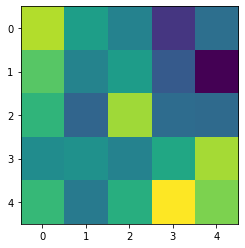

36 28


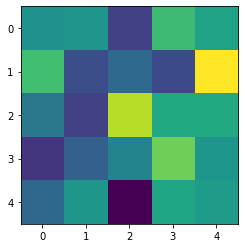

36 29


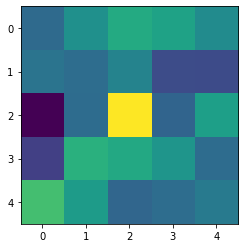

36 30


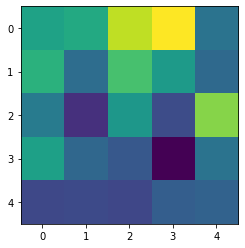

36 31


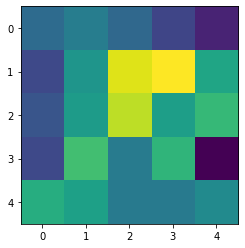

37 0


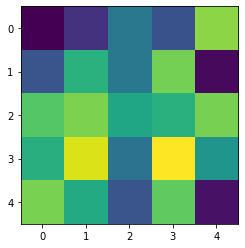

37 1


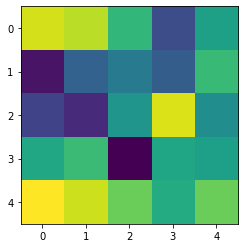

37 2


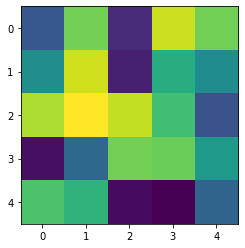

37 3


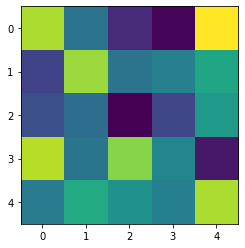

37 4


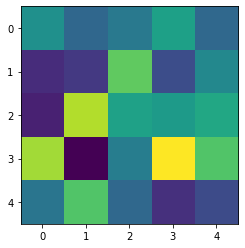

37 5


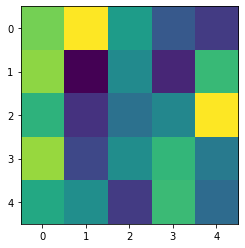

37 6


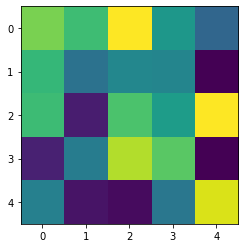

37 7


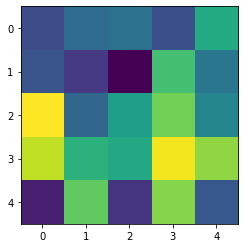

37 8


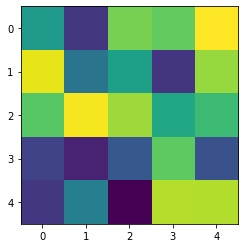

37 9


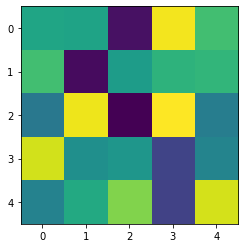

37 10


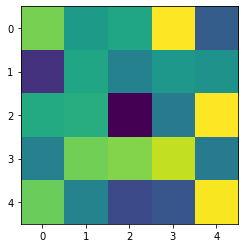

37 11


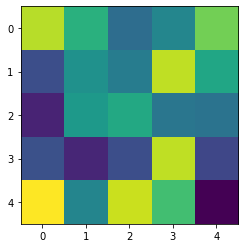

37 12


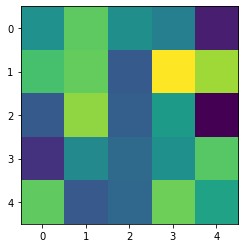

37 13


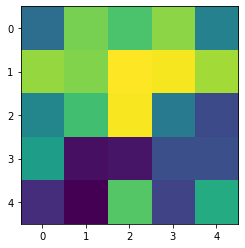

37 14


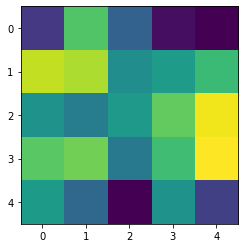

37 15


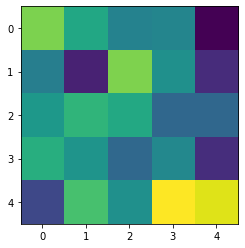

37 16


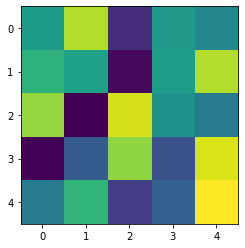

37 17


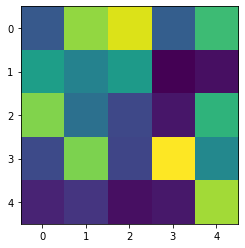

37 18


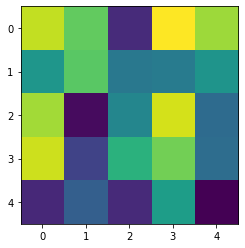

37 19


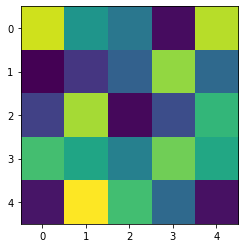

37 20


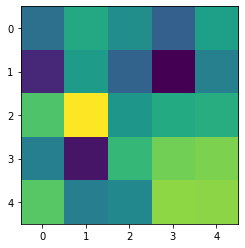

37 21


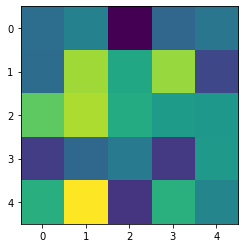

37 22


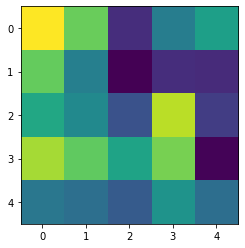

37 23


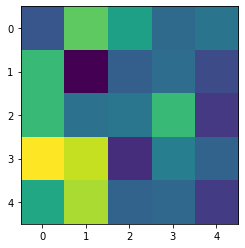

37 24


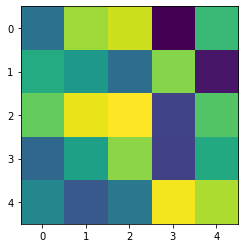

37 25


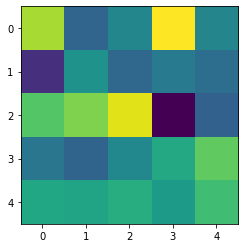

37 26


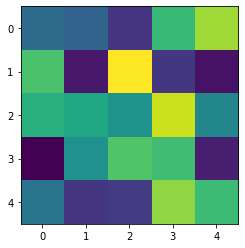

37 27


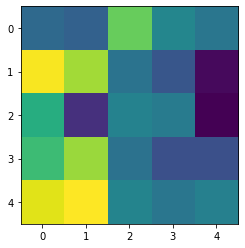

37 28


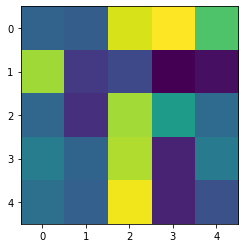

37 29


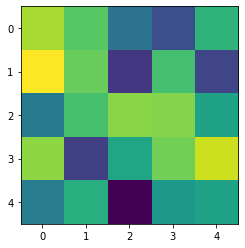

37 30


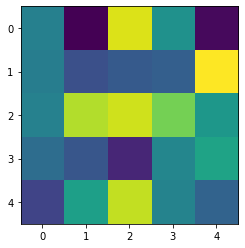

37 31


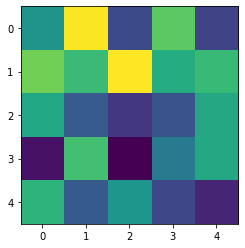

38 0


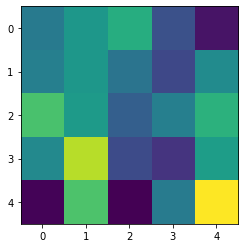

38 1


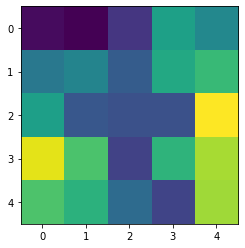

38 2


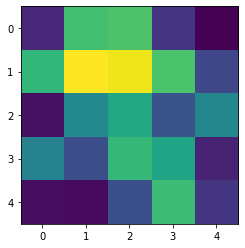

38 3


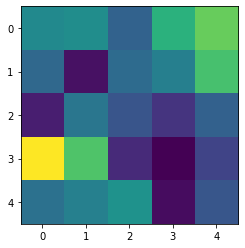

38 4


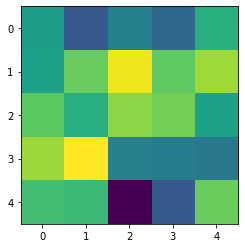

38 5


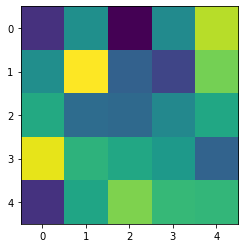

38 6


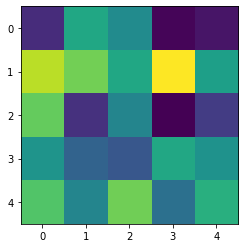

38 7


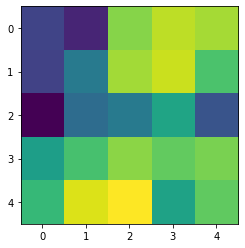

38 8


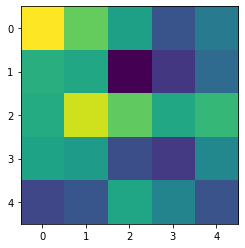

38 9


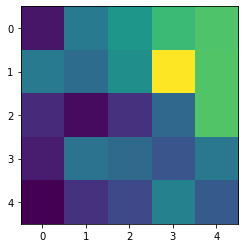

38 10


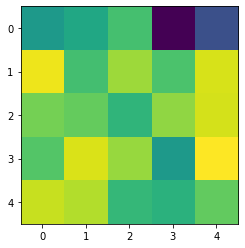

38 11


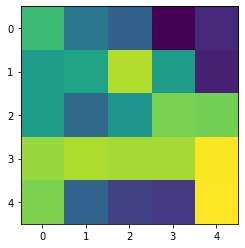

38 12


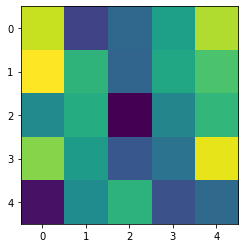

38 13


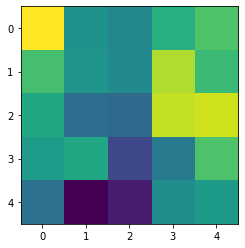

38 14


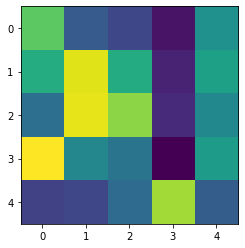

38 15


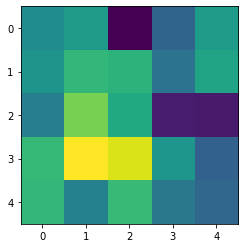

38 16


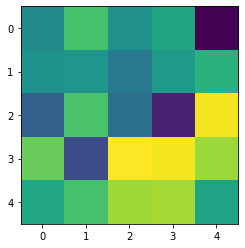

38 17


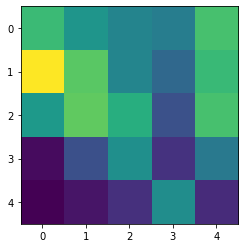

38 18


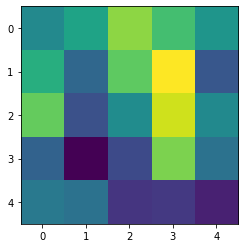

38 19


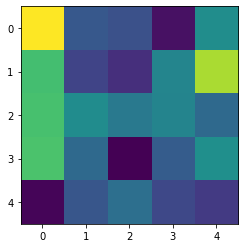

38 20


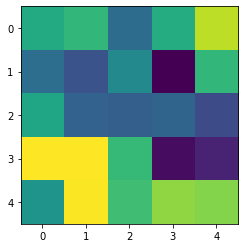

38 21


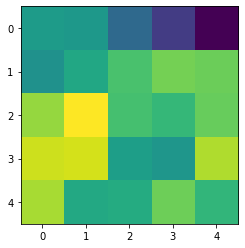

38 22


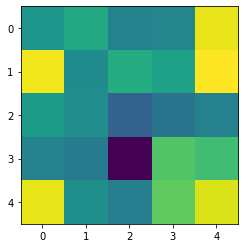

38 23


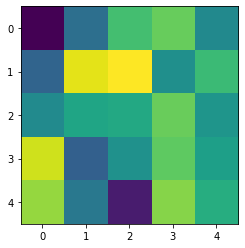

38 24


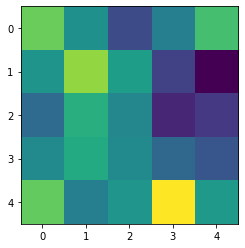

38 25


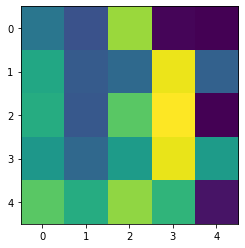

38 26


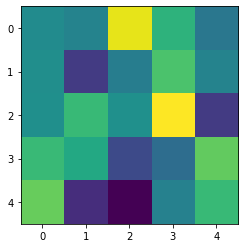

38 27


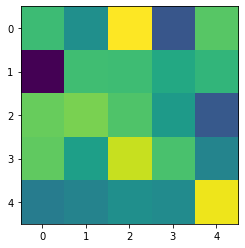

38 28


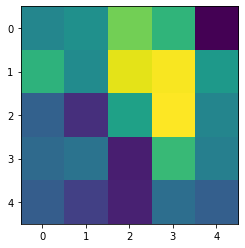

38 29


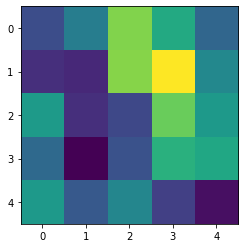

38 30


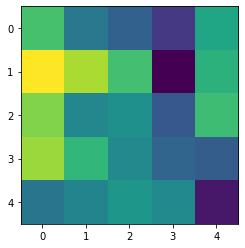

38 31


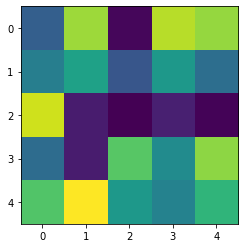

39 0


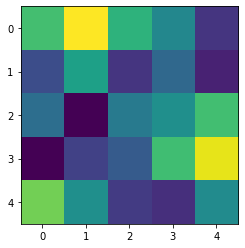

39 1


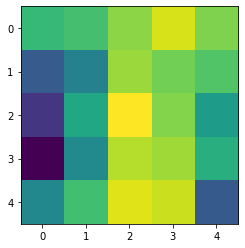

39 2


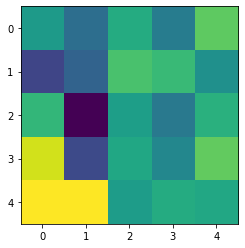

39 3


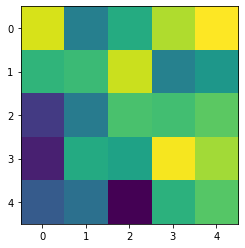

39 4


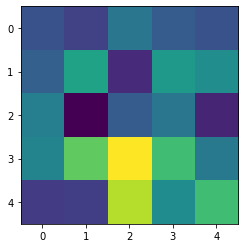

39 5


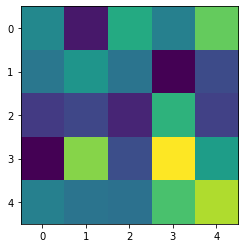

39 6


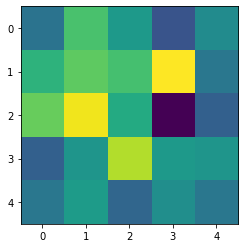

39 7


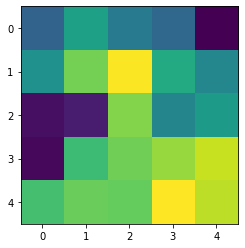

39 8


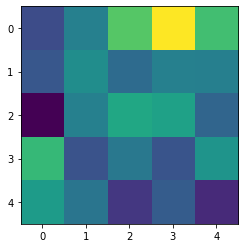

39 9


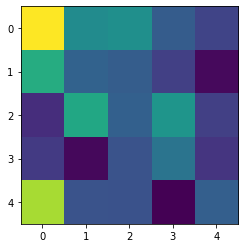

39 10


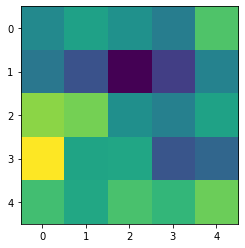

39 11


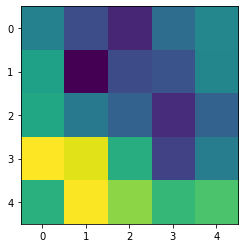

39 12


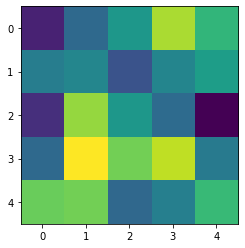

39 13


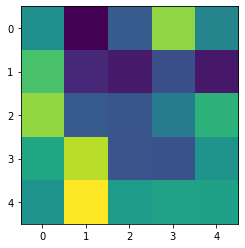

39 14


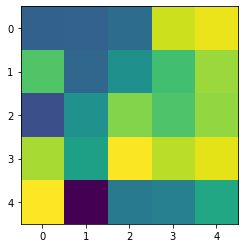

39 15


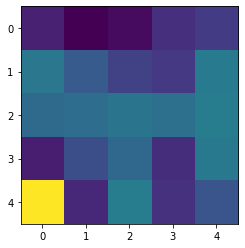

39 16


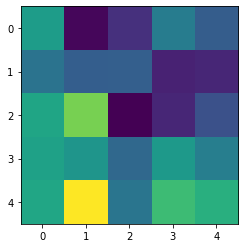

39 17


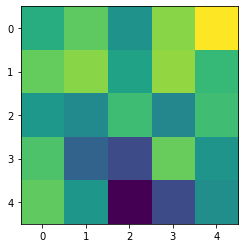

39 18


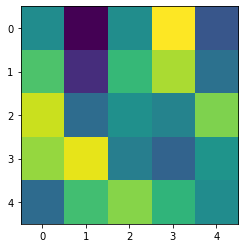

39 19


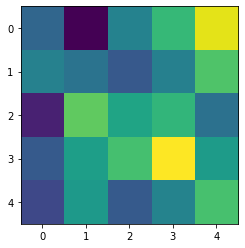

39 20


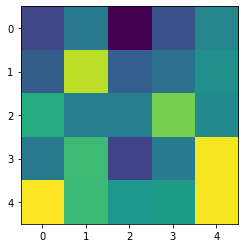

39 21


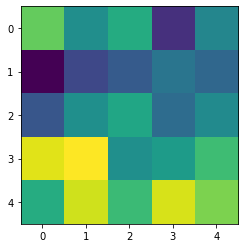

39 22


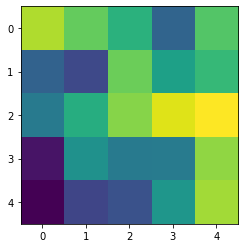

39 23


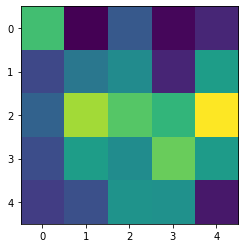

39 24


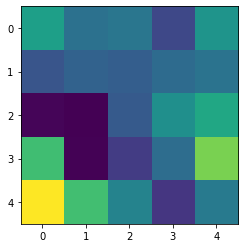

39 25


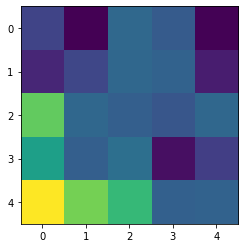

39 26


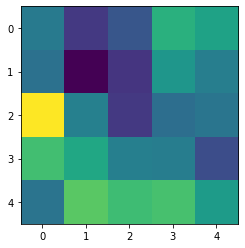

39 27


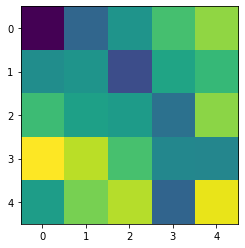

39 28


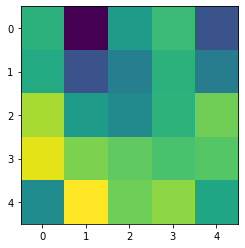

39 29


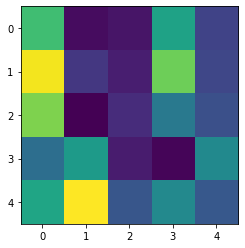

39 30


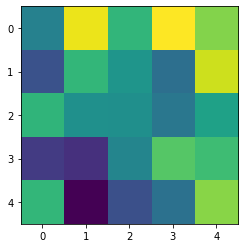

39 31


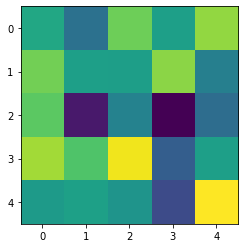

40 0


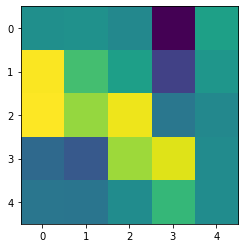

40 1


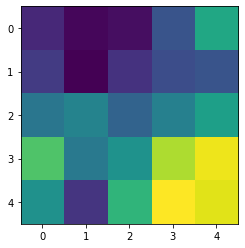

40 2


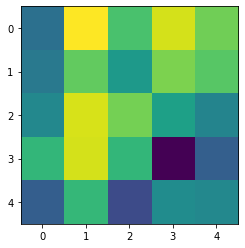

40 3


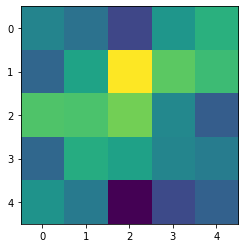

40 4


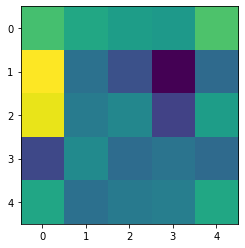

40 5


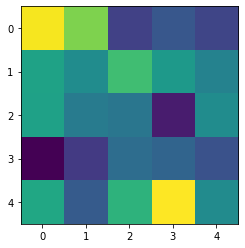

40 6


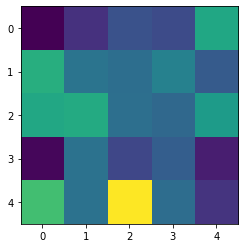

40 7


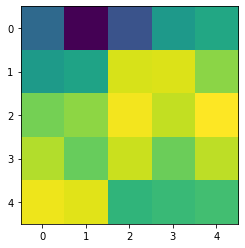

40 8


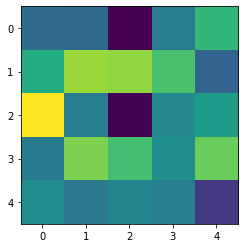

40 9


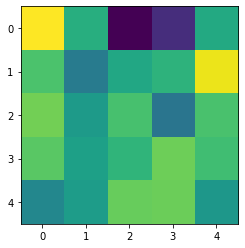

40 10


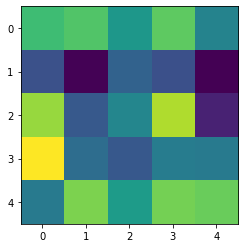

40 11


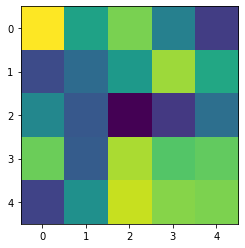

40 12


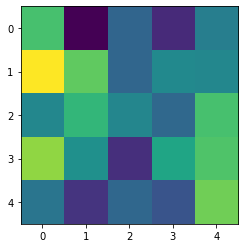

40 13


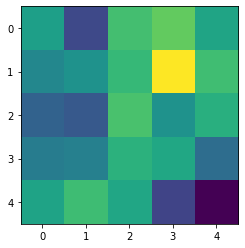

40 14


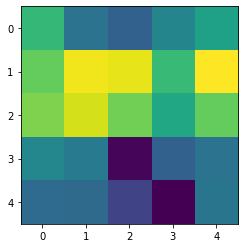

40 15


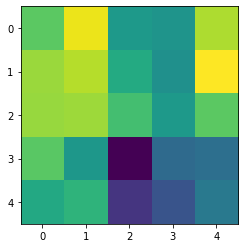

40 16


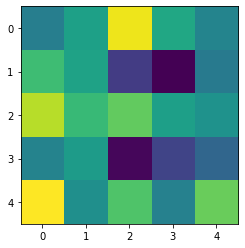

40 17


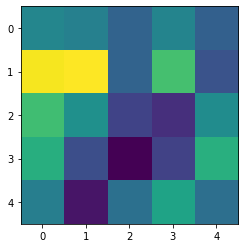

40 18


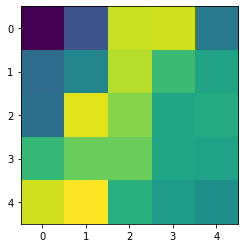

40 19


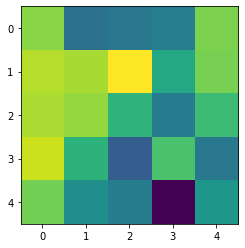

40 20


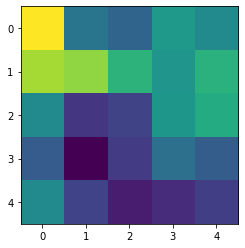

40 21


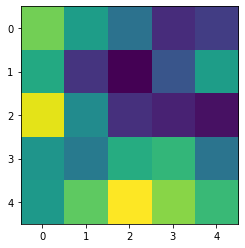

40 22


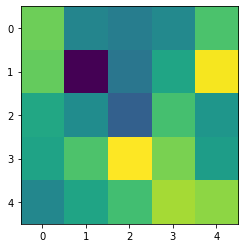

40 23


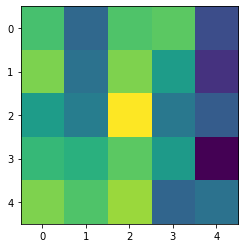

40 24


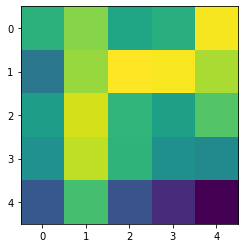

40 25


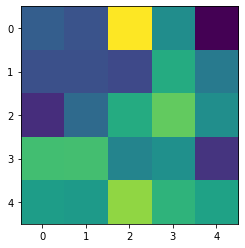

40 26


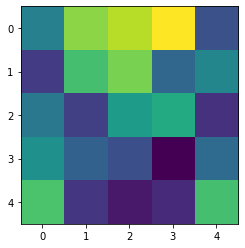

40 27


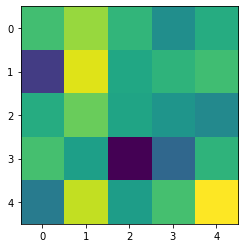

40 28


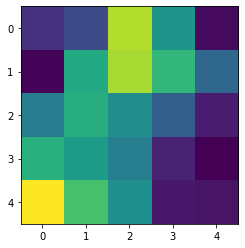

40 29


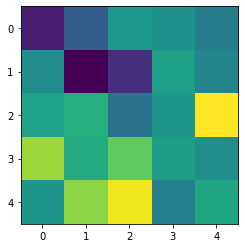

40 30


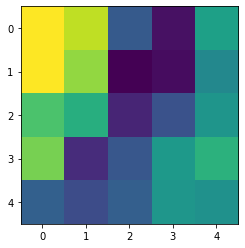

40 31


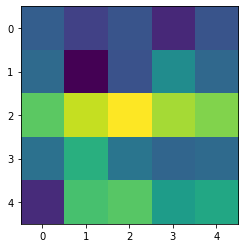

41 0


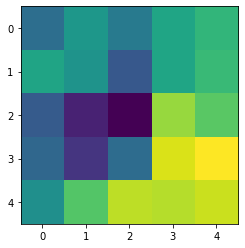

41 1


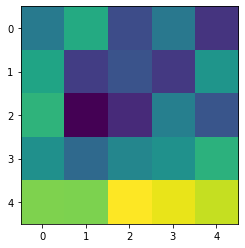

41 2


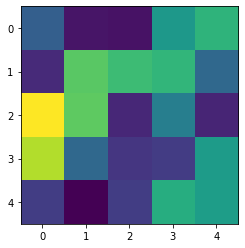

41 3


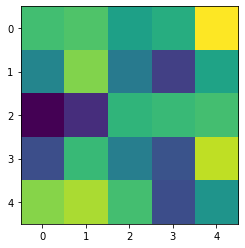

41 4


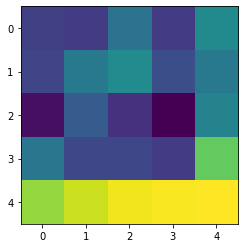

41 5


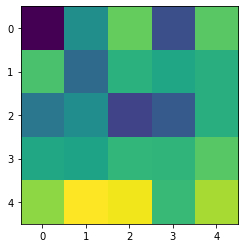

41 6


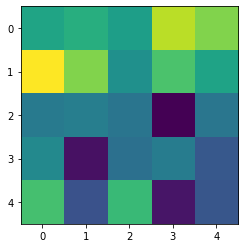

41 7


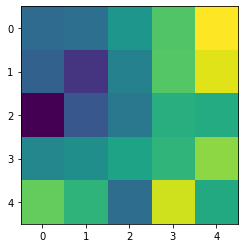

41 8


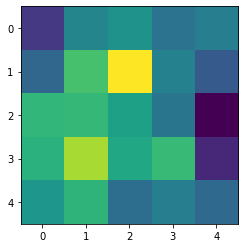

41 9


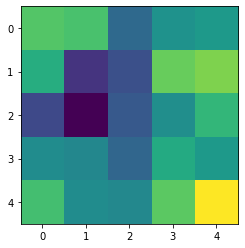

41 10


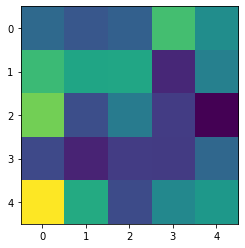

41 11


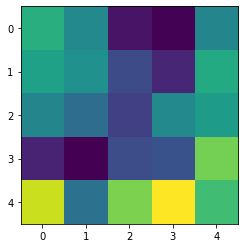

41 12


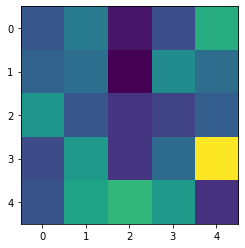

41 13


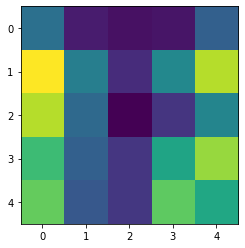

41 14


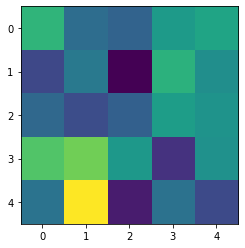

41 15


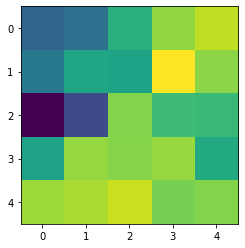

41 16


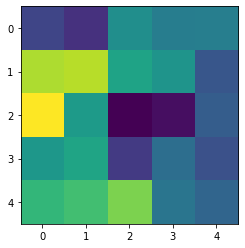

41 17


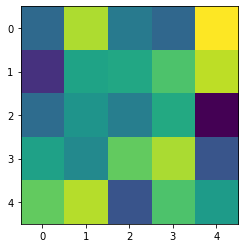

41 18


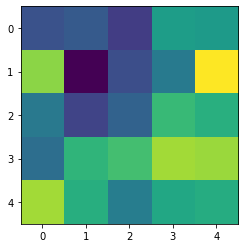

41 19


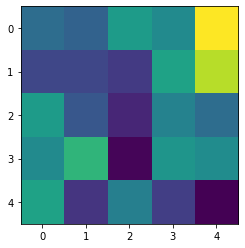

41 20


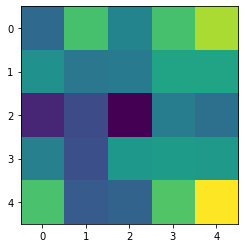

41 21


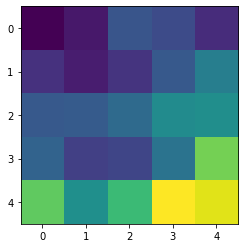

41 22


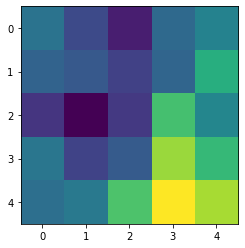

41 23


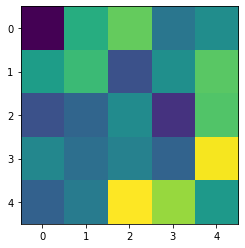

41 24


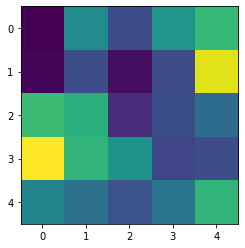

41 25


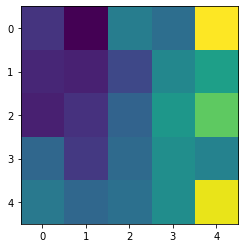

41 26


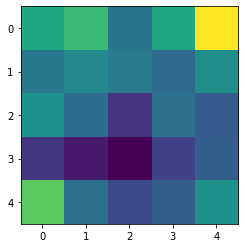

41 27


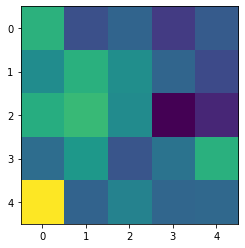

41 28


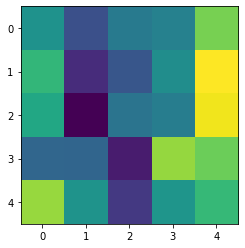

41 29


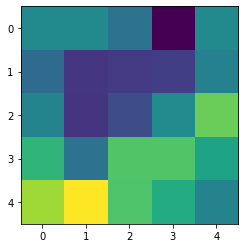

41 30


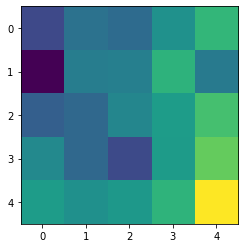

41 31


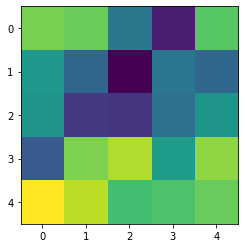

42 0


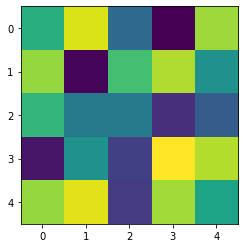

42 1


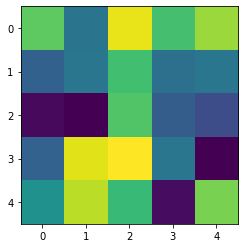

42 2


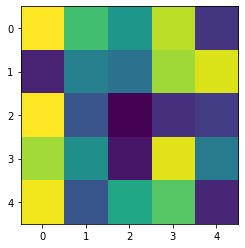

42 3


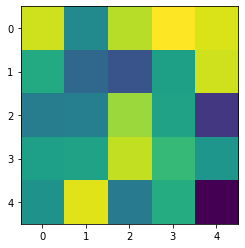

42 4


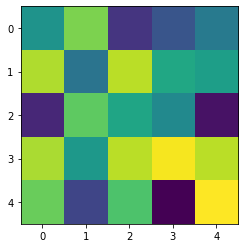

42 5


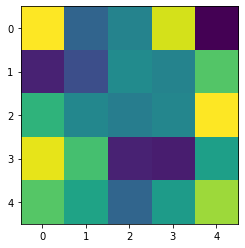

42 6


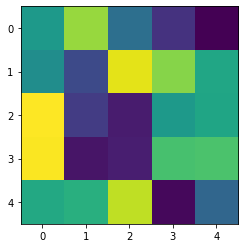

42 7


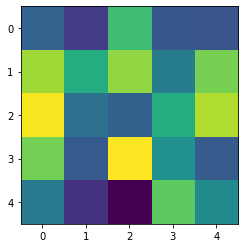

42 8


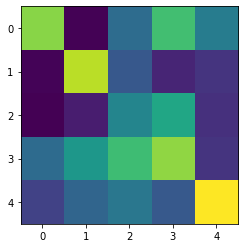

42 9


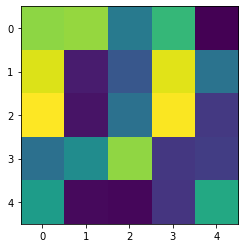

42 10


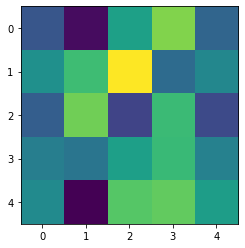

42 11


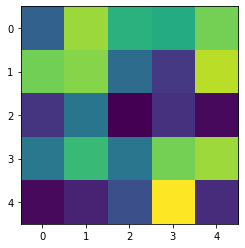

42 12


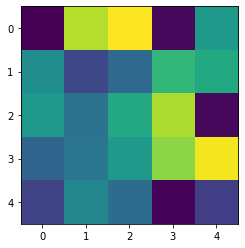

42 13


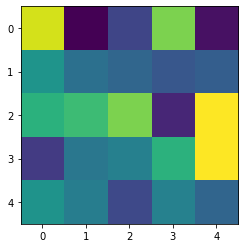

42 14


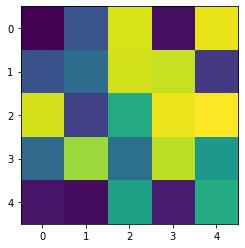

42 15


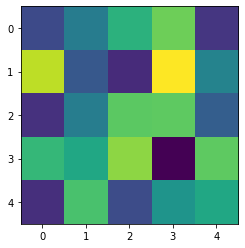

42 16


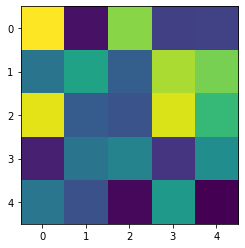

42 17


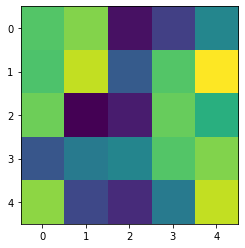

42 18


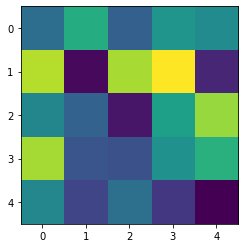

42 19


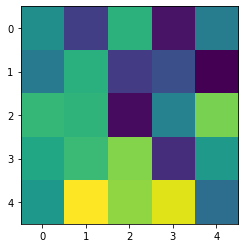

42 20


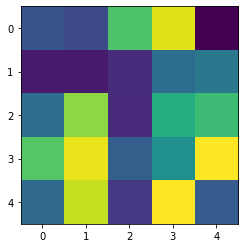

42 21


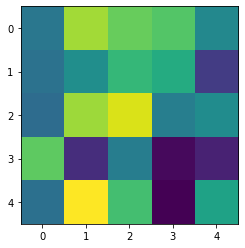

42 22


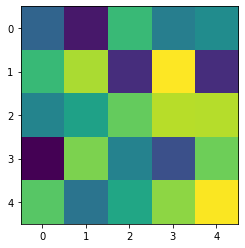

42 23


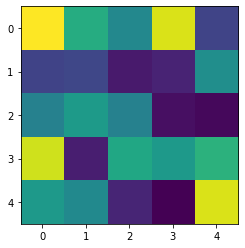

42 24


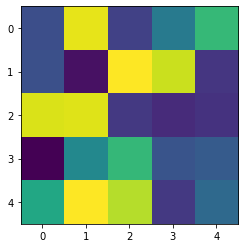

42 25


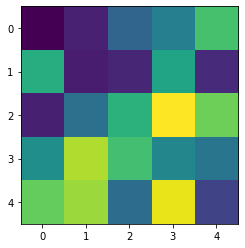

42 26


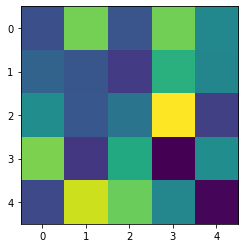

42 27


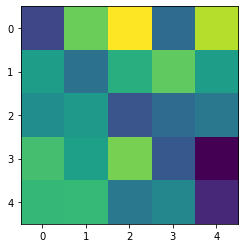

42 28


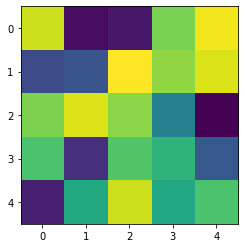

42 29


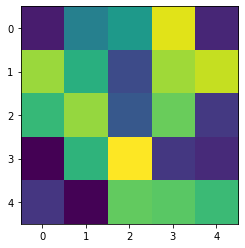

42 30


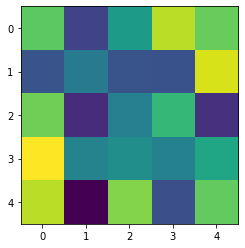

42 31


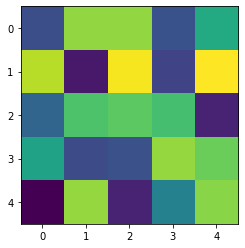

43 0


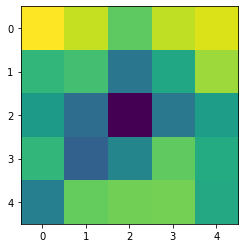

43 1


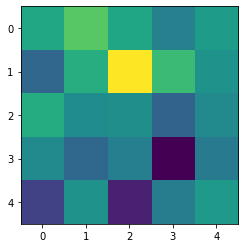

43 2


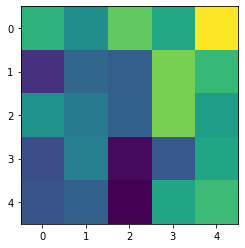

43 3


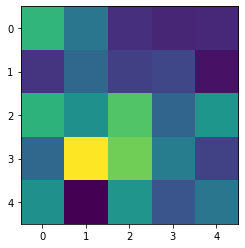

43 4


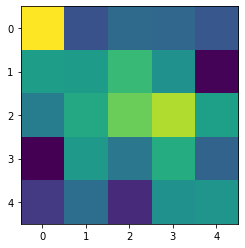

43 5


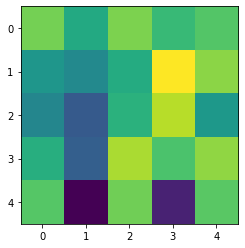

43 6


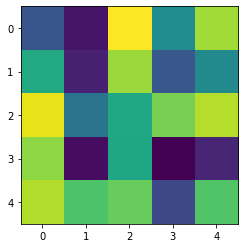

43 7


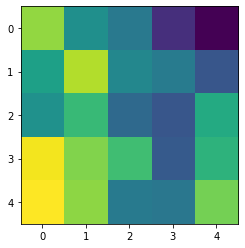

43 8


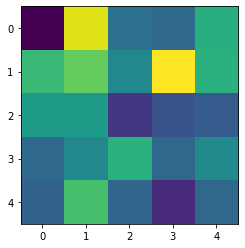

43 9


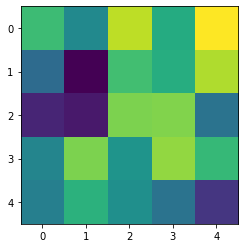

43 10


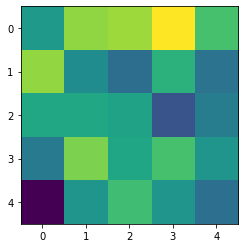

43 11


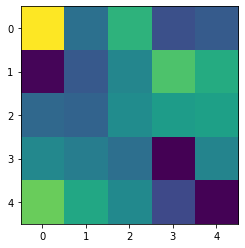

43 12


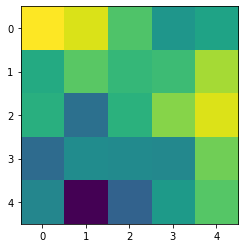

43 13


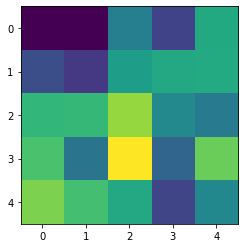

43 14


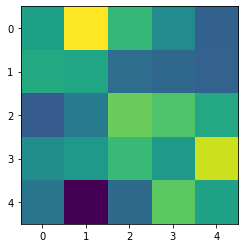

43 15


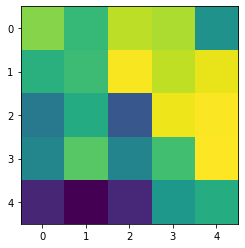

43 16


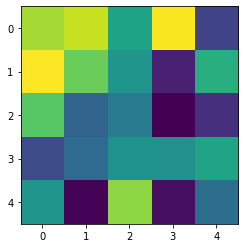

43 17


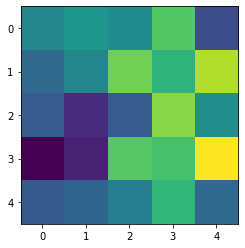

43 18


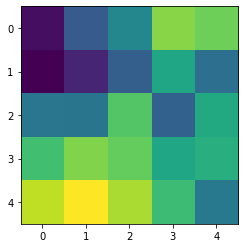

43 19


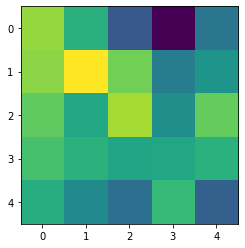

43 20


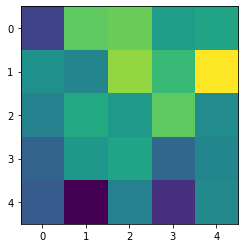

43 21


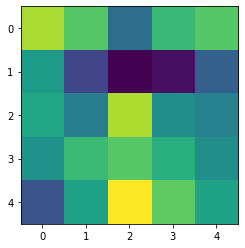

43 22


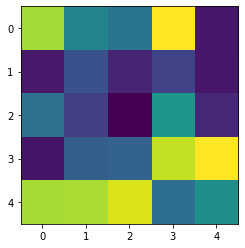

43 23


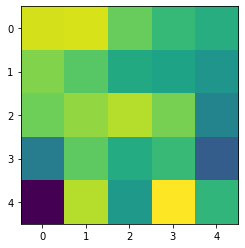

43 24


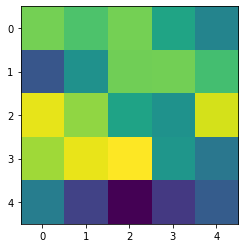

43 25


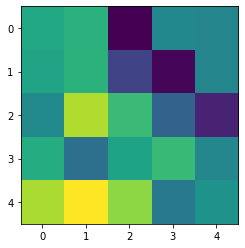

43 26


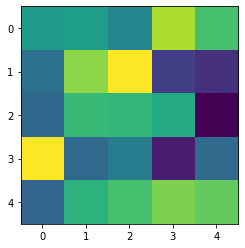

43 27


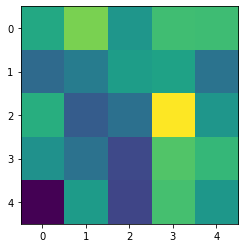

43 28


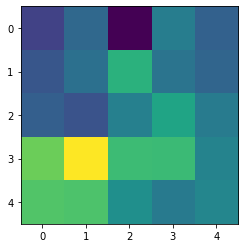

43 29


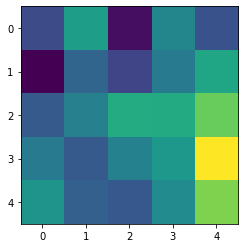

43 30


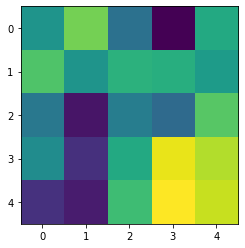

43 31


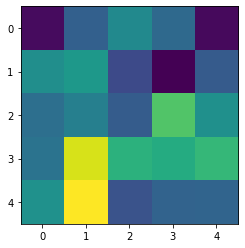

44 0


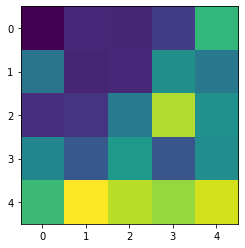

44 1


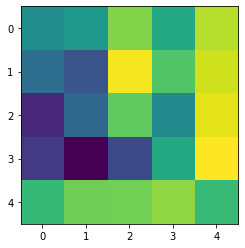

44 2


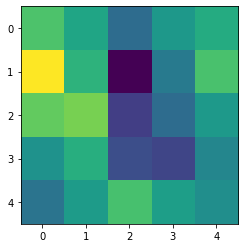

44 3


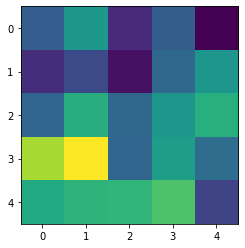

44 4


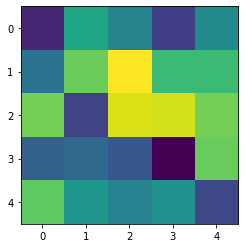

44 5


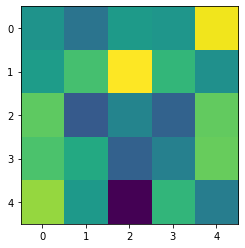

44 6


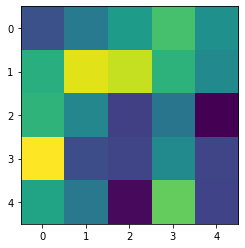

44 7


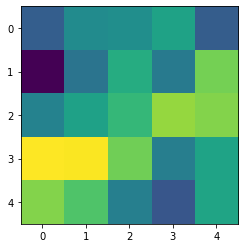

44 8


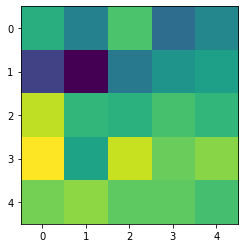

44 9


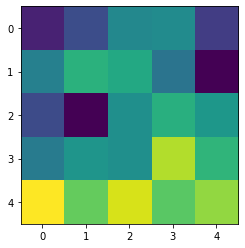

44 10


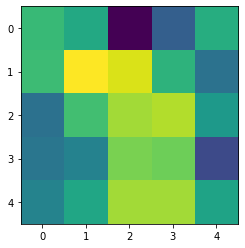

44 11


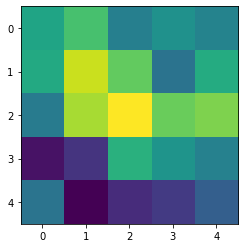

44 12


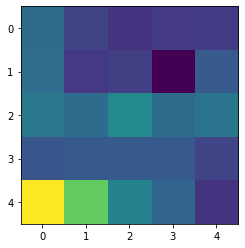

44 13


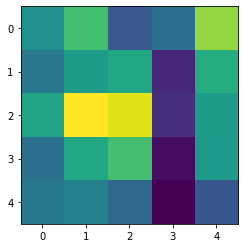

44 14


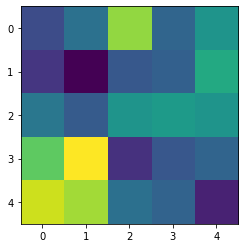

44 15


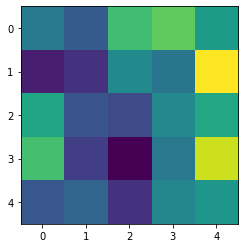

44 16


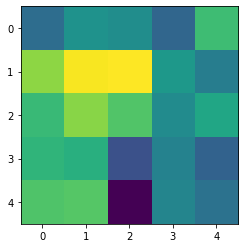

44 17


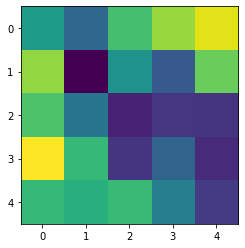

44 18


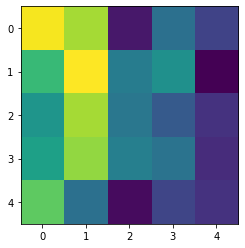

44 19


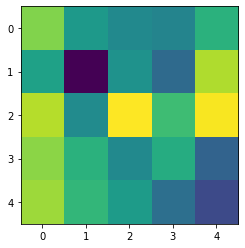

44 20


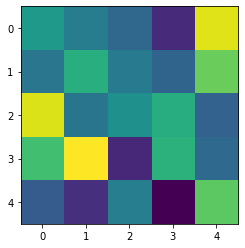

44 21


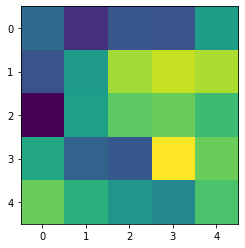

44 22


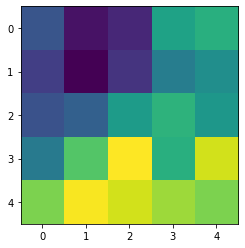

44 23


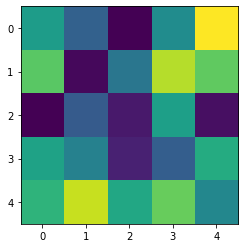

44 24


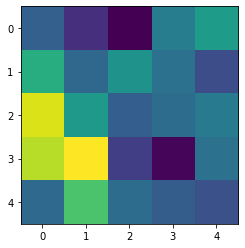

44 25


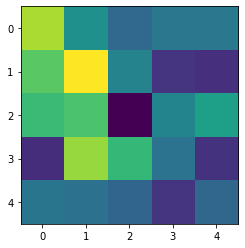

44 26


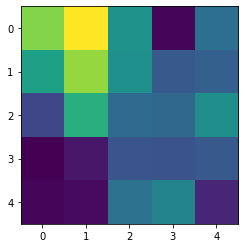

44 27


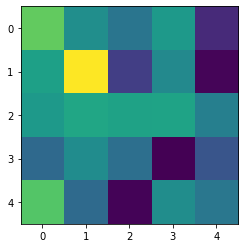

44 28


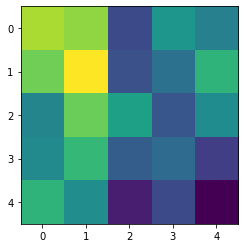

44 29


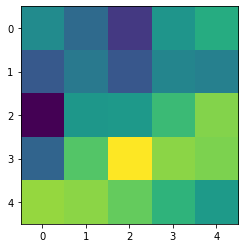

44 30


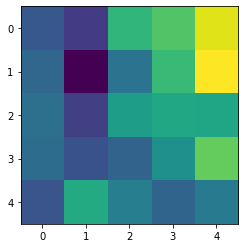

44 31


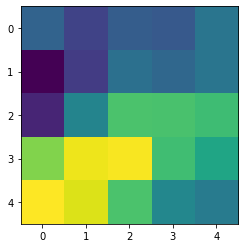

45 0


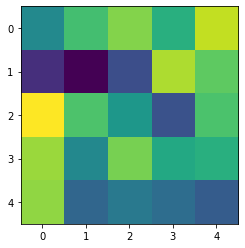

45 1


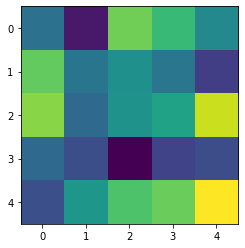

45 2


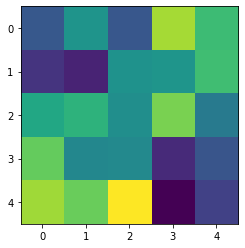

45 3


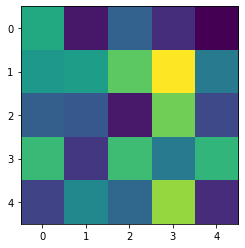

45 4


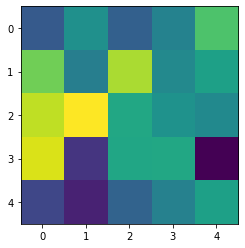

45 5


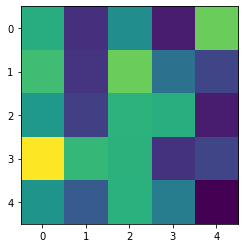

45 6


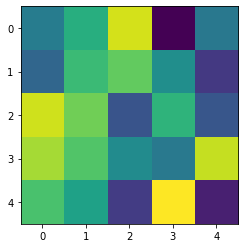

45 7


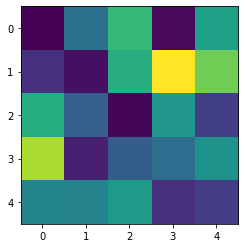

45 8


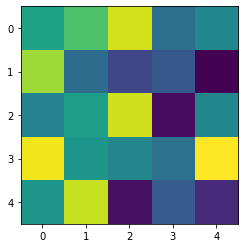

45 9


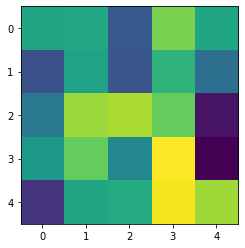

45 10


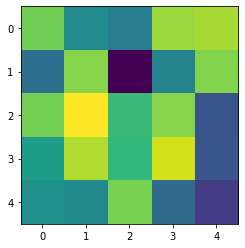

45 11


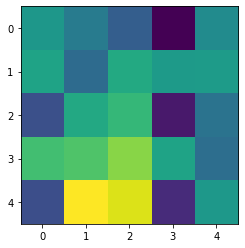

45 12


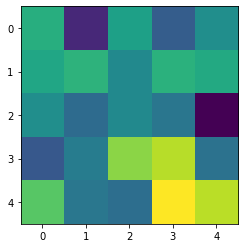

45 13


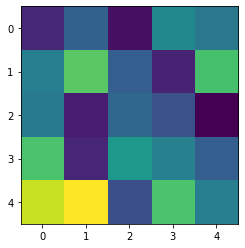

45 14


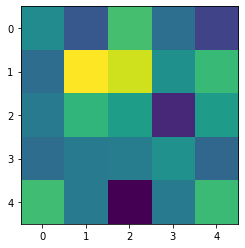

45 15


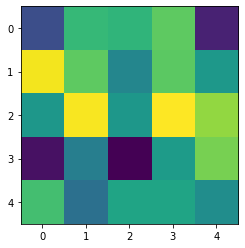

45 16


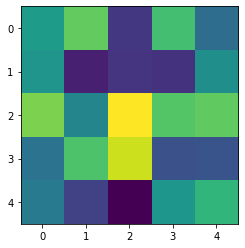

45 17


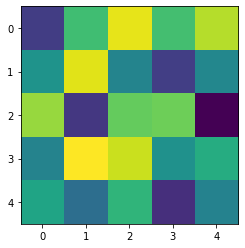

45 18


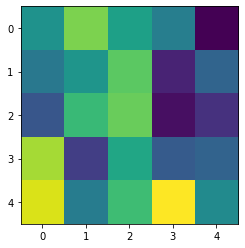

45 19


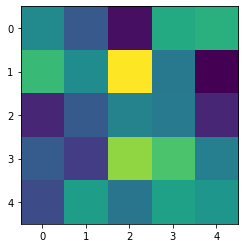

45 20


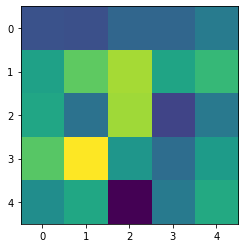

45 21


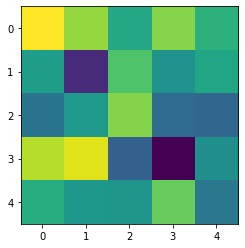

45 22


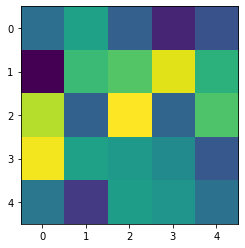

45 23


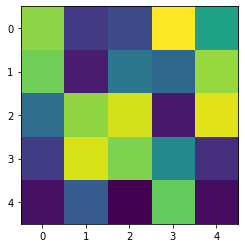

45 24


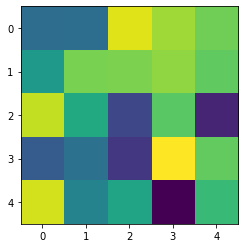

45 25


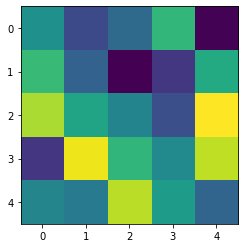

45 26


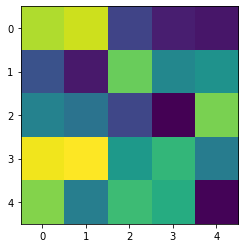

45 27


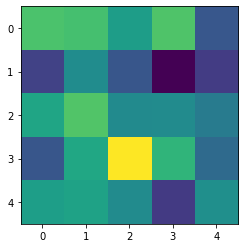

45 28


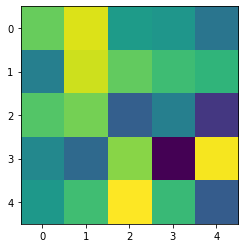

45 29


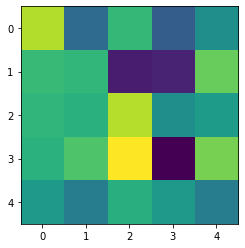

45 30


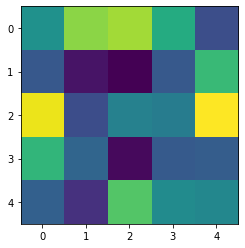

45 31


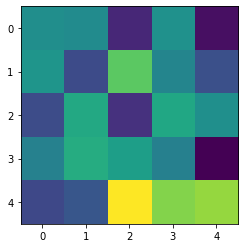

46 0


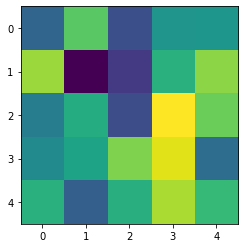

46 1


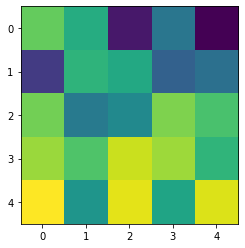

46 2


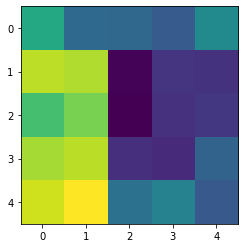

46 3


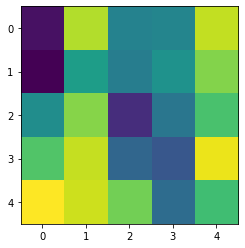

46 4


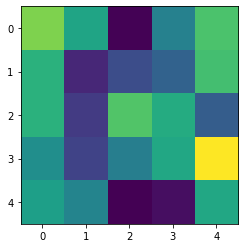

46 5


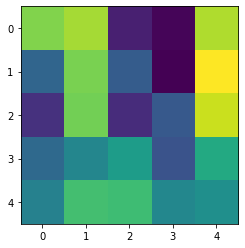

46 6


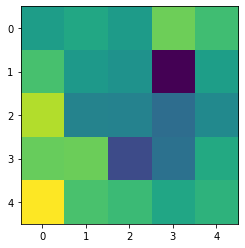

46 7


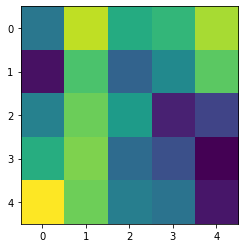

46 8


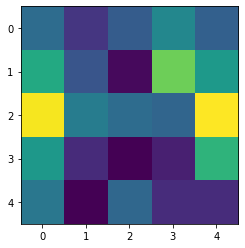

46 9


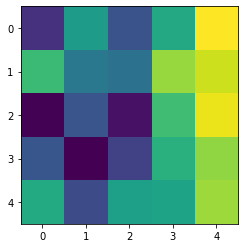

46 10


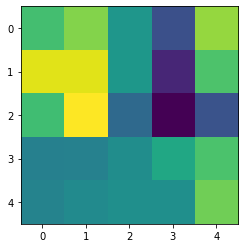

46 11


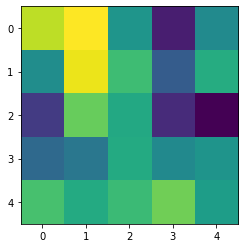

46 12


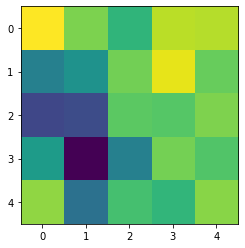

46 13


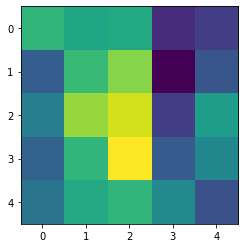

46 14


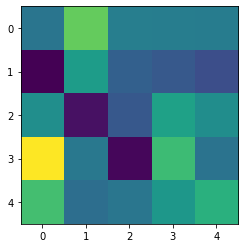

46 15


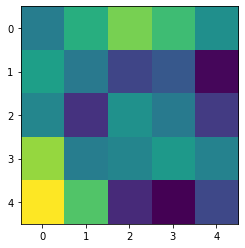

46 16


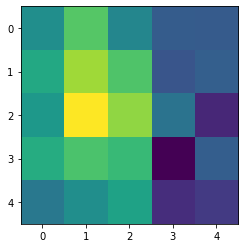

46 17


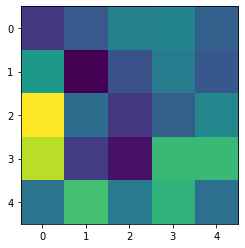

46 18


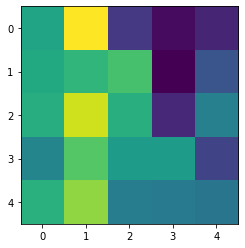

46 19


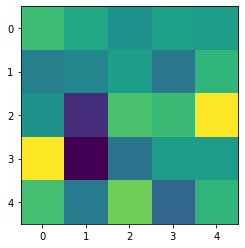

46 20


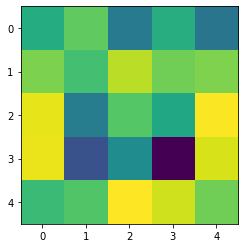

46 21


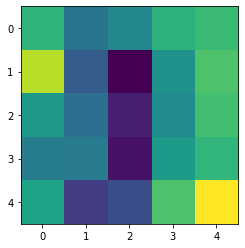

46 22


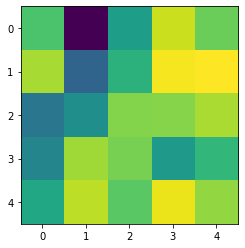

46 23


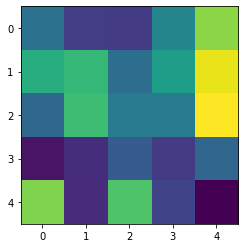

46 24


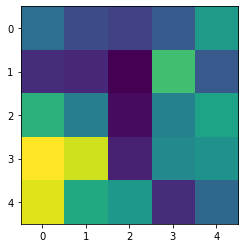

46 25


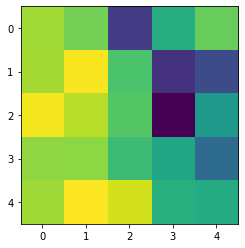

46 26


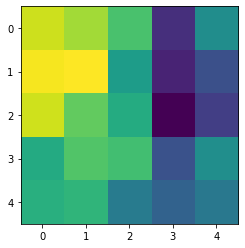

46 27


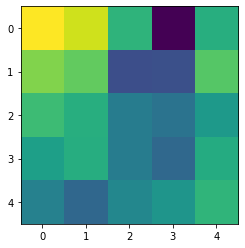

46 28


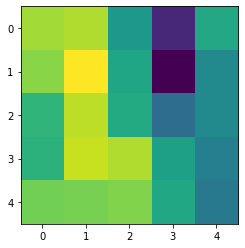

46 29


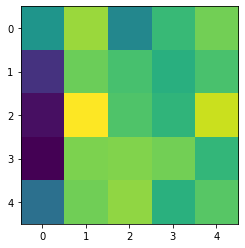

46 30


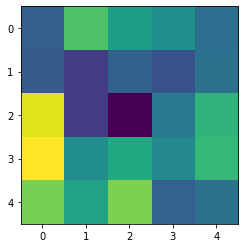

46 31


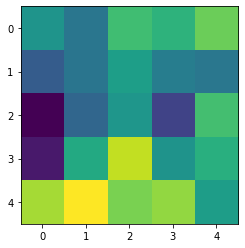

47 0


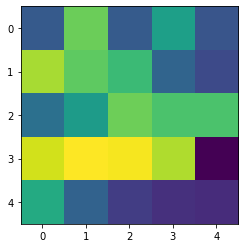

47 1


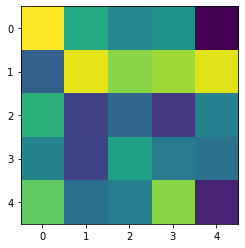

47 2


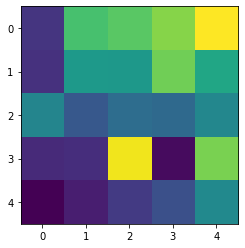

47 3


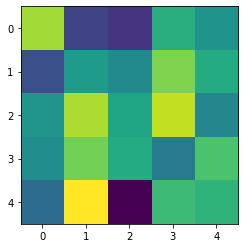

47 4


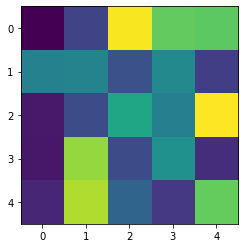

47 5


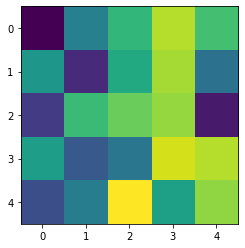

47 6


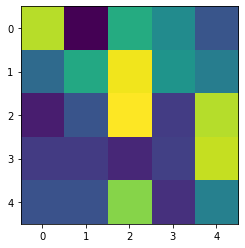

47 7


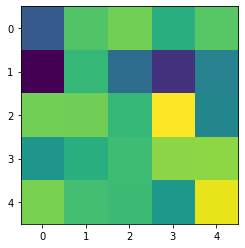

47 8


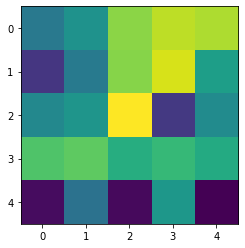

47 9


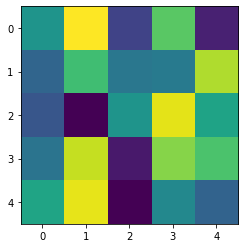

47 10


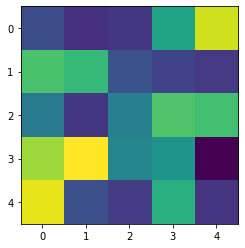

47 11


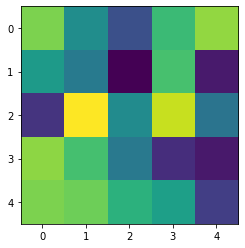

47 12


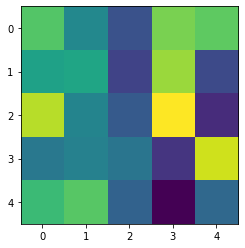

47 13


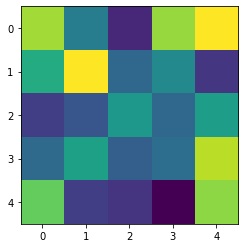

47 14


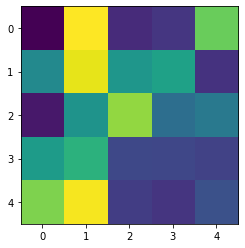

47 15


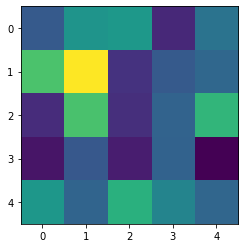

47 16


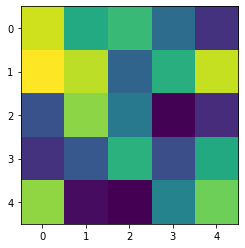

47 17


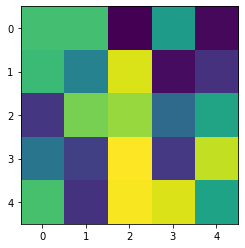

47 18


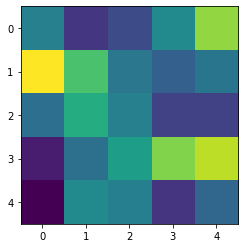

47 19


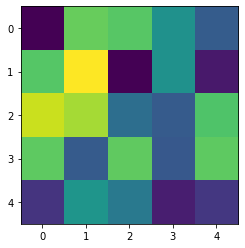

47 20


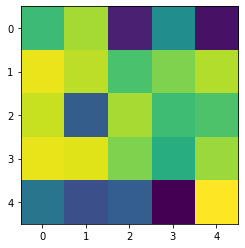

47 21


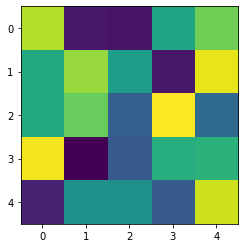

47 22


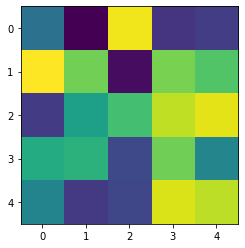

47 23


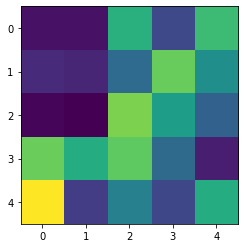

47 24


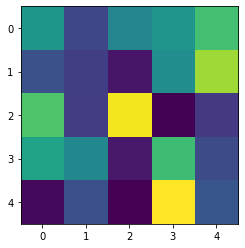

47 25


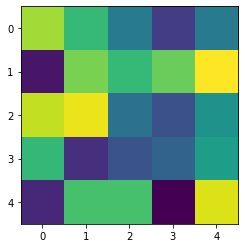

47 26


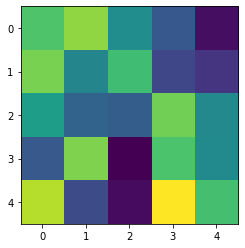

47 27


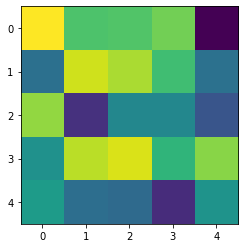

47 28


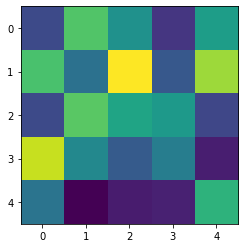

47 29


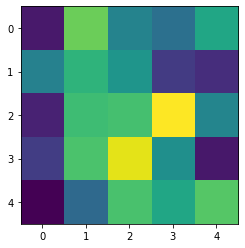

47 30


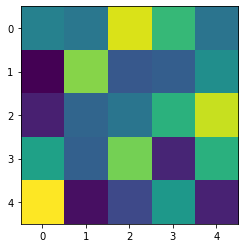

47 31


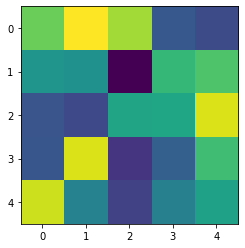

48 0


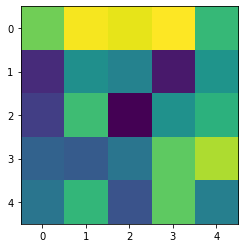

48 1


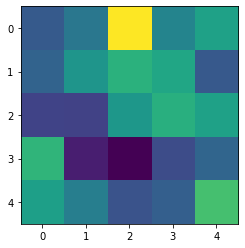

48 2


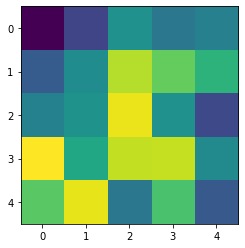

48 3


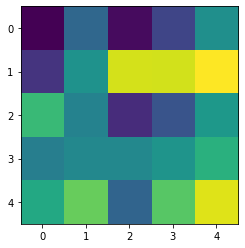

48 4


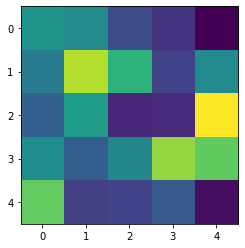

48 5


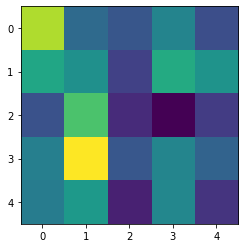

48 6


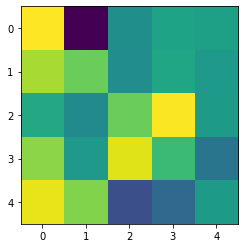

48 7


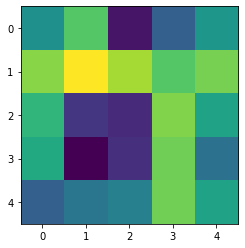

48 8


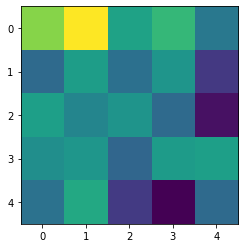

48 9


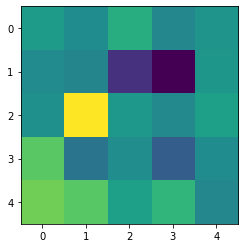

48 10


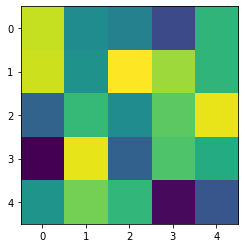

48 11


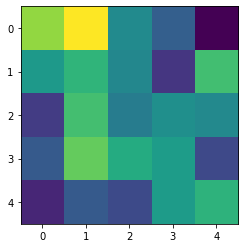

48 12


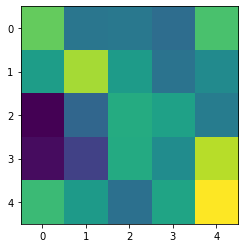

48 13


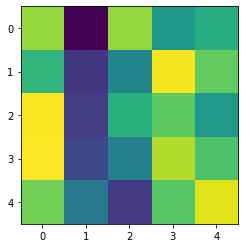

48 14


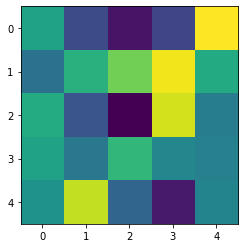

48 15


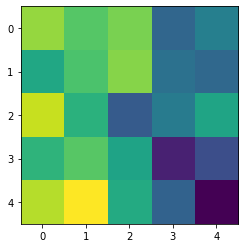

48 16


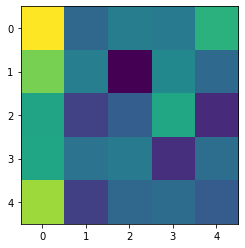

48 17


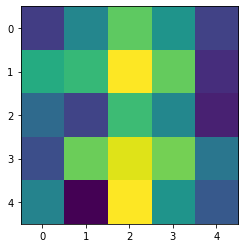

48 18


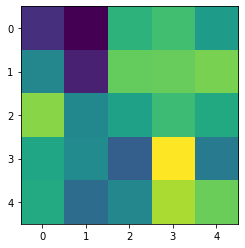

48 19


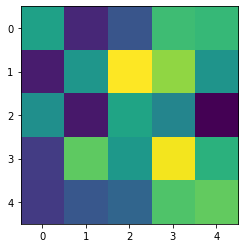

48 20


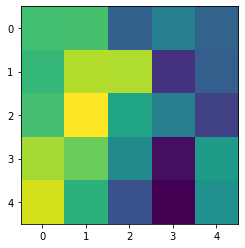

48 21


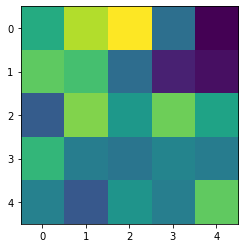

48 22


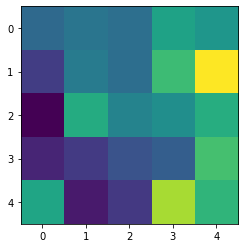

48 23


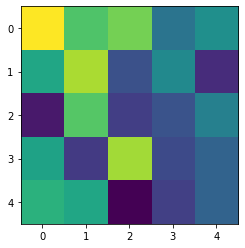

48 24


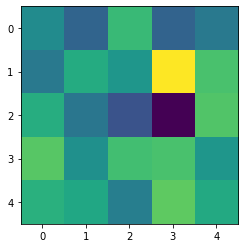

48 25


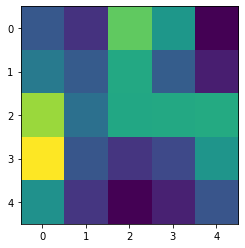

48 26


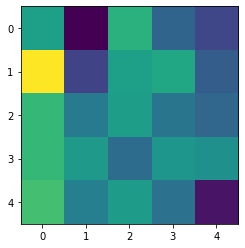

48 27


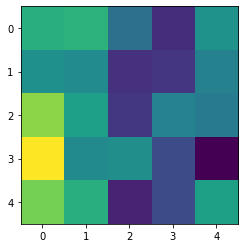

48 28


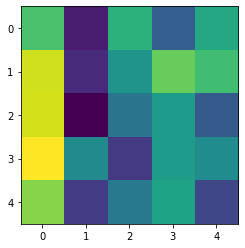

48 29


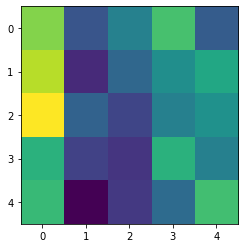

48 30


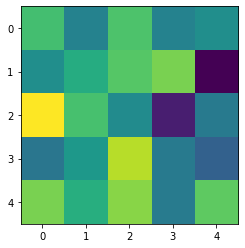

48 31


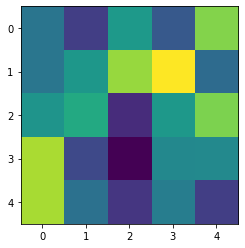

49 0


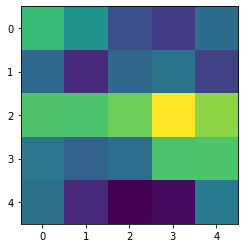

49 1


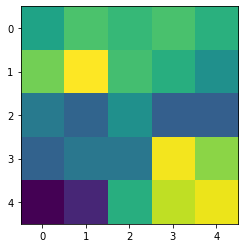

49 2


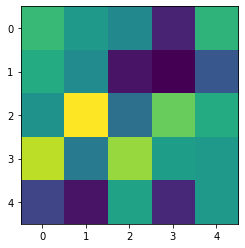

49 3


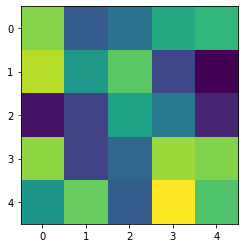

49 4


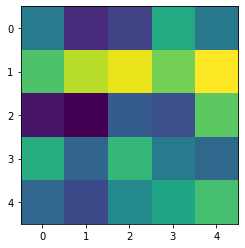

49 5


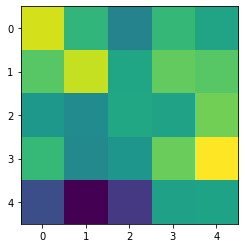

49 6


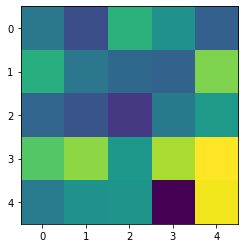

49 7


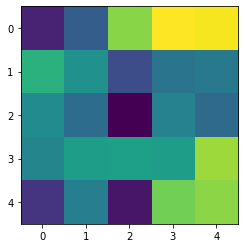

49 8


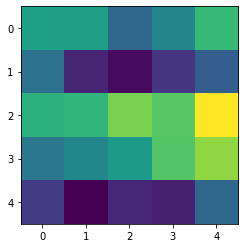

49 9


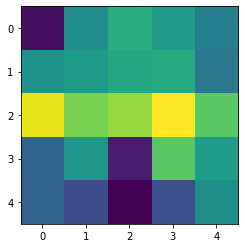

49 10


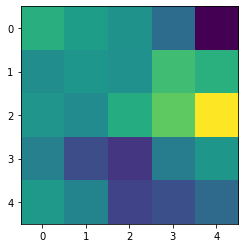

49 11


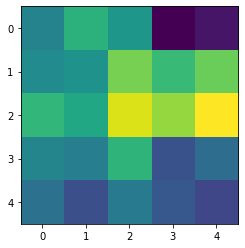

49 12


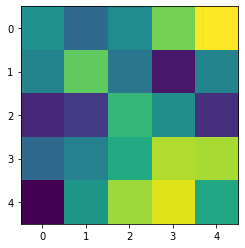

49 13


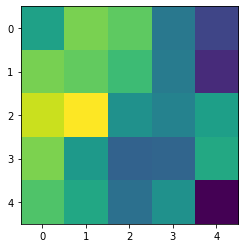

49 14


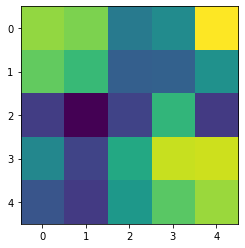

49 15


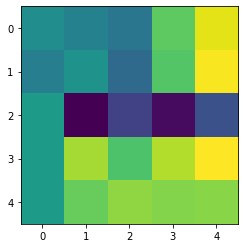

49 16


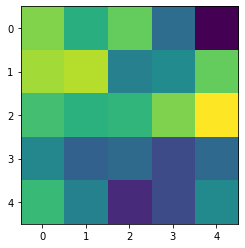

49 17


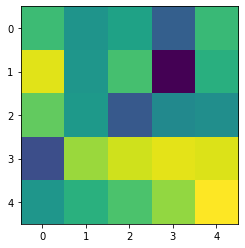

49 18


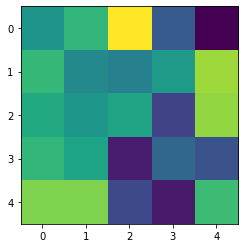

49 19


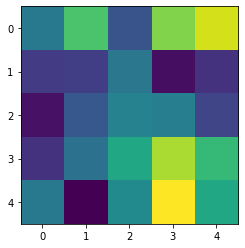

49 20


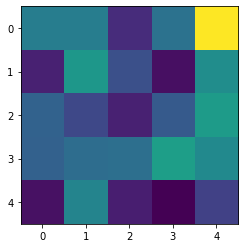

49 21


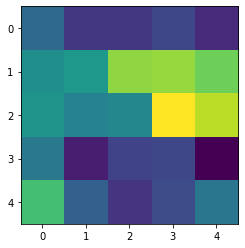

49 22


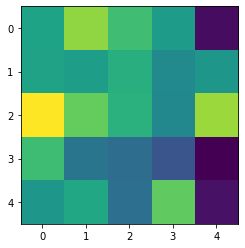

49 23


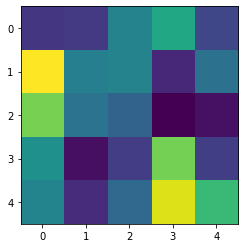

49 24


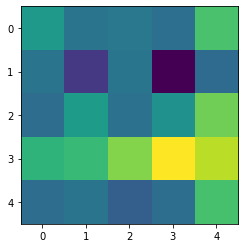

49 25


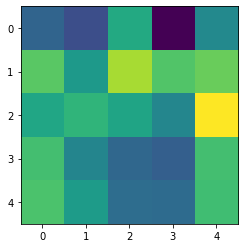

49 26


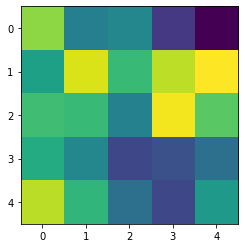

49 27


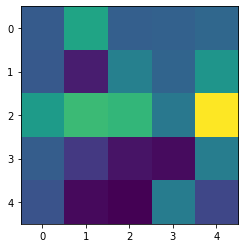

49 28


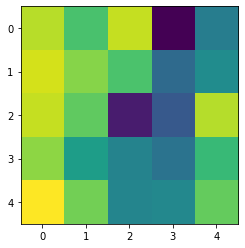

49 29


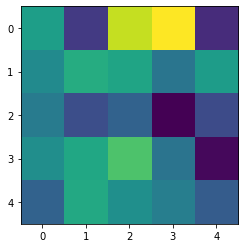

49 30


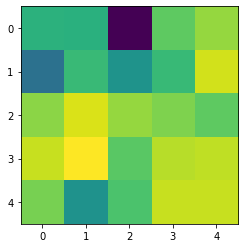

49 31


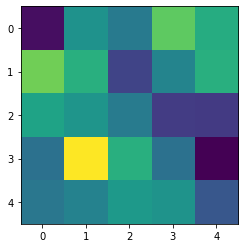

50 0


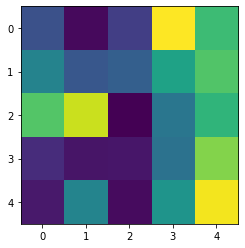

50 1


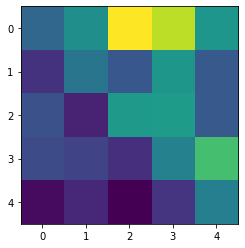

50 2


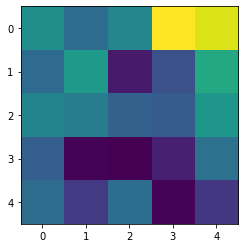

50 3


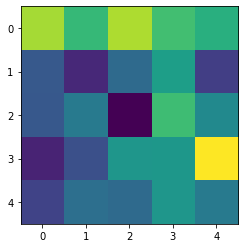

50 4


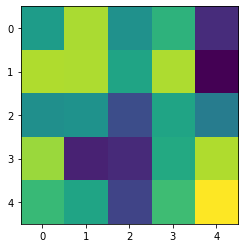

50 5


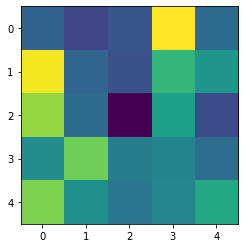

50 6


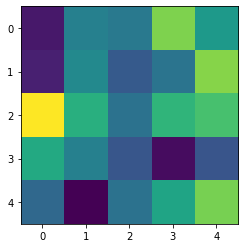

50 7


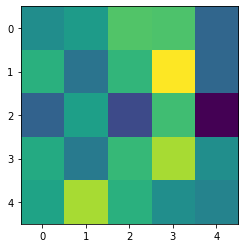

50 8


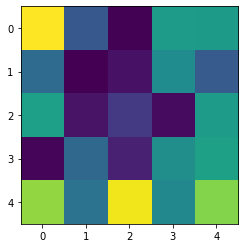

50 9


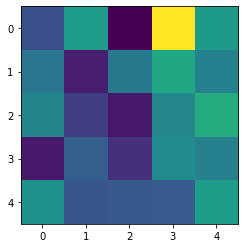

50 10


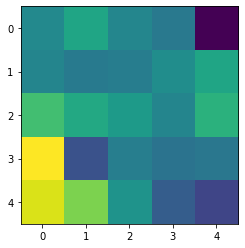

50 11


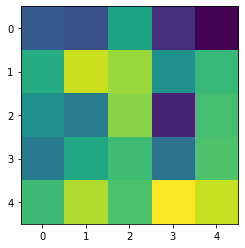

50 12


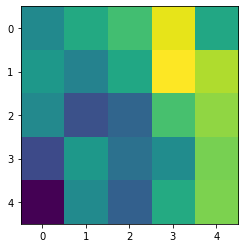

50 13


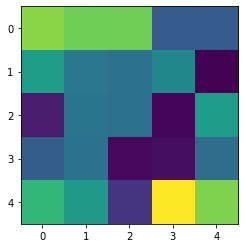

50 14


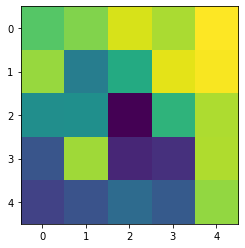

50 15


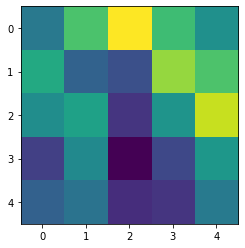

50 16


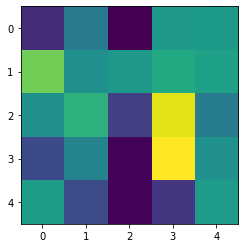

50 17


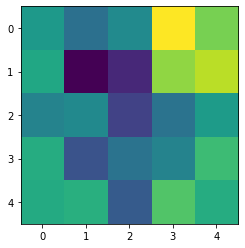

50 18


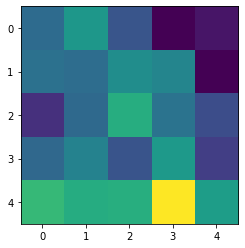

50 19


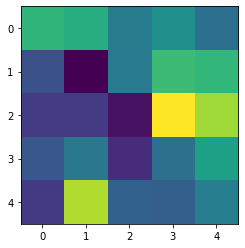

50 20


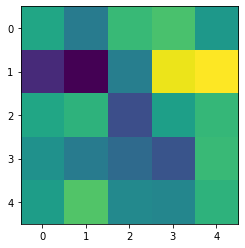

50 21


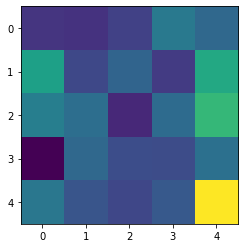

50 22


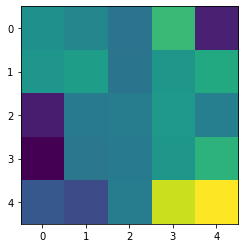

50 23


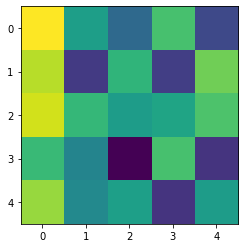

50 24


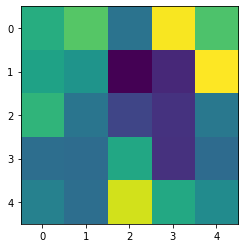

50 25


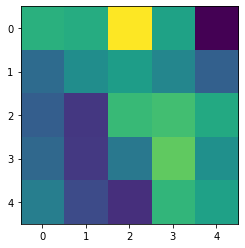

50 26


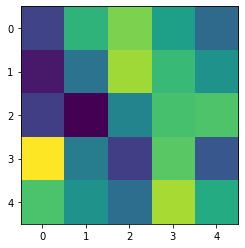

50 27


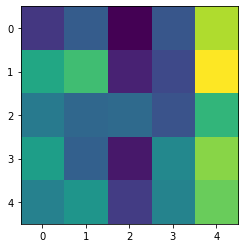

50 28


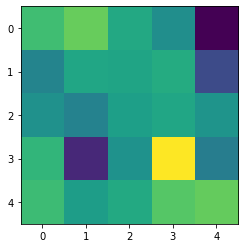

50 29


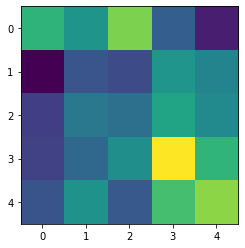

50 30


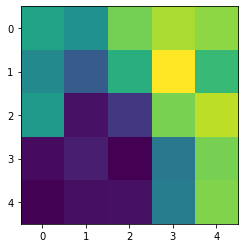

50 31


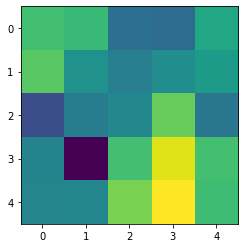

51 0


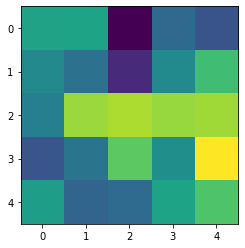

51 1


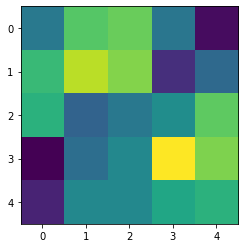

51 2


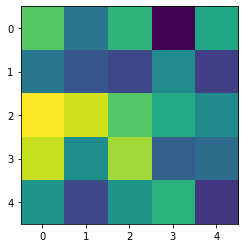

51 3


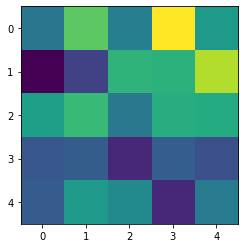

51 4


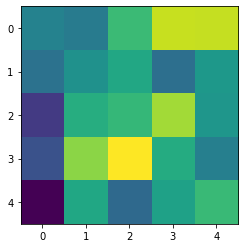

51 5


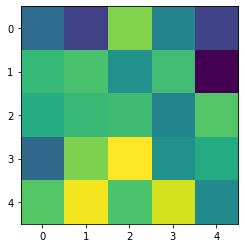

51 6


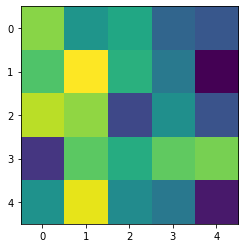

51 7


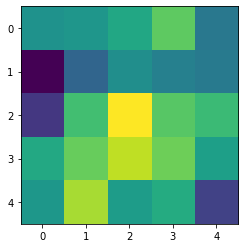

51 8


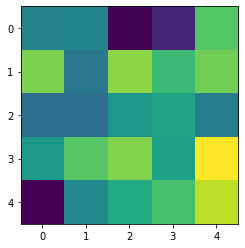

51 9


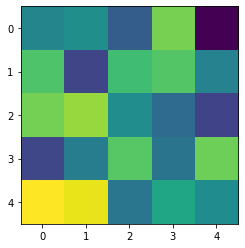

51 10


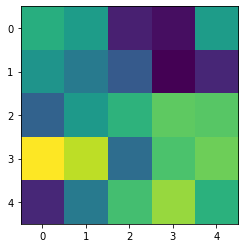

51 11


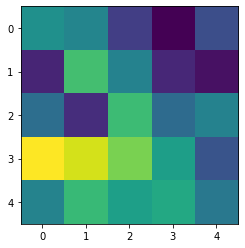

51 12


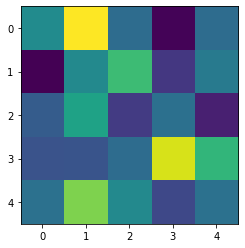

51 13


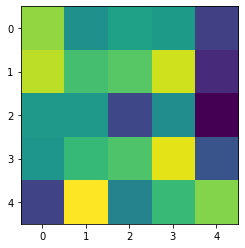

51 14


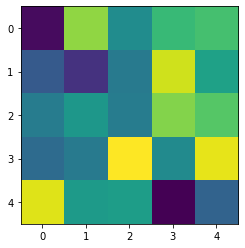

51 15


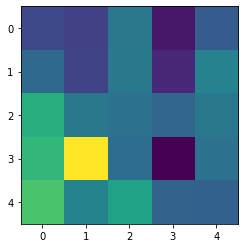

51 16


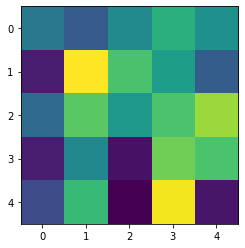

51 17


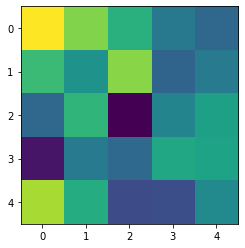

51 18


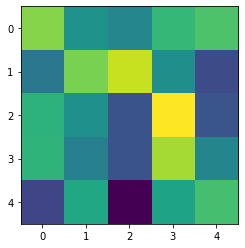

51 19


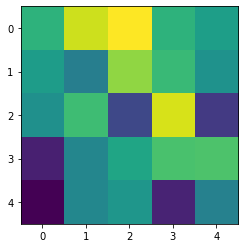

51 20


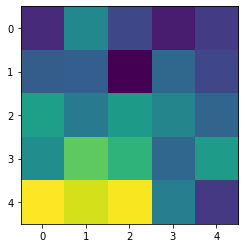

51 21


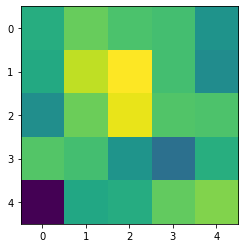

51 22


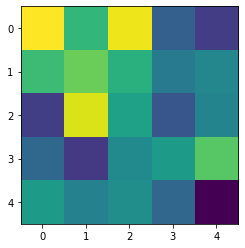

51 23


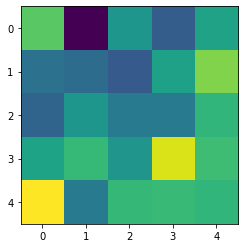

51 24


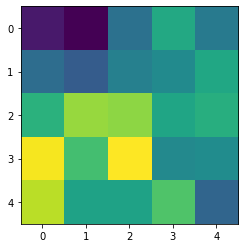

51 25


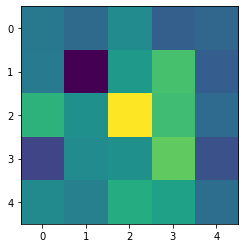

51 26


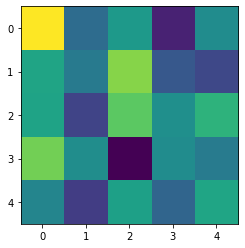

51 27


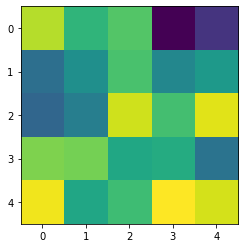

51 28


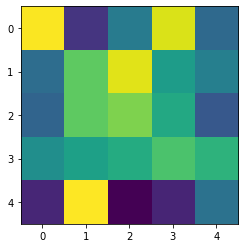

51 29


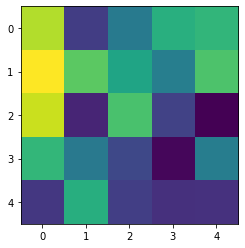

51 30


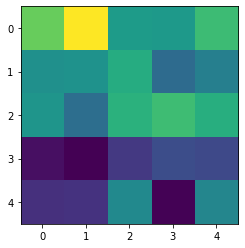

51 31


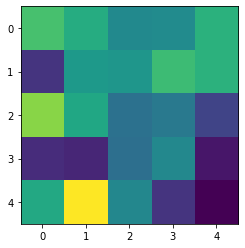

52 0


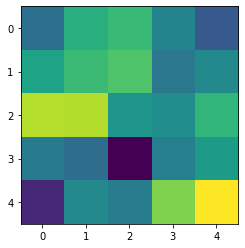

52 1


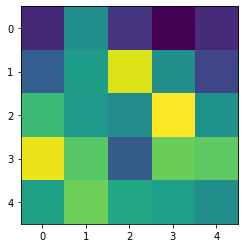

52 2


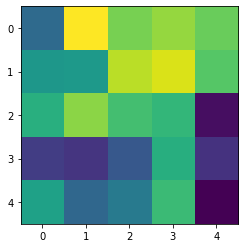

52 3


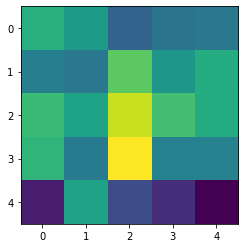

52 4


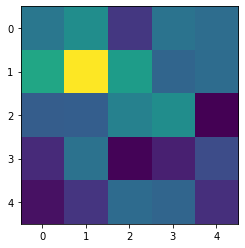

52 5


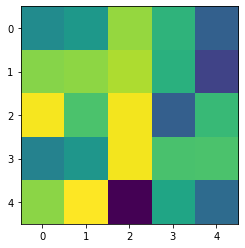

52 6


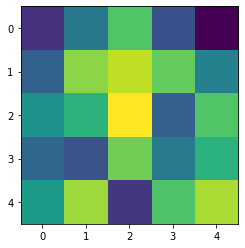

52 7


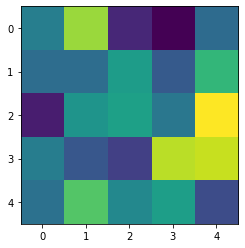

52 8


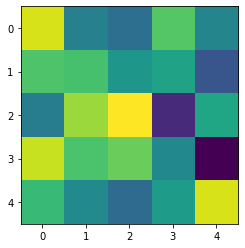

52 9


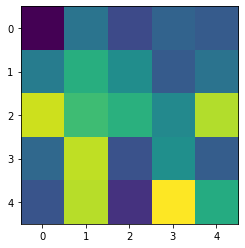

52 10


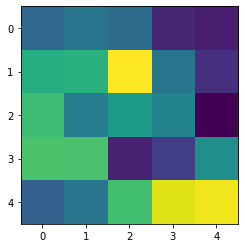

52 11


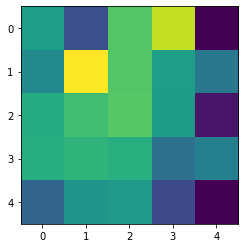

52 12


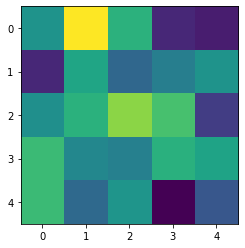

52 13


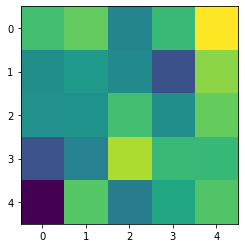

52 14


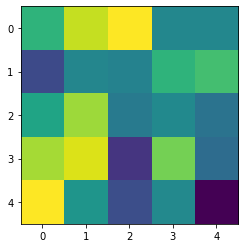

52 15


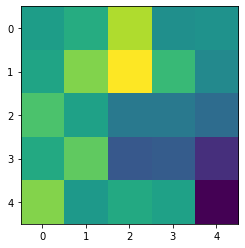

52 16


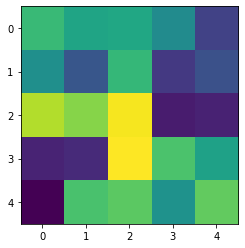

52 17


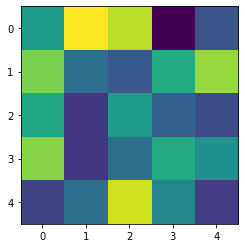

52 18


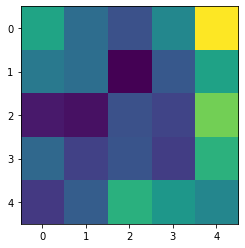

52 19


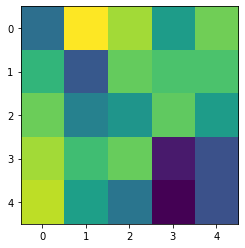

52 20


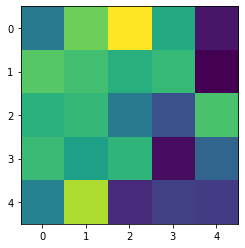

52 21


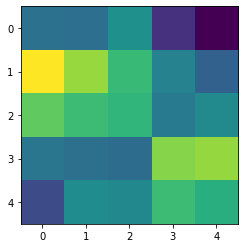

52 22


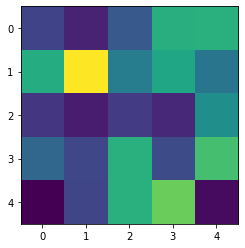

52 23


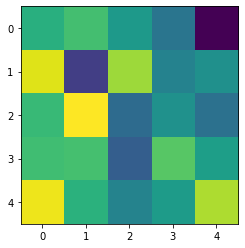

52 24


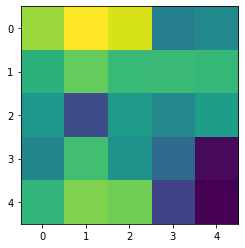

52 25


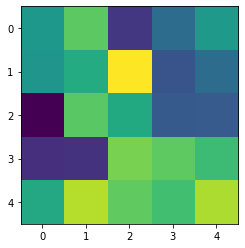

52 26


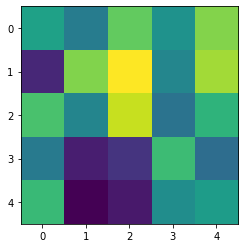

52 27


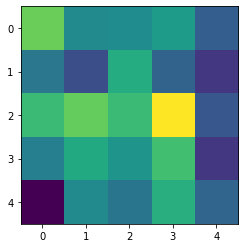

52 28


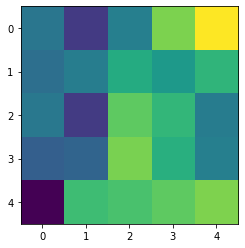

52 29


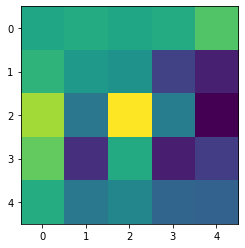

52 30


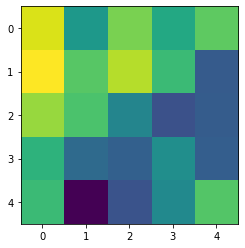

52 31


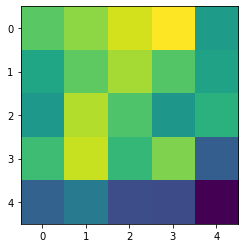

53 0


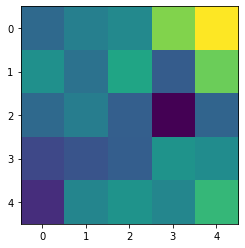

53 1


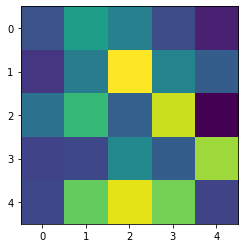

53 2


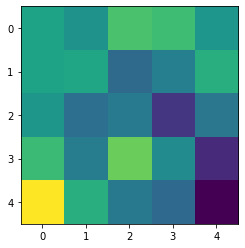

53 3


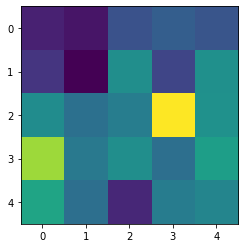

53 4


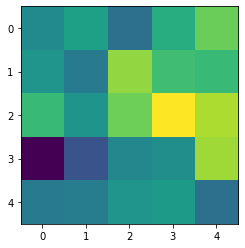

53 5


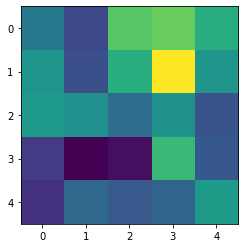

53 6


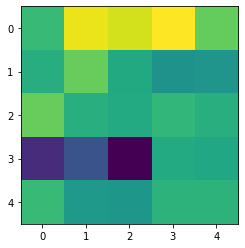

53 7


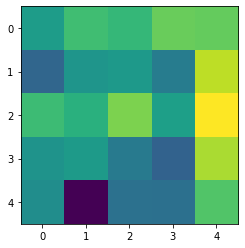

53 8


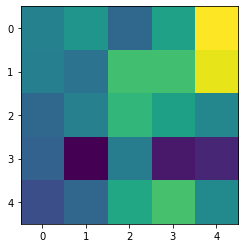

53 9


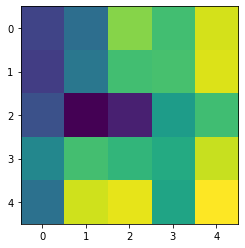

53 10


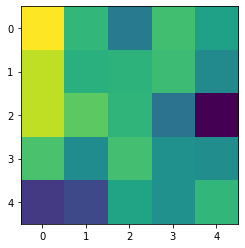

53 11


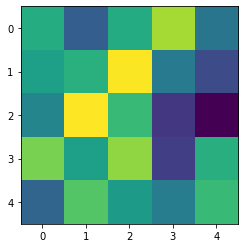

53 12


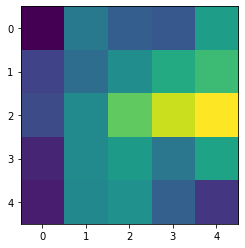

53 13


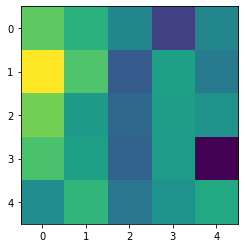

53 14


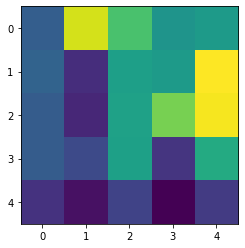

53 15


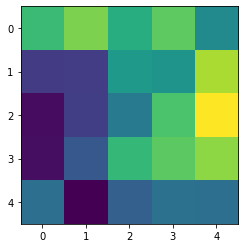

53 16


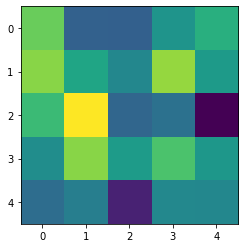

53 17


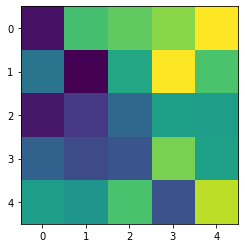

53 18


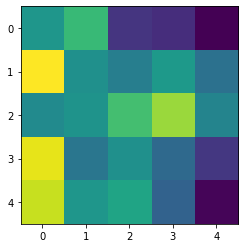

53 19


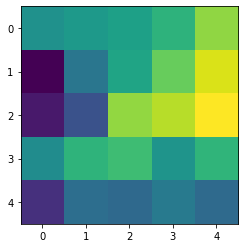

53 20


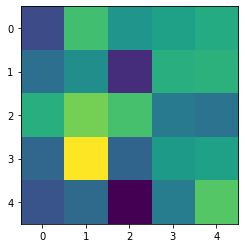

53 21


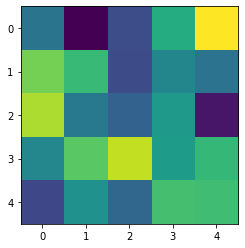

53 22


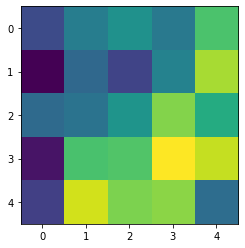

53 23


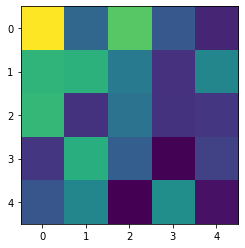

53 24


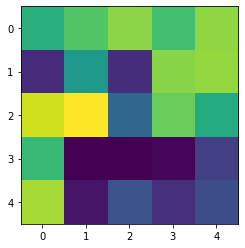

53 25


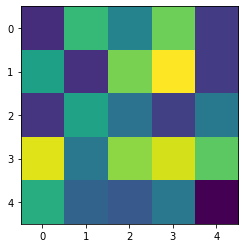

53 26


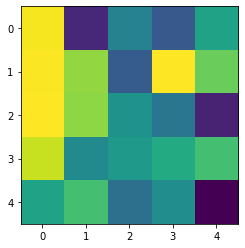

53 27


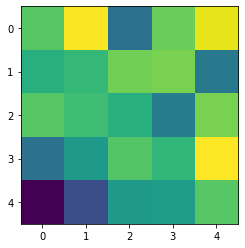

53 28


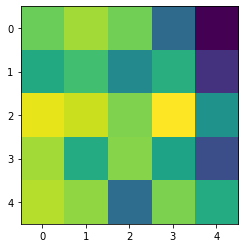

53 29


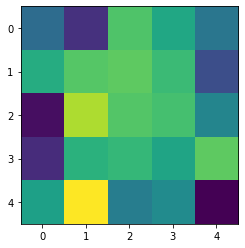

53 30


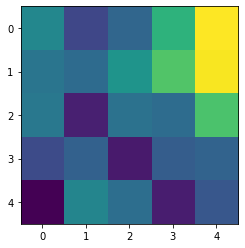

53 31


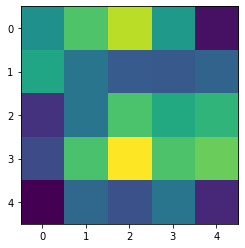

54 0


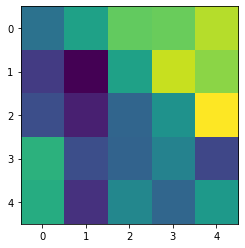

54 1


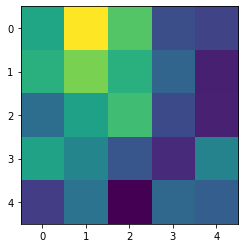

54 2


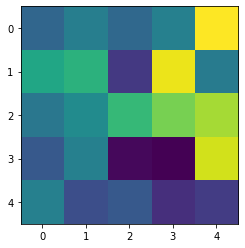

54 3


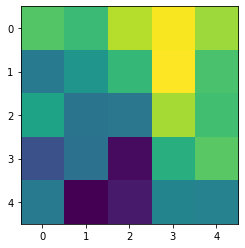

54 4


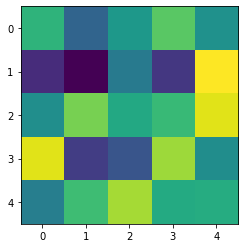

54 5


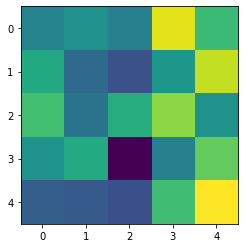

54 6


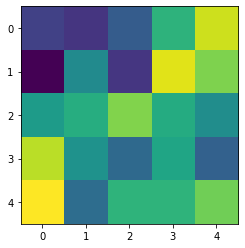

54 7


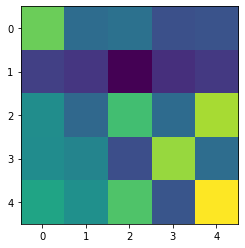

54 8


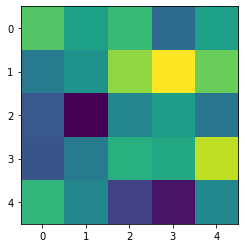

54 9


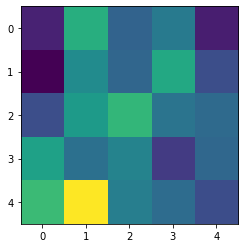

54 10


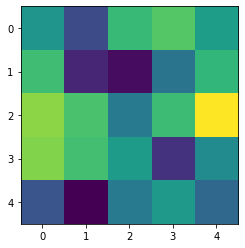

54 11


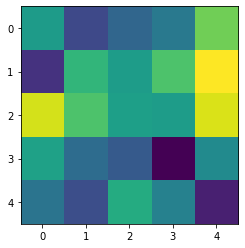

54 12


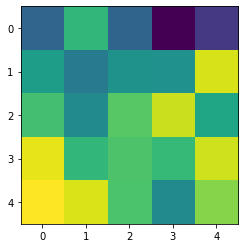

54 13


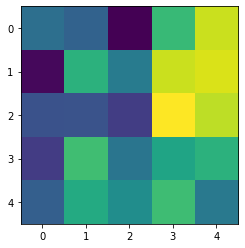

54 14


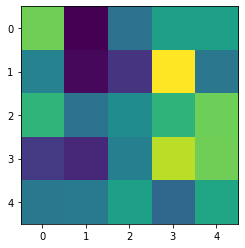

54 15


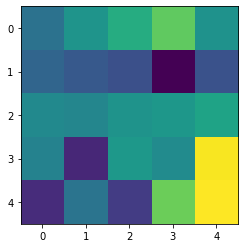

54 16


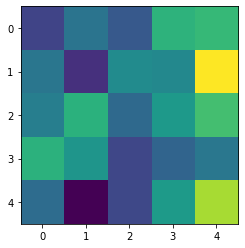

54 17


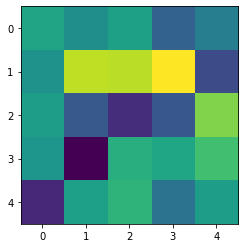

54 18


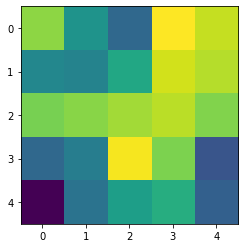

54 19


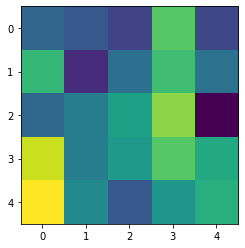

54 20


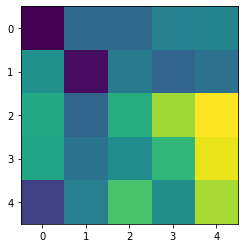

54 21


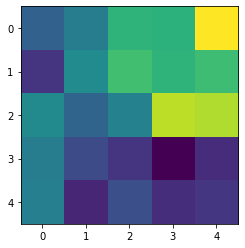

54 22


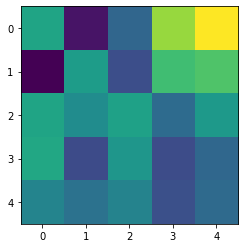

54 23


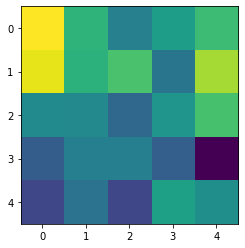

54 24


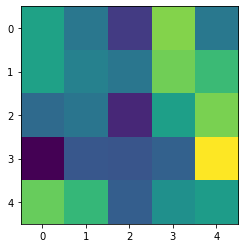

54 25


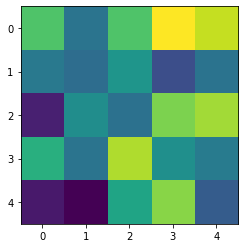

54 26


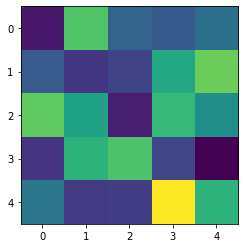

54 27


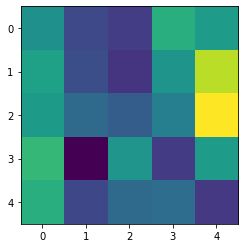

54 28


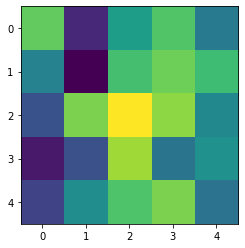

54 29


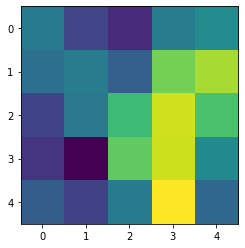

54 30


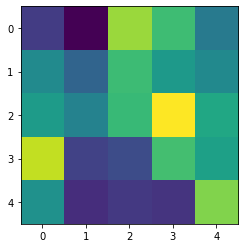

54 31


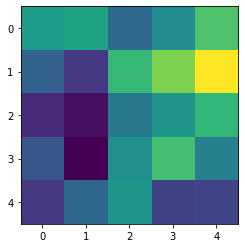

55 0


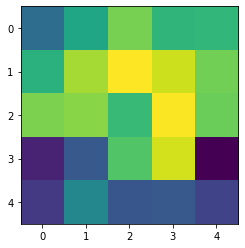

55 1


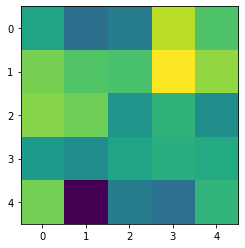

55 2


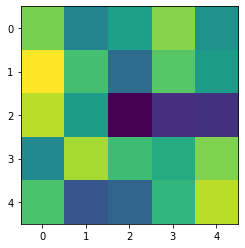

55 3


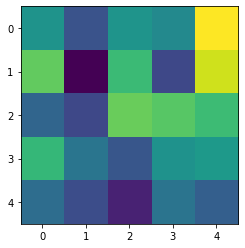

55 4


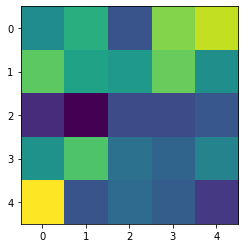

55 5


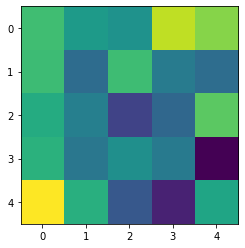

55 6


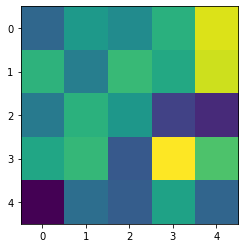

55 7


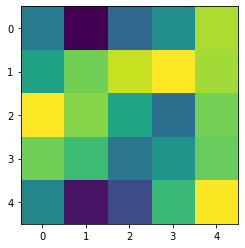

55 8


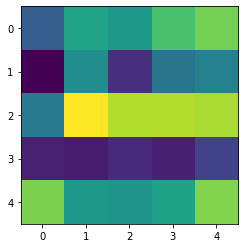

55 9


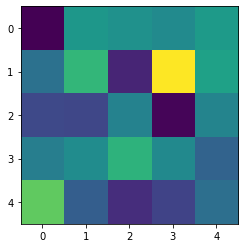

55 10


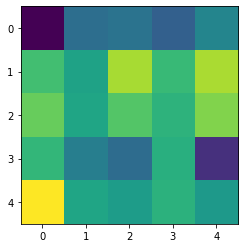

55 11


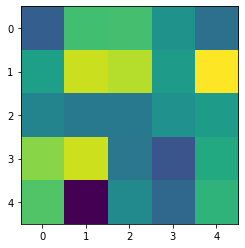

55 12


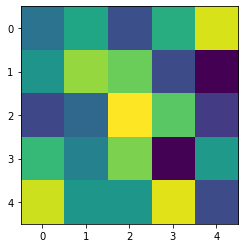

55 13


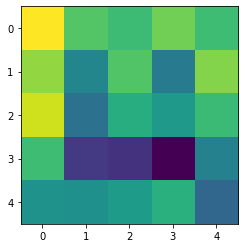

55 14


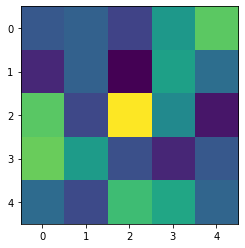

55 15


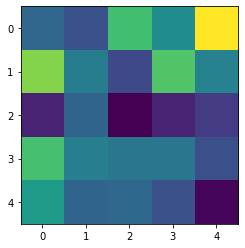

55 16


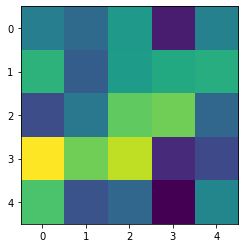

55 17


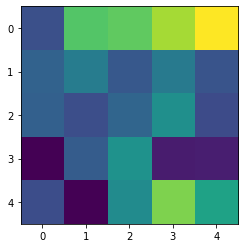

55 18


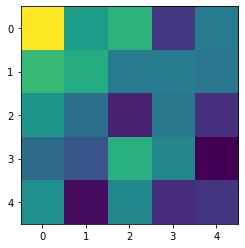

55 19


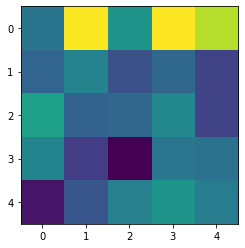

55 20


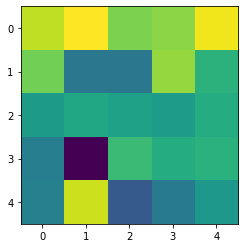

55 21


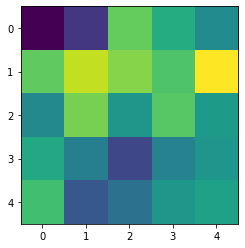

55 22


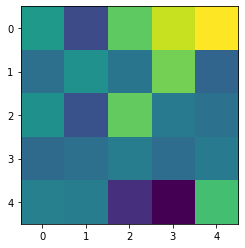

55 23


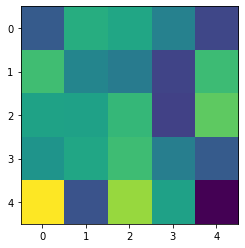

55 24


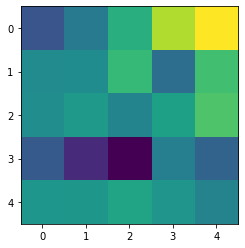

55 25


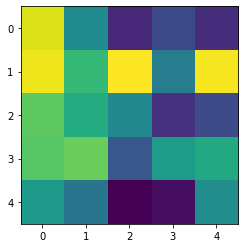

55 26


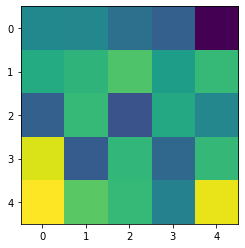

55 27


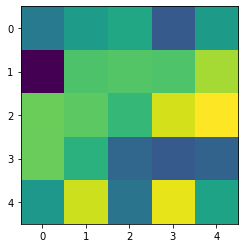

55 28


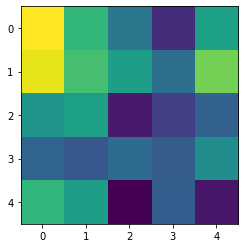

55 29


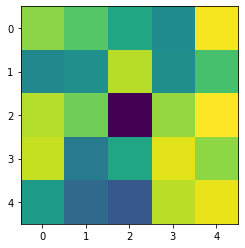

55 30


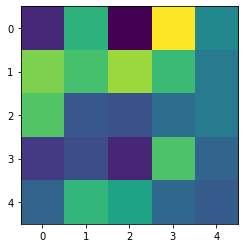

55 31


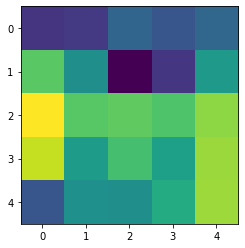

56 0


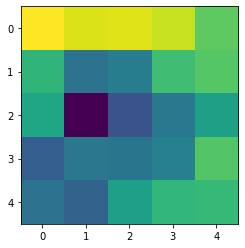

56 1


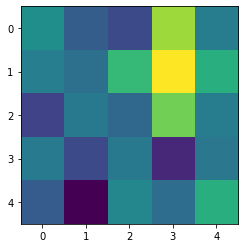

56 2


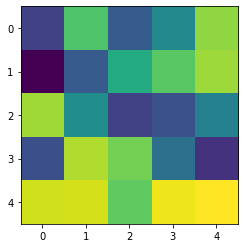

56 3


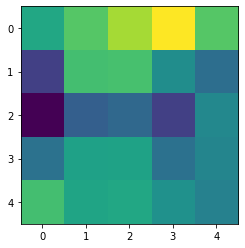

56 4


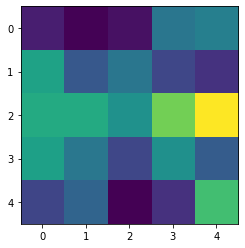

56 5


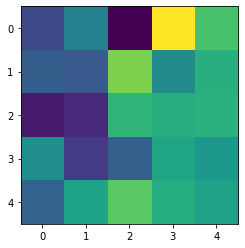

56 6


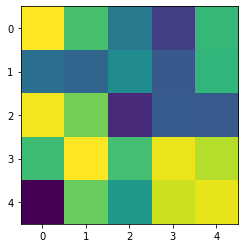

56 7


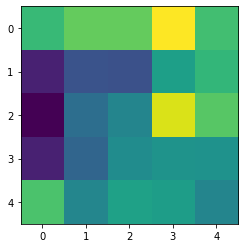

56 8


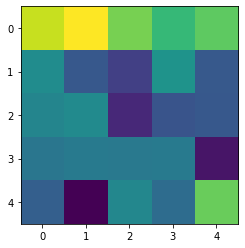

56 9


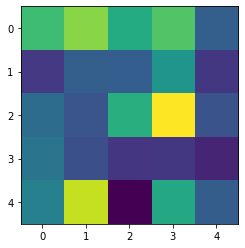

56 10


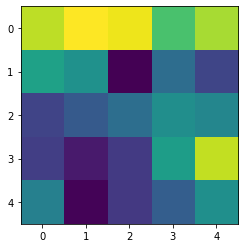

56 11


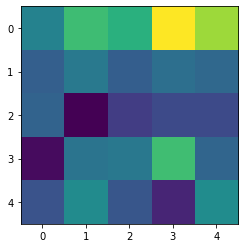

56 12


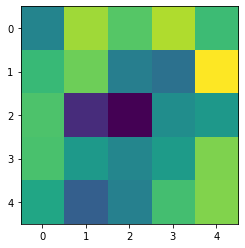

56 13


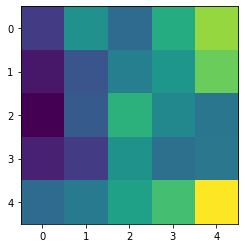

56 14


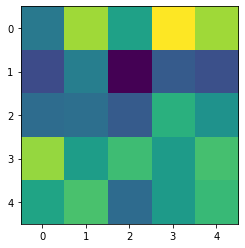

56 15


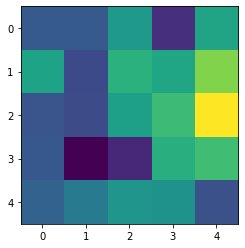

56 16


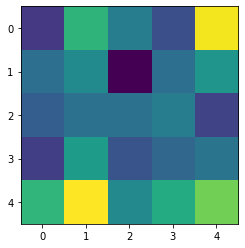

56 17


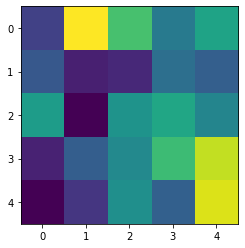

56 18


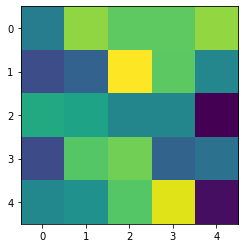

56 19


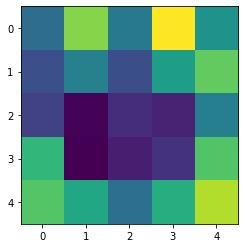

56 20


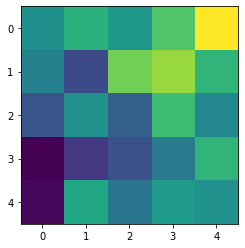

56 21


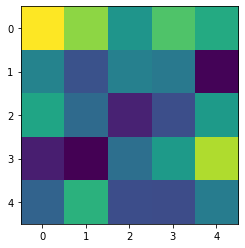

56 22


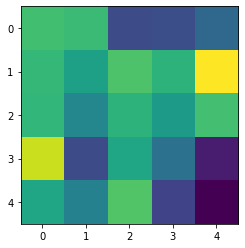

56 23


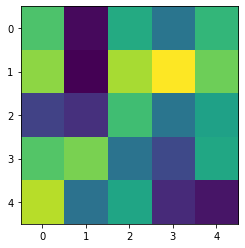

56 24


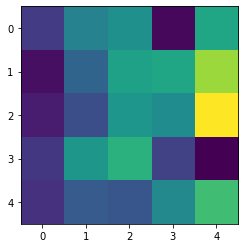

56 25


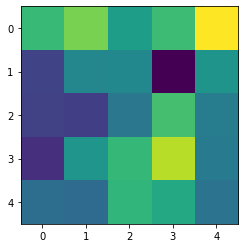

56 26


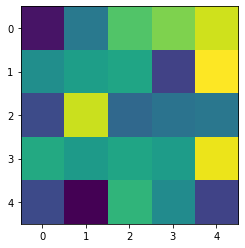

56 27


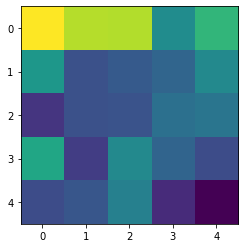

56 28


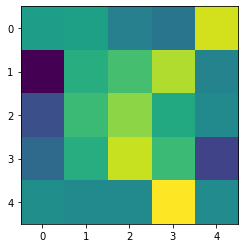

56 29


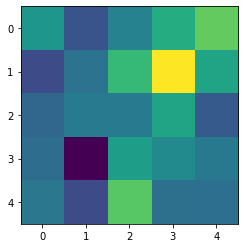

56 30


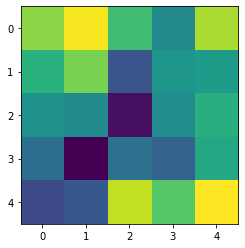

56 31


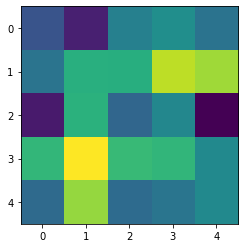

57 0


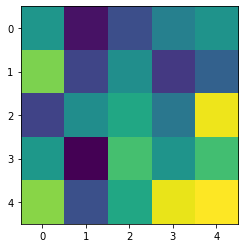

57 1


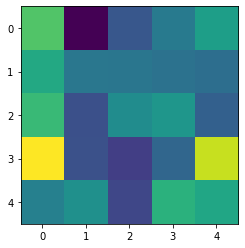

57 2


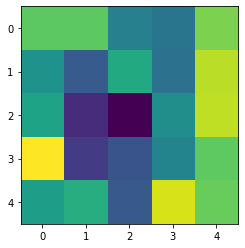

57 3


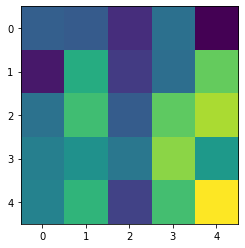

57 4


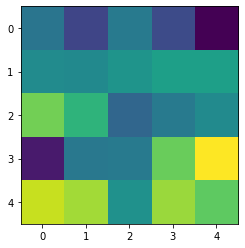

57 5


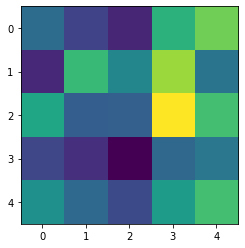

57 6


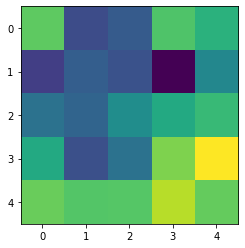

57 7


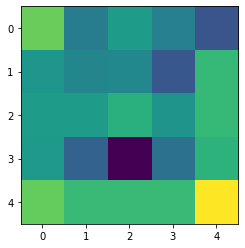

57 8


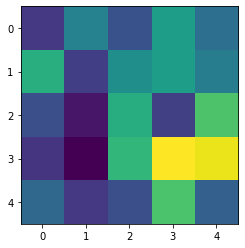

57 9


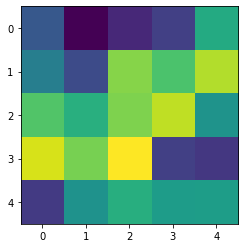

57 10


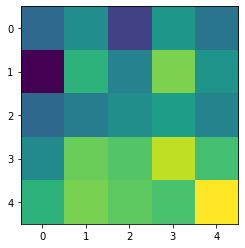

57 11


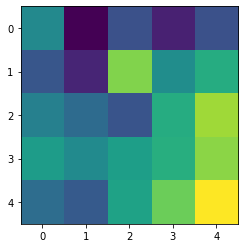

57 12


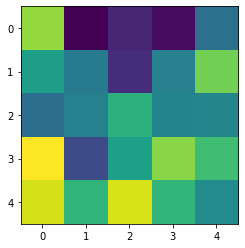

57 13


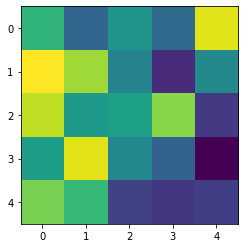

57 14


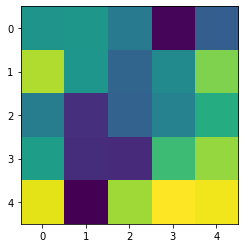

57 15


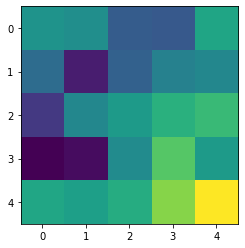

57 16


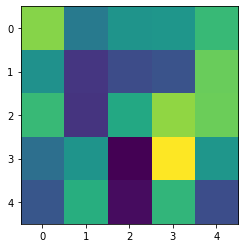

57 17


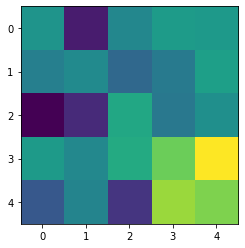

57 18


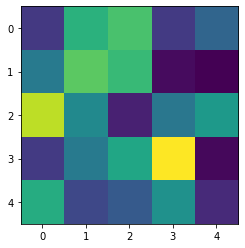

57 19


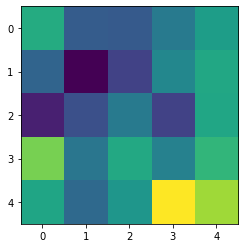

57 20


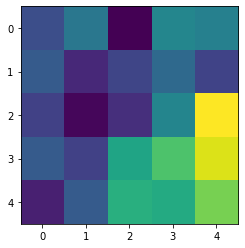

57 21


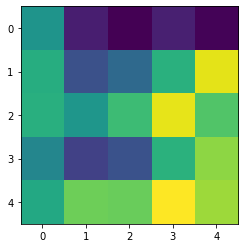

57 22


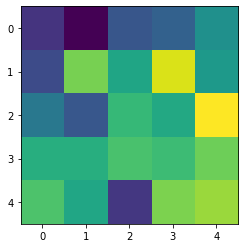

57 23


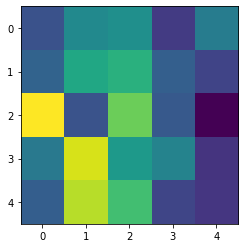

57 24


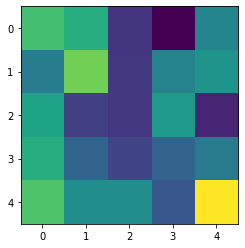

57 25


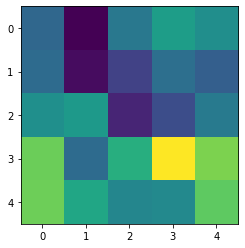

57 26


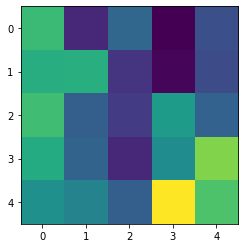

57 27


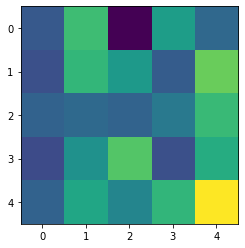

57 28


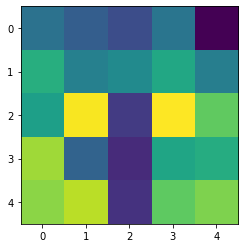

57 29


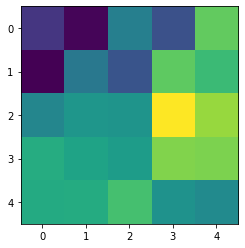

57 30


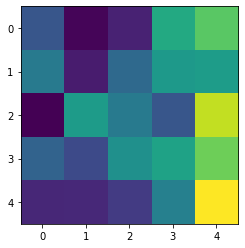

57 31


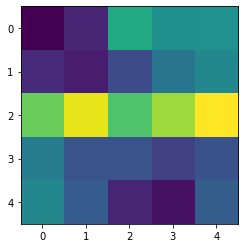

58 0


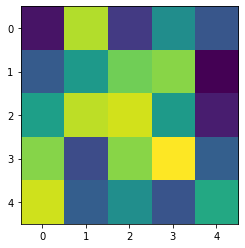

58 1


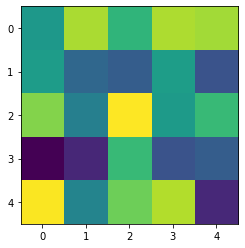

58 2


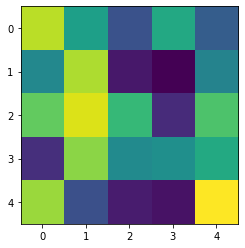

58 3


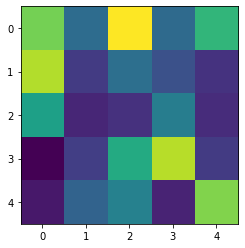

58 4


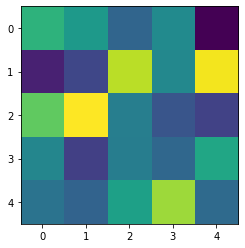

58 5


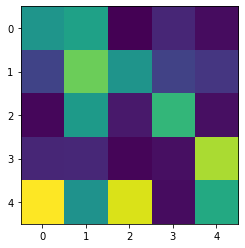

58 6


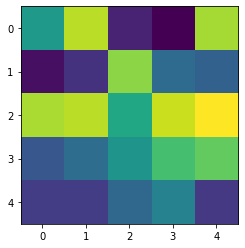

58 7


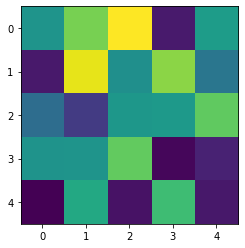

58 8


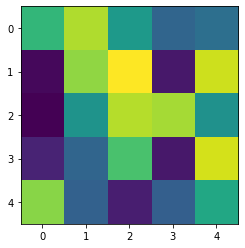

58 9


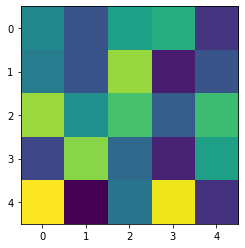

58 10


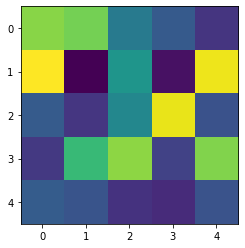

58 11


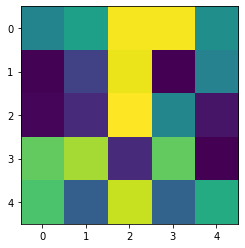

58 12


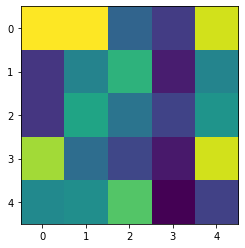

58 13


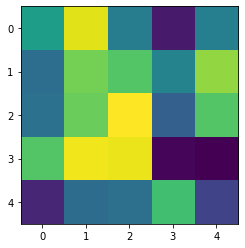

58 14


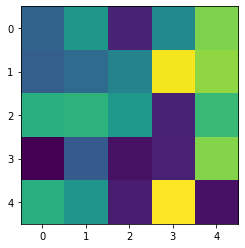

58 15


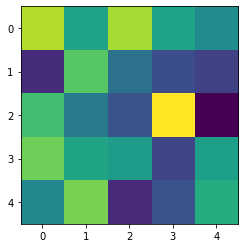

58 16


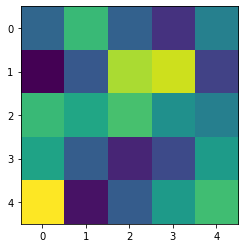

58 17


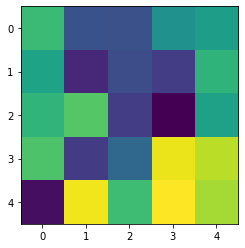

58 18


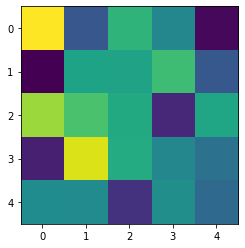

58 19


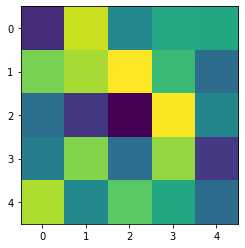

58 20


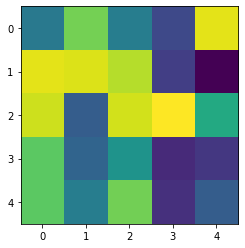

58 21


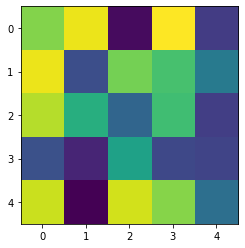

58 22


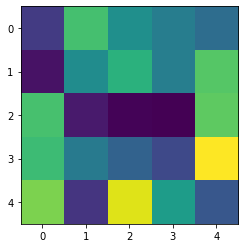

58 23


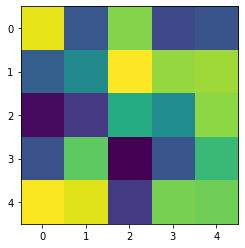

58 24


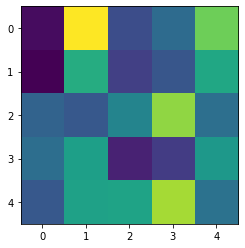

58 25


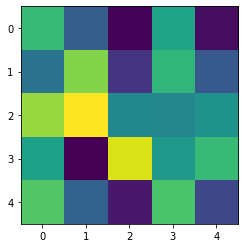

58 26


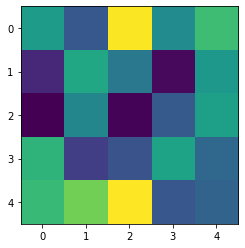

58 27


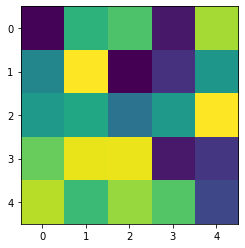

58 28


KeyboardInterrupt: 

In [53]:
print(net.conv2.weight.shape)
for i in range(net.conv2.weight.shape[0]):
    for j in range(net.conv2.weight.shape[1]):
        print(str(i)+" "+str(j))
        plt.imshow(net.conv2.weight[i][j].detach()*255)
        plt.show()